## Set up a virtual environment and activate it, then setting your project root to your local path

### Note: I am using Python 3.12.12 for this project as CatBoost has not yet been supported for Python 3.14 at the time of making this project

In [639]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd()

# ── Verify environment ──
venv_active = hasattr(sys, 'prefix') and sys.prefix != sys.base_prefix
print("=" * 60)
print(" ENVIRONMENT CHECK")
print("=" * 60)
print(f"  Python:       {sys.version.split()[0]}")
print(f"  Virtual env:  {'✓ Active' if venv_active else '✗ Not detected (recommended)'}")
print(f"  Project root: {PROJECT_ROOT}")
print(f"  Working dir:  {Path.cwd()}")
print("=" * 60)

 ENVIRONMENT CHECK
  Python:       3.12.12
  Virtual env:  ✓ Active
  Project root: /Users/vish/Documents/anaconda_projects/ML/Housing Valuation Project
  Working dir:  /Users/vish/Documents/anaconda_projects/ML/Housing Valuation Project


In [ ]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import friedmanchisquare, shapiro, spearmanr, wilcoxon
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Section 1: UK 'Price Paid Data' cleaning pipeline
## In this project, I will evaluating differences in results when using 3 approaches:
### 1. v1 = Using only 2023-Present data
### 2. v2 = Using 2023-Present data + the tail ends (<300k and >800k properties) of 2022 (Jun - Dec) data + tail ends of 2018-2019 full data
### 3. v3 = Using 2023-Present data + all data from 2022 (Jun - Dec) + 2018 - 2019

#### Note: For 2022, I am not using the full-year data due to price disruptions still in effect and only stabilising in June 2022, and hence why I have completely taken out 2020-2021 data. However, to ensure all prices are comparable, I have normalised all prices using UK HPI, which is further down in the project

#### Link: https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads#october-2025-data-current-month

### NOTE: Please save every yearly file as "sales_202X.csv"

Clean the UK Price Paid Data below + have added a small code block that deletes the original files once completed as they are large (~200MB)

### Please change the model version depending on which model you would want to test - v1 - baseline (fastest), v2 - extended (middle), v3 - comprehensive (slowest)

In [488]:
# CHANGING MODEL VERSION IS THE MOST IMPORTANT STEP AS IT WILL PRODUCE A MODEL WITH THE COMPLEXITY YOU CHOOSE IT TO
CONFIG = {
    'model_version': 'v2',  # Options: 'v1', 'v2', 'v3'
    
    # General settings
    'random_state': 42,
    'budget_threshold': 300_000,  # V2 tail: budget properties
    'luxury_threshold': 800_000,  # V2 tail: luxury properties
    
    # Paths
    'input_dir': PROJECT_ROOT,
    'output_dir': PROJECT_ROOT / 'outputs',
    
    # Processing flags (derived from model_version below)
    'process_recent': True,
    'process_historical_full': False,
    'process_historical_tails': False,
    'cleanup_raw_files': True,
}

# Set processing flags based on model version
if CONFIG['model_version'] == 'v1':
    CONFIG['process_historical_full'] = False
    CONFIG['process_historical_tails'] = False
elif CONFIG['model_version'] == 'v2':
    CONFIG['process_historical_full'] = False
    CONFIG['process_historical_tails'] = True
elif CONFIG['model_version'] == 'v3':
    CONFIG['process_historical_full'] = True
    CONFIG['process_historical_tails'] = False
else:
    raise ValueError(f"Invalid model_version: {CONFIG['model_version']}. Use 'v1', 'v2', or 'v3'.")

# Ensure directories exist
CONFIG['input_dir'].mkdir(parents=True, exist_ok=True)
CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)

print(f"  Model version: {CONFIG['model_version'].upper()}")

  Model version: V2


In [ ]:
COLUMN_NAMES = [
    "Transaction ID", "Sale Price (£)", "Date of transaction", "Postcode",
    "Property Type", "Old/New", "Duration", "PAON", "SAON", "Street",
    "Locality", "Town/City", "District", "County", "PPD Category Type",
    "Record Status - monthly file only"
]

# after investigating any "sales_20XX.csv" file
COLS_TO_KEEP = [
    "Sale Price (£)", "Date of transaction", "Postcode", "Property Type",
    "Old/New", "Duration", "PAON", "SAON", "Street"
]

In [ ]:
POSTCODES = pd.DataFrame({"postcode": [
    # HA - Harrow
    "HA0", "HA1", "HA2", "HA3", "HA4", "HA5", "HA6", "HA7", "HA8", "HA9",
    # UB - Uxbridge/Hillingdon
    "UB1", "UB2", "UB3", "UB4", "UB5", "UB6", "UB7", "UB8", "UB9", "UB10", "UB11",
    # WD - Watford/Hertfordshire
    "WD3", "WD4", "WD5", "WD6", "WD7", "WD17", "WD18", "WD19", "WD23", "WD24", "WD25",
    # HP - Hemel Hempstead/Buckinghamshire
    "HP1", "HP2", "HP3", "HP4", "HP5", "HP6", "HP7", "HP8", "HP9", "HP10", "HP15", "HP16", "HP23",
    # SL - Slough/Buckinghamshire
    "SL0", "SL1", "SL2", "SL3", "SL6", "SL7", "SL8", "SL9",
    # NW - North West London
    "NW2", "NW3", "NW4", "NW6", "NW7", "NW9", "NW10", "NW11",
    # N - North London
    "N2", "N3", "N4", "N6", "N8", "N9", "N10", "N11", "N12", "N13", "N14", "N15", "N17", "N18", "N20", "N21", "N22",
    # W - West London
    "W3", "W4", "W5", "W7", "W9", "W10", "W13",
    # TW - Twickenham/Richmond/Hounslow
    "TW1", "TW2", "TW3", "TW4", "TW5", "TW6", "TW7", "TW8", "TW9", "TW10", "TW11", "TW12", "TW13", "TW14", "TW19",
    # SW - South West London
    "SW13", "SW14", "SW15",
    # KT - Kingston
    "KT1", "KT2", "KT8",
    # EN - Enfield
    "EN1", "EN2", "EN3", "EN4", "EN5", "EN6",
    # E - East London
    "E4"
]})

In [ ]:
ALLOWED_PREFIXES = set(POSTCODES["postcode"].astype(str).str.strip())

print(f"✓ Configuration loaded")
print(f"  Study area: {len(ALLOWED_PREFIXES)} postcode districts")

In [ ]:
def process_year_file(
    filepath: Path,
    year: int,
    allowed_prefixes: set,
    tail_only: bool = False,
    start_month: int = None,
    end_month: int = None
) -> pd.DataFrame:
    """
    Process a single Price Paid CSV file.

    Parameters
    ----------
    filepath : Path
        Path to the CSV file.
    year : int
        Year label for the data.
    allowed_prefixes : set
        Set of postcode prefixes to keep.
    tail_only : bool, optional
        If True, keep only budget (≤£300k) or luxury (≥£800k) transactions.
    start_month : int, optional
        Filter transactions from this month (1-12).
    end_month : int, optional
        Filter transactions up to this month (1-12).

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame with Year column added.
    """
    df = pd.read_csv(filepath, header=None)
    df.columns = COLUMN_NAMES
    print(f"    Loaded: {len(df):,} rows")

    # Filter to allowed postcodes
    df["pc_outward"] = df["Postcode"].astype(str).str.strip().str.split().str[0]
    df = df[df["pc_outward"].isin(allowed_prefixes)].copy()
    df = df.drop(columns=["pc_outward"])
    print(f"    After postcode filter: {len(df):,} rows")

    # Date filter (for partial years)
    if start_month or end_month:
        df["Date of transaction"] = pd.to_datetime(df["Date of transaction"])
        df["month"] = df["Date of transaction"].dt.month
        start_m = start_month or 1
        end_m = end_month or 12
        df = df[(df["month"] >= start_m) & (df["month"] <= end_m)].copy()
        df = df.drop(columns=["month"])
        print(f"    After date filter (months {start_m}-{end_m}): {len(df):,} rows")

    # Tail filter (budget + luxury only)
    if tail_only:
        budget_thresh = CONFIG['budget_threshold']
        luxury_thresh = CONFIG['luxury_threshold']
        budget_mask = df["Sale Price (£)"] <= budget_thresh
        luxury_mask = df["Sale Price (£)"] >= luxury_thresh
        print(f"    Tail filter: Budget ≤£{budget_thresh:,}: {budget_mask.sum():,}")
        print(f"    Tail filter: Luxury ≥£{luxury_thresh:,}: {luxury_mask.sum():,}")
        df = df[budget_mask | luxury_mask].copy()
        print(f"    After tail filter: {len(df):,} rows")

    # Keep required columns and add year
    df = df[COLS_TO_KEEP].copy()
    df["Year"] = year

    return df


def print_price_summary(df: pd.DataFrame, title: str = "Price Summary") -> None:
    """Print price distribution summary for a DataFrame."""
    price_col = "Sale Price (£)"
    print(f"\n  {title}:")
    print(f"    Min:    £{df[price_col].min():,.0f}")
    print(f"    25th:   £{df[price_col].quantile(0.25):,.0f}")
    print(f"    Median: £{df[price_col].quantile(0.50):,.0f}")
    print(f"    75th:   £{df[price_col].quantile(0.75):,.0f}")
    print(f"    Max:    £{df[price_col].max():,.0f}")


def print_segment_distribution(df: pd.DataFrame) -> None:
    """Print price segment distribution for a DataFrame."""
    price_col = "Sale Price (£)"
    p15 = df[price_col].quantile(0.15)
    p50 = df[price_col].quantile(0.50)
    p80 = df[price_col].quantile(0.80)
    p95 = df[price_col].quantile(0.95)

    segments = [
        ("Seg1 (0-15%)", df[price_col] < p15),
        ("Seg2 (15-50%)", (df[price_col] >= p15) & (df[price_col] < p50)),
        ("Seg3 (50-80%)", (df[price_col] >= p50) & (df[price_col] < p80)),
        ("Seg4 (80-95%)", (df[price_col] >= p80) & (df[price_col] < p95)),
        ("Seg5 (95-100%)", df[price_col] >= p95),
    ]

    print(f"\n  Price segment distribution:")
    for name, mask in segments:
        count = mask.sum()
        pct = count / len(df) * 100
        print(f"    {name}: {count:,} rows ({pct:.1f}%)")

In [ ]:
# =============================================================================
# PROCESS RECENT YEARS (2023+)
# =============================================================================

if CONFIG['process_recent']:
    print("\n" + "=" * 60)
    print(" PROCESSING RECENT YEARS (2023+) - ALL DATA")
    print("=" * 60)

    recent_processed = {}

    year = 2023
    while True:
        input_file = CONFIG['input_dir'] / f"sales_{year}.csv"
        if not input_file.exists():
            print(f"\n  No file found for {year}, stopping.")
            break

        print(f"\n{'─' * 50}")
        print(f" {year} - ALL TRANSACTIONS")
        print("─" * 50)

        df = process_year_file(
            filepath=input_file,
            year=year,
            allowed_prefixes=ALLOWED_PREFIXES,
            tail_only=False
        )

        output_file = CONFIG['output_dir'] / f"sales_{year}_clean.csv"
        df.to_csv(output_file, index=False)
        print(f"  ✓ Saved: {output_file}")

        recent_processed[year] = df
        year += 1

    # Combine recent years
    if recent_processed:
        recent_combined = pd.concat(recent_processed.values(), ignore_index=True)
        recent_combined["Source"] = "recent_all"
        
        output_path = CONFIG['output_dir'] / "sales_recent_combined.csv"
        recent_combined.to_csv(output_path, index=False)

        print(f"\n{'=' * 60}")
        print(" RECENT YEARS SUMMARY")
        print("=" * 60)
        for yr in sorted(recent_processed.keys(), reverse=True):
            print(f"  {yr}: {len(recent_processed[yr]):,} rows")
        print(f"  Combined: {len(recent_combined):,} rows")
        print(f"  ✓ Saved: {output_path}")

In [ ]:
# =============================================================================
# PROCESS HISTORICAL DATA (2015-2022)
# =============================================================================

if CONFIG['process_historical_full']:
    print("\n" + "=" * 60)
    print(" PROCESSING HISTORICAL DATA (V3 - ALL TRANSACTIONS)")
    print("=" * 60)

    historical_processed = {}

    # -------------------------------------------------------------------------
    # 4.1 2022 H2 (June-December only)
    # -------------------------------------------------------------------------
    input_file = CONFIG['input_dir'] / "sales_2022.csv"
    if input_file.exists():
        print(f"\n{'─' * 50}")
        print(" 2022 - JUNE TO DECEMBER, ALL TRANSACTIONS")
        print("─" * 50)

        df = process_year_file(
            filepath=input_file,
            year=2022,
            allowed_prefixes=ALLOWED_PREFIXES,
            tail_only=False,
            start_month=6,
            end_month=12
        )
        df["Source"] = "2022_H2_full"

        output_file = CONFIG['output_dir'] / "sales_2022_H2_full.csv"
        df.to_csv(output_file, index=False)
        print(f"  ✓ Saved: {output_file}")
        historical_processed["2022_H2"] = df
    else:
        print(f"\n  ⚠ sales_2022.csv not found, skipping.")

    # -------------------------------------------------------------------------
    # 4.2 2015-2019 (full years)
    # -------------------------------------------------------------------------
    for year in range(2019, 2014, -1):
        input_file = CONFIG['input_dir'] / f"sales_{year}.csv"
        if input_file.exists():
            print(f"\n{'─' * 50}")
            print(f" {year} - FULL YEAR, ALL TRANSACTIONS")
            print("─" * 50)

            df = process_year_file(
                filepath=input_file,
                year=year,
                allowed_prefixes=ALLOWED_PREFIXES,
                tail_only=False
            )
            df["Source"] = f"{year}_full"

            output_file = CONFIG['output_dir'] / f"sales_{year}_full.csv"
            df.to_csv(output_file, index=False)
            print(f"  ✓ Saved: {output_file}")
            historical_processed[year] = df
        else:
            print(f"\n  ⚠ sales_{year}.csv not found, stopping historical processing.")
            break

    # Combine historical data
    if historical_processed:
        historical_combined = pd.concat(historical_processed.values(), ignore_index=True)
        
        output_path = CONFIG['output_dir'] / "sales_historical_full.csv"
        historical_combined.to_csv(output_path, index=False)

        print(f"\n{'=' * 60}")
        print(" HISTORICAL DATA SUMMARY (V3 - ALL TRANSACTIONS)")
        print("=" * 60)
        for key, df in sorted(historical_processed.items(), key=lambda x: str(x[0]), reverse=True):
            print(f"  {key}: {len(df):,} rows")
            print(f"       Price range: £{df['Sale Price (£)'].min():,.0f} - £{df['Sale Price (£)'].max():,.0f}")
            print(f"       Median: £{df['Sale Price (£)'].median():,.0f}")
        print(f"\n  Combined: {len(historical_combined):,} rows")
        print(f"  ✓ Saved: {output_path}")

In [ ]:
# =============================================================================
# PROCESS HISTORICAL TAILS (V2 ONLY)
# =============================================================================

if CONFIG['process_historical_tails']:
    print("\n" + "=" * 60)
    print(" PROCESSING HISTORICAL TAILS (V2)")
    print(f" Budget: ≤£{CONFIG['budget_threshold']:,} | Luxury: ≥£{CONFIG['luxury_threshold']:,}")
    print("=" * 60)

    historical_tails = {}

    # 2022 H2 tails
    input_file = CONFIG['input_dir'] / "sales_2022.csv"
    if input_file.exists():
        print(f"\n{'─' * 50}")
        print(" 2022 - JUNE TO DECEMBER, TAILS ONLY")
        print("─" * 50)
        df = process_year_file(
            filepath=input_file, year=2022, allowed_prefixes=ALLOWED_PREFIXES,
            tail_only=True, start_month=6, end_month=12
        )
        df["Source"] = "2022_H2_tails"
        df.to_csv(CONFIG['output_dir'] / "sales_2022_H2_tails.csv", index=False)
        historical_tails["2022_H2"] = df

    # 2018-2019 tails
    for year in [2019, 2018]:
        input_file = CONFIG['input_dir'] / f"sales_{year}.csv"
        if input_file.exists():
            print(f"\n{'─' * 50}")
            print(f" {year} - FULL YEAR, TAILS ONLY")
            print("─" * 50)
            df = process_year_file(
                filepath=input_file, year=year, allowed_prefixes=ALLOWED_PREFIXES,
                tail_only=True
            )
            df["Source"] = f"{year}_tails"
            df.to_csv(CONFIG['output_dir'] / f"sales_{year}_tails.csv", index=False)
            historical_tails[year] = df

    if historical_tails:
        combined = pd.concat(historical_tails.values(), ignore_index=True)
        output_path = CONFIG['output_dir'] / "sales_historical_tails.csv"
        combined.to_csv(output_path, index=False)
        print(f"\n  ✓ Saved: {output_path} ({len(combined):,} rows)")

In [ ]:
# =============================================================================
# CREATE MASTER DATASET
# =============================================================================

print("\n" + "=" * 60)
print(f" CREATING MASTER DATASET ({CONFIG['model_version'].upper()})")
print("=" * 60)

all_parts = []

# Load recent combined
recent_path = CONFIG['output_dir'] / "sales_recent_combined.csv"
if recent_path.exists():
    recent = pd.read_csv(recent_path)
    all_parts.append(recent)
    print(f"  ✓ Loaded {recent_path.name}: {len(recent):,} rows")

# Load historical based on version
if CONFIG['model_version'] in ['v2', 'v3']:
    if CONFIG['model_version'] == 'v3':
        hist_path = CONFIG['output_dir'] / "sales_historical_full.csv"
        hist_label = "full"
    else:  # v2
        hist_path = CONFIG['output_dir'] / "sales_historical_tails.csv"
        hist_label = "tails"
    
    if hist_path.exists():
        historical = pd.read_csv(hist_path)
        all_parts.append(historical)
        print(f"  ✓ Loaded {hist_path.name}: {len(historical):,} rows")
    else:
        print(f"  ⚠ Expected {hist_path.name} not found - run processing first")

# Combine and save
if all_parts:
    master = pd.concat(all_parts, ignore_index=True)
    
    master_path = PROJECT_ROOT / f"sales_combined_{CONFIG['model_version']}.csv"
    master.to_csv(master_path, index=False)

    print(f"\n{'─' * 50}")
    print(f" MASTER DATASET SUMMARY ({CONFIG['model_version'].upper()})")
    print("─" * 50)
    print(f"  Total rows: {len(master):,}")

    print(f"\n  By source:")
    for src, cnt in master["Source"].value_counts().sort_index().items():
        print(f"    {src}: {cnt:,} rows")

    print(f"\n  By year:")
    for yr, cnt in master["Year"].value_counts().sort_index(ascending=False).items():
        print(f"    {yr}: {cnt:,} rows")

    print_price_summary(master)
    print_segment_distribution(master)

    print(f"\n  ✓ Saved: {master_path}")
else:
    print("  ⚠ No data files found to combine!")

In [ ]:
# Cleaning up file directory by removing the original sales files
if CONFIG['cleanup_raw_files']:
    raw_files = []
    for search_dir in set([CONFIG['input_dir'], PROJECT_ROOT]):
        pattern = str(search_dir / "sales_20*.csv")
        raw_files.extend(glob.glob(pattern))

    raw_files = [f for f in raw_files if not any(x in f for x in ['combined', 'clean', 'historical', 'recent'])]
    raw_files = list(set(raw_files))  # Remove duplicates

    if raw_files:
        print("\n" + "=" * 60)
        print(" CLEANUP: Deleting raw sales files")
        print("=" * 60)
        for f in sorted(raw_files):
            os.remove(f)
            print(f"  ✓ Deleted: {f}")
        print(f"\n  Total deleted: {len(raw_files)} files")

# Section 2: EPC data cleaning pipeline
## Link: https://epc.opendatacommunities.org/domestic/search

In [ ]:
import shutil  # Add to master imports at top

EPC_CONFIG = {
    'raw_dir': PROJECT_ROOT / "all-domestic-certificates",
    'relevant_dir': CONFIG['output_dir'] / "Relevant Districts",
    'output_file': PROJECT_ROOT / "final_EPC_cleaned.csv",
    'cleanup_raw': True,  # Set True to delete raw EPC folder after processing
    'cleanup_outputs': True,  # Set False to investigate outputs folder
}

# Districts to keep (London boroughs + surrounding areas)
EPC_RELEVANT_FOLDERS = {
    # London boroughs
    "domestic-E09000009-Ealing",
    "domestic-E09000005-Brent",
    "domestic-E09000015-Harrow",
    "domestic-E09000017-Hillingdon",
    "domestic-E09000018-Hounslow",
    "domestic-E09000003-Barnet",
    "domestic-E09000010-Enfield",
    "domestic-E09000014-Haringey",
    "domestic-E09000027-Richmond-upon-Thames",
    # Hertfordshire districts
    "domestic-E07000103-Watford",
    "domestic-E07000102-Three-Rivers",
    "domestic-E07000096-Dacorum",
    "domestic-E07000098-Hertsmere",
    # Buckinghamshire / Slough
    "domestic-E06000039-Slough",
    "domestic-E07000005-Chiltern",
    "domestic-E07000006-South-Bucks",
    "domestic-E07000007-Wycombe",
    "domestic-E06000060-Buckinghamshire",
}

# Columns to DROP (1-based indices from EPC schema)
EPC_COLS_TO_DROP = (
    [1, 6, 8, 9, 10, 14, 15, 16, 17, 18]
    + list(range(19, 32))
    + list(range(33, 43))
    + list(range(44, 83))
    + list(range(85, 88))
    + list(range(89, 94))
)

In [ ]:
def process_epc_data() -> pd.DataFrame | None:
    """
    Process EPC data from raw download.

    Steps
    -----
    1. Load relevant districts from raw download folder
    2. Clean each district's certificates.csv (drop unused columns)
    3. Save individual cleaned files to outputs/Relevant Districts/
    4. Combine all into one final CSV in project root

    Returns
    -------
    pd.DataFrame or None
        Combined EPC data, or None if no data found.
    """
    # Create output directories
    CONFIG['output_dir'].mkdir(exist_ok=True)
    EPC_CONFIG['relevant_dir'].mkdir(parents=True, exist_ok=True)

    # Convert to 0-based indices
    cols_to_drop_0based = [i - 1 for i in EPC_COLS_TO_DROP]

    all_dataframes = []

    print("=" * 60)
    print(" PROCESSING EPC DATA")
    print("=" * 60)

    # Loop through raw folder and process only relevant districts
    for folder in sorted(EPC_CONFIG['raw_dir'].iterdir()):
        if not folder.is_dir() or folder.name not in EPC_RELEVANT_FOLDERS:
            continue

        # Extract district name (e.g., "domestic-E09000009-Ealing" -> "Ealing")
        parts = folder.name.split("-", 2)
        district_name = parts[2] if len(parts) == 3 else folder.name

        print(f"\n[{district_name}]")

        cert_file = folder / "certificates.csv"
        if not cert_file.exists():
            print(f"  ⚠ No certificates.csv found, skipping")
            continue

        # Load and clean
        print(f"  Loading...")
        df = pd.read_csv(cert_file, low_memory=False)
        print(f"  Original: {df.shape}")

        # Drop columns by index
        valid_indices = [i for i in cols_to_drop_0based if i < df.shape[1]]
        df_cleaned = df.drop(columns=df.columns[valid_indices])

        # Also drop CONSTITUENCY_LABEL if it exists
        if "CONSTITUENCY_LABEL" in df_cleaned.columns:
            df_cleaned = df_cleaned.drop(columns=["CONSTITUENCY_LABEL"])

        print(f"  Cleaned: {df_cleaned.shape}")

        # Save individual district file
        district_dir = EPC_CONFIG['relevant_dir'] / district_name
        district_dir.mkdir(exist_ok=True)
        district_file = district_dir / f"{district_name.lower()}_cleaned.csv"
        df_cleaned.to_csv(district_file, index=False)
        print(f"  ✓ Saved: {district_file}")

        all_dataframes.append(df_cleaned)

    # Combine all districts
    print("\n" + "=" * 60)
    print(" COMBINING ALL DISTRICTS")
    print("=" * 60)

    if not all_dataframes:
        print("  ⚠ No data to combine!")
        return None

    df_final = pd.concat(all_dataframes, ignore_index=True)
    print(f"  Total rows: {len(df_final):,}")
    print(f"  Columns: {len(df_final.columns)}")

    # Save combined file to root
    df_final.to_csv(EPC_CONFIG['output_file'], index=False)
    print(f"  ✓ Saved: {EPC_CONFIG['output_file']}")

    return df_final

In [ ]:
if EPC_CONFIG['raw_dir'].exists():
    df_epc = process_epc_data()
    if df_epc is not None:
        print(f"\n  Final shape: {df_epc.shape}")
else:
    print("  ⚠ 'all-domestic-certificates' folder not found (already processed or missing)")

In [ ]:
if EPC_CONFIG['cleanup_raw'] and EPC_CONFIG['raw_dir'].exists():
    shutil.rmtree(EPC_CONFIG['raw_dir'])
    print(f"  ✓ Deleted raw EPC folder: {EPC_CONFIG['raw_dir']}")

if EPC_CONFIG['cleanup_outputs'] and CONFIG['output_dir'].exists():
    shutil.rmtree(CONFIG['output_dir'])
    CONFIG['output_dir'].mkdir(exist_ok=True)
    print(f"  ✓ Cleared outputs folder: {CONFIG['output_dir']}")

# Section 3: Merging Transactions & EPC Data

In [ ]:
import re

MERGE_CONFIG = {
    'sales_path': PROJECT_ROOT / f"sales_combined_{CONFIG['model_version']}.csv",
    'epc_path': PROJECT_ROOT / "final_EPC_cleaned.csv",
    'output_path': PROJECT_ROOT / "matched_df.csv",
    'verify_dedup': True,  # Run deduplication verification (slower but thorough)
    'show_year_counts': True,  # Show transaction year distribution
}

In [ ]:
# -----------------------------------------------------------------------------
# Address Matching Functions
# -----------------------------------------------------------------------------

def normalise_text(value) -> str:
    """
    Normalise text for matching.

    Parameters
    ----------
    value : any
        Input value to normalise.

    Returns
    -------
    str
        Lowercase, stripped, single-spaced string. Empty string if NaN.
    """
    if pd.isna(value):
        return ""
    s = str(value).strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s


def extract_address_tokens(value) -> set:
    """
    Extract meaningful tokens from an address field.

    Handles formats like '41A', 'Flat 6', 'Brooklyn House, 22', etc.

    Parameters
    ----------
    value : any
        Address field value.

    Returns
    -------
    set
        Set of normalised tokens.
    """
    if pd.isna(value):
        return set()
    s = normalise_text(value)
    if not s:
        return set()
    parts = re.split(r"[,\s]+", s)
    return {p for p in parts if p}


def get_all_address_tokens(row: pd.Series, cols: list) -> set:
    """Get all address tokens from specified columns in a row."""
    all_tokens = set()
    for col in cols:
        all_tokens.update(extract_address_tokens(row[col]))
    return all_tokens


def extract_postcode_sector(postcode) -> str:
    """
    Convert full postcode to sector (e.g., 'W4 5AL' -> 'W4 5').

    Parameters
    ----------
    postcode : str
        Full UK postcode.

    Returns
    -------
    str
        Postcode sector (outward code + first digit of inward code).
    """
    if pd.isna(postcode):
        return postcode
    s = str(postcode).strip()
    if " " in s:
        parts = s.rsplit(" ", 1)
        if len(parts) == 2 and len(parts[1]) > 0:
            return parts[0] + " " + parts[1][0]
    return s

In [ ]:
print("=" * 60)
print(" LOADING DATA")
print("=" * 60)

sales = pd.read_csv(MERGE_CONFIG['sales_path'], low_memory=False)
epc = pd.read_csv(MERGE_CONFIG['epc_path'], low_memory=False)

print(f"  Sales: {len(sales):,} rows")
print(f"  EPC:   {len(epc):,} rows")

In [ ]:
print("\n" + "=" * 60)
print(" STEP 1: MERGE ON POSTCODE")
print("=" * 60)

sales["pc_match"] = sales["Postcode"].astype(str).str.strip().str.upper()
epc["pc_match"] = epc["POSTCODE"].astype(str).str.strip().str.upper()

matched = sales.merge(epc, on="pc_match", how="inner", suffixes=("_sale", "_epc"))
print(f"  After postcode merge: {len(matched):,} rows")

In [ ]:
print("\n" + "=" * 60)
print(" STEP 2: ADDRESS MATCHING")
print("=" * 60)

SALES_ADDRESS_COLS = ["PAON", "SAON", "Street"]
EPC_ADDRESS_COLS = ["ADDRESS1", "ADDRESS2", "ADDRESS3"]


def row_matches(row: pd.Series) -> bool:
    """Check if all sales address tokens appear in EPC address."""
    sales_tokens = get_all_address_tokens(row, SALES_ADDRESS_COLS)
    epc_tokens = get_all_address_tokens(row, EPC_ADDRESS_COLS)
    if not sales_tokens or not epc_tokens:
        return False
    return sales_tokens.issubset(epc_tokens)


print("  Matching addresses (this may take a moment)...")
match_mask = matched.apply(row_matches, axis=1)
matched = matched[match_mask].copy()
print(f"  After address match: {len(matched):,} rows")

In [ ]:
print("\n" + "=" * 60)
print(" STEP 3: FILTER INVALID PROPERTY TYPE MATCHES")
print("=" * 60)

# Remove rows where Property Type = "F" but PROPERTY_TYPE is not Flat/Maisonette
is_F = matched["Property Type"].astype(str).str.strip().str.upper() == "F"
is_flat_or_maisonette = matched["PROPERTY_TYPE"].astype(str).str.strip().str.lower().isin(["flat", "maisonette"])

keep_mask = (~is_F) | (is_F & is_flat_or_maisonette)
matched = matched[keep_mask].copy()

print(f"  Rows removed (F but not Flat/Maisonette): {(~keep_mask).sum():,}")
print(f"  After filtering: {len(matched):,} rows")

In [ ]:
print("\n" + "=" * 60)
print(" STEP 4: DEDUPLICATE BY MOST RECENT INSPECTION DATE")
print("=" * 60)

KEY_COLS = ["Sale Price (£)", "Date of transaction", "Postcode"]

# Store copy for verification
pre_dedup = matched.copy() if MERGE_CONFIG['verify_dedup'] else None

duplicates_before = matched.duplicated(subset=KEY_COLS, keep=False).sum()
print(f"  Duplicate rows before: {duplicates_before:,}")

matched["INSPECTION_DATE"] = pd.to_datetime(
    matched["INSPECTION_DATE"],
    format="%Y-%m-%d",
    errors="coerce"
)

null_dates = matched["INSPECTION_DATE"].isna().sum()
print(f"  Dates that failed to convert: {null_dates:,}")

matched = matched.sort_values(
    by=KEY_COLS + ["INSPECTION_DATE"],
    ascending=[True, True, True, False]
)
matched = matched.drop_duplicates(subset=KEY_COLS, keep="first").copy()
print(f"  Rows after deduplication: {len(matched):,}")

# Verification
if MERGE_CONFIG['verify_dedup'] and pre_dedup is not None:
    print("\n  Verifying deduplication...")
    pre_dedup["INSPECTION_DATE"] = pd.to_datetime(
        pre_dedup["INSPECTION_DATE"], format="%Y-%m-%d", errors="coerce"
    )
    
    errors = 0
    for idx, row in matched.head(1000).iterrows():
        mask = (
            (pre_dedup["Sale Price (£)"] == row["Sale Price (£)"]) &
            (pre_dedup["Date of transaction"] == row["Date of transaction"]) &
            (pre_dedup["Postcode"] == row["Postcode"])
        )
        group = pre_dedup[mask]
        max_date = group["INSPECTION_DATE"].max()
        kept_date = row["INSPECTION_DATE"]
        
        if pd.notna(kept_date) and pd.notna(max_date) and kept_date != max_date:
            errors += 1
    
    if errors == 0:
        print("  ✓ Verification passed - all rows have most recent INSPECTION_DATE")
    else:
        print(f"  ⚠ Verification found {errors} errors")

In [ ]:
print("\n" + "=" * 60)
print(" STEP 5: FIX MISSING BUILT_FORM")
print("=" * 60)

BUILT_FORM_MAP = {"D": "Detached", "S": "Semi-Detached", "T": "Terraced"}

no_data_mask = matched["BUILT_FORM"].astype(str).str.strip() == "NO DATA!"
print(f"  Rows with 'NO DATA!' BUILT_FORM: {no_data_mask.sum():,}")


def fix_built_form(row: pd.Series) -> str:
    """Map Property Type code to BUILT_FORM value."""
    code = str(row["Property Type"]).strip().upper()
    if code in BUILT_FORM_MAP:
        return BUILT_FORM_MAP[code]
    elif code in ("O", "F"):
        return "Other"
    return "Unknown"


matched.loc[no_data_mask, "BUILT_FORM"] = matched[no_data_mask].apply(fix_built_form, axis=1)
print("  ✓ Fixed BUILT_FORM values")

In [ ]:
print("\n" + "=" * 60)
print(" STEP 6: COLUMN TRANSFORMATIONS")
print("=" * 60)

# Date of transaction -> TRANSACTION_DATE (YYYY-MM format)
matched["TRANSACTION_DATE"] = (
    pd.to_datetime(matched["Date of transaction"], dayfirst=True, errors="coerce")
    .dt.strftime("%Y-%m")
)
matched = matched.drop(columns=["Date of transaction"])
print("  ✓ Converted Date of transaction to TRANSACTION_DATE (YYYY-MM)")

# Postcode -> POSTCODE_SECTOR
matched["POSTCODE_SECTOR"] = matched["Postcode"].apply(extract_postcode_sector)
print("  ✓ Converted Postcode to POSTCODE_SECTOR")

# Rename columns
matched = matched.rename(columns={
    "Old/New": "OLD/NEW",
    "Duration": "TENURE_TYPE",
    "pc_match": "Postcode"
})
print("  ✓ Renamed columns")

# Drop unnecessary columns
cols_to_drop = [
    "Postcode", "Postcode_sale", "POSTCODE",
    "PAON", "SAON", "Street",
    "ADDRESS1", "ADDRESS2", "ADDRESS3",
    "Property Type", "INSPECTION_DATE",
    "CONSTITUENCY_LABEL", "Year", "Source"
]
cols_to_drop = [c for c in cols_to_drop if c in matched.columns]
matched = matched.drop(columns=cols_to_drop)
print(f"  ✓ Dropped {len(cols_to_drop)} columns")

# Reorder: TRANSACTION_DATE and POSTCODE_SECTOR near front
cols = list(matched.columns)
for col in ["POSTCODE_SECTOR", "TRANSACTION_DATE"]:
    if col in cols:
        cols.remove(col)
cols.insert(1, "TRANSACTION_DATE")
cols.insert(2, "POSTCODE_SECTOR")
matched = matched[cols]
print("  ✓ Reordered columns")

In [ ]:
print("\n" + "=" * 60)
print(" SAVING OUTPUT")
print("=" * 60)

matched.to_csv(MERGE_CONFIG['output_path'], index=False)
print(f"  ✓ Saved: {MERGE_CONFIG['output_path']}")
print(f"  Final rows: {len(matched):,}")
print(f"  Final columns: {len(matched.columns)}")
print(f"\n  Columns: {matched.columns.tolist()}")

# Optional: Show year distribution
if MERGE_CONFIG['show_year_counts']:
    print("\n  Transaction year distribution:")
    year_counts = matched["TRANSACTION_DATE"].str[:4].value_counts().sort_index()
    for year, count in year_counts.items():
        print(f"    {year}: {count:,}")

# Section 4: House Price Index (HPI) normalisation to sale prices


### Methodology Note: HPI data on the websites below are adjusted to their own scale. To re-adjust, the newest month is set to '100', ...

In [ ]:
print(matched["LOCAL_AUTHORITY_LABEL"].unique())

### Sources:
#### 1: https://landregistry.data.gov.uk/app/ukhpi/compare?from=2018-01-01&in=hpi&location[]=E09000003&location[]=E06000060&location[]=E09000010&location[]=E09000017&location[]=E09000005&st=all&to=2025-12-15&lang=en
#### 2. https://landregistry.data.gov.uk/app/ukhpi/compare?from=2018-01-01&in=hpi&location[]=E09000009&location[]=E07000096&location[]=E09000018&location[]=E09000014&location[]=E09000015&st=all&to=2025-12-15&lang=en
#### 3. https://landregistry.data.gov.uk/app/ukhpi/compare?from=2018-01-01&in=hpi&location[]=E07000098&location[]=E06000039&location[]=E07000103&location[]=E07000102&location[]=E09000027&st=all&to=2025-12-15&lang=en

### NOTE 1: 'Chiltern', 'Wycombe' and 'South Bucks' have been merged into the unitary 'Buckinghamshire' Council
### NOTE 2: Save HPI files as "HPI_n.csv", where n is the n'th file (but since we have 15 unique local authorities and each .csv can hold 5 local authorities for any date range, we only require 3 csv files even for future use)

In [ ]:
HPI_CONFIG = {
    'hpi_files': [
        PROJECT_ROOT / "HPI_1.csv",
        PROJECT_ROOT / "HPI_2.csv",
        PROJECT_ROOT / "HPI_3.csv",
    ],
    'lookup_path': PROJECT_ROOT / "hpi_lookup.csv",
    'cleanup_raw': True,
}

# Local authority consolidation (merged councils)
LA_RENAME_MAP = {
    "Chiltern": "Buckinghamshire",
    "South Bucks": "Buckinghamshire",
    "Wycombe": "Buckinghamshire",
}

In [ ]:
# -----------------------------------------------------------------------------
# HPI Processing Function
# -----------------------------------------------------------------------------

def process_hpi_file(filepath: Path) -> tuple[pd.DataFrame, str]:
    """
    Process a single HPI file and return lookup table.

    Parameters
    ----------
    filepath : Path
        Path to HPI CSV file.

    Returns
    -------
    tuple[pd.DataFrame, str]
        (lookup_table, latest_period) where lookup_table contains
        Name, Period, and NORMALISED_HPI columns.
    """
    hpi = pd.read_csv(filepath)

    # Get latest HPI for each local authority
    latest_hpi = (
        hpi
        .sort_values("Period", ascending=False)
        .groupby("Name")
        .first()
        .reset_index()[["Name", "Period", "House price index All property types"]]
        .rename(columns={
            "House price index All property types": "Latest_HPI",
            "Period": "Latest_Period"
        })
    )

    latest_period = latest_hpi["Latest_Period"].max()

    # Calculate normalisation factor (latest / historical)
    hpi = hpi.merge(latest_hpi[["Name", "Latest_HPI"]], on="Name", how="left")
    hpi["NORMALISED_HPI"] = hpi["Latest_HPI"] / hpi["House price index All property types"]

    lookup = hpi[["Name", "Period", "NORMALISED_HPI"]].copy()

    return lookup, latest_period

In [ ]:
# -----------------------------------------------------------------------------
# Step 1: Rename Local Authorities
# -----------------------------------------------------------------------------

print("=" * 60)
print(" STEP 1: RENAME LOCAL AUTHORITIES")
print("=" * 60)

print(f"  Unique LAs before: {matched['LOCAL_AUTHORITY_LABEL'].nunique()}")

matched["LOCAL_AUTHORITY_LABEL"] = matched["LOCAL_AUTHORITY_LABEL"].replace(LA_RENAME_MAP)

for old, new in LA_RENAME_MAP.items():
    print(f"  ✓ Renamed '{old}' → '{new}'")

print(f"  Unique LAs after: {matched['LOCAL_AUTHORITY_LABEL'].nunique()}")

In [ ]:
# -----------------------------------------------------------------------------
# Step 2: Process HPI Files
# -----------------------------------------------------------------------------

print("\n" + "=" * 60)
print(" STEP 2: PROCESS HPI FILES")
print("=" * 60)

hpi_files_exist = all(f.exists() for f in HPI_CONFIG['hpi_files'])

if hpi_files_exist:
    lookups = []
    latest_periods = []

    for i, filepath in enumerate(HPI_CONFIG['hpi_files'], 1):
        print(f"\n  Processing HPI_{i}...")
        lookup, latest = process_hpi_file(filepath)
        lookups.append(lookup)
        latest_periods.append(latest)
        print(f"    ✓ {len(lookup):,} rows | Names: {lookup['Name'].unique().tolist()}")

    # Combine all lookup tables
    print("\n  Combining lookup tables...")
    hpi_lookup = pd.concat(lookups, ignore_index=True)

    # Check for duplicates
    duplicates = hpi_lookup.duplicated(subset=["Name", "Period"], keep=False).sum()
    if duplicates > 0:
        print(f"    ⚠ Warning: {duplicates} duplicate Name+Period combinations found")
        hpi_lookup = hpi_lookup.drop_duplicates(subset=["Name", "Period"], keep="first")

    # Report latest period
    overall_latest = max(latest_periods)
    formatted_date = pd.to_datetime(overall_latest).strftime("%b-%Y")

    print(f"\n  ✓ Combined lookup: {len(hpi_lookup):,} rows")
    print(f"  ✓ Local Authorities: {hpi_lookup['Name'].nunique()}")
    print(f"  ✓ HPI normalised to: {formatted_date}")

    # Save lookup
    hpi_lookup.to_csv(HPI_CONFIG['lookup_path'], index=False)
    print(f"  ✓ Saved: {HPI_CONFIG['lookup_path']}")

    # Cleanup raw files
    if HPI_CONFIG['cleanup_raw']:
        print("\n  Cleaning up raw HPI files...")
        for filepath in HPI_CONFIG['hpi_files']:
            if filepath.exists():
                os.remove(filepath)
                print(f"    ✓ Deleted: {filepath.name}")

elif HPI_CONFIG['lookup_path'].exists():
    # Load existing lookup
    hpi_lookup = pd.read_csv(HPI_CONFIG['lookup_path'])
    print(f"  ✓ Loaded existing: {HPI_CONFIG['lookup_path']} ({len(hpi_lookup):,} rows)")

else:
    missing = [f.name for f in HPI_CONFIG['hpi_files'] if not f.exists()]
    raise FileNotFoundError(f"HPI files not found: {missing}")

In [ ]:
# -----------------------------------------------------------------------------
# Step 3: Match HPI to Transactions
# -----------------------------------------------------------------------------

print("\n" + "=" * 60)
print(" STEP 3: MATCH HPI TO TRANSACTIONS")
print("=" * 60)

# Standardise date formats to YYYY-MM
matched["TRANSACTION_DATE"] = (
    pd.to_datetime(matched["TRANSACTION_DATE"])
    .dt.to_period("M")
    .astype(str)
)
hpi_lookup["Period"] = (
    pd.to_datetime(hpi_lookup["Period"])
    .dt.to_period("M")
    .astype(str)
)

# Get latest HPI per Local Authority (for fallback)
latest_hpi = hpi_lookup.loc[
    hpi_lookup.groupby("Name")["Period"].idxmax(),
    ["Name", "NORMALISED_HPI"]
]

# Merge exact matches
matched = matched.merge(
    hpi_lookup,
    left_on=["LOCAL_AUTHORITY_LABEL", "TRANSACTION_DATE"],
    right_on=["Name", "Period"],
    how="left"
)

# Fill missing with latest HPI for that LA
missing_mask = matched["NORMALISED_HPI"].isna()
matched.loc[missing_mask, "NORMALISED_HPI"] = (
    matched.loc[missing_mask, "LOCAL_AUTHORITY_LABEL"]
    .map(latest_hpi.set_index("Name")["NORMALISED_HPI"])
)

# Drop redundant columns from merge
matched = matched.drop(columns=["Name", "Period"])

# Report
total = len(matched)
matched_count = matched["NORMALISED_HPI"].notna().sum()
print(f"  ✓ Matched: {matched_count:,}/{total:,} ({matched_count/total*100:.1f}%)")

if matched_count < total:
    unmatched_las = matched[matched["NORMALISED_HPI"].isna()]["LOCAL_AUTHORITY_LABEL"].unique()
    print(f"  ⚠ Unmatched LAs: {unmatched_las.tolist()}")

In [ ]:
# -----------------------------------------------------------------------------
# Step 4: Calculate Base Price
# -----------------------------------------------------------------------------

print("\n" + "=" * 60)
print(" STEP 4: CALCULATE BASE PRICE")
print("=" * 60)

matched["BASE_PRICE"] = matched["NORMALISED_HPI"] * matched["Sale Price (£)"]

# Reorder columns: BASE_PRICE first
cols = ["BASE_PRICE"] + [c for c in matched.columns if c != "BASE_PRICE"]
matched = matched[cols]

# Drop original price columns
matched = matched.drop(columns=["Sale Price (£)", "NORMALISED_HPI"])

print(f"  ✓ Created BASE_PRICE (HPI-normalised price)")
print(f"  ✓ Dropped 'Sale Price (£)' and 'NORMALISED_HPI'")
print(f"  ✓ Final shape: {matched.shape}")
print(f"\n  Columns: {matched.columns.tolist()}")

# Section 5: Rigorous data cleaning

In [ ]:
CLEANING_CONFIG = {
    'show_price_distribution': True,  # Show BASE_PRICE visualisation
    'show_price_stats': True,  # Show BASE_PRICE statistics
    'floor_area_min': 20,  # Minimum valid floor area (sqm)
    'floor_area_max': 350,  # Maximum valid floor area (sqm)
    'max_rooms': 17,  # Maximum valid number of rooms
}

# Column value mappings
OLDNEW_MAP = {"N": "O", "Y": "N"}  # Fix Price Paid encoding - currently, Y means new and N old, so change Y -> N and N -> O 

TERRACE_TYPES = [
    'Mid-Terrace', 'End-Terrace', 'Enclosed End-Terrace',
    'Enclosed Mid-Terrace', 'Terraced'
]

In [ ]:
def check_column_quality(df: pd.DataFrame, col: str, show_values: bool = True) -> dict:
    """
    Perform quality check on a column and print summary.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to check.
    col : str
        Column name.
    show_values : bool
        Whether to print all unique values.

    Returns
    -------
    dict
        Quality metrics (nulls, empty_strings, unique_count).
    """
    print("=" * 60)
    print(f" {col} - QUALITY CHECK")
    print("=" * 60)

    nulls = df[col].isna().sum()
    
    # String-specific checks
    if df[col].dtype == 'object':
        empty_strings = (df[col] == '').sum()
        whitespace_only = df[col].str.strip().eq('').sum() - empty_strings
    else:
        empty_strings = 0
        whitespace_only = 0

    print(f"\n  Quality:")
    print(f"    Null/NaN:        {nulls:,}")
    print(f"    Empty strings:   {empty_strings:,}")
    print(f"    Whitespace only: {whitespace_only:,}")

    value_counts = df[col].value_counts(dropna=False)
    print(f"\n  Unique values: {len(value_counts):,}")

    if show_values:
        print(f"\n  Distribution:")
        for val, count in value_counts.items():
            pct = count / len(df) * 100
            print(f"    {val}: {count:,} ({pct:.1f}%)")

    return {
        'nulls': nulls,
        'empty_strings': empty_strings,
        'unique_count': len(value_counts)
    }


def check_numeric_column(df: pd.DataFrame, col: str, unit: str = "") -> dict:
    """
    Perform quality check on a numeric column.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to check.
    col : str
        Column name.
    unit : str
        Unit label for display (e.g., "sqm", "rooms").

    Returns
    -------
    dict
        Quality metrics and statistics.
    """
    print("=" * 60)
    print(f" {col} - SUMMARY STATISTICS")
    print("=" * 60)

    nulls = df[col].isna().sum()
    zeros = (df[col] == 0).sum()

    print(f"\n  Quality:")
    print(f"    Null/NaN: {nulls:,}")
    print(f"    Zeros:    {zeros:,}")

    print(f"\n  Statistics:")
    print(f"    Count:   {df[col].count():,}")
    print(f"    Mean:    {df[col].mean():,.1f} {unit}")
    print(f"    Median:  {df[col].median():,.1f} {unit}")
    print(f"    Std Dev: {df[col].std():,.1f} {unit}")
    print(f"    Min:     {df[col].min():,.1f} {unit}")
    print(f"    Max:     {df[col].max():,.1f} {unit}")

    print(f"\n  Percentiles:")
    for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
        val = df[col].quantile(p / 100)
        print(f"    {p:>2}th: {val:>10,.1f} {unit}")

    return {'nulls': nulls, 'zeros': zeros}

In [ ]:
if CLEANING_CONFIG['show_price_distribution']:
    print("=" * 60)
    print(" BASE_PRICE DISTRIBUTION - ZOOMED VIEW")
    print("=" * 60)

    # Sample for performance
    sample_size = min(50000, len(matched))
    sample = matched['BASE_PRICE'].sample(sample_size, random_state=CONFIG['random_state'])

    # Zoomed view (1st to 99th percentile)
    fig, ax = plt.subplots(figsize=(14, 6))
    p1, p99 = matched['BASE_PRICE'].quantile(0.01), matched['BASE_PRICE'].quantile(0.99)
    zoomed = sample[(sample >= p1) & (sample <= p99)]
    y_jitter = np.random.uniform(-0.3, 0.3, size=len(zoomed))

    ax.scatter(zoomed, y_jitter, alpha=0.15, s=2, c='darkgreen')

    # Add percentile lines
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    colors = ['red', 'orange', 'gold', 'green', 'black', 'green', 'gold', 'orange', 'red']

    for p, color in zip(percentiles, colors):
        val = matched['BASE_PRICE'].quantile(p / 100)
        if p1 <= val <= p99:
            ax.axvline(val, color=color, linestyle='--', alpha=0.8, linewidth=1.5)
            ax.annotate(f'{p}th: £{val/1e3:.0f}k', xy=(val, 0.4),
                        rotation=90, fontsize=8, ha='right', va='bottom')

    ax.set_xlabel('BASE_PRICE (£)')
    ax.set_title('BASE_PRICE Distribution (1st-99th Percentile)')
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n  Percentile Breakdown:")
    print("  " + "-" * 45)
    for p in percentiles:
        val = matched['BASE_PRICE'].quantile(p / 100)
        count_below = (matched['BASE_PRICE'] <= val).sum()
        print(f"    {p:>3}th percentile: £{val:>12,.0f}  ({count_below:,} rows)")


if CLEANING_CONFIG['show_price_stats']:
    print("\n" + "=" * 60)
    print(" BASE_PRICE STATISTICS")
    print("=" * 60)

    stats = {
        'Min': matched['BASE_PRICE'].min(),
        'Max': matched['BASE_PRICE'].max(),
        'Mean': matched['BASE_PRICE'].mean(),
        'Median': matched['BASE_PRICE'].median(),
        'Std Dev': matched['BASE_PRICE'].std(),
    }

    for name, val in stats.items():
        print(f"  {name:<10} £{val:,.0f}")

    skew_ratio = stats['Mean'] / stats['Median']
    print(f"\n  Mean/Median ratio: {skew_ratio:.3f}")
    if skew_ratio > 1.05:
        print("  → Right-skewed (high-value outliers)")
    elif skew_ratio < 0.95:
        print("  → Left-skewed (low-value outliers)")
    else:
        print("  → Approximately symmetric")

### Since the data can get heavily skewed by extreme outliers, I will add splits to the dataset after cleaning and before training it to make multiple models being passed into a ML model that will allow for multiple parameters predicting BASE_PRICE

In [ ]:
print("\n" + "=" * 60)
print(" DROPPING UNNECESSARY COLUMNS")
print("=" * 60)

cols_to_drop = ["TRANSACTION_DATE", "TENURE"]
cols_to_drop = [c for c in cols_to_drop if c in matched.columns]

if cols_to_drop:
    matched = matched.drop(columns=cols_to_drop)
    for col in cols_to_drop:
        print(f"  ✓ Dropped {col}")

print(f"\n  Remaining columns ({len(matched.columns)}): {matched.columns.tolist()}")

In [ ]:
# POSTCODE_SECTOR
check_column_quality(matched, 'POSTCODE_SECTOR')

In [ ]:
# OLD/NEW
check_column_quality(matched, 'OLD/NEW')

In [ ]:
print("\n" + "=" * 60)
print(" FIXING OLD/NEW ENCODING")
print("=" * 60)

matched["OLD/NEW"] = matched["OLD/NEW"].replace(OLDNEW_MAP)
print("  ✓ Replaced 'N' → 'O' (Old property)")
print("  ✓ Replaced 'Y' → 'N' (New property)")
print(f"  ✓ Values: {matched['OLD/NEW'].value_counts().to_dict()}")

In [ ]:
# PROPERTY_TYPE
check_column_quality(matched, 'PROPERTY_TYPE')

In [ ]:
print("\n" + "=" * 60)
print(" REMOVING PARK HOME PROPERTIES")
print("=" * 60)

before = len(matched)
matched = matched[matched["PROPERTY_TYPE"] != "Park home"].copy()
print(f"  ✓ Removed {before - len(matched):,} Park home rows")
print(f"  ✓ Rows: {before:,} → {len(matched):,}")

In [ ]:
# BUILT_FORM
check_column_quality(matched, 'BUILT_FORM')

In [ ]:
print("\n" + "=" * 60)
print(" CLEANING BUILT_FORM")
print("=" * 60)

matched['BUILT_FORM'] = matched['BUILT_FORM'].replace(TERRACE_TYPES, 'Terraced')
matched['BUILT_FORM'] = matched['BUILT_FORM'].replace(['Not Recorded'], 'Other')
matched['BUILT_FORM'] = matched['BUILT_FORM'].fillna('Other')

print("  ✓ Combined terrace types → 'Terraced'")
print("  ✓ Combined 'Not Recorded' + NaN → 'Other'")
print(f"  ✓ Values: {matched['BUILT_FORM'].value_counts().to_dict()}")

In [ ]:
# LOCAL_AUTHORITY_LABEL
check_column_quality(matched, 'LOCAL_AUTHORITY_LABEL')

In [ ]:
# TENURE_TYPE
check_column_quality(matched, 'TENURE_TYPE')

In [ ]:
# CURRENT_ENERGY_RATING
check_column_quality(matched, 'CURRENT_ENERGY_RATING')

In [ ]:
# TOTAL_FLOOR_AREA
check_numeric_column(matched, 'TOTAL_FLOOR_AREA', unit='sqm')

In [ ]:
print("\n  Outlier counts:")
print(f"    Below {CLEANING_CONFIG['floor_area_min']} sqm: {(matched['TOTAL_FLOOR_AREA'] < CLEANING_CONFIG['floor_area_min']).sum():,}")
print(f"    Above {CLEANING_CONFIG['floor_area_max']} sqm: {(matched['TOTAL_FLOOR_AREA'] >= CLEANING_CONFIG['floor_area_max']).sum():,}")

In [ ]:
print("\n" + "=" * 60)
print(" CLEANING TOTAL_FLOOR_AREA OUTLIERS")
print("=" * 60)

floor_min = CLEANING_CONFIG['floor_area_min']
floor_max = CLEANING_CONFIG['floor_area_max']

under_min = (matched['TOTAL_FLOOR_AREA'] < floor_min).sum()
over_max = (matched['TOTAL_FLOOR_AREA'] >= floor_max).sum()

matched.loc[matched['TOTAL_FLOOR_AREA'] < floor_min, 'TOTAL_FLOOR_AREA'] = np.nan
matched.loc[matched['TOTAL_FLOOR_AREA'] >= floor_max, 'TOTAL_FLOOR_AREA'] = np.nan

print(f"  ✓ Set {under_min:,} values < {floor_min} sqm to NaN")
print(f"  ✓ Set {over_max:,} values >= {floor_max} sqm to NaN")
print(f"  ✓ Valid entries: {matched['TOTAL_FLOOR_AREA'].notna().sum():,}")

In [ ]:
# NUMBER_HABITABLE_ROOMS
check_numeric_column(matched, 'NUMBER_HABITABLE_ROOMS', unit='rooms')

In [ ]:
print("\n" + "=" * 60)
print(" REMOVING EXTREME ROOM COUNTS")
print("=" * 60)

max_rooms = CLEANING_CONFIG['max_rooms']
before = len(matched)
matched = matched[matched['NUMBER_HABITABLE_ROOMS'] < max_rooms].copy()

print(f"  ✓ Removed {before - len(matched):,} rows with >= {max_rooms} rooms")
print(f"  ✓ Rows: {before:,} → {len(matched):,}")

In [ ]:
print("\n" + "=" * 60)
print(" DATA CLEANING COMPLETE")
print("=" * 60)
print(f"  Final rows:    {len(matched):,}")
print(f"  Final columns: {len(matched.columns)}")
print(f"\n  Columns: {matched.columns.tolist()}")

# Section 6: Modelling NUMBER_HABITABLE_ROOMS -> NUMBER_BEDROOMS | NUMBER_BATHROOMS

## Assumption 1: Bedroom & Bathroom Estimation Logic

### Definitions
- $H$ = Number of Habitable Rooms (`NUMBER_HABITABLE_ROOMS`)
- $L$ = Number of Living Rooms (`HELPER_NUMBER_LIVING_ROOMS`)
- $B$ = Number of Bedrooms (`NUMBER_BEDROOMS`)
- $Bath$ = Number of Bathrooms (`NUMBER_BATHROOMS`)
- $A$ = Total Floor Area in sqm (`TOTAL_FLOOR_AREA`)

**Note:** If $H$ is missing (NaN), then $L$, $B$, and $Bath$ are all set to NaN.

---

### Key Assumption

According to EPC definitions, habitable rooms include any living room, sitting room, dining room, bedroom, study, and similar spaces (including non-separated conservatories). Kitchens and bathrooms are excluded.

We assume:
$$
H \approx L + B
$$

Where $L$ represents all **non-bedroom habitable rooms** (living rooms, dining rooms, studies, etc.) and $B$ represents **bedrooms only**.

Therefore:
$$
B = H - L
$$

---

### Living Room Estimation ($L$)

#### Flats & Maisonettes
$$
L = 
\begin{cases} 
0 & \text{if } H = 1 \\
1 & \text{if } 2 \leq H \leq 5 \\
2 & \text{if } H \geq 6 
\end{cases}
$$

#### Houses — Terraced, Semi-Detached & Other
$$
L = 
\begin{cases} 
0 & \text{if } H = 1 \\
1 & \text{if } 2 \leq H \leq 4 \\
2 & \text{if } H = 5 \text{ and } A < 100 \\
1 & \text{if } H = 5 \text{ and } A \geq 100 \\
2 & \text{if } 6 \leq H \leq 7 \\
3 & \text{if } H \geq 8 \text{ and } A < 150 \\
2 & \text{if } H \geq 8 \text{ and } A \geq 150
\end{cases}
$$

> **Rationale for $H = 5$:** Smaller houses (< 100 sqm) with 5 habitable rooms typically have 2 reception areas (lounge + dining) and 3 bedrooms. Larger houses (≥ 100 sqm) are more likely to be genuine 4-beds with 1 reception room.

**Fallback (if $A$ is NaN):**
$$
L = 
\begin{cases} 
0 & \text{if } H = 1 \\
1 & \text{if } 2 \leq H \leq 5 \\
2 & \text{if } H \geq 6
\end{cases}
$$

#### Houses — Detached
$$
L = 
\begin{cases} 
0 & \text{if } H = 1 \\
1 & \text{if } 2 \leq H \leq 5 \\
2 & \text{if } 6 \leq H \leq 7 \\
2 & \text{if } H \geq 8 \text{ and } A < 200 \\
3 & \text{if } H \geq 8 \text{ and } A \geq 200 
\end{cases}
$$

> **Rationale:** Detached houses tend to be larger overall, so the floor area threshold is set higher (200 sqm vs 150 sqm) before assuming additional reception rooms.

**Fallback (if $A$ is NaN):**
$$
L = 
\begin{cases} 
0 & \text{if } H = 1 \\
1 & \text{if } 2 \leq H \leq 5 \\
2 & \text{if } H \geq 6
\end{cases}
$$

#### Bungalows
$$
L = 
\begin{cases} 
0 & \text{if } H = 1 \\
1 & \text{if } 2 \leq H \leq 4 \\
2 & \text{if } H \geq 5 
\end{cases}
$$

---

### Bedroom Estimation ($B$)
$$
B = H - L
$$

---

### Bathroom Estimation ($Bath$)
$$
Bath = 
\begin{cases} 
1 & \text{if } B \leq 2 \\
\frac{B}{2} & \text{if } B \geq 3 
\end{cases}
$$

---

### Sanity Check Ranges (Floor Area by Bedrooms)

| Bedrooms ($B$) | Min Area (sqm) | Max Area (sqm) |
|----------------|----------------|----------------|
| 1 | 20 | 65 |
| 2 | 40 | 90 |
| 3 | 60 | 130 |
| 4 | 85 | 180 |
| 5 | 110 | 250 |
| 6+ | 150 | — |

In [ ]:
BEDROOM_AREA_RANGES = {
    1: (20, 65),
    2: (40, 90),
    3: (60, 130),
    4: (85, 180),
    5: (110, 250),
    6: (150, None),  # 6+ beds: minimum only
}

In [ ]:
print("=" * 60)
print(" ESTIMATING BEDROOMS & BATHROOMS")
print("=" * 60)

matched['HELPER_NUMBER_LIVING_ROOMS'] = np.nan
matched['NUMBER_BEDROOMS'] = np.nan
matched['NUMBER_BATHROOMS'] = np.nan

valid_mask = matched['NUMBER_HABITABLE_ROOMS'].notna()
has_floor_area = matched['TOTAL_FLOOR_AREA'].notna()

print(f"\n  Rows with valid habitable rooms: {valid_mask.sum():,}")
print(f"  Rows skipped (NaN habitable rooms): {(~valid_mask).sum():,}")

In [ ]:
print("\n  Processing Flats & Maisonettes...")

flat_mask = valid_mask & matched['PROPERTY_TYPE'].isin(['Flat', 'Maisonette'])
H = matched['NUMBER_HABITABLE_ROOMS']

# H = 1 → L = 0
matched.loc[flat_mask & (H == 1), 'HELPER_NUMBER_LIVING_ROOMS'] = 0
# H = 2-5 → L = 1
matched.loc[flat_mask & (H >= 2) & (H <= 5), 'HELPER_NUMBER_LIVING_ROOMS'] = 1
# H >= 6 → L = 2
matched.loc[flat_mask & (H >= 6), 'HELPER_NUMBER_LIVING_ROOMS'] = 2

print(f"    ✓ Processed {flat_mask.sum():,} rows")

In [ ]:
print("\n  Processing Houses (Terraced, Semi-Detached & Other)...")

tso_mask = (
    valid_mask &
    (matched['PROPERTY_TYPE'] == 'House') &
    matched['BUILT_FORM'].isin(['Terraced', 'Semi-Detached', 'Other'])
)
A = matched['TOTAL_FLOOR_AREA']

# H = 1 → L = 0
matched.loc[tso_mask & (H == 1), 'HELPER_NUMBER_LIVING_ROOMS'] = 0

# H = 2-4 → L = 1
matched.loc[tso_mask & (H >= 2) & (H <= 4), 'HELPER_NUMBER_LIVING_ROOMS'] = 1

# H = 5: depends on floor area
matched.loc[tso_mask & has_floor_area & (H == 5) & (A < 100), 'HELPER_NUMBER_LIVING_ROOMS'] = 2
matched.loc[tso_mask & has_floor_area & (H == 5) & (A >= 100), 'HELPER_NUMBER_LIVING_ROOMS'] = 1
matched.loc[tso_mask & ~has_floor_area & (H == 5), 'HELPER_NUMBER_LIVING_ROOMS'] = 2  # Fallback

# H = 6-7 → L = 2
matched.loc[tso_mask & (H >= 6) & (H <= 7), 'HELPER_NUMBER_LIVING_ROOMS'] = 2

# H >= 8: depends on floor area
matched.loc[tso_mask & has_floor_area & (H >= 8) & (A < 150), 'HELPER_NUMBER_LIVING_ROOMS'] = 3
matched.loc[tso_mask & has_floor_area & (H >= 8) & (A >= 150), 'HELPER_NUMBER_LIVING_ROOMS'] = 2
matched.loc[tso_mask & ~has_floor_area & (H >= 8), 'HELPER_NUMBER_LIVING_ROOMS'] = 2  # Fallback

print(f"    ✓ Processed {tso_mask.sum():,} rows")
print(f"      - With floor area: {(tso_mask & has_floor_area).sum():,}")
print(f"      - Fallback (no floor area): {(tso_mask & ~has_floor_area).sum():,}")

In [ ]:
print("\n  Processing Houses (Detached)...")

detached_mask = (
    valid_mask &
    (matched['PROPERTY_TYPE'] == 'House') &
    (matched['BUILT_FORM'] == 'Detached')
)

# H = 1 → L = 0
matched.loc[detached_mask & (H == 1), 'HELPER_NUMBER_LIVING_ROOMS'] = 0

# H = 2-5 → L = 1
matched.loc[detached_mask & (H >= 2) & (H <= 5), 'HELPER_NUMBER_LIVING_ROOMS'] = 1

# H = 6-7 → L = 2 (always, regardless of floor area)
matched.loc[detached_mask & (H >= 6) & (H <= 7), 'HELPER_NUMBER_LIVING_ROOMS'] = 2

# H >= 8: depends on floor area (higher threshold for detached: 200 sqm)
matched.loc[detached_mask & has_floor_area & (H >= 8) & (A < 200), 'HELPER_NUMBER_LIVING_ROOMS'] = 2
matched.loc[detached_mask & has_floor_area & (H >= 8) & (A >= 200), 'HELPER_NUMBER_LIVING_ROOMS'] = 3
matched.loc[detached_mask & ~has_floor_area & (H >= 8), 'HELPER_NUMBER_LIVING_ROOMS'] = 2  # Fallback

print(f"    ✓ Processed {detached_mask.sum():,} rows")
print(f"      - With floor area: {(detached_mask & has_floor_area).sum():,}")
print(f"      - Fallback (no floor area): {(detached_mask & ~has_floor_area).sum():,}")

In [ ]:
print("\n  Processing Bungalows...")

bungalow_mask = valid_mask & (matched['PROPERTY_TYPE'] == 'Bungalow')

# H = 1 → L = 0
matched.loc[bungalow_mask & (H == 1), 'HELPER_NUMBER_LIVING_ROOMS'] = 0
# H = 2-4 → L = 1
matched.loc[bungalow_mask & (H >= 2) & (H <= 4), 'HELPER_NUMBER_LIVING_ROOMS'] = 1
# H >= 5 → L = 2
matched.loc[bungalow_mask & (H >= 5), 'HELPER_NUMBER_LIVING_ROOMS'] = 2

print(f"    ✓ Processed {bungalow_mask.sum():,} rows")

In [ ]:
print("\n  Calculating Bedrooms (B = H - L)...")
matched['NUMBER_BEDROOMS'] = (
    matched['NUMBER_HABITABLE_ROOMS'] - matched['HELPER_NUMBER_LIVING_ROOMS']
)
print(f"    ✓ Bedrooms calculated for {matched['NUMBER_BEDROOMS'].notna().sum():,} rows")

print("\n  Calculating Bathrooms...")
B = matched['NUMBER_BEDROOMS']

# B <= 2 → Bath = 1
matched.loc[B <= 2, 'NUMBER_BATHROOMS'] = 1
# B >= 3 → Bath = B / 2
matched.loc[B >= 3, 'NUMBER_BATHROOMS'] = B / 2

print(f"    ✓ Bathrooms calculated for {matched['NUMBER_BATHROOMS'].notna().sum():,} rows")

In [ ]:
print("\n" + "=" * 60)
print(" ESTIMATION SUMMARY")
print("=" * 60)

print(f"\n  Total rows: {len(matched):,}")
print(f"  Rows with estimates: {matched['NUMBER_BEDROOMS'].notna().sum():,}")
print(f"  Rows without estimates: {matched['NUMBER_BEDROOMS'].isna().sum():,}")

print(f"\n  Bedroom distribution:")
bedroom_dist = matched['NUMBER_BEDROOMS'].value_counts().sort_index()
for beds, count in bedroom_dist.items():
    pct = count / matched['NUMBER_BEDROOMS'].notna().sum() * 100
    print(f"    {int(beds)} bed: {count:,} ({pct:.1f}%)")

print(f"\n  Bathroom distribution:")
bathroom_dist = matched['NUMBER_BATHROOMS'].value_counts().sort_index()
for baths, count in bathroom_dist.items():
    pct = count / matched['NUMBER_BATHROOMS'].notna().sum() * 100
    print(f"    {baths:.1f} bath: {count:,} ({pct:.1f}%)")

In [ ]:
print("\n" + "=" * 60)
print(" SANITY CHECK: Floor Area vs Bedrooms")
print("=" * 60)

# Only check rows with BOTH valid bedrooms AND valid floor area
valid_check = matched[
    matched['NUMBER_BEDROOMS'].notna() &
    matched['TOTAL_FLOOR_AREA'].notna()
].copy()

skipped = matched['NUMBER_BEDROOMS'].notna().sum() - len(valid_check)

print(f"\n  Rows with bedroom estimates: {matched['NUMBER_BEDROOMS'].notna().sum():,}")
print(f"  Rows checked (valid floor area): {len(valid_check):,}")
print(f"  Rows skipped (NaN floor area): {skipped:,}")

valid_check['SANITY_FLAG'] = False

# Check each bedroom count against expected floor area range
for beds, (min_area, max_area) in BEDROOM_AREA_RANGES.items():
    if beds < 6:
        mask = valid_check['NUMBER_BEDROOMS'] == beds
        in_range = (
            (valid_check['TOTAL_FLOOR_AREA'] >= min_area) &
            (valid_check['TOTAL_FLOOR_AREA'] <= max_area)
        )
        valid_check.loc[mask & in_range, 'SANITY_FLAG'] = True
    else:
        # 6+ bedrooms: only check minimum
        mask = valid_check['NUMBER_BEDROOMS'] >= beds
        valid_check.loc[mask & (valid_check['TOTAL_FLOOR_AREA'] >= min_area), 'SANITY_FLAG'] = True

# Results
passed = valid_check['SANITY_FLAG'].sum()
failed = len(valid_check) - passed
total = len(valid_check)

print(f"\n  Results:")
print(f"    ✓ Passed: {passed:,} ({passed/total*100:.1f}%)")
print(f"    ✗ Failed: {failed:,} ({failed/total*100:.1f}%)")

print(f"\n  Breakdown by bedroom count:")
for beds in sorted(valid_check['NUMBER_BEDROOMS'].unique()):
    if pd.notna(beds):
        mask = valid_check['NUMBER_BEDROOMS'] == beds
        bed_total = mask.sum()
        bed_passed = valid_check.loc[mask, 'SANITY_FLAG'].sum()
        pct = bed_passed / bed_total * 100 if bed_total > 0 else 0
        print(f"    {int(beds)} bed: {bed_passed:,}/{bed_total:,} passed ({pct:.1f}%)")

### ~94% of my outputs from the algorithm have now passed the sanity check - let's move onto fixing data ranges for BASE_PRICE before modelling using CatBoost

In [ ]:
pre_filter = matched.copy()
print(f"\n  ✓ Saved pre_filter copy ({len(pre_filter):,} rows)")

# Section 7: BASE_PRICE final price filtering prior to ML modelling

### A reasonable starting price for a property around NW London and neighbouring areas is £150k and as for an upper bound to keep my model accurate is £3M, which is between the 99th and 99.5th percentile of current data, validated in the block below the one directly below

In [ ]:
PRICE_CONFIG = {
    'min_price': 150_000,  # Lower bound (inclusive)
    'max_price': 3_000_000,  # Upper bound (exclusive)
    'show_distribution': True,  # Show post-filter visualisation
}

In [ ]:
print("=" * 60)
print(" BASE_PRICE PERCENTILE BOUNDS")
print("=" * 60)

print(f"\n  Lower bounds:")
print(f"    0.5th percentile:  £{matched['BASE_PRICE'].quantile(0.005):,.0f}")
print(f"    1st percentile:    £{matched['BASE_PRICE'].quantile(0.01):,.0f}")
print(f"    2nd percentile:    £{matched['BASE_PRICE'].quantile(0.02):,.0f}")

print(f"\n  Upper bounds:")
print(f"    98th percentile:   £{matched['BASE_PRICE'].quantile(0.98):,.0f}")
print(f"    99th percentile:   £{matched['BASE_PRICE'].quantile(0.99):,.0f}")
print(f"    99.5th percentile: £{matched['BASE_PRICE'].quantile(0.995):,.0f}")

print(f"\n  Current range: £{matched['BASE_PRICE'].min():,.0f} - £{matched['BASE_PRICE'].max():,.0f}")

In [ ]:
min_p = PRICE_CONFIG['min_price']
max_p = PRICE_CONFIG['max_price']

pct_below_min = (matched['BASE_PRICE'] < min_p).sum() / len(matched) * 100
pct_below_max = (matched['BASE_PRICE'] < max_p).sum() / len(matched) * 100

print(f"\n  £{min_p:,} is approximately the {pct_below_min:.2f}th percentile")
print(f"  £{max_p:,} is approximately the {pct_below_max:.2f}th percentile")

below_min = (matched['BASE_PRICE'] < min_p).sum()
above_max = (matched['BASE_PRICE'] > max_p).sum()
total_removed = below_min + above_max
total_rows = len(matched)

print(f"\n{'=' * 50}")
print(f"  CUTOFF IMPACT SUMMARY (£{min_p:,} - £{max_p:,})")
print(f"{'=' * 50}")
print(f"  Rows removed below £{min_p:,}: {below_min:,}")
print(f"  Rows removed above £{max_p:,}: {above_max:,}")
print(f"  Total removed: {total_removed:,} ({total_removed/total_rows*100:.2f}%)")
print(f"  Rows remaining: {total_rows - total_removed:,} ({(total_rows - total_removed)/total_rows*100:.2f}%)")

In [ ]:
print("\n" + "=" * 60)
print(" APPLYING PRICE FILTER")
print("=" * 60)

before = len(matched)
matched = matched[
    (matched['BASE_PRICE'] >= min_p) &
    (matched['BASE_PRICE'] <= max_p)
].copy()

print(f"  ✓ Filtered to £{min_p:,} - £{max_p:,}")
print(f"  ✓ Rows: {before:,} → {len(matched):,}")

In [ ]:
if PRICE_CONFIG['show_distribution']:
    print("\n" + "=" * 60)
    print(" POST-FILTER DISTRIBUTION")
    print("=" * 60)

    fig, ax = plt.subplots(figsize=(14, 6))

    sample_size = min(50000, len(matched))
    sample = matched['BASE_PRICE'].sample(sample_size, random_state=CONFIG['random_state'])
    y_jitter = np.random.uniform(-0.3, 0.3, len(sample))

    ax.scatter(sample, y_jitter, alpha=0.15, s=2, c='darkgreen')

    percentiles = [1, 5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95, 99]
    colors = ['red', 'orange', 'gold', 'cyan', 'aquamarine', 'green', 'black',
              'green', 'aquamarine', 'cyan', 'gold', 'orange', 'red']

    for p, color in zip(percentiles, colors):
        val = matched['BASE_PRICE'].quantile(p / 100)
        ax.axvline(val, color=color, linestyle='--', alpha=0.8)
        ax.annotate(f'{p}th: £{val/1e3:.0f}k', xy=(val, 0.4),
                    rotation=90, fontsize=9, ha='right')

    ax.set_xlabel('BASE_PRICE (£)')
    ax.set_title(f'BASE_PRICE Distribution (£{min_p:,} - £{max_p:,})')
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()

    # Percentile breakdown
    print(f"\n  Percentile breakdown:")
    for p in percentiles:
        val = matched['BASE_PRICE'].quantile(p / 100)
        count = (matched['BASE_PRICE'] <= val).sum()
        print(f"    {p:>2}th: £{val:>10,.0f}  ({count:,} rows)")

### As the data is extremely right-skewed, I will need to experiment with modelling different splits of the data
#### Option 1: No split - just log-transform BASE_PRICE and put into CatBoost
#### Option 2: Stratified split by quintile price bands
#### Option 3: 0-10th percentile (£150 - 283k), 10th-90th percentile (£283k - 1M), 90th-100th percentile (£1 - 3M)
#### Option 4: 0-20th percentile (£150k - 350k), 20th-80th percentile (£350k - £800k), 80th-100th percentile (£800k - £3M)
#### Option 5 (most aggressive strategy): 0-15th percentile (£150k - £318k), 15-50th percentile (£318k - £523k), 50-80th percentile (£523k - £803k), 80-95th percentile (£803k - £1.38M), 95-100th percentile (£1.38M - £3M)

# Section 8: Data preparation (Train | Val | Test splits) by option

In [ ]:
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------

SPLIT_CONFIG = {
    'train_ratio': 0.80,
    'val_ratio': 0.10,
    'test_ratio': 0.10,
    'stratify_bins': 5,  # Number of bins for stratified split
}

# Segment definitions (percentile boundaries)
SEGMENT_DEFS = {
    'option3': [10, 90],  # 3 segments: 0-10, 10-90, 90-100
    'option4': [20, 80],  # 3 segments: 0-20, 20-80, 80-100
    'option5': [15, 50, 80, 95],  # 5 segments
}

In [ ]:
def split_80_10_10(df: pd.DataFrame, name: str = None) -> tuple:
    """
    Split DataFrame into 80/10/10 train/val/test sets.

    Parameters
    ----------
    df : pd.DataFrame
        Data to split.
    name : str, optional
        Label for progress output.

    Returns
    -------
    tuple
        (train, val, test) DataFrames.
    """
    n = len(df)
    train_end = int(n * SPLIT_CONFIG['train_ratio'])
    val_end = int(n * (SPLIT_CONFIG['train_ratio'] + SPLIT_CONFIG['val_ratio']))

    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]

    if name:
        print(f"    {name}: {n:,} → Train: {len(train):,} | Val: {len(val):,} | Test: {len(test):,}")

    return train, val, test

In [ ]:
print("=" * 60)
print(" FINAL DATA PREPARATION")
print("=" * 60)

# Drop helper columns
matched = matched.drop(columns=['HELPER_NUMBER_LIVING_ROOMS', 'NUMBER_HABITABLE_ROOMS'])
print("\n  ✓ Dropped HELPER_NUMBER_LIVING_ROOMS and NUMBER_HABITABLE_ROOMS")

# Check for NaN values
print(f"\n  NaN check:")
total_nans = 0
for col in matched.columns:
    nan_count = matched[col].isna().sum()
    if nan_count > 0:
        print(f"    {col}: {nan_count:,} NaN values")
        total_nans += nan_count

if total_nans == 0:
    print("    ✓ No NaN values found")
else:
    print(f"\n    Total NaN values: {total_nans:,}")

print(f"\n  Columns: {matched.columns.tolist()}")
print(f"  Shape: {matched.shape}")

# Shuffle
print("\n  Shuffling dataframe...")
matched = matched.sample(frac=1, random_state=CONFIG['random_state']).reset_index(drop=True)
print(f"  ✓ Shuffled with random_state={CONFIG['random_state']}")

# Log transform
print("\n  Creating log-transformed price...")
matched['LOG_BASE_PRICE'] = np.log(matched['BASE_PRICE'])
print("  ✓ Created LOG_BASE_PRICE")

print(f"\n  Price transformation:")
print(f"    Min:    £{matched['BASE_PRICE'].min():,.0f} → Log: {matched['LOG_BASE_PRICE'].min():.3f}")
print(f"    Median: £{matched['BASE_PRICE'].median():,.0f} → Log: {matched['LOG_BASE_PRICE'].median():.3f}")
print(f"    Max:    £{matched['BASE_PRICE'].max():,.0f} → Log: {matched['LOG_BASE_PRICE'].max():.3f}")

In [ ]:
PERCENTILES = {
    'p10': matched['BASE_PRICE'].quantile(0.10),
    'p15': matched['BASE_PRICE'].quantile(0.15),
    'p20': matched['BASE_PRICE'].quantile(0.20),
    'p50': matched['BASE_PRICE'].quantile(0.50),
    'p80': matched['BASE_PRICE'].quantile(0.80),
    'p90': matched['BASE_PRICE'].quantile(0.90),
    'p95': matched['BASE_PRICE'].quantile(0.95),
}

In [ ]:
print("\n" + "=" * 60)
print(" OPTION 1: Vanilla (log-transform only)")
print("=" * 60)

option1_df = matched.copy()
option1_train, option1_val, option1_test = split_80_10_10(option1_df)

n = len(option1_df)
print(f"\n  Total: {n:,}")
print(f"  Train: {len(option1_train):,} ({len(option1_train)/n*100:.1f}%)")
print(f"  Val:   {len(option1_val):,} ({len(option1_val)/n*100:.1f}%)")
print(f"  Test:  {len(option1_test):,} ({len(option1_test)/n*100:.1f}%)")

In [ ]:
print("\n" + "=" * 60)
print(" OPTION 2: Stratified (by price quintiles)")
print("=" * 60)

option2_df = matched.copy()
option2_df['PRICE_BAND'] = pd.qcut(
    option2_df['BASE_PRICE'],
    q=SPLIT_CONFIG['stratify_bins'],
    labels=[f'Q{i}' for i in range(1, SPLIT_CONFIG['stratify_bins'] + 1)]
)

# 80% train, 20% temp
option2_train, option2_temp = train_test_split(
    option2_df, test_size=0.20,
    random_state=CONFIG['random_state'],
    stratify=option2_df['PRICE_BAND']
)

# 50/50 split of temp → 10% val, 10% test
option2_val, option2_test = train_test_split(
    option2_temp, test_size=0.50,
    random_state=CONFIG['random_state'],
    stratify=option2_temp['PRICE_BAND']
)

# Drop helper column
option2_train = option2_train.drop(columns=['PRICE_BAND'])
option2_val = option2_val.drop(columns=['PRICE_BAND'])
option2_test = option2_test.drop(columns=['PRICE_BAND'])

n = len(option2_df)
print(f"\n  Total: {n:,}")
print(f"  Train: {len(option2_train):,} ({len(option2_train)/n*100:.1f}%)")
print(f"  Val:   {len(option2_val):,} ({len(option2_val)/n*100:.1f}%)")
print(f"  Test:  {len(option2_test):,} ({len(option2_test)/n*100:.1f}%)")

In [ ]:
print("\n" + "=" * 60)
print(" OPTION 3: 3 Segments (0-10th, 10-90th, 90-100th)")
print("=" * 60)

p10, p90 = PERCENTILES['p10'], PERCENTILES['p90']

option3_lower = matched[matched['BASE_PRICE'] < p10].copy()
option3_middle = matched[(matched['BASE_PRICE'] >= p10) & (matched['BASE_PRICE'] < p90)].copy()
option3_upper = matched[matched['BASE_PRICE'] >= p90].copy()

option3_lower_train, option3_lower_val, option3_lower_test = split_80_10_10(option3_lower, "Lower (0-10th)")
option3_middle_train, option3_middle_val, option3_middle_test = split_80_10_10(option3_middle, "Middle (10-90th)")
option3_upper_train, option3_upper_val, option3_upper_test = split_80_10_10(option3_upper, "Upper (90-100th)")

print(f"\n  Price ranges:")
print(f"    Lower:  £{matched['BASE_PRICE'].min():,.0f} - £{p10:,.0f}")
print(f"    Middle: £{p10:,.0f} - £{p90:,.0f}")
print(f"    Upper:  £{p90:,.0f} - £{matched['BASE_PRICE'].max():,.0f}")

In [ ]:
print("\n" + "=" * 60)
print(" OPTION 4: 3 Segments (0-20th, 20-80th, 80-100th)")
print("=" * 60)

p20, p80 = PERCENTILES['p20'], PERCENTILES['p80']

option4_lower = matched[matched['BASE_PRICE'] < p20].copy()
option4_middle = matched[(matched['BASE_PRICE'] >= p20) & (matched['BASE_PRICE'] < p80)].copy()
option4_upper = matched[matched['BASE_PRICE'] >= p80].copy()

option4_lower_train, option4_lower_val, option4_lower_test = split_80_10_10(option4_lower, "Lower (0-20th)")
option4_middle_train, option4_middle_val, option4_middle_test = split_80_10_10(option4_middle, "Middle (20-80th)")
option4_upper_train, option4_upper_val, option4_upper_test = split_80_10_10(option4_upper, "Upper (80-100th)")

print(f"\n  Price ranges:")
print(f"    Lower:  £{matched['BASE_PRICE'].min():,.0f} - £{p20:,.0f}")
print(f"    Middle: £{p20:,.0f} - £{p80:,.0f}")
print(f"    Upper:  £{p80:,.0f} - £{matched['BASE_PRICE'].max():,.0f}")

In [ ]:
print("\n" + "=" * 60)
print(" OPTION 5: 5 Segments (0-15, 15-50, 50-80, 80-95, 95-100)")
print("=" * 60)

p15, p50, p95 = PERCENTILES['p15'], PERCENTILES['p50'], PERCENTILES['p95']

option5_seg1 = matched[matched['BASE_PRICE'] < p15].copy()
option5_seg2 = matched[(matched['BASE_PRICE'] >= p15) & (matched['BASE_PRICE'] < p50)].copy()
option5_seg3 = matched[(matched['BASE_PRICE'] >= p50) & (matched['BASE_PRICE'] < p80)].copy()
option5_seg4 = matched[(matched['BASE_PRICE'] >= p80) & (matched['BASE_PRICE'] < p95)].copy()
option5_seg5 = matched[matched['BASE_PRICE'] >= p95].copy()

option5_seg1_train, option5_seg1_val, option5_seg1_test = split_80_10_10(option5_seg1, "Seg1 (0-15th)")
option5_seg2_train, option5_seg2_val, option5_seg2_test = split_80_10_10(option5_seg2, "Seg2 (15-50th)")
option5_seg3_train, option5_seg3_val, option5_seg3_test = split_80_10_10(option5_seg3, "Seg3 (50-80th)")
option5_seg4_train, option5_seg4_val, option5_seg4_test = split_80_10_10(option5_seg4, "Seg4 (80-95th)")
option5_seg5_train, option5_seg5_val, option5_seg5_test = split_80_10_10(option5_seg5, "Seg5 (95-100th)")

print(f"\n  Price ranges:")
print(f"    Seg1: £{matched['BASE_PRICE'].min():,.0f} - £{p15:,.0f}")
print(f"    Seg2: £{p15:,.0f} - £{p50:,.0f}")
print(f"    Seg3: £{p50:,.0f} - £{p80:,.0f}")
print(f"    Seg4: £{p80:,.0f} - £{p95:,.0f}")
print(f"    Seg5: £{p95:,.0f} - £{matched['BASE_PRICE'].max():,.0f}")

In [ ]:
print("\n" + "=" * 60)
print(" VALIDATION CHECK")
print("=" * 60)

expected = len(matched)

totals = {
    'Option 1': len(option1_train) + len(option1_val) + len(option1_test),
    'Option 2': len(option2_train) + len(option2_val) + len(option2_test),
    'Option 3': sum(len(df) for df in [
        option3_lower_train, option3_lower_val, option3_lower_test,
        option3_middle_train, option3_middle_val, option3_middle_test,
        option3_upper_train, option3_upper_val, option3_upper_test
    ]),
    'Option 4': sum(len(df) for df in [
        option4_lower_train, option4_lower_val, option4_lower_test,
        option4_middle_train, option4_middle_val, option4_middle_test,
        option4_upper_train, option4_upper_val, option4_upper_test
    ]),
    'Option 5': sum(len(df) for df in [
        option5_seg1_train, option5_seg1_val, option5_seg1_test,
        option5_seg2_train, option5_seg2_val, option5_seg2_test,
        option5_seg3_train, option5_seg3_val, option5_seg3_test,
        option5_seg4_train, option5_seg4_val, option5_seg4_test,
        option5_seg5_train, option5_seg5_val, option5_seg5_test
    ]),
}

all_valid = all(t == expected for t in totals.values())

if all_valid:
    print(f"\n  ✓ All options validated ({expected:,} rows each)")
    print("  ✓ Ready for modelling")
else:
    print(f"\n  ✗ Validation failed (expected {expected:,}):")
    for name, total in totals.items():
        status = "✓" if total == expected else "✗"
        print(f"    {status} {name}: {total:,}")

# Section 9: Model & Feature Selection

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import clone
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb
from itertools import product
import warnings

warnings.filterwarnings('ignore')

In [ ]:
TARGET = 'LOG_BASE_PRICE'
BASE_NUMERIC = ['TOTAL_FLOOR_AREA', 'NUMBER_BEDROOMS', 'NUMBER_BATHROOMS']
ALL_CATEGORICAL = [
    'POSTCODE_SECTOR', 'OLD/NEW', 'TENURE_TYPE',
    'PROPERTY_TYPE', 'BUILT_FORM', 'LOCAL_AUTHORITY_LABEL',
    'CURRENT_ENERGY_RATING'
]

In [ ]:
# Categorical feature subsets for ablation testing
CATEGORICAL_CONFIGS = {
    # Full set
    'all_cat': ALL_CATEGORICAL,
    
    # Ablation: drop one at a time
    'no_postcode': ['OLD/NEW', 'TENURE_TYPE', 'PROPERTY_TYPE', 'BUILT_FORM', 'LOCAL_AUTHORITY_LABEL', 'CURRENT_ENERGY_RATING'],
    'no_la': ['POSTCODE_SECTOR', 'OLD/NEW', 'TENURE_TYPE', 'PROPERTY_TYPE', 'BUILT_FORM', 'CURRENT_ENERGY_RATING'],
    'no_oldnew': ['POSTCODE_SECTOR', 'TENURE_TYPE', 'PROPERTY_TYPE', 'BUILT_FORM', 'LOCAL_AUTHORITY_LABEL', 'CURRENT_ENERGY_RATING'],
    'no_builtform': ['POSTCODE_SECTOR', 'OLD/NEW', 'TENURE_TYPE', 'PROPERTY_TYPE', 'LOCAL_AUTHORITY_LABEL', 'CURRENT_ENERGY_RATING'],
    'no_epc': ['POSTCODE_SECTOR', 'OLD/NEW', 'TENURE_TYPE', 'PROPERTY_TYPE', 'BUILT_FORM', 'LOCAL_AUTHORITY_LABEL'],
    
    # Strategic subsets
    'location_only': ['POSTCODE_SECTOR', 'LOCAL_AUTHORITY_LABEL'],
    'property_chars': ['PROPERTY_TYPE', 'BUILT_FORM', 'TENURE_TYPE', 'OLD/NEW', 'CURRENT_ENERGY_RATING'],
    'core_3': ['POSTCODE_SECTOR', 'PROPERTY_TYPE', 'TENURE_TYPE'],
    'core_4': ['POSTCODE_SECTOR', 'PROPERTY_TYPE', 'TENURE_TYPE', 'BUILT_FORM'],
    'core_4_epc': ['POSTCODE_SECTOR', 'PROPERTY_TYPE', 'TENURE_TYPE', 'CURRENT_ENERGY_RATING'],
    'minimal_2': ['POSTCODE_SECTOR', 'PROPERTY_TYPE'],
    'minimal_epc': ['POSTCODE_SECTOR', 'PROPERTY_TYPE', 'CURRENT_ENERGY_RATING'],
    'no_location': ['OLD/NEW', 'TENURE_TYPE', 'PROPERTY_TYPE', 'BUILT_FORM', 'CURRENT_ENERGY_RATING'],
}

In [ ]:
# Numerical feature engineering configurations
NUMERICAL_CONFIGS = {
    'base_3': {
        'features': BASE_NUMERIC,
        'engineered': []
    },
    'log_transforms': {
        'features': BASE_NUMERIC,
        'engineered': [
            ('LOG_FLOOR_AREA', lambda df: np.log1p(df['TOTAL_FLOOR_AREA'])),
            ('LOG_BEDROOMS', lambda df: np.log1p(df['NUMBER_BEDROOMS'])),
            ('LOG_BATHROOMS', lambda df: np.log1p(df['NUMBER_BATHROOMS'])),
        ]
    },
    'ratios': {
        'features': BASE_NUMERIC,
        'engineered': [
            ('AREA_PER_BEDROOM', lambda df: df['TOTAL_FLOOR_AREA'] / df['NUMBER_BEDROOMS'].clip(1)),
            ('AREA_PER_BATHROOM', lambda df: df['TOTAL_FLOOR_AREA'] / df['NUMBER_BATHROOMS'].clip(1)),
            ('BEDROOMS_PER_BATHROOM', lambda df: df['NUMBER_BEDROOMS'] / df['NUMBER_BATHROOMS'].clip(1)),
        ]
    },
    'polynomial_2': {
        'features': BASE_NUMERIC,
        'engineered': [
            ('AREA_SQUARED', lambda df: df['TOTAL_FLOOR_AREA'] ** 2),
            ('BEDROOMS_SQUARED', lambda df: df['NUMBER_BEDROOMS'] ** 2),
            ('BATHROOMS_SQUARED', lambda df: df['NUMBER_BATHROOMS'] ** 2),
        ]
    },
    'interactions': {
        'features': BASE_NUMERIC,
        'engineered': [
            ('AREA_x_BEDROOMS', lambda df: df['TOTAL_FLOOR_AREA'] * df['NUMBER_BEDROOMS']),
            ('AREA_x_BATHROOMS', lambda df: df['TOTAL_FLOOR_AREA'] * df['NUMBER_BATHROOMS']),
            ('BEDROOMS_x_BATHROOMS', lambda df: df['NUMBER_BEDROOMS'] * df['NUMBER_BATHROOMS']),
        ]
    },
    'ratios_and_logs': {
        'features': BASE_NUMERIC,
        'engineered': [
            ('LOG_FLOOR_AREA', lambda df: np.log1p(df['TOTAL_FLOOR_AREA'])),
            ('AREA_PER_BEDROOM', lambda df: df['TOTAL_FLOOR_AREA'] / df['NUMBER_BEDROOMS'].clip(1)),
            ('AREA_PER_BATHROOM', lambda df: df['TOTAL_FLOOR_AREA'] / df['NUMBER_BATHROOMS'].clip(1)),
        ]
    },
    'full_engineered': {
        'features': BASE_NUMERIC,
        'engineered': [
            ('LOG_FLOOR_AREA', lambda df: np.log1p(df['TOTAL_FLOOR_AREA'])),
            ('AREA_PER_BEDROOM', lambda df: df['TOTAL_FLOOR_AREA'] / df['NUMBER_BEDROOMS'].clip(1)),
            ('AREA_PER_BATHROOM', lambda df: df['TOTAL_FLOOR_AREA'] / df['NUMBER_BATHROOMS'].clip(1)),
            ('AREA_SQUARED', lambda df: df['TOTAL_FLOOR_AREA'] ** 2),
            ('AREA_x_BEDROOMS', lambda df: df['TOTAL_FLOOR_AREA'] * df['NUMBER_BEDROOMS']),
            ('BEDROOMS_x_BATHROOMS', lambda df: df['NUMBER_BEDROOMS'] * df['NUMBER_BATHROOMS']),
        ]
    },
    'area_only': {
        'features': ['TOTAL_FLOOR_AREA'],
        'engineered': []
    },
    'area_plus_log': {
        'features': ['TOTAL_FLOOR_AREA'],
        'engineered': [
            ('LOG_FLOOR_AREA', lambda df: np.log1p(df['TOTAL_FLOOR_AREA'])),
        ]
    },
}

In [ ]:
# Strategic feature combinations to test
FEATURE_COMBINATIONS = [
    # Full categorical + different numericals
    ('base_3', 'all_cat'),
    ('log_transforms', 'all_cat'),
    ('ratios', 'all_cat'),
    ('polynomial_2', 'all_cat'),
    ('interactions', 'all_cat'),
    ('ratios_and_logs', 'all_cat'),
    ('full_engineered', 'all_cat'),
    
    # With vs without EPC comparison
    ('base_3', 'no_epc'),
    ('interactions', 'no_epc'),
    ('full_engineered', 'no_epc'),
    
    # Categorical ablation
    ('base_3', 'no_postcode'),
    ('base_3', 'no_la'),
    ('base_3', 'no_oldnew'),
    ('base_3', 'no_builtform'),
    ('base_3', 'no_location'),
    
    # Strategic subsets with EPC
    ('base_3', 'core_4_epc'),
    ('base_3', 'minimal_epc'),
    ('interactions', 'core_4_epc'),
    ('interactions', 'minimal_epc'),
    ('full_engineered', 'core_4_epc'),
    
    # Strategic subsets without EPC
    ('base_3', 'core_3'),
    ('base_3', 'core_4'),
    ('base_3', 'minimal_2'),
    ('base_3', 'location_only'),
    ('base_3', 'property_chars'),
    
    # Minimal numerics with full categoricals
    ('area_only', 'all_cat'),
    ('area_plus_log', 'all_cat'),
    
    # Best numerical with reduced categoricals
    ('ratios_and_logs', 'core_4_epc'),
    ('ratios_and_logs', 'core_3'),
    ('full_engineered', 'core_4'),
    
    # Extreme minimal (parsimony test)
    ('area_only', 'minimal_2'),
    ('area_only', 'minimal_epc'),
    ('area_plus_log', 'core_3'),
    ('area_plus_log', 'core_4_epc'),
]

In [ ]:
# -----------------------------------------------------------------------------
# Feature Engineering Function
# -----------------------------------------------------------------------------

def apply_feature_engineering(df: pd.DataFrame, num_config_name: str, 
                               cat_config_name: str) -> tuple:
    """
    Apply numerical and categorical feature configurations.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    num_config_name : str
        Key from NUMERICAL_CONFIGS.
    cat_config_name : str
        Key from CATEGORICAL_CONFIGS.

    Returns
    -------
    tuple
        (modified_df, numeric_cols, categorical_cols)
    """
    df = df.copy()

    # Get numerical config
    num_config = NUMERICAL_CONFIGS[num_config_name]
    num_cols = num_config['features'].copy()

    # Apply engineered features
    for feat_name, feat_func in num_config['engineered']:
        df[feat_name] = feat_func(df)
        num_cols.append(feat_name)

    # Get categorical config
    cat_cols = [c for c in CATEGORICAL_CONFIGS[cat_config_name] if c in df.columns]

    return df, num_cols, cat_cols

In [ ]:
# -----------------------------------------------------------------------------
# 9.4 Model Definitions
# -----------------------------------------------------------------------------

def get_models() -> dict:
    """Return dictionary of models with default parameters."""
    rs = CONFIG['random_state']
    
    return {
        'CatBoost': {
            'model': CatBoostRegressor(
                iterations=500, depth=6, learning_rate=0.1,
                l2_leaf_reg=3, random_seed=rs, verbose=False
            ),
            'native_cat': True
        },
        'LightGBM': {
            'model': lgb.LGBMRegressor(
                n_estimators=500, max_depth=6, learning_rate=0.1,
                min_child_samples=10, random_state=rs, verbose=-1
            ),
            'native_cat': True
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(
                n_estimators=500, max_depth=6, learning_rate=0.1,
                min_child_weight=10, random_state=rs, verbosity=0
            ),
            'native_cat': False
        },
        'RandomForest': {
            'model': RandomForestRegressor(
                n_estimators=200, max_depth=15, min_samples_leaf=10,
                n_jobs=-1, random_state=rs
            ),
            'native_cat': False
        },
        'GradientBoosting': {
            'model': GradientBoostingRegressor(
                n_estimators=200, max_depth=6, learning_rate=0.1,
                min_samples_leaf=10, random_state=rs
            ),
            'native_cat': False
        },
        'Ridge': {
            'model': Ridge(alpha=1.0),
            'native_cat': False
        },
        'Lasso': {
            'model': Lasso(alpha=0.001, max_iter=5000),
            'native_cat': False
        },
        'ElasticNet': {
            'model': ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=5000),
            'native_cat': False
        },
    }

In [ ]:
def compute_metrics(y_true_log: np.ndarray, y_pred_log: np.ndarray) -> dict:
    """
    Compute comprehensive metrics in real GBP space.

    Parameters
    ----------
    y_true_log : np.ndarray
        True values (log-transformed).
    y_pred_log : np.ndarray
        Predicted values (log-transformed).

    Returns
    -------
    dict
        Dictionary of metrics including MAPE, MAE, RMSE, R², and accuracy bands.
    """
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)

    residuals = y_true - y_pred
    pct_errors = np.abs(residuals / y_true) * 100

    n = len(y_true)
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    return {
        'mape': pct_errors.mean(),
        'mae': np.mean(np.abs(residuals)),
        'mdae': np.median(np.abs(residuals)),
        'rmse': np.sqrt(np.mean(residuals ** 2)),
        'r2': r2,
        'within_1': (pct_errors <= 1).mean() * 100,
        'within_5': (pct_errors <= 5).mean() * 100,
        'within_10': (pct_errors <= 10).mean() * 100,
        'within_15': (pct_errors <= 15).mean() * 100,
        'max_error': pct_errors.max(),
        'p95_error': np.percentile(pct_errors, 95),
        'raw_errors': residuals
    }


def compute_adjusted_r2(r2: float, n: int, p: int) -> float:
    """Compute adjusted R² penalising for number of features."""
    if n - p - 1 <= 0:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [ ]:
def train_and_evaluate(train_df: pd.DataFrame, val_df: pd.DataFrame, 
                       test_df: pd.DataFrame, model_name: str, 
                       model_info: dict, num_cols: list, cat_cols: list) -> dict:
    """
    Train model and return metrics.

    Parameters
    ----------
    train_df, val_df, test_df : pd.DataFrame
        Data splits.
    model_name : str
        Name of the model.
    model_info : dict
        Model configuration from get_models().
    num_cols : list
        Numerical feature columns.
    cat_cols : list
        Categorical feature columns.

    Returns
    -------
    dict
        Metrics dictionary including trained model.
    """
    feature_cols = num_cols + cat_cols
    X_train = train_df[feature_cols].copy()
    X_val = val_df[feature_cols].copy()
    X_test = test_df[feature_cols].copy()
    y_train = train_df[TARGET]
    y_val = val_df[TARGET]
    y_test = test_df[TARGET]

    model = clone(model_info['model'])

    category_mappings = None  # Will store only for LightGBM

    try:
        if model_info['native_cat']:
            if model_name == 'CatBoost':
                train_pool = Pool(X_train, y_train, cat_features=cat_cols)
                val_pool = Pool(X_val, y_val, cat_features=cat_cols)
                model.fit(train_pool, eval_set=val_pool, verbose=False,
                          early_stopping_rounds=50)
                y_pred = model.predict(X_test)

            else:  # LightGBM
                # Convert to category BEFORE fitting (your current code)
                for c in cat_cols:
                    X_train[c] = X_train[c].astype('category')
                    X_val[c] = X_val[c].astype('category')
                    X_test[c] = X_test[c].astype('category')

                model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                          callbacks=[lgb.early_stopping(50, verbose=False)])

                y_pred = model.predict(X_test)

                # ──────────────────────────────────────────────────────────────
                #  ★★★  SAVE CATEGORY MAPPINGS RIGHT AFTER FITTING  ★★★
                # ──────────────────────────────────────────────────────────────
                category_mappings = {}
                for col in cat_cols:
                    # We take categories from X_train (the training set)
                    if pd.api.types.is_categorical_dtype(X_train[col]):
                        category_mappings[col] = X_train[col].cat.categories.tolist()
                    else:
                        # Safety fallback (rarely needed if you converted before fit)
                        category_mappings[col] = X_train[col].unique().tolist()

                print(f"  → Saved category mappings for {len(category_mappings)} columns")
                metrics['category_mappings'] = category_mappings if model_name == 'LightGBM' else None
        else:
            # Need preprocessing for other models
            preprocessor = ColumnTransformer([
                ('num', StandardScaler(), num_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
            ])
            pipeline = Pipeline([
                ('prep', preprocessor),
                ('model', model)
            ])
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            model = pipeline

        # Compute metrics
        metrics = compute_metrics(y_test.values, y_pred)

        # Adjusted R²
        n_test = len(y_test)
        n_features = len(feature_cols)
        metrics['adj_r2'] = compute_adjusted_r2(metrics['r2'], n_test, n_features)
        metrics['n_features'] = n_features
        metrics['n_numeric'] = len(num_cols)
        metrics['n_categorical'] = len(cat_cols)
        metrics['n_test'] = n_test
        metrics['success'] = True
        metrics['trained_model'] = model
        metrics['feature_cols'] = feature_cols
        metrics['num_cols'] = num_cols
        metrics['cat_cols'] = cat_cols

    except Exception as e:
        metrics = {
            'mape': np.nan, 'mae': np.nan, 'mdae': np.nan, 'rmse': np.nan,
            'r2': np.nan, 'adj_r2': np.nan, 'within_1': np.nan, 'within_5': np.nan,
            'within_10': np.nan, 'within_15': np.nan, 'max_error': np.nan,
            'p95_error': np.nan, 'n_features': 0, 'n_numeric': 0, 'n_categorical': 0,
            'n_test': 0, 'success': False, 'error': str(e)[:50],
            'trained_model': None, 'feature_cols': [], 'num_cols': [], 'cat_cols': []
        }

    return metrics


def get_best_model(results_df: pd.DataFrame, metric: str = 'mape', 
                   ascending: bool = True) -> dict:
    """Extract best model from results DataFrame."""
    df = results_df[results_df['success'] == True].copy()
    
    if ascending:
        best_idx = df[metric].idxmin()
    else:
        best_idx = df[metric].idxmax()
    
    best_row = df.loc[best_idx]
    
    return {
        'model': best_row['trained_model'],
        'model_name': best_row['model'],
        'num_config': best_row['num_config'],
        'cat_config': best_row['cat_config'],
        'feature_cols': best_row['feature_cols'],
        'num_cols': best_row['num_cols'],
        'cat_cols': best_row['cat_cols'],
        'mape': best_row['mape'],
        'adj_r2': best_row['adj_r2'],
        'within_10': best_row['within_10']
    }

In [ ]:
def run_option_analysis(train_df: pd.DataFrame, val_df: pd.DataFrame, 
                        test_df: pd.DataFrame, option_name: str,
                        feature_combos: list = None, 
                        models_to_test: list = None) -> pd.DataFrame:
    """
    Run all model × feature combinations for one data split option.

    Parameters
    ----------
    train_df, val_df, test_df : pd.DataFrame
        Data splits.
    option_name : str
        Name for this option.
    feature_combos : list, optional
        List of (num_config, cat_config) tuples.
    models_to_test : list, optional
        List of model names to test.

    Returns
    -------
    pd.DataFrame
        Results for all combinations.
    """
    print(f"\n{'=' * 70}")
    print(f" {option_name}")
    print(f"{'=' * 70}")
    print(f"  Data: Train={len(train_df):,} | Val={len(val_df):,} | Test={len(test_df):,}")

    if feature_combos is None:
        feature_combos = FEATURE_COMBINATIONS

    results = []
    models = get_models()

    if models_to_test is not None:
        models = {k: v for k, v in models.items() if k in models_to_test}

    total_combos = len(feature_combos) * len(models)
    print(f"  Testing {len(feature_combos)} feature configs × {len(models)} models = {total_combos} combinations")

    combo_count = 0
    for num_config, cat_config in feature_combos:
        train_eng, num_cols, cat_cols = apply_feature_engineering(train_df, num_config, cat_config)
        val_eng, _, _ = apply_feature_engineering(val_df, num_config, cat_config)
        test_eng, _, _ = apply_feature_engineering(test_df, num_config, cat_config)

        config_name = f"{num_config}|{cat_config}"
        print(f"\n  [{num_config} + {cat_config}] ({len(num_cols)} num + {len(cat_cols)} cat)")

        for model_name, model_info in models.items():
            combo_count += 1
            print(f"    ({combo_count}/{total_combos}) {model_name}...", end=" ")

            metrics = train_and_evaluate(
                train_eng, val_eng, test_eng,
                model_name, model_info,
                num_cols, cat_cols
            )

            metrics['option'] = option_name
            metrics['model'] = model_name
            metrics['num_config'] = num_config
            metrics['cat_config'] = cat_config
            metrics['feature_config'] = config_name
            results.append(metrics)

            if metrics['success']:
                print(f"MAPE={metrics['mape']:.2f}% | R²={metrics['r2']:.3f}")
            else:
                print(f"FAILED: {metrics.get('error', 'Unknown')}")

    return pd.DataFrame(results)


def run_segmented_option(segments_dict: dict, option_name: str,
                         feature_combos: list = None,
                         models_to_test: list = None) -> tuple:
    """
    Run analysis for segmented options (3 or 5 segments).

    Parameters
    ----------
    segments_dict : dict
        {'seg_name': (train, val, test), ...}
    option_name : str
        Name for this option.
    feature_combos : list, optional
        Feature combinations to test.
    models_to_test : list, optional
        Models to test.

    Returns
    -------
    tuple
        (weighted_results_df, detailed_results_df)
    """
    print(f"\n{'=' * 70}")
    print(f" {option_name} (Segmented)")
    print(f"{'=' * 70}")

    all_segment_results = []

    for seg_name, (train_df, val_df, test_df) in segments_dict.items():
        print(f"\n  --- {seg_name} ---")
        print(f"  Sizes: Train={len(train_df):,} | Val={len(val_df):,} | Test={len(test_df):,}")

        seg_results = run_option_analysis(
            train_df, val_df, test_df,
            f"{option_name}_{seg_name}",
            feature_combos=feature_combos,
            models_to_test=models_to_test
        )
        seg_results['segment'] = seg_name
        all_segment_results.append(seg_results)

    combined_df = pd.concat(all_segment_results, ignore_index=True)

    # Compute weighted averages per model × feature combo
    weighted_results = []
    for (model, num_cfg, cat_cfg), group in combined_df.groupby(['model', 'num_config', 'cat_config']):
        total_n = group['n_test'].sum()
        weighted = {
            'option': option_name,
            'model': model,
            'num_config': num_cfg,
            'cat_config': cat_cfg,
            'feature_config': f"{num_cfg}|{cat_cfg}",
            'n_segments': len(group),
            'n_test': total_n,
            'n_numeric': group['n_numeric'].iloc[0],
            'n_categorical': group['n_categorical'].iloc[0],
            'n_features': group['n_features'].iloc[0],
        }

        for metric in ['mape', 'mae', 'mdae', 'rmse', 'r2', 'adj_r2',
                       'within_1', 'within_5', 'within_10', 'within_15']:
            if group[metric].notna().all():
                weighted[metric] = (group[metric] * group['n_test']).sum() / total_n
            else:
                weighted[metric] = np.nan

        weighted['success'] = group['success'].all()
        weighted_results.append(weighted)

    return pd.DataFrame(weighted_results), combined_df

In [ ]:
def display_option_results(results_df: pd.DataFrame, option_name: str, 
                           top_n: int = 10) -> None:
    """Display formatted results for one option."""
    print(f"\n{'=' * 90}")
    print(f" RESULTS: {option_name}")
    print(f"{'=' * 90}")

    df = results_df[results_df['success'] == True].copy()
    if len(df) == 0:
        print("  No successful runs!")
        return

    df_sorted = df.sort_values('mape')

    print(f"\n  TOP {top_n} BY MAPE:")
    print(f"  {'Model':<15} {'Num Config':<14} {'Cat Config':<12} {'MAPE':<7} {'Adj.R²':<7} {'≤5%':<6} {'≤10%':<6} {'#Feat':<5}")
    print("  " + "-" * 85)

    for _, row in df_sorted.head(top_n).iterrows():
        print(f"  {row['model']:<15} {row['num_config']:<14} {row['cat_config']:<12} "
              f"{row['mape']:.2f}%  {row['adj_r2']:.3f}   {row['within_5']:.1f}%  "
              f"{row['within_10']:.1f}%  {row['n_features']}")


def find_best_per_segment(detailed_results_df: pd.DataFrame, 
                          option_name: str) -> tuple:
    """
    Find BEST model independently for each segment.

    Returns
    -------
    tuple
        (best_per_segment_df, weighted_optimal_metrics)
    """
    print(f"\n{'=' * 90}")
    print(f" BEST MODEL PER SEGMENT: {option_name}")
    print(f"{'=' * 90}")

    df = detailed_results_df[detailed_results_df['success'] == True].copy()
    if len(df) == 0:
        print("  No successful runs!")
        return None, None

    segments = df['segment'].unique()
    best_per_segment = []

    print(f"\n  {'Segment':<20} {'Model':<15} {'Num Config':<14} {'Cat Config':<14} {'MAPE':<7}")
    print("  " + "-" * 75)

    for seg in segments:
        seg_df = df[df['segment'] == seg]
        best_idx = seg_df['mape'].idxmin()
        best = seg_df.loc[best_idx]

        best_per_segment.append({
            'segment': seg,
            'model': best['model'],
            'num_config': best['num_config'],
            'cat_config': best['cat_config'],
            'mape': best['mape'],
            'mae': best['mae'],
            'mdae': best['mdae'],
            'rmse': best['rmse'],
            'r2': best['r2'],
            'adj_r2': best['adj_r2'],
            'within_1': best['within_1'],
            'within_5': best['within_5'],
            'within_10': best['within_10'],
            'within_15': best['within_15'],
            'n_test': best['n_test'],
            'n_features': best['n_features'],
        })

        print(f"  {seg:<20} {best['model']:<15} {best['num_config']:<14} "
              f"{best['cat_config']:<14} {best['mape']:.2f}%")

    best_df = pd.DataFrame(best_per_segment)
    total_n = best_df['n_test'].sum()

    weighted_optimal = {
        'option': option_name,
        'strategy': 'best_per_segment',
        'n_test': total_n,
    }

    for metric in ['mape', 'mae', 'mdae', 'rmse', 'r2', 'adj_r2',
                   'within_1', 'within_5', 'within_10', 'within_15']:
        weighted_optimal[metric] = (best_df[metric] * best_df['n_test']).sum() / total_n

    print(f"\n  WEIGHTED METRICS (best per segment):")
    print(f"    MAPE:       {weighted_optimal['mape']:.2f}%")
    print(f"    Adj. R²:    {weighted_optimal['adj_r2']:.4f}")
    print(f"    Within 10%: {weighted_optimal['within_10']:.1f}%")

    return best_df, weighted_optimal


def create_master_summary(all_results: dict) -> pd.DataFrame:
    """Create final comparison across all options."""
    print("\n" + "=" * 100)
    print(" MASTER SUMMARY: BEST MODEL PER OPTION")
    print("=" * 100)

    summary = []

    for option_name, results_df in all_results.items():
        df = results_df[results_df['success'] == True]
        if len(df) == 0:
            continue

        best_mape = df.loc[df['mape'].idxmin()]

        summary.append({
            'option': option_name,
            'best_model': best_mape['model'],
            'best_num': best_mape['num_config'],
            'best_cat': best_mape['cat_config'],
            'mape': best_mape['mape'],
            'adj_r2': best_mape['adj_r2'],
            'within_10': best_mape['within_10'],
            'n_features': best_mape['n_features'],
        })

    summary_df = pd.DataFrame(summary)

    print(f"\n  {'Option':<30} {'Model':<12} {'MAPE':<8} {'Adj.R²':<8} {'≤10%':<7}")
    print("  " + "-" * 70)

    for _, row in summary_df.sort_values('mape').iterrows():
        print(f"  {row['option']:<30} {row['best_model']:<12} "
              f"{row['mape']:.2f}%   {row['adj_r2']:.4f}   {row['within_10']:.1f}%")

    # Overall winner
    overall_best = summary_df.loc[summary_df['mape'].idxmin()]
    print(f"\n  🏆 OVERALL BEST: {overall_best['option']} | {overall_best['best_model']} | MAPE: {overall_best['mape']:.2f}%")

    return summary_df

In [ ]:
print("=" * 70)
print(" MODEL & FEATURE SELECTION")
print("=" * 70)

ALL_RESULTS = {}

# Optional: Subset for faster testing
MODELS_TO_TEST = None  # or ['CatBoost', 'LightGBM', 'XGBoost']
FEATURE_COMBOS_TO_TEST = None  # or FEATURE_COMBINATIONS[:10]

In [ ]:
import joblib

def save_statistical_result(result: dict, name: str) -> None:
    """
    Save a statistical test result to the version-specific folder.
    
    Parameters
    ----------
    result : dict
        Test results to save.
    name : str
        Name of the test (e.g., 'kfold_stability', 'residual_diagnostics').
    """
    results_dir = get_stats_results_dir()
    path = results_dir / f'{name}.joblib'
    joblib.dump(result, path)
    print(f"  ✓ Saved: {results_dir.name}/{name}.joblib")

def get_stats_results_dir() -> Path:
    """Get the statistical results directory for current model version."""
    v = CONFIG['model_version']
    results_dir = PROJECT_ROOT / f'{v}_statistical_results'
    results_dir.mkdir(parents=True, exist_ok=True)
    return results_dir

In [ ]:
def compute_vif(df: pd.DataFrame, numeric_cols: list) -> pd.DataFrame:
    """
    Compute Variance Inflation Factor for numeric features.
    
    VIF > 5: Moderate multicollinearity | VIF > 10: High (action required)
    """
    X = df[numeric_cols].dropna()
    vif_data = []
    for i, col in enumerate(numeric_cols):
        vif = variance_inflation_factor(X.values, i)
        vif_data.append({'feature': col, 'VIF': vif})
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)


def check_multicollinearity(train_df: pd.DataFrame) -> dict:
    """
    Check multicollinearity for base features vs engineered features.
    
    Base features should have low VIF; engineered features (interactions, 
    polynomials) will have high VIF by construction — this is expected and
    acceptable for tree-based models.
    """
    print("-" * 60)
    print(" MULTICOLLINEARITY CHECK (VIF)")
    print("-" * 60)
    
    # Base features only
    base_cols = ['TOTAL_FLOOR_AREA', 'NUMBER_BEDROOMS', 'NUMBER_BATHROOMS']
    base_cols = [c for c in base_cols if c in train_df.columns]
    
    print("\n  1. BASE FEATURES (should be low):")
    print(f"     {'Feature':<25} {'VIF':>10}")
    print("     " + "-" * 35)
    
    base_vif = compute_vif(train_df, base_cols)
    base_ok = True
    for _, row in base_vif.iterrows():
        status = "✓" if row['VIF'] < 10 else "⚠"
        if row['VIF'] >= 10:
            base_ok = False
        print(f"     {row['feature']:<25} {row['VIF']:>10.2f} {status}")
    
    # Engineered features (with interactions)
    eng_df, eng_num_cols, _ = apply_feature_engineering(train_df.copy(), 'interactions', 'all_cat')
    
    print("\n  2. ALL FEATURES (including interactions):")
    print(f"     {'Feature':<25} {'VIF':>12} {'Note':<20}")
    print("     " + "-" * 57)
    
    full_vif = compute_vif(eng_df, eng_num_cols)
    for _, row in full_vif.iterrows():
        if row['VIF'] > 1000:
            note = "Expected (interaction)"
        elif row['VIF'] > 10:
            note = "⚠"
        else:
            note = "✓ OK"
        print(f"     {row['feature']:<25} {row['VIF']:>12.2f} {note:<20}")
    
    # Interpretation
    print("\n  " + "-" * 55)
    print("  INTERPRETATION:")
    if base_ok:
        print("  ✓ Base features have acceptable VIF")
    else:
        print("  ⚠ Base features show multicollinearity")
    
    print("  ℹ High VIF in interaction terms (AREA_x_*, _x_) is expected")
    print("    and not problematic for tree-based models (CatBoost, LightGBM)")
    print("    which select features independently at each split.")
    
    print("\n  RECOMMENDATION:")
    print("    • Tree models: No action needed")
    print("    • Linear models: Use 'base_3' config or apply ridge regularisation")
    
    return {
        'base_vif': base_vif,
        'full_vif': full_vif,
        'base_features_ok': base_ok
    }


print("=" * 70)
print(" PRE-TRAINING DIAGNOSTICS")
print("=" * 70)

vif_results = check_multicollinearity(option1_train)
save_statistical_result(vif_results, 'multicollinearity_vif')

In [ ]:
MODELS_DIR = PROJECT_ROOT / 'models'
VERSION_NAMES = {
    'v1': 'v1_baseline',
    'v2': 'v2_extended', 
    'v3': 'v3_comprehensive',
}

In [ ]:
# Option 1: Vanilla
print("\n" + "#" * 80)
print("# OPTION 1: VANILLA")
print("#" * 80)
option1_results = run_option_analysis(
    option1_train, option1_val, option1_test,
    "Option 1 - Vanilla",
    feature_combos=FEATURE_COMBOS_TO_TEST,
    models_to_test=MODELS_TO_TEST
)
ALL_RESULTS['Option 1 - Vanilla'] = option1_results
display_option_results(option1_results, "Option 1 - Vanilla")
option1_best = get_best_model(option1_results)
option1_model = option1_best['model']
print(f"\n  ✓ Best: {option1_best['model_name']} | MAPE: {option1_best['mape']:.2f}%")

v = CONFIG['model_version']
models_root = PROJECT_ROOT / 'models'

# Save tuned model (same format as options 3,4,5)
tuned_model_path = models_root / f'tuned_{v}_option1_single.joblib'
joblib.dump(option1_best, tuned_model_path)
print(f"  ✓ Option 1 tuned model saved: {tuned_model_path.name}")

# Save category mappings if LightGBM
if option1_best['model_name'] == 'LightGBM':
    best_row_filter = (
        (option1_results['model'] == option1_best['model_name']) &
        (option1_results['num_config'] == option1_best['num_config']) &
        (option1_results['cat_config'] == option1_best['cat_config'])
    )
    if best_row_filter.any():
        best_idx = option1_results[best_row_filter].index[0]
        best_row = option1_results.loc[best_idx]
        if 'category_mappings' in best_row and best_row['category_mappings'] is not None:
            cat_maps = best_row['category_mappings']
            save_path = MODELS_DIR / VERSION_NAMES[CONFIG['model_version']] / 'category_mappings_opt1.joblib'
            joblib.dump(cat_maps, save_path)
            print(f"  ✓ Option 1 mappings saved: {len(cat_maps)} columns")
        else:
            print("  ⚠ No category mappings found in best row")
    else:
        print("  ⚠ Could not find best row match")
else:
    print(f"  ℹ Option 1 best model is {option1_best['model_name']} (no LightGBM mappings)")

In [ ]:
# Option 2: Stratified
print("\n" + "#" * 80)
print("# OPTION 2: STRATIFIED")
print("#" * 80)
option2_results = run_option_analysis(
    option2_train, option2_val, option2_test,
    "Option 2 - Stratified",
    feature_combos=FEATURE_COMBOS_TO_TEST,
    models_to_test=MODELS_TO_TEST
)
ALL_RESULTS['Option 2 - Stratified'] = option2_results
display_option_results(option2_results, "Option 2 - Stratified")
option2_best = get_best_model(option2_results)
option2_model = option2_best['model']
print(f"\n  ✓ Best: {option2_best['model_name']} | MAPE: {option2_best['mape']:.2f}%")

v = CONFIG['model_version']
models_root = PROJECT_ROOT / 'models'

# Save tuned model (same format as options 3,4,5)
tuned_model_path = models_root / f'tuned_{v}_option2_single.joblib'
joblib.dump(option2_best, tuned_model_path)
print(f"  ✓ Option 2 tuned model saved: {tuned_model_path.name}")

# Save category mappings if LightGBM
if option2_best['model_name'] == 'LightGBM':
    best_row_filter = (
        (option2_results['model'] == option2_best['model_name']) &
        (option2_results['num_config'] == option2_best['num_config']) &
        (option2_results['cat_config'] == option2_best['cat_config'])
    )
    if best_row_filter.any():
        best_idx = option2_results[best_row_filter].index[0]
        best_row = option2_results.loc[best_idx]
        if 'category_mappings' in best_row and best_row['category_mappings'] is not None:
            cat_maps = best_row['category_mappings']
            save_path = MODELS_DIR / VERSION_NAMES[CONFIG['model_version']] / 'category_mappings_opt2.joblib'
            joblib.dump(cat_maps, save_path)
            print(f"  ✓ Option 2 mappings saved: {len(cat_maps)} columns")
        else:
            print("  ⚠ No category mappings found in best row")
    else:
        print("  ⚠ Could not find best row match")
else:
    print(f"  ℹ Option 2 best model is {option2_best['model_name']} (no LightGBM mappings)")

In [ ]:
# Option 3: 3 Segments (10/80/10)
print("\n" + "#" * 80)
print("# OPTION 3: 3 SEGMENTS (10/80/10)")
print("#" * 80)
option3_segments_data = {
    'Lower_0-10': (option3_lower_train, option3_lower_val, option3_lower_test),
    'Middle_10-90': (option3_middle_train, option3_middle_val, option3_middle_test),
    'Upper_90-100': (option3_upper_train, option3_upper_val, option3_upper_test),
}
option3_weighted, option3_detailed = run_segmented_option(
    option3_segments_data, "Option 3 - 3Seg (10/80/10)",
    feature_combos=FEATURE_COMBOS_TO_TEST,
    models_to_test=MODELS_TO_TEST
)
ALL_RESULTS['Option 3 - 3Seg (10/80/10)'] = option3_weighted
display_option_results(option3_weighted, "Option 3 - 3 Segments")
option3_best_per_seg, option3_optimal = find_best_per_segment(option3_detailed, "Option 3")

option3_lower_best = get_best_model(option3_detailed[option3_detailed['segment'] == 'Lower_0-10'])
option3_middle_best = get_best_model(option3_detailed[option3_detailed['segment'] == 'Middle_10-90'])
option3_upper_best = get_best_model(option3_detailed[option3_detailed['segment'] == 'Upper_90-100'])
option3_lower_model = option3_lower_best['model']
option3_middle_model = option3_middle_best['model']
option3_upper_model = option3_upper_best['model']

# ═══════════════════════════════════════════════════════════════════════════════
# SAVE TUNED MODELS FOR OPTION 3
# ═══════════════════════════════════════════════════════════════════════════════
v = CONFIG['model_version']
models_root = PROJECT_ROOT / 'models'

for seg_name, best_dict in [('Lower_0-10', option3_lower_best), 
                             ('Middle_10-90', option3_middle_best), 
                             ('Upper_90-100', option3_upper_best)]:
    tuned_model_path = models_root / f'tuned_{v}_option3_{seg_name}.joblib'
    joblib.dump(best_dict, tuned_model_path)
    print(f"  ✓ Option 3 {seg_name} saved: {tuned_model_path.name}")

# ═══════════════════════════════════════════════════════════════════════════════
# SAVE CATEGORY MAPPINGS FOR OPTION 3
# ═══════════════════════════════════════════════════════════════════════════════
option3_segments = ['Lower_0-10', 'Middle_10-90', 'Upper_90-100']

for seg_name in option3_segments:
    seg_df = option3_detailed[option3_detailed['segment'] == seg_name]
    best_row = get_best_model(seg_df)
    if best_row['model_name'] == 'LightGBM' and 'category_mappings' in seg_df.iloc[0].to_dict():
        best_idx = seg_df[(seg_df['model'] == best_row['model_name']) & 
                          (seg_df['num_config'] == best_row['num_config']) & 
                          (seg_df['cat_config'] == best_row['cat_config'])].index[0]
        cat_maps = seg_df.loc[best_idx, 'category_mappings']
        save_path = MODELS_DIR / VERSION_NAMES[CONFIG['model_version']] / f'category_mappings_opt3_{seg_name}.joblib'
        joblib.dump(cat_maps, save_path)
        print(f"  ✓ Option 3 {seg_name} mappings: {len(cat_maps)} columns")
    else:
        print(f"  ⚠ Option 3 {seg_name}: No LightGBM mappings found")

# Save combined Option 3 mappings
opt3_all_mappings = {}
for seg_name in option3_segments:
    path = MODELS_DIR / VERSION_NAMES[CONFIG['model_version']] / f'category_mappings_opt3_{seg_name}.joblib'
    if path.exists():
        opt3_all_mappings[seg_name] = joblib.load(path)
combined_opt3_path = MODELS_DIR / VERSION_NAMES[CONFIG['model_version']] / 'category_mappings_opt3.joblib'
joblib.dump(opt3_all_mappings, combined_opt3_path)
print(f"  ✓ Combined Option 3 mappings: {combined_opt3_path.name}")

In [ ]:
# Option 4: 3 Segments (20/60/20)
print("\n" + "#" * 80)
print("# OPTION 4: 3 SEGMENTS (20/60/20)")
print("#" * 80)

option4_segments = {
    'Lower_0-20': (option4_lower_train, option4_lower_val, option4_lower_test),
    'Middle_20-80': (option4_middle_train, option4_middle_val, option4_middle_test),
    'Upper_80-100': (option4_upper_train, option4_upper_val, option4_upper_test),
}

option4_weighted, option4_detailed = run_segmented_option(
    option4_segments, "Option 4 - 3Seg (20/60/20)",
    feature_combos=FEATURE_COMBOS_TO_TEST,
    models_to_test=MODELS_TO_TEST
)
ALL_RESULTS['Option 4 - 3Seg (20/60/20)'] = option4_weighted
display_option_results(option4_weighted, "Option 4 - 3 Segments")

option4_best_per_seg, option4_optimal = find_best_per_segment(option4_detailed, "Option 4")

option4_lower_best = get_best_model(option4_detailed[option4_detailed['segment'] == 'Lower_0-20'])
option4_middle_best = get_best_model(option4_detailed[option4_detailed['segment'] == 'Middle_20-80'])
option4_upper_best = get_best_model(option4_detailed[option4_detailed['segment'] == 'Upper_80-100'])

option4_lower_model = option4_lower_best['model']
option4_middle_model = option4_middle_best['model']
option4_upper_model = option4_upper_best['model']

v = CONFIG['model_version']
models_root = PROJECT_ROOT / 'models'

for seg_name, best_dict in [('Lower_0-20', option4_lower_best), 
                             ('Middle_20-80', option4_middle_best), 
                             ('Upper_80-100', option4_upper_best)]:
    tuned_model_path = models_root / f'tuned_{v}_option4_{seg_name}.joblib'
    joblib.dump(best_dict, tuned_model_path)
    print(f"  ✓ Option 4 {seg_name} saved: {tuned_model_path.name}")

option4_segments = ['Lower_0-20', 'Middle_20-80', 'Upper_80-100']

for seg_name in option4_segments:
    seg_df = option4_detailed[option4_detailed['segment'] == seg_name]
    best_row = get_best_model(seg_df)
    
    if best_row['model_name'] == 'LightGBM' and 'category_mappings' in seg_df.iloc[0].to_dict():
        best_idx = seg_df[(seg_df['model'] == best_row['model_name']) & 
                          (seg_df['num_config'] == best_row['num_config']) & 
                          (seg_df['cat_config'] == best_row['cat_config'])].index[0]
        cat_maps = seg_df.loc[best_idx, 'category_mappings']
        
        save_path = MODELS_DIR / VERSION_NAMES[CONFIG['model_version']] / f'category_mappings_opt4_{seg_name}.joblib'
        joblib.dump(cat_maps, save_path)
        print(f" ✓ Option 4 {seg_name}: {len(cat_maps)} columns → {save_path}")

# Combined
opt4_all_mappings = {}
for seg_name in option4_segments:
    path = MODELS_DIR / VERSION_NAMES[CONFIG['model_version']] / f'category_mappings_opt4_{seg_name}.joblib'
    if path.exists():
        opt4_all_mappings[seg_name] = joblib.load(path)

combined_opt4_path = MODELS_DIR / VERSION_NAMES[CONFIG['model_version']] / 'category_mappings_opt4.joblib'
joblib.dump(opt4_all_mappings, combined_opt4_path)
print(f" ✓ Combined Option 4 mappings: {combined_opt4_path}")

In [ ]:
# Option 5: 5 Segments
print("\n" + "#" * 80)
print("# OPTION 5: 5 SEGMENTS")
print("#" * 80)

option5_segments = {
    'Seg1_0-15': (option5_seg1_train, option5_seg1_val, option5_seg1_test),
    'Seg2_15-50': (option5_seg2_train, option5_seg2_val, option5_seg2_test),
    'Seg3_50-80': (option5_seg3_train, option5_seg3_val, option5_seg3_test),
    'Seg4_80-95': (option5_seg4_train, option5_seg4_val, option5_seg4_test),
    'Seg5_95-100': (option5_seg5_train, option5_seg5_val, option5_seg5_test),
}

option5_weighted, option5_detailed = run_segmented_option(
    option5_segments, "Option 5 - 5 Segments",
    feature_combos=FEATURE_COMBOS_TO_TEST,
    models_to_test=MODELS_TO_TEST
)
ALL_RESULTS['Option 5 - 5 Segments'] = option5_weighted
display_option_results(option5_weighted, "Option 5 - 5 Segments")

option5_best_per_seg, option5_optimal = find_best_per_segment(option5_detailed, "Option 5")

v = CONFIG['model_version']
models_root = PROJECT_ROOT / 'models'

option5_seg_names = ['Seg1_0-15', 'Seg2_15-50', 'Seg3_50-80', 'Seg4_80-95', 'Seg5_95-100']

for seg_name in option5_seg_names:
    seg_df = option5_detailed[option5_detailed['segment'] == seg_name]
    best_dict = get_best_model(seg_df)
    
    tuned_model_path = models_root / f'tuned_{v}_option5_{seg_name}.joblib'
    joblib.dump(best_dict, tuned_model_path)
    print(f"  ✓ Option 5 {seg_name} saved: {tuned_model_path.name}")

# Option 5 - 5 segments (most important for production)
print("\n" + "="*50)
print("SAVING CATEGORY MAPPINGS - Option 5 (5 Segments)")
print("="*50)

option5_segments = ['Seg1_0-15', 'Seg2_15-50', 'Seg3_50-80', 'Seg4_80-95', 'Seg5_95-100']

opt5_all_mappings = {}  # Single file for all 5 segments

for seg_name in option5_segments:
    seg_df = option5_detailed[option5_detailed['segment'] == seg_name]
    best_row = get_best_model(seg_df)
    
    if best_row['model_name'] == 'LightGBM' and 'category_mappings' in seg_df.iloc[0].to_dict():
        best_idx = seg_df[(seg_df['model'] == best_row['model_name']) & 
                          (seg_df['num_config'] == best_row['num_config']) & 
                          (seg_df['cat_config'] == best_row['cat_config'])].index[0]
        cat_maps = seg_df.loc[best_idx, 'category_mappings']
        
        # Individual file
        save_path = MODELS_DIR / VERSION_NAMES[CONFIG['model_version']] / f'category_mappings_opt5_{seg_name}.joblib'
        joblib.dump(cat_maps, save_path)
        
        # Add to combined
        opt5_all_mappings[seg_name] = cat_maps
        print(f" ✓ Option 5 {seg_name}: {len(cat_maps)} columns → {save_path}")
    else:
        print(f" ⚠ Option 5 {seg_name}: No LightGBM mappings found")

# Save combined Option 5 (replaces your old encodings_opt5.joblib)
combined_opt5_path = MODELS_DIR / VERSION_NAMES[CONFIG['model_version']] / 'encodings_opt5.joblib'
joblib.dump(opt5_all_mappings, combined_opt5_path)
print(f" ✓ Combined Option 5 mappings: {combined_opt5_path}")
print(f"   Segments covered: {list(opt5_all_mappings.keys())}")

In [ ]:
# -----------------------------------------------------------------------------
# Master Summary & Export
# -----------------------------------------------------------------------------

master_summary = create_master_summary(ALL_RESULTS)

# Export results
print("\n" + "=" * 80)
print(" EXPORTING RESULTS")
print("=" * 80)

all_results_df = pd.concat([
    df.assign(option_group=name) for name, df in ALL_RESULTS.items()
], ignore_index=True)

results_path = PROJECT_ROOT / 'model_selection_results.csv'
all_results_df.to_csv(results_path, index=False)
print(f"  ✓ Saved: {results_path}")

In [ ]:
print("\n" + "=" * 100)
print(" CATEGORICAL FEATURE IMPORTANCE ANALYSIS")
print("=" * 100)

successful = all_results_df[all_results_df['success'] == True]

baseline_mape = successful[successful['cat_config'] == 'all_cat']['mape'].mean()
print(f"\n  Baseline (all categoricals): {baseline_mape:.2f}% average MAPE\n")

for ablation in ['no_postcode', 'no_la', 'no_oldnew', 'no_builtform', 'no_location']:
    if ablation in successful['cat_config'].values:
        ablation_mape = successful[successful['cat_config'] == ablation]['mape'].mean()
        delta = ablation_mape - baseline_mape
        impact = "🔴 CRITICAL" if delta > 2 else "🟡 Important" if delta > 0.5 else "🟢 Minor"
        removed = ablation.replace('no_', '').upper()
        print(f"  Without {removed:<20}: {ablation_mape:.2f}% (Δ = {delta:+.2f}%) {impact}")


In [ ]:
print("\n" + "=" * 100)
print(" FINAL RECOMMENDATIONS")
print("=" * 100)

print("\n  COMPARISON OF ALL STRATEGIES:")
print(f"  {'Strategy':<40} {'MAPE':<8} {'Within 10%':<10}")
print("  " + "-" * 60)

# Options 1 & 2 (single model)
for opt_name in ['Option 1 - Vanilla', 'Option 2 - Stratified']:
    if opt_name in ALL_RESULTS:
        opt_df = ALL_RESULTS[opt_name][ALL_RESULTS[opt_name]['success'] == True]
        if len(opt_df) > 0:
            best = opt_df.loc[opt_df['mape'].idxmin()]
            print(f"  {opt_name:<40} {best['mape']:.2f}%   {best['within_10']:.1f}%")

# Options 3, 4, 5 (show both same-model and best-per-segment)
for opt_name, opt_optimal in [
    ('Option 3 - 3Seg (10/80/10)', option3_optimal),
    ('Option 4 - 3Seg (20/60/20)', option4_optimal),
    ('Option 5 - 5 Segments', option5_optimal)
]:
    if opt_name in ALL_RESULTS:
        opt_df = ALL_RESULTS[opt_name][ALL_RESULTS[opt_name]['success'] == True]
        if len(opt_df) > 0:
            best = opt_df.loc[opt_df['mape'].idxmin()]
            label_same = f"{opt_name} (same model)"
            print(f"  {label_same:<40} {best['mape']:.2f}%   {best['within_10']:.1f}%")
        
        if opt_optimal:
            label_best = f"{opt_name} (best per seg)"
            print(f"  {label_best:<40} {opt_optimal['mape']:.2f}%   {opt_optimal['within_10']:.1f}%  ⭐")

# Find overall best
all_strategies = []

for opt_name in ['Option 1 - Vanilla', 'Option 2 - Stratified']:
    if opt_name in ALL_RESULTS:
        opt_df = ALL_RESULTS[opt_name][ALL_RESULTS[opt_name]['success'] == True]
        if len(opt_df) > 0:
            best = opt_df.loc[opt_df['mape'].idxmin()]
            all_strategies.append({
                'name': opt_name,
                'mape': best['mape'],
                'details': f"{best['model']} + {best['num_config']} + {best['cat_config']}"
            })

for opt_name, opt_optimal, opt_best_per_seg in [
    ('Option 3 (best per seg)', option3_optimal, option3_best_per_seg),
    ('Option 4 (best per seg)', option4_optimal, option4_best_per_seg),
    ('Option 5 (best per seg)', option5_optimal, option5_best_per_seg)
]:
    if opt_optimal:
        all_strategies.append({
            'name': opt_name,
            'mape': opt_optimal['mape'],
            'details': 'Different model per segment - see breakdown above'
        })

all_strategies_df = pd.DataFrame(all_strategies).sort_values('mape')
winner = all_strategies_df.iloc[0]

print(f"""
  ┌─────────────────────────────────────────────────────────────────────┐
  │ 🏆 OVERALL WINNER                                                   │
  ├─────────────────────────────────────────────────────────────────────┤
  │ Strategy: {winner['name']:<56} │
  │ MAPE:     {winner['mape']:.2f}%{' ':<53} │
  │ Details:  {winner['details'][:54]:<54} │
  └─────────────────────────────────────────────────────────────────────┘
""")

In [ ]:
all_segment_bests = pd.concat([
    option3_best_per_seg.assign(option=3),
    option4_best_per_seg.assign(option=4),
    option5_best_per_seg.assign(option=5),
], ignore_index=True)

# Rename 'model' to 'model_name' for Section 10 compatibility
all_segment_bests = all_segment_bests.rename(columns={'model': 'model_name'})

# Save for Section 10
configs_path = PROJECT_ROOT / 'section9_best_configs.csv'
all_segment_bests[['segment', 'model_name', 'num_config', 'cat_config']].to_csv(configs_path, index=False)
print(f"  ✓ Saved: {configs_path.name} ({len(all_segment_bests)} segments)")

# Section 10: Hyperparameter tuning using Optuna

In [ ]:
import optuna
import joblib

optuna.logging.set_verbosity(optuna.logging.WARNING)

# -----------------------------------------------------------------------------
# Config
# -----------------------------------------------------------------------------

OPTUNA_CONFIG = {
    'n_trials': 100,
    'early_stopping_rounds': 50,
    'tune_options': [3, 4, 5],  # List of options to tune
}

# Segment definitions for each option
OPTION_SEGMENTS = {
    3: {
        'Lower_0-10': (option3_lower_train, option3_lower_val, option3_lower_test),
        'Middle_10-90': (option3_middle_train, option3_middle_val, option3_middle_test),
        'Upper_90-100': (option3_upper_train, option3_upper_val, option3_upper_test),
    },
    4: {
        'Lower_0-20': (option4_lower_train, option4_lower_val, option4_lower_test),
        'Middle_20-80': (option4_middle_train, option4_middle_val, option4_middle_test),
        'Upper_80-100': (option4_upper_train, option4_upper_val, option4_upper_test),
    },
    5: {
        'Seg1_0-15': (option5_seg1_train, option5_seg1_val, option5_seg1_test),
        'Seg2_15-50': (option5_seg2_train, option5_seg2_val, option5_seg2_test),
        'Seg3_50-80': (option5_seg3_train, option5_seg3_val, option5_seg3_test),
        'Seg4_80-95': (option5_seg4_train, option5_seg4_val, option5_seg4_test),
        'Seg5_95-100': (option5_seg5_train, option5_seg5_val, option5_seg5_test),
    },
}

In [ ]:
# -----------------------------------------------------------------------------
# Load Best Model Configurations (from Section 9)
# -----------------------------------------------------------------------------

def load_best_model_configs() -> dict:
    """
    Load best model configurations from Section 9 results.

    Returns
    -------
    dict
        Segment -> {'model_name', 'num_config', 'cat_config'}

    Raises
    ------
    FileNotFoundError
        If Section 9 results not found.
    """
    csv_path = PROJECT_ROOT / 'section9_best_configs.csv'
    
    if not csv_path.exists():
        raise FileNotFoundError(
            f"Section 9 results not found: {csv_path}\n"
            "Run Section 9 first and call save_section9_results()"
        )
    
    df = pd.read_csv(csv_path)
    configs = {
        row['segment']: {
            'model_name': row['model_name'],
            'num_config': row['num_config'],
            'cat_config': row['cat_config'],
        }
        for _, row in df.iterrows()
    }
    
    print(f"  ✓ Loaded {len(configs)} segment configs from {csv_path.name}")
    return configs


BEST_MODEL_PER_SEGMENT = load_best_model_configs()
SUPPORTED_MODELS = {'LightGBM', 'CatBoost', 'XGBoost'}

In [ ]:
def validate_tuning_config(option_num: int, segments: dict) -> None:
    """Validate segment configurations exist and are valid."""
    errors = []
    for seg_name in segments.keys():
        if seg_name not in BEST_MODEL_PER_SEGMENT:
            errors.append(f"Missing config for segment: '{seg_name}'")
            continue
        cfg = BEST_MODEL_PER_SEGMENT[seg_name]
        if cfg.get('model_name') not in SUPPORTED_MODELS:
            errors.append(f"'{seg_name}': Unsupported model '{cfg.get('model_name')}'")
        if cfg.get('num_config') not in NUMERICAL_CONFIGS:
            errors.append(f"'{seg_name}': Unknown num_config '{cfg.get('num_config')}'")
        if cfg.get('cat_config') not in CATEGORICAL_CONFIGS:
            errors.append(f"'{seg_name}': Unknown cat_config '{cfg.get('cat_config')}'")
    
    if errors:
        for err in errors:
            print(f"    ✗ {err}")
        raise ValueError(f"Option {option_num}: {len(errors)} config error(s)")
    print(f"  ✓ Option {option_num}: {len(segments)} segments validated")

In [ ]:
def create_lightgbm_objective(X_train, y_train, X_val, y_val, cat_cols):
    """Create Optuna objective for LightGBM."""
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 12),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'random_state': CONFIG['random_state'], 'verbose': -1,
        }
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                  callbacks=[lgb.early_stopping(OPTUNA_CONFIG['early_stopping_rounds'], verbose=False)])
        y_pred = model.predict(X_val)
        return np.mean(np.abs((np.exp(y_val) - np.exp(y_pred)) / np.exp(y_val))) * 100
    return objective


def create_catboost_objective(X_train, y_train, X_val, y_val, cat_cols):
    """Create Optuna objective for CatBoost."""
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 300, 1500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'random_seed': CONFIG['random_state'], 'verbose': False,
        }
        train_pool = Pool(X_train, y_train, cat_features=cat_cols)
        val_pool = Pool(X_val, y_val, cat_features=cat_cols)
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=val_pool,
                  early_stopping_rounds=OPTUNA_CONFIG['early_stopping_rounds'], verbose=False)
        y_pred = model.predict(X_val)
        return np.mean(np.abs((np.exp(y_val) - np.exp(y_pred)) / np.exp(y_val))) * 100
    return objective


def create_xgboost_objective(X_train, y_train, X_val, y_val, cat_cols):
    """Create Optuna objective for XGBoost."""
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 12),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'early_stopping_rounds': OPTUNA_CONFIG['early_stopping_rounds'],
            'random_state': CONFIG['random_state'], 'verbosity': 0,
        }
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        y_pred = model.predict(X_val)
        return np.mean(np.abs((np.exp(y_val) - np.exp(y_pred)) / np.exp(y_val))) * 100
    return objective


OBJECTIVE_FUNCTIONS = {
    'LightGBM': create_lightgbm_objective,
    'CatBoost': create_catboost_objective,
    'XGBoost': create_xgboost_objective,
}

In [ ]:
def train_final_model(model_name: str, best_params: dict,
                      X_train, y_train, X_val, y_val, cat_cols):
    """Train final model with best parameters."""
    if model_name == 'LightGBM':
        best_params.update({'random_state': CONFIG['random_state'], 'verbose': -1})
        model = lgb.LGBMRegressor(**best_params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                  callbacks=[lgb.early_stopping(OPTUNA_CONFIG['early_stopping_rounds'], verbose=False)])
    elif model_name == 'CatBoost':
        best_params.update({'random_seed': CONFIG['random_state'], 'verbose': False})
        model = CatBoostRegressor(**best_params)
        model.fit(Pool(X_train, y_train, cat_features=cat_cols),
                  eval_set=Pool(X_val, y_val, cat_features=cat_cols),
                  early_stopping_rounds=OPTUNA_CONFIG['early_stopping_rounds'], verbose=False)
    elif model_name == 'XGBoost':
        best_params.update({'random_state': CONFIG['random_state'], 'verbosity': 0,
                            'early_stopping_rounds': OPTUNA_CONFIG['early_stopping_rounds']})
        model = xgb.XGBRegressor(**best_params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    return model


def evaluate_tuned_model(y_true_log: np.ndarray, y_pred_log: np.ndarray) -> dict:
    """Evaluate model on test set."""
    y_true, y_pred = np.exp(y_true_log), np.exp(y_pred_log)
    pct_errors = np.abs((y_true - y_pred) / y_true) * 100
    return {
        'mape': pct_errors.mean(),
        'within_5': (pct_errors <= 5).mean() * 100,
        'within_10': (pct_errors <= 10).mean() * 100,
        'within_15': (pct_errors <= 15).mean() * 100,
    }

In [ ]:
def tune_segment(train_df, val_df, test_df, segment_name: str,
                 model_name: str, num_config: str, cat_config: str, n_trials: int) -> dict:
    """Tune one segment with Optuna."""
    print(f"\n  [{segment_name}] {model_name} | {num_config} + {cat_config}")

    # Prepare data
    train_eng, num_cols, cat_cols = apply_feature_engineering(train_df, num_config, cat_config)
    val_eng, _, _ = apply_feature_engineering(val_df, num_config, cat_config)
    test_eng, _, _ = apply_feature_engineering(test_df, num_config, cat_config)

    feature_cols = num_cols + cat_cols
    X_train, X_val, X_test = train_eng[feature_cols].copy(), val_eng[feature_cols].copy(), test_eng[feature_cols].copy()
    y_train, y_val, y_test = train_eng[TARGET], val_eng[TARGET], test_eng[TARGET]

    # Model-specific preprocessing
    encoder = None
    if model_name == 'LightGBM':
        for c in cat_cols:
            X_train[c] = X_train[c].astype('category')
            X_val[c] = X_val[c].astype('category')
            X_test[c] = X_test[c].astype('category')
        cat_cols_model = cat_cols
    elif model_name == 'CatBoost':
        cat_cols_model = cat_cols
    elif model_name == 'XGBoost':
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        X_train_cat = encoder.fit_transform(X_train[cat_cols])
        X_val_cat, X_test_cat = encoder.transform(X_val[cat_cols]), encoder.transform(X_test[cat_cols])
        X_train = np.hstack([X_train[num_cols].values, X_train_cat])
        X_val = np.hstack([X_val[num_cols].values, X_val_cat])
        X_test = np.hstack([X_test[num_cols].values, X_test_cat])
        cat_cols_model = []

    # Optuna tuning
    objective = OBJECTIVE_FUNCTIONS[model_name](X_train, y_train, X_val, y_val, cat_cols_model)
    study = optuna.create_study(direction='minimize', study_name=segment_name)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_params = study.best_trial.params

    # Train & evaluate
    final_model = train_final_model(model_name, best_params.copy(), X_train, y_train, X_val, y_val, cat_cols_model)
    metrics = evaluate_tuned_model(y_test.values, final_model.predict(X_test))
    print(f"    ✓ MAPE={metrics['mape']:.2f}% | ≤10%={metrics['within_10']:.1f}%")

    return {
        'segment': segment_name, 'model_name': model_name,
        'num_config': num_config, 'cat_config': cat_config,
        'mape': metrics['mape'], 'within_5': metrics['within_5'],
        'within_10': metrics['within_10'], 'within_15': metrics['within_15'],
        'best_params': best_params, 'model': final_model, 'encoder': encoder,
        'feature_cols': feature_cols, 'num_cols': num_cols, 'cat_cols': cat_cols,
        'n_test': len(y_test),
    }

In [ ]:
print("#" * 70)
print("# OPTUNA HYPERPARAMETER TUNING")
print("#" * 70)

tune_options = OPTUNA_CONFIG['tune_options']
n_trials = OPTUNA_CONFIG['n_trials']
total_segments = sum(len(OPTION_SEGMENTS[opt]) for opt in tune_options)

print(f"\n  Options to tune: {tune_options}")
print(f"  Total segments: {total_segments}")
print(f"  Trials per segment: {n_trials}")
print(f"  Total trials: {n_trials * total_segments}")

# Validate all options first
print("\n" + "=" * 60)
print(" VALIDATING CONFIGURATIONS")
print("=" * 60)
for opt in tune_options:
    validate_tuning_config(opt, OPTION_SEGMENTS[opt])

# Storage for all results
ALL_TUNING_RESULTS = {}
ALL_TUNED_MODELS = {}
ALL_CATEGORY_ENCODINGS = {}

models_dir = PROJECT_ROOT / 'models'
models_dir.mkdir(exist_ok=True)

# Loop through options
for option_num in tune_options:
    print("\n" + "#" * 70)
    print(f"# OPTION {option_num}")
    print("#" * 70)

    segments = OPTION_SEGMENTS[option_num]
    tuning_results = []
    tuned_models = {}
    category_encodings = {}

    for seg_name, (train, val, test) in segments.items():
        cfg = BEST_MODEL_PER_SEGMENT[seg_name]
        result = tune_segment(train, val, test, seg_name, cfg['model_name'],
                              cfg['num_config'], cfg['cat_config'], n_trials)
        tuning_results.append(result)
        tuned_models[seg_name] = {
            'model': result['model'], 'model_name': result['model_name'],
            'best_params': result['best_params'], 'encoder': result['encoder'],
            'feature_cols': result['feature_cols'],
            'num_cols': result['num_cols'], 'cat_cols': result['cat_cols'],
            'num_config': result['num_config'], 'cat_config': result['cat_config'],
        }
        # Save category encodings
        train_eng, _, cat_cols = apply_feature_engineering(train, cfg['num_config'], cfg['cat_config'])
        category_encodings[seg_name] = {c: train_eng[c].astype('category').cat.categories for c in cat_cols}

    # Store results
    results_df = pd.DataFrame(tuning_results)
    ALL_TUNING_RESULTS[option_num] = results_df
    ALL_TUNED_MODELS[option_num] = tuned_models
    ALL_CATEGORY_ENCODINGS[option_num] = category_encodings

    # Option summary
    total_n = results_df['n_test'].sum()
    w_mape = (results_df['mape'] * results_df['n_test']).sum() / total_n
    w_10 = (results_df['within_10'] * results_df['n_test']).sum() / total_n
    print(f"\n  Option {option_num} Summary: Weighted MAPE={w_mape:.2f}% | ≤10%={w_10:.1f}%")

    # Export per-option artifacts (versioned)
    v = CONFIG['model_version']
    results_df.to_csv(PROJECT_ROOT / f'optuna_results_{v}_option{option_num}.csv', index=False)
    for seg_name, model_info in tuned_models.items():
        joblib.dump(model_info, models_dir / f'tuned_{v}_option{option_num}_{seg_name}.joblib')
    joblib.dump(category_encodings, models_dir / f'category_encodings_{v}_option{option_num}.joblib')
    joblib.dump({'option': option_num, 'percentiles': PERCENTILES, 'segments': list(segments.keys())},
                models_dir / f'segment_boundaries_{v}_option{option_num}.joblib')

In [ ]:
print("\n" + "=" * 70)
print(" MASTER SUMMARY - ALL OPTIONS")
print("=" * 70)

print(f"\n  {'Option':<10} {'Segments':<10} {'Wtd MAPE':<12} {'≤10%':<10} {'≤15%':<10}")
print("  " + "-" * 52)

master_rows = []
for opt in tune_options:
    df = ALL_TUNING_RESULTS[opt]
    n = df['n_test'].sum()
    w_mape = (df['mape'] * df['n_test']).sum() / n
    w_10 = (df['within_10'] * df['n_test']).sum() / n
    w_15 = (df['within_15'] * df['n_test']).sum() / n
    print(f"  {opt:<10} {len(df):<10} {w_mape:.2f}%       {w_10:.1f}%      {w_15:.1f}%")
    master_rows.append({'option': opt, 'n_segments': len(df), 'n_test': n,
                        'weighted_mape': w_mape, 'weighted_within_10': w_10, 'weighted_within_15': w_15})

master_summary = pd.DataFrame(master_rows)
master_summary.to_csv(PROJECT_ROOT / 'optuna_master_summary.csv', index=False)

best_opt = master_summary.loc[master_summary['weighted_mape'].idxmin()]
print(f"""
  ┌─────────────────────────────────────────────────────┐
  │ BEST OPTION: {int(best_opt['option'])}                                    │
  │ Weighted MAPE: {best_opt['weighted_mape']:.2f}%                          │
  │ Within 10%:    {best_opt['weighted_within_10']:.1f}%                          │
  └─────────────────────────────────────────────────────┘
""")

print(f"  ✓ All artifacts saved to: {models_dir}/")
print(f"  ✓ Master summary: optuna_master_summary.csv")

In [ ]:
def load_statistical_result(name: str, version: str = None) -> dict:
    """
    Load a statistical test result.
    
    Parameters
    ----------
    name : str
        Name of the test.
    version : str, optional
        Version to load from. Defaults to CONFIG['model_version'].
    
    Returns
    -------
    dict
        Loaded test results.
    """
    v = version or CONFIG['model_version']
    path = PROJECT_ROOT / f'{v}_statistical_results' / f'{name}.joblib'
    if not path.exists():
        raise FileNotFoundError(f"Result not found: {path}")
    return joblib.load(path)


def list_statistical_results(version: str = None) -> list:
    """List all saved statistical results for a version."""
    v = version or CONFIG['model_version']
    results_dir = PROJECT_ROOT / f'{v}_statistical_results'
    if not results_dir.exists():
        return []
    return [f.stem for f in results_dir.glob('*.joblib')]

In [ ]:
STATS_CONFIG = {
    'n_bootstrap': 1000,
    'ci_level': 0.95,
    'random_state': CONFIG['random_state'],
    'alpha': 0.05,
}

## Statistical test 1: K-fold CV Stability

In [ ]:
from sklearn.model_selection import KFold

KFOLD_CONFIG = {
    'n_splits': 5,
    'shuffle': True,
    'random_state': CONFIG['random_state'],
}


def kfold_cv_segment(train_df: pd.DataFrame, val_df: pd.DataFrame,
                     segment_name: str, model_name: str,
                     num_config: str, cat_config: str,
                     n_splits: int = 5) -> dict:
    """
    Run K-Fold CV on a segment to assess MAPE stability.

    Parameters
    ----------
    train_df : pd.DataFrame
        Training data.
    val_df : pd.DataFrame
        Validation data (combined with train for CV).
    segment_name : str
        Segment identifier.
    model_name : str
        Model type ('LightGBM', 'CatBoost', 'XGBoost').
    num_config : str
        Numerical feature config.
    cat_config : str
        Categorical feature config.
    n_splits : int
        Number of CV folds.

    Returns
    -------
    dict
        Contains fold MAPEs, mean, std, and CI.
    """
    # Combine train + val for CV
    combined = pd.concat([train_df, val_df], ignore_index=True)
    combined_eng, num_cols, cat_cols = apply_feature_engineering(
        combined.copy(), num_config, cat_config
    )
    feature_cols = num_cols + cat_cols
    X = combined_eng[feature_cols].copy()
    y = combined_eng[TARGET].values
    
    # Model-specific prep
    if model_name == 'LightGBM':
        for c in cat_cols:
            X[c] = X[c].astype('category')
    
    kf = KFold(n_splits=n_splits, shuffle=KFOLD_CONFIG['shuffle'],
               random_state=KFOLD_CONFIG['random_state'])
    
    fold_mapes = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_tr, X_vl = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_vl = y[train_idx], y[val_idx]
        
        # Train model
        if model_name == 'LightGBM':
            model = lgb.LGBMRegressor(
                n_estimators=500, learning_rate=0.05, max_depth=8,
                random_state=CONFIG['random_state'], verbose=-1
            )
            model.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)],
                      callbacks=[lgb.early_stopping(50, verbose=False)])
        elif model_name == 'CatBoost':
            model = CatBoostRegressor(
                iterations=500, learning_rate=0.05, depth=8,
                random_seed=CONFIG['random_state'], verbose=False
            )
            model.fit(Pool(X_tr, y_tr, cat_features=cat_cols),
                      eval_set=Pool(X_vl, y_vl, cat_features=cat_cols),
                      early_stopping_rounds=50, verbose=False)
        elif model_name == 'XGBoost':
            encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            X_tr_enc = np.hstack([X_tr[num_cols].values, encoder.fit_transform(X_tr[cat_cols])])
            X_vl_enc = np.hstack([X_vl[num_cols].values, encoder.transform(X_vl[cat_cols])])
            model = xgb.XGBRegressor(
                n_estimators=500, learning_rate=0.05, max_depth=8,
                random_state=CONFIG['random_state'], verbosity=0,
                early_stopping_rounds=50  # Moved here
            )
            model.fit(X_tr_enc, y_tr, eval_set=[(X_vl_enc, y_vl)], verbose=False)
            X_vl = X_vl_enc  # For prediction
        
        # Evaluate
        y_pred = model.predict(X_vl)
        mape = np.mean(np.abs((np.exp(y_vl) - np.exp(y_pred)) / np.exp(y_vl))) * 100
        fold_mapes.append(mape)
    
    fold_mapes = np.array(fold_mapes)
    ci_margin = 1.96 * fold_mapes.std() / np.sqrt(n_splits)
    
    return {
        'segment': segment_name,
        'fold_mapes': fold_mapes,
        'mean': fold_mapes.mean(),
        'std': fold_mapes.std(),
        'ci_lower': fold_mapes.mean() - ci_margin,
        'ci_upper': fold_mapes.mean() + ci_margin,
        'cv_coefficient': fold_mapes.std() / fold_mapes.mean() * 100,  # CV%
    }


def run_kfold_stability(option_num: int = 5) -> pd.DataFrame:
    """
    Run K-Fold CV stability analysis for all segments in an option.
    
    Assesses variance in MAPE estimates across folds to determine model stability.

    Parameters
    ----------
    option_num : int
        Option number (3, 4, or 5).

    Returns
    -------
    pd.DataFrame
        CV results per segment.
    
    Notes
    -----
    SELECTION BIAS CAVEAT: These CV estimates may be optimistically biased 
    because model/hyperparameter selection was performed on the same data 
    prior to this stability analysis. For unbiased estimates, nested 
    cross-validation would be required (outer loop for evaluation, inner 
    loop for model selection). However, with n > 30,000 samples and a 
    separate held-out test set, the bias is expected to be minimal.
    
    References
    ----------
    Cawley, G. C., & Talbot, N. L. (2010). On over-fitting in model selection 
    and subsequent selection bias in performance evaluation. JMLR, 11, 2079-2107.
    """
    print("=" * 60)
    print(f" K-FOLD CROSS-VALIDATION STABILITY - OPTION {option_num}")
    print("=" * 60)
    print(f"\n  Folds: {KFOLD_CONFIG['n_splits']}")
    print("\n  ⚠ Note: Estimates may be slightly optimistic (see docstring)")
    
    segments = OPTION_SEGMENTS[option_num]
    results = []
    
    for seg_name, (train, val, test) in segments.items():
        cfg = BEST_MODEL_PER_SEGMENT[seg_name]
        print(f"\n  [{seg_name}] Running {KFOLD_CONFIG['n_splits']}-fold CV...")
        
        cv_result = kfold_cv_segment(
            train, val, seg_name,
            cfg['model_name'], cfg['num_config'], cfg['cat_config'],
            n_splits=KFOLD_CONFIG['n_splits']
        )
        results.append(cv_result)
        
        print(f"    ✓ MAPE: {cv_result['mean']:.2f}% ± {cv_result['std']:.2f}% "
              f"(CV: {cv_result['cv_coefficient']:.1f}%)")
    
    # Summary table
    print("\n" + "-" * 60)
    print(" CV STABILITY SUMMARY")
    print("-" * 60)
    print(f"\n  {'Segment':<15} {'Mean MAPE':<12} {'Std':<10} {'95% CI':<20} {'CV%':<8}")
    print("  " + "-" * 65)
    
    for r in results:
        print(f"  {r['segment']:<15} {r['mean']:>7.2f}%    {r['std']:>6.2f}%   "
              f"[{r['ci_lower']:>5.2f}% - {r['ci_upper']:>5.2f}%]   {r['cv_coefficient']:>5.1f}%")
    
    # Overall assessment
    cv_coeffs = [r['cv_coefficient'] for r in results]
    avg_cv = np.mean(cv_coeffs)
    
    print("\n  " + "-" * 65)
    if avg_cv < 5:
        stability = "EXCELLENT"
        symbol = "✓✓"
    elif avg_cv < 10:
        stability = "GOOD"
        symbol = "✓"
    elif avg_cv < 15:
        stability = "MODERATE"
        symbol = "~"
    else:
        stability = "POOR"
        symbol = "✗"
    
    print(f"  Average CV%: {avg_cv:.1f}% — Stability: {stability} {symbol}")
    print(f"\n  Interpretation: CV% < 10% indicates stable, reliable estimates")
    
    results_df = pd.DataFrame([{
        'segment': r['segment'], 'mean_mape': r['mean'], 'std_mape': r['std'],
        'ci_lower': r['ci_lower'], 'ci_upper': r['ci_upper'], 'cv_pct': r['cv_coefficient']
    } for r in results])
    
    return results_df

In [ ]:
# Run CV stability for an option (5 by default)
kfold_results = run_kfold_stability(option_num=5)
save_statistical_result(kfold_results, 'kfold_stability')

## Statistical test 2: Friedman Test & Critical Difference Diagram

In [ ]:
def get_segment_key(estimated_price: float, option_num: int, percentiles: dict) -> str:
    """
    Determine which segment a property belongs to based on estimated price.
    
    Parameters
    ----------
    estimated_price : float
        The estimated price from Option 1
    option_num : int
        Which option (3, 4, or 5)
    percentiles : dict
        Percentile boundaries (required)
    
    Returns
    -------
    str
        Segment key name
    
    Raises
    ------
    ValueError
        If option_num is invalid or percentiles dict is missing required keys
    """
    p = percentiles
    
    if option_num == 3:
        if estimated_price < p['p10']:
            return 'Lower_0-10'
        elif estimated_price < p['p90']:
            return 'Middle_10-90'
        else:
            return 'Upper_90-100'
    
    elif option_num == 4:
        if estimated_price < p['p20']:
            return 'Lower_0-20'
        elif estimated_price < p['p80']:
            return 'Middle_20-80'
        else:
            return 'Upper_80-100'
    
    elif option_num == 5:
        if estimated_price < p['p15']:
            return 'Seg1_0-15'
        elif estimated_price < p['p50']:
            return 'Seg2_15-50'
        elif estimated_price < p['p80']:
            return 'Seg3_50-80'
        elif estimated_price < p['p95']:
            return 'Seg4_80-95'
        else:
            return 'Seg5_95-100'
    
    raise ValueError(f"Invalid option_num: {option_num}")

In [ ]:
from scipy.stats import friedmanchisquare, rankdata
from itertools import combinations


def predict_with_option(df: pd.DataFrame, option_num: int,
                        tuned_models: dict, category_encodings: dict,
                        percentiles: dict) -> np.ndarray:
    """
    Get predictions for a DataFrame using specified option's models.
    
    Parameters
    ----------
    df : pd.DataFrame
        Data to predict (must have TARGET column).
    option_num : int
        Option number (3, 4, or 5).
    tuned_models : dict
        Dict of segment -> model info.
    category_encodings : dict
        Category encodings per segment.
    percentiles : dict
        Percentile boundaries for segmentation.
        
    Returns
    -------
    np.ndarray
        Predictions (log-scale).
    """
    predictions = np.zeros(len(df))
    
    for i, (idx, row) in enumerate(df.iterrows()):
        price = np.exp(row[TARGET])
        seg_key = get_segment_key(price, option_num, percentiles)  # Fixed: added percentiles
        model_info = tuned_models[seg_key]
        
        row_df = pd.DataFrame([row])
        num_cfg = BEST_MODEL_PER_SEGMENT[seg_key]['num_config']
        cat_cfg = BEST_MODEL_PER_SEGMENT[seg_key]['cat_config']
        row_eng, num_cols, cat_cols = apply_feature_engineering(row_df.copy(), num_cfg, cat_cfg)
        
        X = row_eng[model_info['feature_cols']].copy()
        
        if model_info['model_name'] == 'LightGBM':
            for c in cat_cols:
                cats = category_encodings[seg_key][c]
                X[c] = pd.Categorical(X[c], categories=cats)
        elif model_info['model_name'] == 'XGBoost' and model_info.get('encoder'):
            X_cat = model_info['encoder'].transform(X[cat_cols])
            X = np.hstack([X[num_cols].values, X_cat])
        
        predictions[i] = model_info['model'].predict(X)[0]
    
    return predictions


def run_nemenyi_posthoc(mean_ranks: np.ndarray, n: int, alpha: float = 0.05) -> dict:
    """Run Nemenyi post-hoc test after significant Friedman result."""
    k = len(mean_ranks)
    q_alpha = {0.05: 2.343, 0.10: 2.052}
    q = q_alpha.get(alpha, 2.343)
    cd = q * np.sqrt(k * (k + 1) / (6 * n))
    
    print(f"\n  Critical Difference (CD): {cd:.4f}")
    print(f"\n  Pairwise Comparisons (|rank_i - rank_j| > CD → significant):")
    
    options = [3, 4, 5]
    comparisons = {}
    
    for i, j in combinations(range(k), 2):
        diff = abs(mean_ranks[i] - mean_ranks[j])
        sig = diff > cd
        comparisons[(options[i], options[j])] = {'diff': diff, 'significant': sig}
        sig_str = "***" if sig else ""
        print(f"    Option {options[i]} vs {options[j]}: |{mean_ranks[i]:.3f} - {mean_ranks[j]:.3f}| = {diff:.4f} {sig_str}")
    
    return {'cd': cd, 'comparisons': comparisons}


def run_friedman_test(sample_size: int = 500) -> dict:
    """Run Friedman test comparing Options 3, 4, and 5."""
    print("=" * 60)
    print(" FRIEDMAN TEST - OPTION COMPARISON")
    print("=" * 60)
    
    # Combine Option 5 test sets
    test_dfs = [OPTION_SEGMENTS[5][seg][2] for seg in OPTION_SEGMENTS[5].keys()]
    common_test = pd.concat(test_dfs, ignore_index=True)
    
    if len(common_test) > sample_size:
        common_test = common_test.sample(n=sample_size, random_state=CONFIG['random_state'])
    
    print(f"\n  Test sample size: {len(common_test):,}")
    
    # Get predictions from each option
    print("\n  Getting predictions...")
    option_errors = {}
    for opt in [3, 4, 5]:
        print(f"    Option {opt}...", end=" ")
        preds = predict_with_option(
            common_test, opt, 
            ALL_TUNED_MODELS[opt], 
            ALL_CATEGORY_ENCODINGS[opt],
            PERCENTILES  # Added percentiles argument
        )
        y_true = common_test[TARGET].values
        ape = np.abs((np.exp(y_true) - np.exp(preds)) / np.exp(y_true)) * 100
        option_errors[opt] = ape
        print(f"✓ (MAPE: {ape.mean():.2f}%)")
    
    # Friedman test
    errors_matrix = np.column_stack([option_errors[3], option_errors[4], option_errors[5]])
    stat, p_value = friedmanchisquare(errors_matrix[:, 0], errors_matrix[:, 1], errors_matrix[:, 2])
    
    # Kendall's W effect size
    n = len(errors_matrix)  # number of subjects
    k = 3  # number of groups (options)
    kendall_w = stat / (n * (k - 1))
    
    # Interpret effect size
    if kendall_w < 0.1:
        w_interp = "Negligible"
    elif kendall_w < 0.3:
        w_interp = "Small"
    elif kendall_w < 0.5:
        w_interp = "Medium"
    else:
        w_interp = "Large"
    
    print("\n" + "-" * 60)
    print(" FRIEDMAN TEST RESULTS")
    print("-" * 60)
    print(f"\n  χ² statistic:  {stat:.2f}")
    print(f"  p-value:       {p_value:.2e}")
    print(f"  Kendall's W:   {kendall_w:.4f} ({w_interp} effect)")
    
    alpha = STATS_CONFIG.get('alpha', 0.05)
    if p_value < alpha:
        print(f"\n  Result: SIGNIFICANT (p < {alpha}) ***")
    else:
        print(f"\n  Result: NOT SIGNIFICANT (p ≥ {alpha})")
    
    print("\n  Effect size interpretation (Kendall's W):")
    print("    < 0.1: Negligible | 0.1-0.3: Small | 0.3-0.5: Medium | > 0.5: Large")
    
    # Mean ranks
    ranks = np.apply_along_axis(rankdata, 1, errors_matrix)
    mean_ranks = ranks.mean(axis=0)
    
    print("\n  Mean Ranks (lower = better):")
    for i, opt in enumerate([3, 4, 5]):
        print(f"    Option {opt}: {mean_ranks[i]:.3f}")
    
    best_opt = [3, 4, 5][np.argmin(mean_ranks)]
    print(f"\n  → Best performing: Option {best_opt}")
    
    results = {
        'statistic': stat, 
        'p_value': p_value, 
        'kendall_w': kendall_w,
        'effect_size': w_interp,
        'significant': p_value < alpha,
        'mean_ranks': {3: mean_ranks[0], 4: mean_ranks[1], 5: mean_ranks[2]},
        'mapes': {opt: option_errors[opt].mean() for opt in [3, 4, 5]},
        'n_samples': n,
    }
    
    if p_value < alpha:
        print("\n" + "-" * 60)
        print(" POST-HOC NEMENYI TEST")
        print("-" * 60)
        results['nemenyi'] = run_nemenyi_posthoc(mean_ranks, n)
    
    return results


def plot_critical_difference(results: dict) -> None:
    """Plot Critical Difference diagram."""
    import matplotlib.pyplot as plt
    
    options = [3, 4, 5]
    mean_ranks = [results['mean_ranks'][o] for o in options]
    cd = results.get('nemenyi', {}).get('cd', 0.5)
    
    fig, ax = plt.subplots(figsize=(8, 3))
    
    sorted_idx = np.argsort(mean_ranks)
    sorted_opts = [options[i] for i in sorted_idx]
    sorted_ranks = [mean_ranks[i] for i in sorted_idx]
    
    ax.set_xlim(0.5, 3.5)
    ax.set_ylim(0, 1)
    ax.axhline(0.5, color='black', linewidth=1)
    
    for i, (opt, rank) in enumerate(zip(sorted_opts, sorted_ranks)):
        y = 0.7 if i % 2 == 0 else 0.3
        ax.plot([rank, rank], [0.5, y], 'k-', linewidth=1)
        ax.plot(rank, 0.5, 'ko', markersize=8)
        ax.text(rank, y + 0.05 * (1 if y > 0.5 else -1), f'Opt {opt}\n({rank:.2f})',
                ha='center', va='bottom' if y > 0.5 else 'top', fontsize=10)
    
    ax.plot([1, 1 + cd], [0.9, 0.9], 'r-', linewidth=2)
    ax.text(1 + cd/2, 0.93, f'CD = {cd:.3f}', ha='center', fontsize=9, color='red')
    
    if 'nemenyi' in results:
        for (o1, o2), comp in results['nemenyi']['comparisons'].items():
            if not comp['significant']:
                r1, r2 = results['mean_ranks'][o1], results['mean_ranks'][o2]
                ax.plot([r1, r2], [0.45, 0.45], 'b-', linewidth=3, alpha=0.5)
    
    ax.set_xticks([1, 2, 3])
    ax.set_xlabel('Mean Rank (lower = better)')
    ax.set_title('Critical Difference Diagram')
    ax.set_yticks([])
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'figures' / 'cd_diagram.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n  ✓ Saved to figures/cd_diagram.png")

In [ ]:
# Run Friedman test
friedman_results = run_friedman_test(sample_size=500)
save_statistical_result(friedman_results, 'friedman_test')

In [ ]:
# Plot CD diagram if significant
if friedman_results['significant']:
    (PROJECT_ROOT / 'figures').mkdir(exist_ok=True)
    plot_critical_difference(friedman_results)

## Statistical test 3: Two-way ANOVA: Option × Price Band Interaction

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import levene, shapiro


def assign_price_band(log_price: float) -> str:
    """Assign property to price band based on p20/p80 thresholds."""
    price = np.exp(log_price)
    if price <= PERCENTILES['p20']:
        return 'Budget'
    elif price <= PERCENTILES['p80']:
        return 'Mid-Range'
    return 'Premium'


def check_anova_assumptions(anova_df: pd.DataFrame) -> dict:
    """
    Test ANOVA assumptions: homogeneity of variance (Levene) and normality (Shapiro-Wilk).
    
    Returns dict with test statistics, p-values, and boolean flags.
    """
    groups = [g['ape'].values for _, g in anova_df.groupby(['option', 'price_band'])]
    
    # Levene's test for homogeneity of variance
    levene_stat, levene_p = levene(*groups)
    
    # Shapiro-Wilk on first 3 groups (sufficient for diagnostic)
    normality_ps = []
    for _, g in list(anova_df.groupby(['option', 'price_band']))[:3]:
        sample = g['ape'].values
        if len(sample) > 5000:
            sample = np.random.choice(sample, 5000, replace=False)
        if len(sample) >= 20:
            _, p = shapiro(sample)
            normality_ps.append(p)
    
    return {
        'levene_stat': levene_stat,
        'levene_p': levene_p,
        'homogeneity_met': levene_p >= 0.05,
        'normality_ps': normality_ps,
        'normality_met': all(p > 0.05 for p in normality_ps)
    }


def compute_effect_sizes(anova_table: pd.DataFrame) -> dict:
    """
    Compute η² and partial η² for each ANOVA effect.
    
    Effect size interpretation (Cohen, 1988):
        < 0.01: Negligible | 0.01-0.06: Small | 0.06-0.14: Medium | ≥ 0.14: Large
    """
    ss_total = anova_table['sum_sq'].sum()
    ss_residual = anova_table.loc['Residual', 'sum_sq']
    
    effects = {}
    for source in anova_table.index:
        if source == 'Residual':
            continue
        ss = anova_table.loc[source, 'sum_sq']
        eta_sq = ss / ss_total
        partial_eta_sq = ss / (ss + ss_residual)
        
        if partial_eta_sq < 0.01:
            size = "Negligible"
        elif partial_eta_sq < 0.06:
            size = "Small"
        elif partial_eta_sq < 0.14:
            size = "Medium"
        else:
            size = "Large"
        
        clean_name = source.replace('C(option)', 'Option').replace('C(price_band)', 'Price Band').replace(':', ' × ')
        effects[clean_name] = {'eta_sq': eta_sq, 'partial_eta_sq': partial_eta_sq, 'interpretation': size}
    
    return effects


def run_twoway_anova(sample_size: int = 500, verbose: bool = True) -> dict:
    """
    Two-way ANOVA: Option × Price Band interaction on absolute percentage error.
    
    Tests whether model performance differs by (1) segmentation option, 
    (2) price band, or (3) their interaction.
    
    Parameters
    ----------
    sample_size : int
        Number of properties to sample from test set.
    verbose : bool
        Print detailed output.
    
    Returns
    -------
    dict
        Keys: anova_table, effects, assumptions, data
    """
    # Prepare data
    test_dfs = [OPTION_SEGMENTS[5][seg][2] for seg in OPTION_SEGMENTS[5].keys()]
    common_test = pd.concat(test_dfs, ignore_index=True)
    if len(common_test) > sample_size:
        common_test = common_test.sample(n=sample_size, random_state=CONFIG['random_state'])
    common_test = common_test.copy()
    common_test['price_band'] = common_test[TARGET].apply(assign_price_band)
    
    # Compute APE for each option
    anova_data = []
    for opt in [3, 4, 5]:
        preds = predict_with_option(
            common_test, opt, 
            ALL_TUNED_MODELS[opt], 
            ALL_CATEGORY_ENCODINGS[opt],
            PERCENTILES  # Added percentiles argument
        )
        y_true = common_test[TARGET].values
        ape = np.abs((np.exp(y_true) - np.exp(preds)) / np.exp(y_true)) * 100
        for idx, (_, row) in enumerate(common_test.iterrows()):
            anova_data.append({'option': f'Opt{opt}', 'price_band': row['price_band'], 'ape': ape[idx]})
    anova_df = pd.DataFrame(anova_data)
    
    # Check assumptions
    assumptions = check_anova_assumptions(anova_df)
    
    # Fit model
    model = ols('ape ~ C(option) + C(price_band) + C(option):C(price_band)', data=anova_df).fit()
    anova_table = anova_lm(model, typ=2)
    
    # Effect sizes
    effects = compute_effect_sizes(anova_table)
    
    # Add F and p-values to effects dict
    alpha = STATS_CONFIG.get('alpha', 0.05)
    for source in anova_table.index:
        if source == 'Residual':
            continue
        clean = source.replace('C(option)', 'Option').replace('C(price_band)', 'Price Band').replace(':', ' × ')
        effects[clean]['F'] = anova_table.loc[source, 'F']
        effects[clean]['p'] = anova_table.loc[source, 'PR(>F)']
        effects[clean]['significant'] = anova_table.loc[source, 'PR(>F)'] < alpha
    
    # Print results
    if verbose:
        print("=" * 70)
        print(" TWO-WAY ANOVA: Option × Price Band")
        print("=" * 70)
        
        # Assumptions
        print(f"\n  Assumptions:")
        print(f"    Levene's test: p = {assumptions['levene_p']:.2e} {'✓' if assumptions['homogeneity_met'] else '⚠ VIOLATED'}")
        print(f"    Normality:     {'✓' if assumptions['normality_met'] else '⚠ Partial violations (robust with n=' + str(sample_size) + ')'}")
        
        # Main results
        print(f"\n  {'Effect':<25} {'F':>8} {'p':>12} {'η²':>8} {'Partial η²':>10} {'Size':<10}")
        print("  " + "-" * 75)
        for name, e in effects.items():
            sig = '***' if e['p'] < 0.001 else '**' if e['p'] < 0.01 else '*' if e['p'] < 0.05 else ''
            print(f"  {name:<25} {e['F']:>8.2f} {e['p']:>12.4f} {e['eta_sq']:>8.4f} {e['partial_eta_sq']:>10.4f} {e['interpretation']:<10} {sig}")
        
        # Interpretation
        interaction_sig = effects.get('Option × Price Band', {}).get('significant', False)
        print(f"\n  Conclusion: {'Interaction significant — optimal option varies by price band' if interaction_sig else 'No interaction — option performance consistent across price bands'}")
    
    return {'anova_table': anova_table, 'effects': effects, 'assumptions': assumptions, 'data': anova_df}

In [ ]:
# Run two-way ANOVA
anova_results = run_twoway_anova(sample_size=500)
save_statistical_result(anova_results, 'anova_tables')

# Section 11: Property Valuation Predictor v1

In [489]:
PREDICTOR_CONFIG = {
    'models_dir': PROJECT_ROOT / 'models',
    'model_version': CONFIG['model_version'],  # Must match training version
    'use_tuned_models': True,
    'default_option': 5,
    
    # ═══════════════════════════════════════════════════════════════════
    # PREDICTION VERSION: Choose which trained model version to use
    # Options: 'v1', 'v2', 'v3'
    # ═══════════════════════════════════════════════════════════════════
    'prediction_version': 'v2',  # <-- Change this to switch versions
}

In [490]:
def load_tuned_models(option_num: int) -> tuple:
    """
    Load tuned models and encodings for a given option.
    
    Returns
    -------
    tuple
        (models_dict, category_encodings, segment_boundaries)
    """
    models_dir = PREDICTOR_CONFIG['models_dir']
    models_root = PROJECT_ROOT / 'models'
    
    # Use prediction_version instead of model_version
    v = PREDICTOR_CONFIG['prediction_version']
    
    if option_num in [1, 2]:
        # ═══════════════════════════════════════════════════════════════════
        # Options 1 & 2: Single models (no segments)
        # ═══════════════════════════════════════════════════════════════════
        
        # Try to load tuned model from root models folder first
        model_path = models_root / f'tuned_{v}_option{option_num}_single.joblib'
        if model_path.exists():
            model_info = joblib.load(model_path)
            models = {'single': model_info}
            print(f"    Loaded from: {model_path.name}")
        else:
            # Fallback to configs_opt1_2.joblib in version folder
            configs_path = models_dir / 'configs_opt1_2.joblib'
            if configs_path.exists():
                configs = joblib.load(configs_path)
                opt_key = f'option{option_num}'
                model_info = configs[opt_key]
                models = {'single': model_info}
                print(f"    Loaded from: configs_opt1_2.joblib (fallback)")
            else:
                print(f"    ⚠ Warning: No model found for Option {option_num}")
                models = {}
        
        # Load category encodings if they exist
        encodings = {}
        encodings_paths = [
            models_dir / f'category_mappings_opt{option_num}.joblib',
            models_root / f'category_mappings_opt{option_num}.joblib',
        ]
        for enc_path in encodings_paths:
            if enc_path.exists():
                encodings = joblib.load(enc_path)
                print(f"    Category mappings: {enc_path.name}")
                break
        
        # No segment boundaries for single models
        boundaries = {
            'segments': ['single'],
            'percentiles': {}
        }
        
        return models, encodings, boundaries
    
    else:
        # ═══════════════════════════════════════════════════════════════════
        # Options 3, 4, 5: Segmented models
        # ═══════════════════════════════════════════════════════════════════
        
        # Load segment boundaries from version folder
        boundaries_path = models_dir / f'segment_boundaries_{v}_option{option_num}.joblib'
        if boundaries_path.exists():
            boundaries = joblib.load(boundaries_path)
        else:
            # Fallback segment names if boundaries file not found
            print(f"    ⚠ Warning: {boundaries_path.name} not found, using defaults")
            if option_num == 3:
                boundaries = {'segments': ['Lower_0-10', 'Middle_10-90', 'Upper_90-100'], 'percentiles': {}}
            elif option_num == 4:
                boundaries = {'segments': ['Lower_0-20', 'Middle_20-80', 'Upper_80-100'], 'percentiles': {}}
            elif option_num == 5:
                boundaries = {'segments': ['Seg1_0-15', 'Seg2_15-50', 'Seg3_50-80', 'Seg4_80-95', 'Seg5_95-100'], 'percentiles': {}}
        
        # Load category encodings
        encodings = {}
        encodings_paths = [
            models_dir / f'category_encodings_{v}_option{option_num}.joblib',
            models_dir / f'category_mappings_opt{option_num}.joblib',
            models_root / f'category_mappings_opt{option_num}.joblib',
        ]
        for enc_path in encodings_paths:
            if enc_path.exists():
                encodings = joblib.load(enc_path)
                print(f"    Category mappings: {enc_path.name}")
                break
        
        # Load each segment's tuned model from ROOT models folder
        models = {}
        for seg_name in boundaries['segments']:
            model_path = models_root / f'tuned_{v}_option{option_num}_{seg_name}.joblib'
            if model_path.exists():
                models[seg_name] = joblib.load(model_path)
            else:
                print(f"    ⚠ Warning: {model_path.name} not found")
        
        return models, encodings, boundaries


# ═══════════════════════════════════════════════════════════════════════════════
# Load models for ALL options (1, 2, 3, 4, 5)
# ═══════════════════════════════════════════════════════════════════════════════
if PREDICTOR_CONFIG['use_tuned_models']:
    print("=" * 60)
    print(" LOADING TUNED MODELS")
    print("=" * 60)
    print(f"  Model version: {PREDICTOR_CONFIG['model_version']}")
    print(f"  Version folder: {PREDICTOR_CONFIG['models_dir']}")
    print(f"  Tuned models root: {PROJECT_ROOT / 'models'}")
    print()
    
    LOADED_MODELS = {}
    LOADED_ENCODINGS = {}
    LOADED_BOUNDARIES = {}
    
    for opt in [1, 2, 3, 4, 5]:
        print(f"  Option {opt}:")
        models, encodings, boundaries = load_tuned_models(opt)
        LOADED_MODELS[opt] = models
        LOADED_ENCODINGS[opt] = encodings
        LOADED_BOUNDARIES[opt] = boundaries
        
        if opt in [1, 2]:
            if models:
                model_info = models.get('single', {})
                model_name = model_info.get('model_name', 'Unknown')
                print(f"    ✓ Single model loaded ({model_name})")
            else:
                print(f"    ✗ No model loaded")
        else:
            print(f"    ✓ {len(models)} segment models loaded")
        print()
    
    print("=" * 60)
    print(" LOADING COMPLETE")
    print("=" * 60)

 LOADING TUNED MODELS
  Model version: v2
  Version folder: /Users/vish/Documents/anaconda_projects/ML/Housing Valuation Project/models
  Tuned models root: /Users/vish/Documents/anaconda_projects/ML/Housing Valuation Project/models

  Option 1:
    Loaded from: tuned_v2_option1_single.joblib
    ✓ Single model loaded (CatBoost)

  Option 2:
    Loaded from: tuned_v2_option2_single.joblib
    ✓ Single model loaded (CatBoost)

  Option 3:
    Category mappings: category_encodings_v2_option3.joblib
    ✓ 3 segment models loaded

  Option 4:
    Category mappings: category_encodings_v2_option4.joblib
    ✓ 3 segment models loaded

  Option 5:
    Category mappings: category_encodings_v2_option5.joblib
    ✓ 5 segment models loaded

 LOADING COMPLETE


In [491]:
def prepare_input(**kwargs) -> pd.DataFrame:
    """Create input DataFrame from property features."""
    data = {}
    for k, v in kwargs.items():
        col = k.upper()
        if col == 'OLD_NEW':
            col = 'OLD/NEW'
        data[col] = [v]
    return pd.DataFrame(data)


def predict_single(input_df: pd.DataFrame, model_info: dict,
                   category_mappings: dict = None) -> float:  # Renamed param
    """
    Predict using a single model with exact training-time category mappings.
    """
    num_config = model_info['num_config']
    cat_config = model_info['cat_config']
    num_cols = model_info['num_cols']
    cat_cols = model_info['cat_cols']

    # Apply feature engineering
    df_eng, _, _ = apply_feature_engineering(input_df.copy(), num_config, cat_config)
    X = df_eng[num_cols + cat_cols].copy()

    model_name = model_info['model_name']
    model = model_info['model']

    if model_name == 'LightGBM':
        # ──────────────────────────────────────────────────────────────
        # Same critical fix as above
        # ──────────────────────────────────────────────────────────────
        for c in cat_cols:
            if category_mappings and c in category_mappings:
                X[c] = pd.Categorical(X[c], categories=category_mappings[c], ordered=False)
            else:
                print(f"Warning: No saved categories for '{c}' in predict_single → fallback")
                X[c] = X[c].astype('category')

    elif model_name == 'XGBoost':
        encoder = model_info.get('encoder')
        if encoder is not None:
            X_cat = encoder.transform(X[cat_cols])
            X = np.hstack([X[num_cols].values, X_cat])

    pred_log = model.predict(X)[0]
    return float(np.exp(pred_log))

def predict_all_options(input_df: pd.DataFrame) -> dict:
    """
    Run predictions for all 5 options using loaded tuned models.
    """
    predictions = {}
    
    # Option 1: Single vanilla model
    model_info = LOADED_MODELS[1]['single']
    encodings = LOADED_ENCODINGS.get(1, {})
    predictions['Option 1 - Vanilla'] = predict_single(input_df, model_info, encodings)
    
    # Option 2: Single stratified model
    model_info = LOADED_MODELS[2]['single']
    encodings = LOADED_ENCODINGS.get(2, {})
    predictions['Option 2 - Stratified'] = predict_single(input_df, model_info, encodings)
    
    # Use Option 1 estimate to determine segments
    estimated_price = predictions['Option 1 - Vanilla']
    
    # Options 3, 4, 5: Use tuned segmented models
    for opt in [3, 4, 5]:
        seg_key = get_segment_key(estimated_price, opt, PERCENTILES)  # Use global PERCENTILES
        model_info = LOADED_MODELS[opt][seg_key]
        encodings = LOADED_ENCODINGS[opt].get(seg_key, {})
        opt_names = {3: '3 Seg (10/80/10)', 4: '3 Seg (20/60/20)', 5: '5 Segments'}
        predictions[f'Option {opt} - {opt_names[opt]}'] = predict_single(input_df, model_info, encodings)
    
    return predictions

In [492]:
def display_valuation(postcode_sector: str, old_new: str, tenure_type: str,
                      property_type: str, built_form: str, total_floor_area: float,
                      local_authority_label: str, number_bedrooms: int,
                      number_bathrooms: int, current_energy_rating: str,
                      listing_price: float = None) -> dict:
    """
    Display formatted property valuation results.
    
    Returns
    -------
    dict
        All predictions.
    """
    input_df = prepare_input(
        postcode_sector=postcode_sector, old_new=old_new, tenure_type=tenure_type,
        property_type=property_type, built_form=built_form,
        total_floor_area=total_floor_area, local_authority_label=local_authority_label,
        number_bedrooms=number_bedrooms, number_bathrooms=number_bathrooms,
        current_energy_rating=current_energy_rating
    )
    
    predictions = predict_all_options(input_df)
    avg_pred = np.mean(list(predictions.values()))
    
    # Header
    print("\n" + "╔" + "═"*68 + "╗")
    print("║" + " PROPERTY VALUATION RESULTS".center(68) + "║")
    print("╚" + "═"*68 + "╝")
    
    # Property Details
    print("\n  ┌─ Property Details " + "─"*47 + "┐")
    details = [
        ("Postcode Sector", postcode_sector),
        ("Old/New", "New Build" if old_new == 'N' else "Existing"),
        ("Tenure", "Freehold" if tenure_type == 'F' else "Leasehold"),
        ("Property Type", property_type),
        ("Built Form", built_form),
        ("Floor Area", f"{total_floor_area} sqm"),
        ("Local Authority", local_authority_label),
        ("Bedrooms", number_bedrooms),
        ("Bathrooms", number_bathrooms),
        ("Energy Rating", current_energy_rating),
    ]
    for label, val in details:
        print(f"  │  {label + ':':<22} {str(val):<40} │")
    print("  └" + "─"*67 + "┘")
    
    # Predictions
    print("\n  ┌─ Predicted Values " + "─"*47 + "┐")
    print(f"  │  {'Model':<32} {'Prediction':>30}  │")
    print("  │  " + "─"*63 + "  │")
    for opt, val in predictions.items():
        print(f"  │  {opt:<32} {'£{:,.0f}'.format(val):>30}  │")
    print("  │  " + "─"*63 + "  │")
    print(f"  │  {'★ Average Prediction':<32} {'£{:,.0f}'.format(avg_pred):>30}  │")
    print("  └" + "─"*67 + "┘")
    
    # Listing Comparison
    if listing_price:
        print(f"\n  ┌─ Listing Comparison (Asking: £{listing_price:,.0f}) " + "─"*22 + "┐")
        print(f"  │  {'Model':<28} {'Diff (£)':>14} {'Diff (%)':>10} {'Verdict':>12} │")
        print("  │  " + "─"*63 + "  │")
        
        for opt, val in predictions.items():
            diff = listing_price - val
            diff_pct = (diff / val) * 100
            verdict = "OVERPRICED" if diff_pct > 10 else "UNDERPRICED" if diff_pct < -10 else "FAIR"
            sign = "+" if diff >= 0 else ""
            diff_str, pct_str = f"{sign}£{diff:,.0f}", f"{sign}{diff_pct:.1f}%"
            print(f"  │  {opt:<28} {diff_str:>14} {pct_str:>10} {verdict:>12} │")
        
        avg_diff = listing_price - avg_pred
        avg_diff_pct = (avg_diff / avg_pred) * 100
        avg_verdict = "OVERPRICED" if avg_diff_pct > 10 else "UNDERPRICED" if avg_diff_pct < -10 else "FAIR"
        sign = "+" if avg_diff >= 0 else ""
        avg_diff_str, avg_pct_str = f"{sign}£{avg_diff:,.0f}", f"{sign}{avg_diff_pct:.1f}%"
        
        print("  │  " + "─"*63 + "  │")
        print(f"  │  {'★ Average':<28} {avg_diff_str:>14} {avg_pct_str:>10} {avg_verdict:>12} │")
        print("  └" + "─"*67 + "┘")
        
        # Summary box
        print("\n  ╔" + "═"*67 + "╗")
        if avg_diff_pct > 10:
            summary = f"⚠️  OVERPRICED by £{abs(avg_diff):,.0f} ({abs(avg_diff_pct):.1f}%)"
        elif avg_diff_pct < -10:
            summary = f"✅ UNDERPRICED by £{abs(avg_diff):,.0f} ({abs(avg_diff_pct):.1f}%)"
        else:
            summary = "✓  FAIR VALUE (within ±10% of predictions)"
        print("  ║" + summary.center(67) + "║")
        print("  ╚" + "═"*67 + "╝")
    
    return predictions


print("\n  ✓ Predictor ready")


  ✓ Predictor ready


In [493]:
display_valuation(
    postcode_sector='HA4 8',
    old_new='O',
    tenure_type='F',
    property_type='House',
    built_form='Detached',
    total_floor_area=317,
    local_authority_label='Hillingdon',
    number_bedrooms=6,
    number_bathrooms=4,
    current_energy_rating='C',
    listing_price=1650000
)


╔════════════════════════════════════════════════════════════════════╗
║                     PROPERTY VALUATION RESULTS                     ║
╚════════════════════════════════════════════════════════════════════╝

  ┌─ Property Details ───────────────────────────────────────────────┐
  │  Postcode Sector:       HA4 8                                    │
  │  Old/New:               Existing                                 │
  │  Tenure:                Freehold                                 │
  │  Property Type:         House                                    │
  │  Built Form:            Detached                                 │
  │  Floor Area:            317 sqm                                  │
  │  Local Authority:       Hillingdon                               │
  │  Bedrooms:              6                                        │
  │  Bathrooms:             4                                        │
  │  Energy Rating:         C                                        │
  └─

{'Option 1 - Vanilla': 1816569.4572890247,
 'Option 2 - Stratified': 1811063.7613273677,
 'Option 3 - 3 Seg (10/80/10)': 1704908.4408970126,
 'Option 4 - 3 Seg (20/60/20)': 1636421.2072505048,
 'Option 5 - 5 Segments': 1978695.616667715}

### Now that we have a working that outputs a valuation, we want to be able to evaluate performance of this, as being overvalued / undervalued is fairly subjective

# Section 12: Model evaluation & uncertainty

In [494]:
# -----------------------------------------------------------------------------
# Config
# -----------------------------------------------------------------------------

EVAL_CONFIG = {
    'quantiles': [0.1, 0.5, 0.9],  # Lower, median, upper bounds
    'model_version': CONFIG['model_version'],
    'early_stopping': 50,
    'n_estimators': 1000,
}

# Segment mappings (consistent with Section 10)
SEGMENT_KEYS = {
    3: ['Lower_0-10', 'Middle_10-90', 'Upper_90-100'],
    4: ['Lower_0-20', 'Middle_20-80', 'Upper_80-100'],
    5: ['Seg1_0-15', 'Seg2_15-50', 'Seg3_50-80', 'Seg4_80-95', 'Seg5_95-100'],
}

# Segment data references (training/validation splits)
SEGMENT_DATA = {
    3: {
        'Lower_0-10': (option3_lower_train, option3_lower_val, option3_lower_test),
        'Middle_10-90': (option3_middle_train, option3_middle_val, option3_middle_test),
        'Upper_90-100': (option3_upper_train, option3_upper_val, option3_upper_test),
    },
    4: {
        'Lower_0-20': (option4_lower_train, option4_lower_val, option4_lower_test),
        'Middle_20-80': (option4_middle_train, option4_middle_val, option4_middle_test),
        'Upper_80-100': (option4_upper_train, option4_upper_val, option4_upper_test),
    },
    5: {
        'Seg1_0-15': (option5_seg1_train, option5_seg1_val, option5_seg1_test),
        'Seg2_15-50': (option5_seg2_train, option5_seg2_val, option5_seg2_test),
        'Seg3_50-80': (option5_seg3_train, option5_seg3_val, option5_seg3_test),
        'Seg4_80-95': (option5_seg4_train, option5_seg4_val, option5_seg4_test),
        'Seg5_95-100': (option5_seg5_train, option5_seg5_val, option5_seg5_test),
    },
}

In [495]:
def load_segment_mapes() -> dict:
    """Load MAPE values from Optuna results CSVs and tuned model files."""
    v = EVAL_CONFIG['model_version']
    models_root = PROJECT_ROOT / 'models'
    mapes = {}
    
    # Options 3, 4, 5: Load from Optuna CSV results
    for opt in [3, 4, 5]:
        csv_path = PROJECT_ROOT / f'optuna_results_{v}_option{opt}.csv'
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            mapes[opt] = dict(zip(df['segment'], df['mape']))
        else:
            print(f"  ⚠ Missing: {csv_path.name}")
            mapes[opt] = {}
    
    # Options 1 & 2: Load from tuned joblib files instead of in-memory
    for opt in [1, 2]:
        model_path = models_root / f'tuned_{v}_option{opt}_single.joblib'
        if model_path.exists():
            model_info = joblib.load(model_path)
            mapes[opt] = {'single': model_info.get('mape', 10.0)}
            print(f"  Option {opt}: Loaded MAPE from {model_path.name}")
        else:
            print(f"  ⚠ Missing: {model_path.name}, using default MAPE=10.0")
            mapes[opt] = {'single': 10.0}
    
    return mapes


print("=" * 60)
print(" LOADING SEGMENT MAPE VALUES")
print("=" * 60)
SEGMENT_MAPES = load_segment_mapes()
for opt, mapes in SEGMENT_MAPES.items():
    print(f"  Option {opt}: {mapes}")

 LOADING SEGMENT MAPE VALUES
  Option 1: Loaded MAPE from tuned_v2_option1_single.joblib
  Option 2: Loaded MAPE from tuned_v2_option2_single.joblib
  Option 3: {'Lower_0-10': 10.842315944269156, 'Middle_10-90': 12.159353654396858, 'Upper_90-100': 11.53769226946137}
  Option 4: {'Lower_0-20': 13.213263090037549, 'Middle_20-80': 11.03251781846488, 'Upper_80-100': 12.591675255247786}
  Option 5: {'Seg1_0-15': 12.47990894626696, 'Seg2_15-50': 9.259449786597951, 'Seg3_50-80': 8.933799628625984, 'Seg4_80-95': 9.483084158801306, 'Seg5_95-100': 11.412479991954026}
  Option 1: {'single': np.float64(15.79470763015858)}
  Option 2: {'single': np.float64(16.157151282493906)}


In [496]:
def extract_lgb_params(model) -> dict:
    """Extract LightGBM params, excluding non-training params."""
    params = model.get_params()
    exclude = {'n_estimators', 'silent', 'importance_type', 'n_jobs', 'objective'}
    return {k: v for k, v in params.items() if k not in exclude and v is not None}


def extract_catboost_params(model) -> dict:
    """Extract CatBoost safe hyperparameters."""
    params = model.get_all_params()
    safe = {'learning_rate', 'depth', 'l2_leaf_reg', 'random_strength',
            'bagging_temperature', 'border_count', 'random_seed', 'rsm',
            'min_data_in_leaf', 'max_leaves'}
    return {k: v for k, v in params.items() if k in safe and v is not None}


def extract_xgb_params(model) -> dict:
    """Extract XGBoost safe hyperparameters."""
    if isinstance(model, Pipeline):
        model = model.named_steps.get('regressor') or model.named_steps.get('model')
    params = model.get_params()
    safe = {'learning_rate', 'max_depth', 'min_child_weight', 'subsample',
            'colsample_bytree', 'colsample_bylevel', 'reg_alpha', 'reg_lambda',
            'gamma', 'random_state', 'n_jobs'}
    return {k: v for k, v in params.items() if k in safe and v is not None}


def get_base_params(model, model_type: str) -> dict:
    """Route to appropriate param extractor."""
    extractors = {'LightGBM': extract_lgb_params, 'CatBoost': extract_catboost_params,
                  'XGBoost': extract_xgb_params}
    return extractors.get(model_type, lambda x: {})(model)

In [497]:
def train_quantile_lgb(train_df, val_df, num_config, cat_config, alpha, base_params=None):
    """Train LightGBM quantile model."""
    train_eng, num_cols, cat_cols = apply_feature_engineering(train_df.copy(), num_config, cat_config)
    val_eng, _, _ = apply_feature_engineering(val_df.copy(), num_config, cat_config)
    
    feature_cols = num_cols + cat_cols
    X_train, y_train = train_eng[feature_cols].copy(), train_eng[TARGET]
    X_val, y_val = val_eng[feature_cols].copy(), val_eng[TARGET]
    
    for c in cat_cols:
        X_train[c], X_val[c] = X_train[c].astype('category'), X_val[c].astype('category')
    
    params = (base_params or {}).copy()
    params.update({'objective': 'quantile', 'alpha': alpha, 'verbose': -1,
                   'n_estimators': EVAL_CONFIG['n_estimators'],
                   'learning_rate': params.get('learning_rate', 0.05)})
    
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
              callbacks=[lgb.early_stopping(EVAL_CONFIG['early_stopping'], verbose=False)])
    return model, num_cols, cat_cols


def train_quantile_catboost(train_df, val_df, num_config, cat_config, alpha, base_params=None):
    """Train CatBoost quantile model."""
    train_eng, num_cols, cat_cols = apply_feature_engineering(train_df.copy(), num_config, cat_config)
    val_eng, _, _ = apply_feature_engineering(val_df.copy(), num_config, cat_config)
    
    feature_cols = num_cols + cat_cols
    X_train, y_train = train_eng[feature_cols].copy(), train_eng[TARGET]
    X_val, y_val = val_eng[feature_cols].copy(), val_eng[TARGET]
    cat_indices = [feature_cols.index(c) for c in cat_cols]
    
    params = (base_params or {}).copy()
    params.update({'loss_function': f'Quantile:alpha={alpha}',
                   'iterations': EVAL_CONFIG['n_estimators'],
                   'early_stopping_rounds': EVAL_CONFIG['early_stopping'], 'verbose': False})
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_indices)
    return model, num_cols, cat_cols


def train_quantile_xgb(train_df, val_df, num_config, cat_config, alpha, base_params=None):
    """Train XGBoost quantile model with pipeline."""
    train_eng, num_cols, cat_cols = apply_feature_engineering(train_df.copy(), num_config, cat_config)
    val_eng, _, _ = apply_feature_engineering(val_df.copy(), num_config, cat_config)
    
    feature_cols = num_cols + cat_cols
    X_train, y_train = train_eng[feature_cols].copy(), train_eng[TARGET]
    X_val, y_val = val_eng[feature_cols].copy(), val_eng[TARGET]
    
    preprocessor = ColumnTransformer([
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])
    
    X_train_t = preprocessor.fit_transform(X_train)
    X_val_t = preprocessor.transform(X_val)
    
    params = (base_params or {}).copy()
    params.update({'objective': 'reg:quantileerror', 'quantile_alpha': alpha,
                   'n_estimators': EVAL_CONFIG['n_estimators'],
                   'early_stopping_rounds': EVAL_CONFIG['early_stopping'], 'verbosity': 0})
    
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train_t, y_train, eval_set=[(X_val_t, y_val)])
    
    return Pipeline([('prep', preprocessor), ('regressor', xgb_model)]), num_cols, cat_cols


QUANTILE_TRAINERS = {
    'LightGBM': train_quantile_lgb,
    'CatBoost': train_quantile_catboost,
    'XGBoost': train_quantile_xgb,
}

In [498]:
def train_all_quantile_models() -> tuple:
    """Train quantile models for all options. Returns (models_dict, configs_dict)."""
    quantile_models, quantile_configs = {}, {}
    v = EVAL_CONFIG['model_version']
    models_dir = PREDICTOR_CONFIG['models_dir']
    models_root = PROJECT_ROOT / 'models'  # Add this
    
    print("=" * 60)
    print(" TRAINING QUANTILE REGRESSION MODELS")
    print("=" * 60)
    
    # --- Options 1 & 2: Single models (FIXED to load from joblib) ---
    for opt in [1, 2]:
        opt_key = f'Option{opt}'
        
        # Load from tuned joblib file instead of in-memory best_dict
        model_path = models_root / f'tuned_{v}_option{opt}_single.joblib'
        if model_path.exists():
            best_dict = joblib.load(model_path)
            print(f"\n[Option {opt}] Loaded from: {model_path.name}")
        else:
            # Fallback to in-memory if file doesn't exist
            best_dict = option1_best if opt == 1 else option2_best
            print(f"\n[Option {opt}] Using in-memory best_dict (fallback)")
        
        # Get training data
        train_df = option1_train if opt == 1 else option2_train
        val_df = option1_val if opt == 1 else option2_val
        
        model_type = best_dict['model_name']
        print(f"  Training 3 quantile models ({model_type})...")
        
        quantile_models[opt_key] = {}
        base_params = get_base_params(best_dict['model'], model_type)
        num_cfg, cat_cfg = best_dict['num_config'], best_dict['cat_config']
        
        for alpha in EVAL_CONFIG['quantiles']:
            q_key = f'q{int(alpha*100)}'
            print(f"  {q_key}...", end=" ")
            model, num_cols, cat_cols = QUANTILE_TRAINERS[model_type](
                train_df, val_df, num_cfg, cat_cfg, alpha, base_params)
            quantile_models[opt_key][q_key] = model
            print("✓")
        
        quantile_configs[opt_key] = {
            'num_config': num_cfg, 'cat_config': cat_cfg,
            'num_cols': num_cols, 'cat_cols': cat_cols,
            'model_type': model_type
        }
    
    # --- Options 3, 4, 5: Segmented models ---
    for opt in [3, 4, 5]:
        opt_key = f'Option{opt}'
        n_segs = len(SEGMENT_KEYS[opt])
        n_q = len(EVAL_CONFIG['quantiles'])
        print(f"\n[Option {opt}] Training {n_segs * n_q} quantile models...")
        
        quantile_models[opt_key] = {}
        quantile_configs[opt_key] = {}
        
        for seg_key in SEGMENT_KEYS[opt]:
            train_df, val_df, _ = SEGMENT_DATA[opt][seg_key]
            
            # Load tuned model info
            model_path = models_dir / f'tuned_{v}_option{opt}_{seg_key}.joblib'
            model_info = joblib.load(model_path)
            model_type = model_info['model_name']
            base_params = get_base_params(model_info['model'], model_type)
            num_cfg = model_info.get('num_config', 'base_3')
            cat_cfg = model_info.get('cat_config', 'all_cat')
            
            quantile_models[opt_key][seg_key] = {}
            print(f"  {seg_key} ({model_type}):", end="")
            
            for alpha in EVAL_CONFIG['quantiles']:
                q_key = f'q{int(alpha*100)}'
                print(f" {q_key}", end="")
                model, num_cols, cat_cols = QUANTILE_TRAINERS[model_type](
                    train_df, val_df, num_cfg, cat_cfg, alpha, base_params)
                quantile_models[opt_key][seg_key][q_key] = model
            print(" ✓")
            
            quantile_configs[opt_key][seg_key] = {
                'num_config': num_cfg, 'cat_config': cat_cfg,
                'num_cols': num_cols, 'cat_cols': cat_cols, 'model_type': model_type}
    
    total = 6 + sum(len(SEGMENT_KEYS[o]) * 3 for o in [3, 4, 5])  # 6 for opt1+2, rest segmented
    print(f"\n{'=' * 60}")
    print(f" COMPLETE: Trained {total} quantile models")
    print("=" * 60)
    
    return quantile_models, quantile_configs

In [499]:
def predict_quantiles(input_df: pd.DataFrame, q_models: dict, q_config: dict,
                      category_mappings: dict = None) -> dict:  # Renamed param for clarity
    """
    Predict q10, q50, q90 using exact training-time category mappings.
    """
    results = {}
    num_cfg, cat_cfg = q_config['num_config'], q_config['cat_config']
    model_type = q_config.get('model_type', 'LightGBM')

    # Apply consistent feature engineering
    df_eng, num_cols, cat_cols = apply_feature_engineering(input_df.copy(), num_cfg, cat_cfg)
    X = df_eng[num_cols + cat_cols].copy()

    if model_type == 'LightGBM':
        # ──────────────────────────────────────────────────────────────
        # Critical: Use EXACT categories from training (safest way)
        # ──────────────────────────────────────────────────────────────
        for c in cat_cols:
            if category_mappings and c in category_mappings:
                # Use saved training categories (even if prediction has fewer values)
                X[c] = pd.Categorical(X[c], categories=category_mappings[c], ordered=False)
            else:
                # Very rare fallback — log warning
                print(f"Warning: No saved categories for '{c}' → using astype('category')")
                X[c] = X[c].astype('category')

    # Predict for each quantile
    for q_key in ['q10', 'q50', 'q90']:
        if q_key not in q_models or q_models[q_key] is None:
            continue
        model = q_models[q_key]
        log_pred = model.predict(X)[0]
        results[q_key] = float(np.exp(log_pred))

    return results

In [500]:
def save_quantile_models(quantile_models: dict, quantile_configs: dict) -> None:
    """Save trained quantile models to disk."""
    v = EVAL_CONFIG['model_version']
    models_root = PROJECT_ROOT / 'models'
    
    # Save models
    models_path = models_root / f'quantile_models_{v}.joblib'
    joblib.dump(quantile_models, models_path)
    print(f"  ✓ Saved: {models_path.name}")
    
    # Save configs
    configs_path = models_root / f'quantile_configs_{v}.joblib'
    joblib.dump(quantile_configs, configs_path)
    print(f"  ✓ Saved: {configs_path.name}")


def load_quantile_models() -> tuple:
    """Load trained quantile models from disk."""
    v = EVAL_CONFIG['model_version']
    models_root = PROJECT_ROOT / 'models'
    
    models_path = models_root / f'quantile_models_{v}.joblib'
    configs_path = models_root / f'quantile_configs_{v}.joblib'
    
    if models_path.exists() and configs_path.exists():
        quantile_models = joblib.load(models_path)
        quantile_configs = joblib.load(configs_path)
        print(f"  ✓ Loaded: {models_path.name}")
        print(f"  ✓ Loaded: {configs_path.name}")
        return quantile_models, quantile_configs
    
    print(f"  ⚠ Quantile models not found")
    return None, None

In [501]:
def predict_ensemble(input_df: pd.DataFrame, session: dict) -> dict:
    """
    Full ensemble prediction with quantile intervals using exact training category mappings.
    """
    # Get point predictions
    preds = predict_all_options(input_df)
    
    # Use Option 1 for routing
    opt1_est = preds['Option 1 - Vanilla']
    
    # Determine segments
    percentiles = session['percentiles']
    seg_keys = {opt: get_segment_key(opt1_est, opt, percentiles) for opt in [3, 4, 5]}
    
    # Prepare quantile intervals with proper categorical mappings
    q_intervals = {}
    
    # ──────────────────────────────────────────────────────────────
    # Options 1 & 2: Single model (no segmentation)
    # ──────────────────────────────────────────────────────────────
    for opt in [1, 2]:
        mappings = session.get(f'category_mappings_opt{opt}', {})
        
        q_intervals[f'Option{opt}'] = predict_quantiles(
            input_df,
            q_models=session['quantile_models'][f'Option{opt}'],  # Fixed: quantile_models -> q_models
            q_config=session['quantile_configs'][f'Option{opt}'],
            category_mappings=mappings
        )
    
    # ──────────────────────────────────────────────────────────────
    # Options 3, 4, 5: Segmented models
    # ──────────────────────────────────────────────────────────────
    for opt in [3, 4, 5]:
        seg = seg_keys[opt]
        
        if opt == 5:
            all_seg_mappings = session.get('category_mappings_opt5', {})
            mappings = all_seg_mappings.get(seg, {})
        else:
            mappings_key = f'category_mappings_opt{opt}'
            all_seg_mappings = session.get(mappings_key, {})
            if isinstance(all_seg_mappings, dict) and seg in all_seg_mappings:
                mappings = all_seg_mappings[seg]
            else:
                mappings = all_seg_mappings
        
        q_intervals[f'Option{opt}'] = predict_quantiles(
            input_df,
            q_models=session['quantile_models'][f'Option{opt}'][seg],  # Fixed: quantile_models -> q_models
            q_config=session['quantile_configs'][f'Option{opt}'][seg],
            category_mappings=mappings
        )

    # ──────────────────────────────────────────────────────────────
    # The rest remains unchanged (ensemble stats, weights, etc.)
    # ──────────────────────────────────────────────────────────────
    pred_vals = list(preds.values())
    ensemble_mean = float(np.mean(pred_vals))
    cv = float(np.std(pred_vals) / ensemble_mean * 100) if ensemble_mean > 0 else 0.0

    # MAPE-weighted mean (unchanged)
    weights = {}
    segment_mapes = session['segment_mapes']
    for key in preds:
        if 'Option 1' in key:
            mape = segment_mapes.get(1, {}).get('single', 10.0)
        elif 'Option 2' in key:
            mape = segment_mapes.get(2, {}).get('single', 10.0)
        elif 'Option 3' in key:
            mape = segment_mapes.get(3, {}).get(seg_keys[3], 10.0)
        elif 'Option 4' in key:
            mape = segment_mapes.get(4, {}).get(seg_keys[4], 10.0)
        elif 'Option 5' in key:
            mape = segment_mapes.get(5, {}).get(seg_keys[5], 10.0)
        else:
            mape = 10.0
        weights[key] = 1 / float(mape)

    total_w = sum(weights.values())
    weights_normalized = {k: v / total_w for k, v in weights.items()}
    mape_weighted = float(sum(preds[k] * weights_normalized[k] for k in preds))

    return {
        'point_predictions': preds,
        'ensemble_mean': ensemble_mean,
        'mape_weighted_mean': mape_weighted,
        'coefficient_of_variation': cv,
        'model_agreement_pct': 100 - cv,
        'quantile_intervals': q_intervals,
        'segment_used': seg_keys[5],
        'segment_mape': float(segment_mapes.get(5, {}).get(seg_keys[5], 10.0)),
        'option_weights': weights_normalized,
    }

In [502]:
def calculate_confidence(result: dict) -> tuple:
    """
    Calculate confidence tier based on model agreement, spread, and segment MAPE.
    
    Returns
    -------
    tuple
        (tier: str, reasoning: list)
    """
    cv = result['coefficient_of_variation']
    seg_mape = result['segment_mape']
    
    # Average quantile spread
    spreads = [(q['q90'] - q['q10']) / q['q50'] * 100 for q in result['quantile_intervals'].values()]
    avg_spread = np.mean(spreads)
    
    reasoning = []
    score = 0
    
    # Factor 1: Model Agreement (CV)
    if cv < 6:
        score += 2
        reasoning.append(f"Strong model agreement (CV={cv:.1f}%)")
    elif cv < 12:
        score += 1
        reasoning.append(f"Moderate model agreement (CV={cv:.1f}%)")
    else:
        score -= 1
        reasoning.append(f"High model disagreement (CV={cv:.1f}%)")
    
    # Factor 2: Quantile Spread
    if avg_spread < 25:
        score += 2
        reasoning.append(f"Narrow prediction interval (±{avg_spread/2:.0f}%)")
    elif avg_spread < 40:
        score += 1
        reasoning.append(f"Moderate prediction interval (±{avg_spread/2:.0f}%)")
    else:
        score -= 1
        reasoning.append(f"Wide prediction interval (±{avg_spread/2:.0f}%)")
    
    # Factor 3: Segment MAPE
    if seg_mape < 9:
        score += 2
        reasoning.append(f"High accuracy segment (MAPE={seg_mape:.1f}%)")
    elif seg_mape < 12:
        score += 1
        reasoning.append(f"Moderate accuracy segment (MAPE={seg_mape:.1f}%)")
    else:
        score -= 1
        reasoning.append(f"Lower accuracy segment (MAPE={seg_mape:.1f}%)")
    
    tier = 'HIGH' if score >= 4 else 'MEDIUM' if score >= 1 else 'LOW'
    return tier, reasoning

In [503]:
def classify_listing(predicted: float, listing_price: float,
                     confidence_tier: str, segment_mape: float) -> tuple:
    """Classify listing relative to predicted value."""
    diff_pct = (listing_price - predicted) / predicted * 100
    threshold = segment_mape * 1.3
    
    if confidence_tier == 'LOW':
        classification = 'UNCERTAIN'
    elif diff_pct < -threshold * 1.5:
        classification = 'STRONG_UNDERVALUED'
    elif diff_pct < -threshold:
        classification = 'LIKELY_UNDERVALUED'
    elif diff_pct > threshold * 1.5:
        classification = 'STRONG_OVERVALUED'
    elif diff_pct > threshold:
        classification = 'LIKELY_OVERVALUED'
    else:
        classification = 'FAIR_VALUE'
    
    return classification, diff_pct

In [504]:
def display_valuation_v2(postcode_sector: str, old_new: str, tenure_type: str,
                         property_type: str, built_form: str, total_floor_area: float,
                         local_authority_label: str, number_bedrooms: int,
                         number_bathrooms: int, current_energy_rating: str,
                         quantile_models: dict, quantile_configs: dict,
                         listing_price: float = None) -> tuple:
    """Enhanced valuation display with confidence and classification."""
    input_df = prepare_input(
        postcode_sector=postcode_sector, old_new=old_new, tenure_type=tenure_type,
        property_type=property_type, built_form=built_form,
        total_floor_area=total_floor_area, local_authority_label=local_authority_label,
        number_bedrooms=number_bedrooms, number_bathrooms=number_bathrooms,
        current_energy_rating=current_energy_rating)
    
    # Build session dict for the new predict_ensemble signature
    session = {
        'quantile_models': quantile_models,
        'quantile_configs': quantile_configs,
        'percentiles': PERCENTILES,
        'segment_mapes': SEGMENT_MAPES,
        'category_mappings_opt1': {},
        'category_mappings_opt2': {},
        'category_mappings_opt3': {},
        'category_mappings_opt4': {},
        'category_mappings_opt5': {},
    }
    
    result = predict_ensemble(input_df, session)
    conf_tier, conf_reasons = calculate_confidence(result)
    
    # Header
    print("=" * 70)
    print(" PROPERTY VALUATION REPORT")
    print("=" * 70)
    
    # Property details
    print(f"\n  📍 Location: {postcode_sector}, {local_authority_label}")
    print(f"  🏠 Type: {property_type} ({built_form})")
    print(f"  📐 Size: {total_floor_area} m² | {number_bedrooms} bed | {number_bathrooms} bath")
    print(f"  ⚡ Energy: {current_energy_rating} | {'New' if old_new == 'N' else 'Existing'} | {tenure_type}")
    
    # Model predictions
    print("\n" + "-" * 70)
    print(" MODEL PREDICTIONS")
    print("-" * 70)
    for opt, pred in result['point_predictions'].items():
        w = result['option_weights'][opt] * 100
        print(f"  {opt:<30} £{pred:>12,.0f}  (Weight: {w:.0f}%)")
    print("-" * 70)
    print(f"  {'Simple Average':<30} £{result['ensemble_mean']:>12,.0f}")
    print(f"  {'★ MAPE-Weighted Average':<30} £{result['mape_weighted_mean']:>12,.0f}")
    
    # Prediction interval
    q5 = result['quantile_intervals']['Option5']
    print(f"\n  80% Prediction Interval: £{q5['q10']:,.0f} — £{q5['q90']:,.0f}")
    
    # Confidence
    print("\n" + "-" * 70)
    sym = {'HIGH': '🟢', 'MEDIUM': '🟡', 'LOW': '🔴'}[conf_tier]
    print(f" CONFIDENCE: {sym} {conf_tier}")
    print("-" * 70)
    for r in conf_reasons:
        print(f"  • {r}")
    
    classification = None
    if listing_price:
        print("\n" + "=" * 70)
        classification, diff_pct = classify_listing(
            result['mape_weighted_mean'], listing_price, conf_tier, result['segment_mape'])
        
        print(f" LISTING ANALYSIS: £{listing_price:,.0f}")
        print("=" * 70)
        
        diff_abs = listing_price - result['mape_weighted_mean']
        direction = "above" if diff_abs > 0 else "below"
        print(f"\n  Listing vs Prediction: {diff_pct:+.1f}% ({direction} by £{abs(diff_abs):,.0f})")
        print(f"\n  ▶ VERDICT: {classification.replace('_', ' ')}")
        
        threshold = result['segment_mape'] * 1.3
        print(f"\n  (Threshold: ±{threshold:.1f}% based on segment accuracy)")
    
    print("\n" + "=" * 70)
    return result, conf_tier, classification

In [505]:
def backtest_on_test_set(test_df: pd.DataFrame, quantile_models: dict,
                         quantile_configs: dict, sample_size: int = None) -> pd.DataFrame:
    """Run backtesting on test set."""
    sample = test_df.sample(n=min(sample_size, len(test_df)), random_state=CONFIG['random_state']) \
             if sample_size else test_df
    
    print(f"Backtesting on {len(sample)} properties...")
    results = []
    
    for idx, row in sample.iterrows():
        try:
            input_df = prepare_input(
                postcode_sector=row['POSTCODE_SECTOR'], old_new=row['OLD/NEW'],
                tenure_type=row['TENURE_TYPE'], property_type=row['PROPERTY_TYPE'],
                built_form=row['BUILT_FORM'], total_floor_area=row['TOTAL_FLOOR_AREA'],
                local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
                number_bedrooms=row['NUMBER_BEDROOMS'],
                number_bathrooms=row['NUMBER_BATHROOMS'],
                current_energy_rating=row['CURRENT_ENERGY_RATING'])
            
            # Build session dict for predict_ensemble
            session = {
                'quantile_models': quantile_models,
                'quantile_configs': quantile_configs,
                'percentiles': percentiles,
                'segment_mapes': SEGMENT_MAPES,
                'category_mappings_opt1': {},
                'category_mappings_opt2': {},
                'category_mappings_opt3': {},
                'category_mappings_opt4': {},
                'category_mappings_opt5': {},
            }
            ens = predict_ensemble(input_df, session)
            conf_tier, _ = calculate_confidence(ens)
            
            actual = np.exp(row[TARGET])
            pred = ens['mape_weighted_mean']
            err = abs(pred - actual) / actual * 100
            q5 = ens['quantile_intervals']['Option5']
            
            results.append({
                'actual': actual, 'predicted': pred, 'error_pct': err,
                'within_10': err <= 10, 'within_20': err <= 20,
                'confidence': conf_tier, 'segment': ens['segment_used'],
                'in_80_interval': q5['q10'] <= actual <= q5['q90'],
                'cv': ens['coefficient_of_variation']})
        except Exception as e:
            continue
    
    df = pd.DataFrame(results)
    
    print("\n" + "=" * 60)
    print(" BACKTEST RESULTS")
    print("=" * 60)
    print(f"\n  MAPE: {df['error_pct'].mean():.2f}%")
    print(f"  Within 10%: {df['within_10'].mean()*100:.1f}%")
    print(f"  Within 20%: {df['within_20'].mean()*100:.1f}%")
    print(f"  In 80% Interval: {df['in_80_interval'].mean()*100:.1f}%")
    
    print(f"\n  By Confidence Tier:")
    for tier in ['HIGH', 'MEDIUM', 'LOW']:
        t = df[df['confidence'] == tier]
        if len(t):
            print(f"    {tier}: MAPE={t['error_pct'].mean():.1f}%, n={len(t)}")
    
    return df

In [506]:
print("=" * 60)
print(" LOADING/TRAINING QUANTILE MODELS")
print("=" * 60)

quantile_models, quantile_configs = load_quantile_models()

if quantile_models is None:
    print("\n  Training new quantile models...")
    quantile_models, quantile_configs = train_all_quantile_models()
    save_quantile_models(quantile_models, quantile_configs)

print("\n  ✓ Quantile models ready")

 LOADING/TRAINING QUANTILE MODELS
  ⚠ Quantile models not found

  Training new quantile models...
 TRAINING QUANTILE REGRESSION MODELS

[Option 1] Loaded from: tuned_v2_option1_single.joblib
  Training 3 quantile models (CatBoost)...
  q10... ✓
  q50... ✓
  q90... ✓

[Option 2] Loaded from: tuned_v2_option2_single.joblib
  Training 3 quantile models (CatBoost)...
  q10... ✓
  q50... ✓
  q90... ✓

[Option 3] Training 9 quantile models...
  Lower_0-10 (XGBoost): q10[0]	validation_0-quantile:0.03295
[1]	validation_0-quantile:0.03279
[2]	validation_0-quantile:0.03268
[3]	validation_0-quantile:0.03262
[4]	validation_0-quantile:0.03252
[5]	validation_0-quantile:0.03240
[6]	validation_0-quantile:0.03230
[7]	validation_0-quantile:0.03221
[8]	validation_0-quantile:0.03206
[9]	validation_0-quantile:0.03200
[10]	validation_0-quantile:0.03193
[11]	validation_0-quantile:0.03189
[12]	validation_0-quantile:0.03185
[13]	validation_0-quantile:0.03178
[14]	validation_0-quantile:0.03169
[15]	validation_

In [641]:
result, confidence, classification = display_valuation_v2(
    postcode_sector='HA4 8',
    old_new='O',
    tenure_type='F',
    property_type='House',
    built_form='Detached',
    total_floor_area=317,
    local_authority_label='Hillingdon',
    number_bedrooms=6,
    number_bathrooms=4,
    current_energy_rating='C',
    quantile_models=quantile_models,
    quantile_configs=quantile_configs,
    listing_price=1650000
)

 PROPERTY VALUATION REPORT

  📍 Location: HA4 8, Hillingdon
  🏠 Type: House (Detached)
  📐 Size: 317 m² | 6 bed | 4 bath
  ⚡ Energy: C | Existing | F

----------------------------------------------------------------------
 MODEL PREDICTIONS
----------------------------------------------------------------------
  Option 1 - Vanilla             £   1,816,569  (Weight: 17%)
  Option 2 - Stratified          £   1,811,064  (Weight: 16%)
  Option 3 - 3 Seg (10/80/10)    £   1,704,908  (Weight: 23%)
  Option 4 - 3 Seg (20/60/20)    £   1,636,421  (Weight: 21%)
  Option 5 - 5 Segments          £   1,978,696  (Weight: 23%)
----------------------------------------------------------------------
  Simple Average                 £   1,789,532
  ★ MAPE-Weighted Average        £   1,789,863

  80% Prediction Interval: £1,480,551 — £2,106,665

----------------------------------------------------------------------
 CONFIDENCE: 🟡 MEDIUM
-------------------------------------------------------------------

In [642]:
import pandas as pd
df = pd.read_csv('/Users/vish/PropertyCompanion/transactions_prepared_v3.csv')
print(df.columns.tolist())

['Sale Price (£)', 'Date of transaction', 'Postcode', 'Property Type', 'Old/New', 'Duration', 'PAON', 'SAON', 'Street', 'Year', 'Source', 'pc_match', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'POSTCODE', 'CURRENT_ENERGY_RATING', 'PROPERTY_TYPE', 'BUILT_FORM', 'INSPECTION_DATE', 'TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS', 'LOCAL_AUTHORITY_LABEL', 'TENURE', 'POSTCODE_SECTOR', 'ORIGINAL_PRICE', 'DATE_OF_TRANSFER', 'OLD_NEW', 'NORMALISED_HPI', 'ADJUSTED_PRICE', 'NUMBER_BEDROOMS', 'NUMBER_BATHROOMS']


## Statistical test 4: Bootstrap Confidence Intervals

In [508]:
BOOTSTRAP_CONFIG = {
    'n_bootstrap': 1000,
    'ci_level': 0.95,
    'random_state': CONFIG['random_state'],
}

In [509]:
def bootstrap_metrics(y_true: np.ndarray, y_pred: np.ndarray,
                      n_bootstrap: int = 1000, ci_level: float = 0.95,
                      random_state: int = 42) -> dict:
    """
    Calculate bootstrap confidence intervals for prediction metrics.

    Parameters
    ----------
    y_true : np.ndarray
        Actual values (log-scale).
    y_pred : np.ndarray
        Predicted values (log-scale).
    n_bootstrap : int
        Number of bootstrap samples.
    ci_level : float
        Confidence interval level.
    random_state : int
        Random seed.

    Returns
    -------
    dict
        Nested dict with metrics containing 'mean', 'ci_lower', 'ci_upper', 'std'.
    """
    np.random.seed(random_state)
    n = len(y_true)
    alpha = 1 - ci_level
    
    boot_metrics = {k: [] for k in ['mape', 'mae', 'rmse', 'r2', 'within_5', 'within_10', 'within_15']}
    
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        m = compute_metrics(y_true[idx], y_pred[idx])
        for k in boot_metrics:
            boot_metrics[k].append(m[k])
    
    results = {}
    for k, vals in boot_metrics.items():
        vals = np.array(vals)
        results[k] = {
            'mean': np.mean(vals),
            'std': np.std(vals),
            'ci_lower': np.percentile(vals, 100 * alpha / 2),
            'ci_upper': np.percentile(vals, 100 * (1 - alpha / 2)),
        }
    
    return results


def run_bootstrap_analysis(option_num: int = 5) -> dict:
    """
    Run bootstrap analysis for all segments in an option.

    Parameters
    ----------
    option_num : int
        Option number (3, 4, or 5).

    Returns
    -------
    dict
        Bootstrap results by segment and overall.
    """
    print("=" * 60)
    print(f" BOOTSTRAP CONFIDENCE INTERVALS - OPTION {option_num}")
    print("=" * 60)
    print(f"\n  Bootstrap samples: {BOOTSTRAP_CONFIG['n_bootstrap']:,}")
    print(f"  CI level: {BOOTSTRAP_CONFIG['ci_level']:.0%}")
    
    results = {}
    all_y_true, all_y_pred = [], []
    v = EVAL_CONFIG['model_version']
    models_dir = PREDICTOR_CONFIG['models_dir']
    
    for seg_key in SEGMENT_KEYS[option_num]:
        print(f"\n  [{seg_key}]", end=" ")
        
        # Load model and config
        model_path = models_dir / f'tuned_{v}_option{option_num}_{seg_key}.joblib'
        model_info = joblib.load(model_path)
        model = model_info['model']
        num_cfg = model_info.get('num_config', 'interactions')
        cat_cfg = model_info.get('cat_config', 'all_cat')
        
        # Get test data
        _, _, test_df = SEGMENT_DATA[option_num][seg_key]
        test_eng, num_cols, cat_cols = apply_feature_engineering(test_df.copy(), num_cfg, cat_cfg)
        
        X_test = test_eng[num_cols + cat_cols].copy()
        y_true = test_eng[TARGET].values
        
        # Model-specific prep
        if model_info['model_name'] == 'LightGBM':
            for c in cat_cols:
                X_test[c] = X_test[c].astype('category')
        elif model_info['model_name'] == 'XGBoost' and model_info.get('encoder'):
            X_cat = model_info['encoder'].transform(X_test[cat_cols])
            X_test = np.hstack([X_test[num_cols].values, X_cat])
        
        y_pred = model.predict(X_test)
        
        # Bootstrap
        seg_results = bootstrap_metrics(
            y_true, y_pred,
            n_bootstrap=BOOTSTRAP_CONFIG['n_bootstrap'],
            ci_level=BOOTSTRAP_CONFIG['ci_level'],
            random_state=BOOTSTRAP_CONFIG['random_state']
        )
        results[seg_key] = seg_results
        
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)
        
        m = seg_results['mape']
        print(f"MAPE: {m['mean']:.2f}% [{m['ci_lower']:.2f}% - {m['ci_upper']:.2f}%]")
    
    # Overall
    print(f"\n  Computing overall bootstrap...")
    overall = bootstrap_metrics(
        np.array(all_y_true), np.array(all_y_pred),
        n_bootstrap=BOOTSTRAP_CONFIG['n_bootstrap'],
        ci_level=BOOTSTRAP_CONFIG['ci_level'],
        random_state=BOOTSTRAP_CONFIG['random_state']
    )
    results['overall'] = overall
    
    # Summary table
    pct = int(BOOTSTRAP_CONFIG['ci_level'] * 100)
    print("\n" + "-" * 60)
    print(" OVERALL RESULTS")
    print("-" * 60)
    print(f"\n  {'Metric':<12} {'Mean':>10} {f'{pct}% CI':>24} {'Std':>10}")
    print("  " + "-" * 58)
    
    for k in ['mape', 'mae', 'rmse']:
        r = overall[k]
        if k == 'mape':
            print(f"  {k.upper():<12} {r['mean']:>9.2f}% [{r['ci_lower']:>7.2f}% - {r['ci_upper']:>6.2f}%] {r['std']:>9.2f}%")
        else:
            print(f"  {k.upper():<12} £{r['mean']:>8,.0f} [£{r['ci_lower']:>7,.0f} - £{r['ci_upper']:>6,.0f}] £{r['std']:>8,.0f}")
    
    r = overall['r2']
    print(f"  {'R²':<12} {r['mean']:>10.4f} [{r['ci_lower']:>8.4f} - {r['ci_upper']:>7.4f}] {r['std']:>10.4f}")
    
    print("  " + "-" * 58)
    for k in ['within_5', 'within_10', 'within_15']:
        r = overall[k]
        label = k.replace('_', ' ≤') + '%'
        print(f"  {label:<12} {r['mean']:>9.1f}% [{r['ci_lower']:>7.1f}% - {r['ci_upper']:>6.1f}%] {r['std']:>9.1f}%")
    
    print(f"\n  ✓ Bootstrap complete ({BOOTSTRAP_CONFIG['n_bootstrap']:,} samples)")
    
    return results

In [510]:
# Run bootstrap analysis
bootstrap_results = run_bootstrap_analysis(option_num=5)
save_statistical_result(bootstrap_results, 'bootstrap_confidence_intervals')

 BOOTSTRAP CONFIDENCE INTERVALS - OPTION 5

  Bootstrap samples: 1,000
  CI level: 95%

  [Seg1_0-15] MAPE: 15.54% [15.12% - 15.92%]

  [Seg2_15-50] MAPE: 8.17% [7.98% - 8.36%]

  [Seg3_50-80] MAPE: 9.12% [8.89% - 9.36%]

  [Seg4_80-95] MAPE: 15.45% [15.01% - 15.91%]

  [Seg5_95-100] MAPE: 15.22% [14.46% - 15.98%]

  Computing overall bootstrap...

------------------------------------------------------------
 OVERALL RESULTS
------------------------------------------------------------

  Metric             Mean                   95% CI        Std
  ----------------------------------------------------------
  MAPE             11.00% [  10.87% -  11.15%]      0.07%
  MAE          £  70,761 [£ 69,484 - £72,119] £     681
  RMSE         £ 111,716 [£108,970 - £114,592] £   1,473
  R²               0.9182 [  0.9144 -  0.9219]     0.0020
  ----------------------------------------------------------
  within ≤5%        30.5% [   29.8% -   31.3%]       0.4%
  within ≤10%       55.7% [   55.0% - 

## Statistical test 5: Residual Diagnostics

In [511]:
from scipy.stats import shapiro, normaltest, jarque_bera, spearmanr, skew, kurtosis
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm


def collect_residuals(option_num: int = 5) -> pd.DataFrame:
    """
    Collect residuals from all segments for diagnostic analysis.

    Parameters
    ----------
    option_num : int
        Option number (3, 4, or 5).

    Returns
    -------
    pd.DataFrame
        DataFrame with y_true, y_pred, residual, segment columns.
    """
    v = EVAL_CONFIG['model_version']
    models_dir = PREDICTOR_CONFIG['models_dir']
    
    records = []
    
    for seg_key in SEGMENT_KEYS[option_num]:
        model_path = models_dir / f'tuned_{v}_option{option_num}_{seg_key}.joblib'
        model_info = joblib.load(model_path)
        model = model_info['model']
        num_cfg = model_info.get('num_config', 'interactions')
        cat_cfg = model_info.get('cat_config', 'all_cat')
        
        _, _, test_df = SEGMENT_DATA[option_num][seg_key]
        test_eng, num_cols, cat_cols = apply_feature_engineering(test_df.copy(), num_cfg, cat_cfg)
        
        X_test = test_eng[num_cols + cat_cols].copy()
        y_true = test_eng[TARGET].values
        
        if model_info['model_name'] == 'LightGBM':
            for c in cat_cols:
                X_test[c] = X_test[c].astype('category')
        elif model_info['model_name'] == 'XGBoost' and model_info.get('encoder'):
            X_cat = model_info['encoder'].transform(X_test[cat_cols])
            X_test = np.hstack([X_test[num_cols].values, X_cat])
        
        y_pred = model.predict(X_test)
        
        for yt, yp in zip(y_true, y_pred):
            records.append({
                'y_true_log': yt,
                'y_pred_log': yp,
                'y_true': np.exp(yt),
                'y_pred': np.exp(yp),
                'residual_log': yt - yp,
                'residual': np.exp(yt) - np.exp(yp),
                'pct_error': (np.exp(yt) - np.exp(yp)) / np.exp(yt) * 100,
                'segment': seg_key
            })
    
    return pd.DataFrame(records)


def run_normality_tests(residuals: np.ndarray, max_samples: int = 5000) -> dict:
    """
    Run normality tests on residuals.

    Parameters
    ----------
    residuals : np.ndarray
        Residual values.
    max_samples : int
        Max samples for Shapiro-Wilk (limit 5000).

    Returns
    -------
    dict
        Test results with statistics and p-values.
    """
    results = {}
    
    # Shapiro-Wilk (sample if needed)
    if len(residuals) > max_samples:
        sample = np.random.choice(residuals, max_samples, replace=False)
    else:
        sample = residuals
    
    stat, p = shapiro(sample)
    results['shapiro'] = {'statistic': stat, 'p_value': p, 'n': len(sample)}
    
    # D'Agostino-Pearson
    stat, p = normaltest(residuals)
    results['dagostino'] = {'statistic': stat, 'p_value': p}
    
    # Jarque-Bera
    stat, p = jarque_bera(residuals)
    results['jarque_bera'] = {'statistic': stat, 'p_value': p}
    
    return results


def run_heteroscedasticity_test(y_pred: np.ndarray, residuals: np.ndarray) -> dict:
    """
    Run Breusch-Pagan test for heteroscedasticity.

    Parameters
    ----------
    y_pred : np.ndarray
        Predicted values.
    residuals : np.ndarray
        Residual values.

    Returns
    -------
    dict
        Test results.
    """
    X = sm.add_constant(y_pred)
    _, p_value, _, f_p_value = het_breuschpagan(residuals, X)
    
    return {
        'bp_p_value': p_value,
        'f_p_value': f_p_value,
        'heteroscedastic': p_value < 0.05
    }


def plot_residual_diagnostics(resid_df: pd.DataFrame, t_df_values: list = [10, 25, 40]) -> None:
    """
    Create residual diagnostic plots including t-distribution Q-Q plots.

    Parameters
    ----------
    resid_df : pd.DataFrame
        DataFrame from collect_residuals().
    t_df_values : list
        Degrees of freedom values for t-distribution Q-Q plots.
    """
    import matplotlib.pyplot as plt
    from scipy import stats as sp_stats
    
    residuals = resid_df['residual_log'].values
    y_pred = resid_df['y_pred_log'].values
    
    # Standardize residuals for Q-Q plots
    resid_standardized = (residuals - residuals.mean()) / residuals.std()
    
    # Figure 1: Standard diagnostics
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Residuals vs Fitted
    ax = axes[0, 0]
    ax.scatter(y_pred, residuals, alpha=0.3, s=10)
    ax.axhline(0, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('Fitted Values (log)')
    ax.set_ylabel('Residuals (log)')
    ax.set_title('Residuals vs Fitted')
    
    try:
        from statsmodels.nonparametric.smoothers_lowess import lowess
        sorted_idx = np.argsort(y_pred)
        smooth = lowess(residuals[sorted_idx], y_pred[sorted_idx], frac=0.3)
        ax.plot(smooth[:, 0], smooth[:, 1], 'orange', linewidth=2, label='LOWESS')
        ax.legend()
    except:
        pass
    
    # 2. Q-Q Plot (Normal)
    ax = axes[0, 1]
    sp_stats.probplot(residuals, dist="norm", plot=ax)
    ax.set_title('Q-Q Plot (Normal Distribution)')
    
    # 3. Histogram of Residuals
    ax = axes[1, 0]
    ax.hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black', label='Residuals')
    x = np.linspace(residuals.min(), residuals.max(), 100)
    ax.plot(x, sp_stats.norm.pdf(x, residuals.mean(), residuals.std()), 'r-', linewidth=2, label='Normal')
    # Add best-fit t-distribution
    t_params = sp_stats.t.fit(residuals)
    ax.plot(x, sp_stats.t.pdf(x, *t_params), 'g--', linewidth=2, label=f't (df={t_params[0]:.1f})')
    ax.set_xlabel('Residuals (log)')
    ax.set_ylabel('Density')
    ax.set_title('Residual Distribution')
    ax.legend()
    
    # 4. Scale-Location Plot
    ax = axes[1, 1]
    sqrt_abs_resid = np.sqrt(np.abs(residuals))
    ax.scatter(y_pred, sqrt_abs_resid, alpha=0.3, s=10)
    ax.set_xlabel('Fitted Values (log)')
    ax.set_ylabel('√|Residuals|')
    ax.set_title('Scale-Location (Homoscedasticity Check)')
    
    try:
        smooth = lowess(sqrt_abs_resid[sorted_idx], y_pred[sorted_idx], frac=0.3)
        ax.plot(smooth[:, 0], smooth[:, 1], 'red', linewidth=2)
    except:
        pass
    
    plt.tight_layout()
    (PROJECT_ROOT / 'figures').mkdir(exist_ok=True)
    plt.savefig(PROJECT_ROOT / 'figures' / 'residual_diagnostics.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n  ✓ Saved to figures/residual_diagnostics.png")
    
    # Figure 2: t-distribution Q-Q plots comparison
    n_plots = len(t_df_values) + 1  # +1 for normal
    fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4))
    
    # Normal Q-Q
    ax = axes[0]
    sp_stats.probplot(resid_standardized, dist="norm", plot=ax)
    ax.set_title('Normal Q-Q')
    
    # t-distribution Q-Q plots
    for i, df in enumerate(t_df_values):
        ax = axes[i + 1]
        sp_stats.probplot(resid_standardized, dist=sp_stats.t, sparams=(df,), plot=ax)
        ax.set_title(f't-Distribution Q-Q (df={df})')
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'figures' / 'qq_t_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved to figures/qq_t_distribution.png")


def fit_t_distribution(residuals: np.ndarray) -> dict:
    """
    Fit t-distribution to residuals and compare with normal.

    Parameters
    ----------
    residuals : np.ndarray
        Residual values.

    Returns
    -------
    dict
        Fitted parameters and goodness-of-fit metrics.
    """
    from scipy import stats as sp_stats
    
    # Fit t-distribution (returns df, loc, scale)
    t_params = sp_stats.t.fit(residuals)
    df_fitted, loc_fitted, scale_fitted = t_params
    
    # Fit normal
    norm_params = sp_stats.norm.fit(residuals)
    
    # Log-likelihood comparison
    t_loglik = np.sum(sp_stats.t.logpdf(residuals, *t_params))
    norm_loglik = np.sum(sp_stats.norm.logpdf(residuals, *norm_params))
    
    # AIC (lower is better)
    t_aic = 2 * 3 - 2 * t_loglik  # 3 params for t
    norm_aic = 2 * 2 - 2 * norm_loglik  # 2 params for normal
    
    # BIC
    n = len(residuals)
    t_bic = 3 * np.log(n) - 2 * t_loglik
    norm_bic = 2 * np.log(n) - 2 * norm_loglik
    
    return {
        't_params': {'df': df_fitted, 'loc': loc_fitted, 'scale': scale_fitted},
        'norm_params': {'loc': norm_params[0], 'scale': norm_params[1]},
        't_loglik': t_loglik,
        'norm_loglik': norm_loglik,
        't_aic': t_aic,
        'norm_aic': norm_aic,
        't_bic': t_bic,
        'norm_bic': norm_bic,
        'better_fit': 't-distribution' if t_aic < norm_aic else 'normal',
    }


def run_residual_diagnostics(option_num: int = 5) -> dict:
    """
    Run comprehensive residual diagnostics.

    Parameters
    ----------
    option_num : int
        Option number.

    Returns
    -------
    dict
        All diagnostic results.
    """
    print("=" * 60)
    print(f" RESIDUAL DIAGNOSTICS - OPTION {option_num}")
    print("=" * 60)
    
    # Collect residuals
    print("\n  Collecting residuals...")
    resid_df = collect_residuals(option_num)
    print(f"  ✓ Collected {len(resid_df):,} residuals")
    
    residuals = resid_df['residual_log'].values
    y_pred = resid_df['y_pred_log'].values
    
    # Summary statistics
    print("\n" + "-" * 60)
    print(" RESIDUAL SUMMARY")
    print("-" * 60)
    print(f"\n  Mean:     {residuals.mean():.6f} (should be ≈0)")
    print(f"  Std:      {residuals.std():.4f}")
    print(f"  Skewness: {skew(residuals):.4f} (should be ≈0)")
    print(f"  Kurtosis: {kurtosis(residuals):.4f} (should be ≈0 for normal)")
    
    # Normality tests
    print("\n" + "-" * 60)
    print(" NORMALITY TESTS")
    print("-" * 60)
    
    norm_results = run_normality_tests(residuals)
    alpha = 0.05
    
    print(f"\n  {'Test':<20} {'Statistic':>12} {'p-value':>12} {'Normal?':>10}")
    print("  " + "-" * 54)
    
    for test, res in norm_results.items():
        normal = "Yes" if res['p_value'] > alpha else "No"
        sig = "" if res['p_value'] > alpha else "***"
        print(f"  {test.replace('_', '-').title():<20} {res['statistic']:>12.4f} {res['p_value']:>12.4e} {normal:>6} {sig}")
    
    print(f"\n  Note: Large samples often reject normality; check Q-Q plot visually")
    
    # Heteroscedasticity test
    print("\n" + "-" * 60)
    print(" HETEROSCEDASTICITY TEST")
    print("-" * 60)
    
    het_results = run_heteroscedasticity_test(y_pred, residuals)
    
    print(f"\n  Breusch-Pagan p-value: {het_results['bp_p_value']:.4e}")
    if het_results['heteroscedastic']:
        print("  Result: HETEROSCEDASTIC (variance changes with predicted value) ⚠")
        print("  → Consider: weighted regression, variance-stabilizing transform")
    else:
        print("  Result: HOMOSCEDASTIC (constant variance) ✓")
    
    # Correlation of residuals with predictions
    print("\n" + "-" * 60)
    print(" RESIDUAL INDEPENDENCE")
    print("-" * 60)
    
    corr, p_val = spearmanr(y_pred, np.abs(residuals))
    print(f"\n  Spearman correlation (|residuals| vs fitted): {corr:.4f}")
    print(f"  p-value: {p_val:.4e}")
    if abs(corr) < 0.1:
        print("  Result: Residuals appear independent of predictions ✓")
    else:
        print("  Result: Residuals may depend on prediction magnitude ⚠")
    
    # Plot diagnostics
    print("\n" + "-" * 60)
    print(" DIAGNOSTIC PLOTS")
    print("-" * 60)
    plot_residual_diagnostics(resid_df)
    
    # By segment analysis
    print("\n" + "-" * 60)
    print(" BY SEGMENT ANALYSIS")
    print("-" * 60)
    print(f"\n  {'Segment':<15} {'Mean Resid':>12} {'Std':>10} {'Skew':>10}")
    print("  " + "-" * 47)
    
    for seg in resid_df['segment'].unique():
        seg_resid = resid_df[resid_df['segment'] == seg]['residual_log']
        print(f"  {seg:<15} {seg_resid.mean():>12.5f} {seg_resid.std():>10.4f} {skew(seg_resid):>10.3f}")
    
    return {
        'resid_df': resid_df,
        'normality': norm_results,
        'heteroscedasticity': het_results,
        'summary': {
            'mean': residuals.mean(),
            'std': residuals.std(),
            'skewness': skew(residuals),
            'kurtosis': kurtosis(residuals)
        }
    }

 RESIDUAL DIAGNOSTICS - OPTION 5

  ✓ Collected 15,118 residuals

------------------------------------------------------------
 RESIDUAL SUMMARY
------------------------------------------------------------

  Mean:     -0.012319 (should be ≈0)
  Std:      0.1369
  Skewness: -0.0316 (should be ≈0)
  Kurtosis: 0.1023 (should be ≈0 for normal)

------------------------------------------------------------
 NORMALITY TESTS
------------------------------------------------------------

  Test                    Statistic      p-value    Normal?
  ------------------------------------------------------
  Shapiro                    0.9989   1.8966e-03     No ***
  Dagostino                  8.6321   1.3352e-02     No ***
  Jarque-Bera                9.0953   1.0592e-02     No ***

  Note: Large samples often reject normality; check Q-Q plot visually

------------------------------------------------------------
 HETEROSCEDASTICITY TEST
------------------------------------------------------------


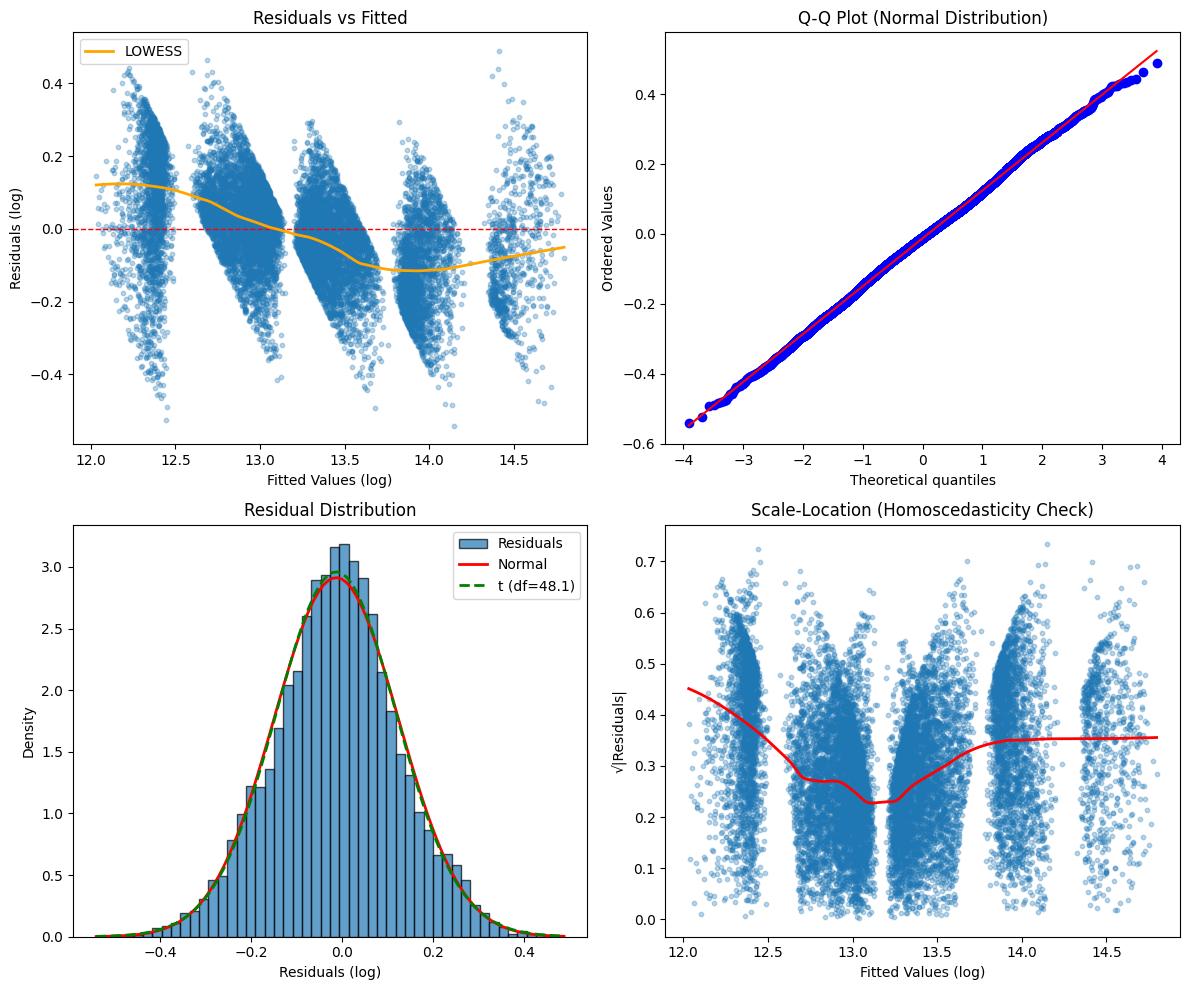


  ✓ Saved to figures/residual_diagnostics.png


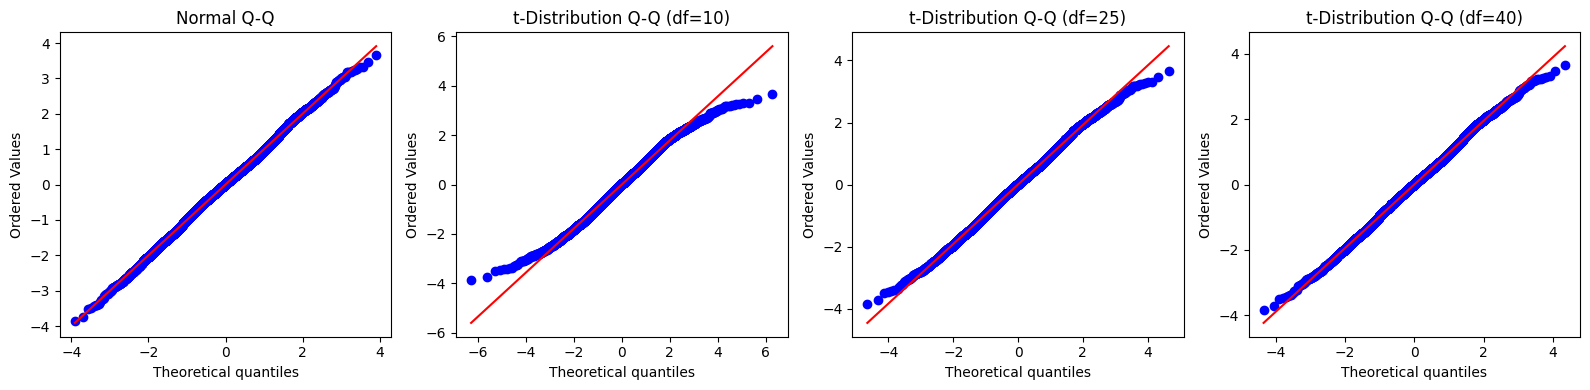

  ✓ Saved to figures/qq_t_distribution.png

------------------------------------------------------------
 BY SEGMENT ANALYSIS
------------------------------------------------------------

  Segment           Mean Resid        Std       Skew
  -----------------------------------------------
  Seg1_0-15            0.08257     0.1718     -0.776
  Seg2_15-50           0.02667     0.1043     -0.205
  Seg3_50-80          -0.04477     0.1018     -0.102
  Seg4_80-95          -0.11404     0.1233      0.210
  Seg5_95-100         -0.07001     0.1560      0.504
  ✓ Saved: v2_statistical_results/residual_diagnostics.joblib


In [512]:
# Run residual diagnostics
residual_results = run_residual_diagnostics(option_num=5)
save_statistical_result(residual_results, 'residual_diagnostics')

## Statistical test 6: Finding a close distributional fit

In [513]:
from scipy import stats as sp_stats


def find_best_distribution(residuals: np.ndarray, 
                           candidates: list = None,
                           plot: bool = True) -> dict:
    """
    Find best-fitting distribution for residuals using AIC/BIC comparison.
    
    Parameters
    ----------
    residuals : np.ndarray
        Residual values (log-scale recommended).
    candidates : list, optional
        Distribution names to test. Defaults to common heavy-tailed distributions.
    plot : bool
        Whether to plot comparison figures.
    
    Returns
    -------
    dict
        Ranked results with fitted parameters and fit metrics.
    """
    if candidates is None:
        candidates = [
            'norm', 't', 'laplace', 'logistic', 'cauchy',
            'nct', 'gennorm', 'hypsecant', 'johnsonsu'
        ]
    
    n = len(residuals)
    results = []
    
    print("\n" + "=" * 60)
    print(" DISTRIBUTION FITTING ANALYSIS")
    print("=" * 60)
    print(f"\n  Testing {len(candidates)} distributions on {n:,} residuals...")
    
    for dist_name in candidates:
        try:
            dist = getattr(sp_stats, dist_name)
            params = dist.fit(residuals)
            
            # Log-likelihood
            loglik = np.sum(dist.logpdf(residuals, *params))
            
            # Number of parameters
            k = len(params)
            
            # AIC and BIC (lower = better)
            aic = 2 * k - 2 * loglik
            bic = k * np.log(n) - 2 * loglik
            
            # KS test for goodness-of-fit
            ks_stat, ks_p = sp_stats.kstest(residuals, dist_name, args=params)
            
            # Anderson-Darling where available
            try:
                ad_result = sp_stats.anderson(residuals, dist_name)
                ad_stat = ad_result.statistic
            except:
                ad_stat = np.nan
            
            results.append({
                'distribution': dist_name,
                'params': params,
                'n_params': k,
                'loglik': loglik,
                'aic': aic,
                'bic': bic,
                'ks_stat': ks_stat,
                'ks_p': ks_p,
                'ad_stat': ad_stat
            })
        except Exception as e:
            print(f"  ⚠ {dist_name}: {e}")
    
    # Rank by AIC
    results = sorted(results, key=lambda x: x['aic'])
    
    # Print results table
    print(f"\n  {'Rank':<5} {'Distribution':<12} {'AIC':>12} {'BIC':>12} {'KS p-val':>10}")
    print("  " + "-" * 51)
    
    for i, r in enumerate(results[:10], 1):
        ks_str = f"{r['ks_p']:.4f}" if r['ks_p'] > 0.0001 else f"{r['ks_p']:.2e}"
        print(f"  {i:<5} {r['distribution']:<12} {r['aic']:>12.1f} {r['bic']:>12.1f} {ks_str:>10}")
    
    best = results[0]
    print(f"\n  ✓ Best fit: {best['distribution']} (AIC={best['aic']:.1f})")
    
    # Print best distribution parameters
    print(f"\n  {best['distribution']} parameters:")
    dist = getattr(sp_stats, best['distribution'])
    param_names = _get_param_names(best['distribution'], best['params'])
    for name, val in zip(param_names, best['params']):
        print(f"    {name}: {val:.4f}")
    
    # Interpretation
    print("\n" + "-" * 60)
    print(" INTERPRETATION")
    print("-" * 60)
    _interpret_distribution(best, results)
    
    if plot:
        _plot_distribution_comparison(residuals, results[:4])
    
    return {
        'best': best,
        'rankings': results,
        'residuals': residuals
    }


def _get_param_names(dist_name: str, params: tuple) -> list:
    """Get parameter names for common distributions."""
    names = {
        'norm': ['loc', 'scale'],
        't': ['df', 'loc', 'scale'],
        'laplace': ['loc', 'scale'],
        'logistic': ['loc', 'scale'],
        'cauchy': ['loc', 'scale'],
        'nct': ['df', 'nc', 'loc', 'scale'],
        'gennorm': ['beta', 'loc', 'scale'],
        'hypsecant': ['loc', 'scale'],
        'johnsonsu': ['a', 'b', 'loc', 'scale']
    }
    return names.get(dist_name, [f'param{i}' for i in range(len(params))])


def _interpret_distribution(best: dict, results: list) -> None:
    """Print interpretation of the best-fitting distribution."""
    dist_name = best['distribution']
    
    interpretations = {
        't': "  → Heavy tails: extreme values more likely than normal.\n"
             "     df parameter indicates tail heaviness (lower = heavier).",
        'laplace': "  → Double-exponential: sharp peak, heavier tails than normal.\n"
                   "     Common in financial data with sudden jumps.",
        'nct': "  → Non-central t: heavy tails + asymmetry.\n"
               "     nc parameter captures skewness direction.",
        'gennorm': "  → Generalized normal: beta controls tail behavior.\n"
                   "     beta<2: heavier tails, beta>2: lighter tails than normal.",
        'johnsonsu': "  → Johnson SU: flexible for both skewness and kurtosis.\n"
                     "     Often best for complex real-world data.",
        'logistic': "  → Logistic: slightly heavier tails than normal.\n"
                    "     Similar shape but more probability in extremes.",
        'hypsecant': "  → Hyperbolic secant: moderate tails, symmetric.\n"
                     "     Between normal and Laplace.",
        'norm': "  → Normal distribution fits well.\n"
                "     Standard assumptions hold for this data.",
        'cauchy': "  → Cauchy: extremely heavy tails (no finite variance).\n"
                  "     Suggests outliers dominate; consider robust methods."
    }
    
    print(interpretations.get(dist_name, f"  → {dist_name} distribution."))
    
    # Compare with normal
    norm_result = next((r for r in results if r['distribution'] == 'norm'), None)
    if norm_result and dist_name != 'norm':
        aic_diff = norm_result['aic'] - best['aic']
        print(f"\n  AIC improvement over normal: {aic_diff:.1f}")
        if aic_diff > 10:
            print("  → Strong evidence against normality assumption.")
        elif aic_diff > 4:
            print("  → Moderate evidence against normality.")
        else:
            print("  → Weak preference; normal may be acceptable.")


def _plot_distribution_comparison(residuals: np.ndarray, top_results: list) -> None:
    """Plot comparison of top distributions."""
    import matplotlib.pyplot as plt
    
    n_dists = len(top_results)
    fig, axes = plt.subplots(2, n_dists, figsize=(4 * n_dists, 8))
    
    x = np.linspace(residuals.min() - 0.5, residuals.max() + 0.5, 200)
    resid_std = (residuals - residuals.mean()) / residuals.std()
    
    for i, r in enumerate(top_results):
        dist = getattr(sp_stats, r['distribution'])
        
        # Top row: PDF comparison
        ax = axes[0, i]
        ax.hist(residuals, bins=50, density=True, alpha=0.6, color='steelblue', edgecolor='white')
        ax.plot(x, dist.pdf(x, *r['params']), 'r-', lw=2)
        ax.set_title(f"{r['distribution']}\nAIC={r['aic']:.0f}")
        ax.set_xlabel('Residual (log)')
        ax.set_ylabel('Density' if i == 0 else '')
        
        # Bottom row: Q-Q plot
        ax = axes[1, i]
        sp_stats.probplot(residuals, dist=dist, sparams=r['params'][:-2], plot=ax)
        ax.set_title(f"Q-Q: {r['distribution']}")
    
    plt.tight_layout()
    (PROJECT_ROOT / 'figures').mkdir(exist_ok=True)
    plt.savefig(PROJECT_ROOT / 'figures' / 'distribution_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n  ✓ Saved to figures/distribution_comparison.png")


 DISTRIBUTION FITTING ANALYSIS

  Testing 9 distributions on 15,118 residuals...

  Rank  Distribution          AIC          BIC   KS p-val
  ---------------------------------------------------
  1     gennorm          -17241.3     -17218.4     0.1488
  2     johnsonsu        -17214.1     -17183.7     0.0048
  3     nct              -17213.7     -17183.2     0.0040
  4     t                -17213.5     -17190.6     0.0083
  5     norm             -17207.7     -17192.4     0.0008
  6     logistic         -17065.1     -17049.9     0.0057
  7     hypsecant        -16837.3     -16822.0   4.31e-05
  8     laplace          -16213.9     -16198.6   1.09e-17
  9     cauchy           -12325.5     -12310.2   8.85e-65

  ✓ Best fit: gennorm (AIC=-17241.3)

  gennorm parameters:
    beta: 1.7904
    loc: -0.0120
    scale: 0.1818

------------------------------------------------------------
 INTERPRETATION
------------------------------------------------------------
  → Generalized normal: beta co

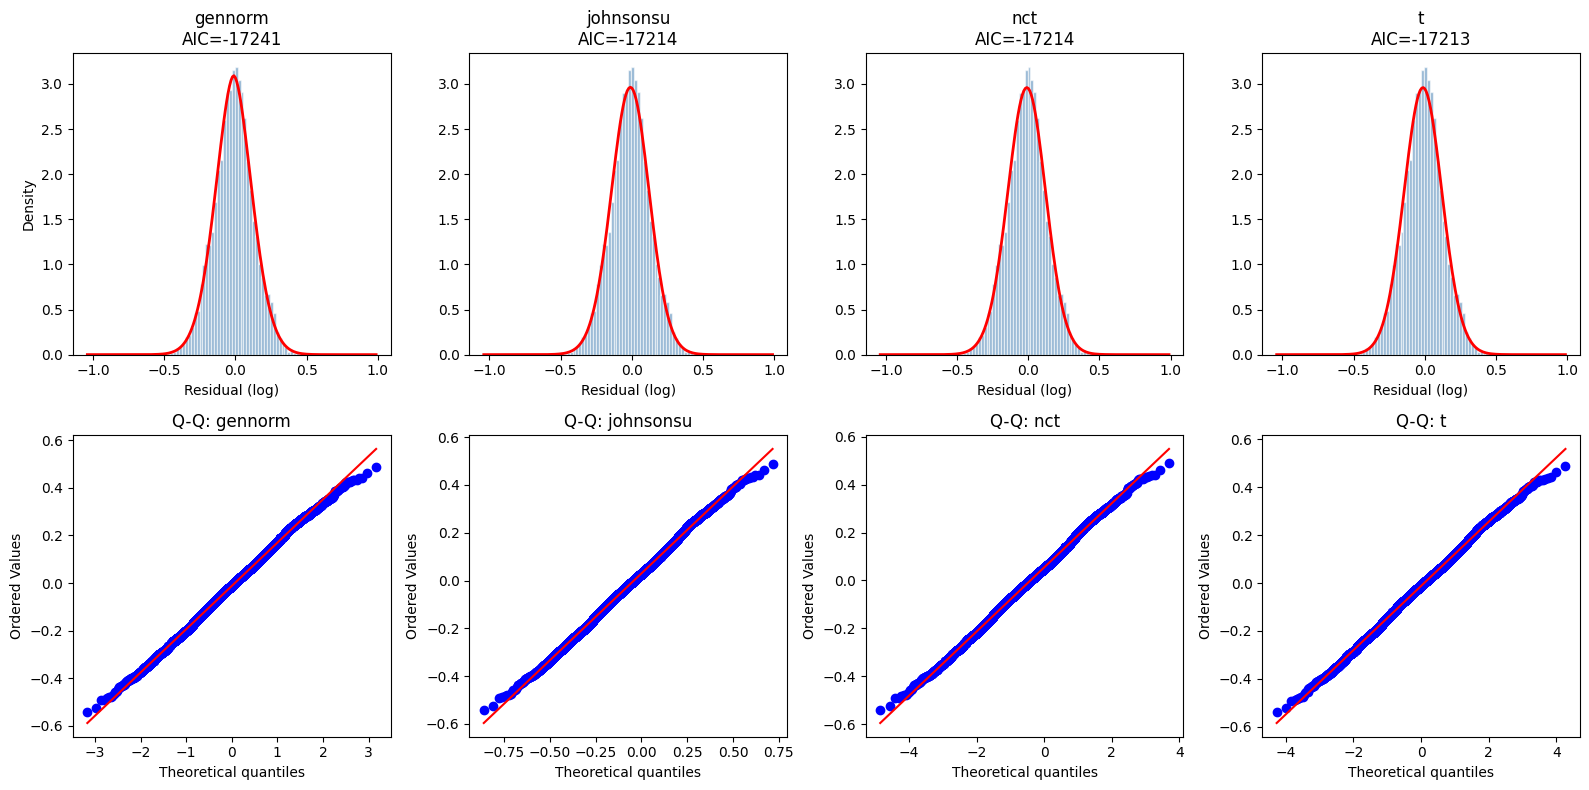


  ✓ Saved to figures/distribution_comparison.png
  ✓ Saved: v2_statistical_results/residuals.joblib
  ✓ Saved: v2_statistical_results/closest_distribution.joblib


In [514]:
# Using the residual_results from run_residual_diagnostics()
residuals = residual_results['resid_df']['residual_log'].values

dist_results = find_best_distribution(residuals)

save_statistical_result(residuals, 'residuals')
save_statistical_result(dist_results, 'closest_distribution')

## Statistical test 6: Learning Curve Analysis

In [515]:
LEARNING_CURVE_CONFIG = {
    'train_sizes': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
    'random_state': CONFIG['random_state'],
}

In [516]:
def compute_learning_curve(train_df: pd.DataFrame, val_df: pd.DataFrame, 
                           test_df: pd.DataFrame, model_info: dict,
                           train_sizes: list = None) -> dict:
    """Compute learning curve for a single segment with train/val/test."""
    if train_sizes is None:
        train_sizes = LEARNING_CURVE_CONFIG['train_sizes']
    
    num_cfg = model_info.get('num_config', 'interactions')
    cat_cfg = model_info.get('cat_config', 'all_cat')
    model_name = model_info['model_name']
    
    # Prepare fixed val/test sets
    val_eng, num_cols, cat_cols = apply_feature_engineering(val_df.copy(), num_cfg, cat_cfg)
    test_eng, _, _ = apply_feature_engineering(test_df.copy(), num_cfg, cat_cfg)
    feature_cols = num_cols + cat_cols
    
    X_val, y_val = val_eng[feature_cols].copy(), val_eng[TARGET].values
    X_test, y_test = test_eng[feature_cols].copy(), test_eng[TARGET].values
    
    if model_name == 'LightGBM':
        for c in cat_cols:
            X_val[c], X_test[c] = X_val[c].astype('category'), X_test[c].astype('category')
    
    results = {'train_sizes_frac': [], 'train_sizes_n': [],
               'train_mape': [], 'val_mape': [], 'test_mape': []}
    
    for frac in train_sizes:
        n_samples = int(len(train_df) * frac)
        if n_samples < 50:
            continue
        
        train_sample = train_df.sample(n=n_samples, random_state=CONFIG['random_state'])
        train_eng, _, _ = apply_feature_engineering(train_sample.copy(), num_cfg, cat_cfg)
        X_train, y_train = train_eng[feature_cols].copy(), train_eng[TARGET].values
        
        # Train model
        if model_name == 'LightGBM':
            for c in cat_cols:
                X_train[c] = X_train[c].astype('category')
            model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=8,
                                      random_state=CONFIG['random_state'], verbose=-1)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                      callbacks=[lgb.early_stopping(50, verbose=False)])
            X_val_pred, X_test_pred = X_val, X_test
        elif model_name == 'CatBoost':
            model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=8,
                                      random_seed=CONFIG['random_state'], verbose=False)
            cat_idx = [feature_cols.index(c) for c in cat_cols]
            model.fit(X_train, y_train, eval_set=(X_val, y_val),
                      cat_features=cat_idx, early_stopping_rounds=50)
            X_val_pred, X_test_pred = X_val, X_test
        elif model_name == 'XGBoost':
            encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            X_train = np.hstack([X_train[num_cols].values, encoder.fit_transform(X_train[cat_cols])])
            X_val_pred = np.hstack([X_val[num_cols].values, encoder.transform(X_val[cat_cols])])
            X_test_pred = np.hstack([X_test[num_cols].values, encoder.transform(X_test[cat_cols])])
            model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8,
                                     random_state=CONFIG['random_state'], verbosity=0,
                                     early_stopping_rounds=50)
            model.fit(X_train, y_train, eval_set=[(X_val_pred, y_val)], verbose=False)
        
        # Compute MAPE for all three sets
        def mape(y_true, y_pred):
            return np.mean(np.abs((np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true))) * 100
        
        results['train_sizes_frac'].append(frac)
        results['train_sizes_n'].append(n_samples)
        results['train_mape'].append(mape(y_train, model.predict(X_train)))
        results['val_mape'].append(mape(y_val, model.predict(X_val_pred)))
        results['test_mape'].append(mape(y_test, model.predict(X_test_pred)))
    
    return results


def plot_learning_curves(curves: dict) -> None:
    """Plot learning curves with train/val/test for all segments."""
    import matplotlib.pyplot as plt
    
    n_segs = len(curves)
    cols = min(3, n_segs)
    rows = (n_segs + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = [axes] if n_segs == 1 else axes.flatten()
    
    for idx, (seg_key, data) in enumerate(curves.items()):
        ax = axes[idx]
        n = data['train_sizes_n']
        
        ax.plot(n, data['train_mape'], 'o-', label='Train', color='#2ecc71', lw=2)
        ax.plot(n, data['val_mape'], 's-', label='Val', color='#3498db', lw=2)
        ax.plot(n, data['test_mape'], '^-', label='Test', color='#e74c3c', lw=2)
        
        ax.fill_between(n, data['train_mape'], data['val_mape'], alpha=0.15, color='gray')
        ax.set_xlabel('Training Set Size')
        ax.set_ylabel('MAPE (%)')
        ax.set_title(seg_key)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Annotate final gaps
        val_gap = data['val_mape'][-1] - data['train_mape'][-1]
        test_gap = data['test_mape'][-1] - data['train_mape'][-1]
        ax.annotate(f'Val gap: {val_gap:.1f}%\nTest gap: {test_gap:.1f}%',
                    xy=(0.98, 0.5), xycoords='axes fraction', ha='right', fontsize=8)
    
    for idx in range(n_segs, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    (PROJECT_ROOT / 'figures').mkdir(exist_ok=True)
    plt.savefig(PROJECT_ROOT / 'figures' / 'learning_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n  ✓ Saved to figures/learning_curves.png")


def run_learning_curve_analysis(option_num: int = 5) -> dict:
    """Run learning curve analysis for all segments with train/val/test."""
    print("=" * 60)
    print(f" LEARNING CURVE ANALYSIS - OPTION {option_num}")
    print("=" * 60)
    print(f"\n  Train size fractions: {LEARNING_CURVE_CONFIG['train_sizes']}")
    
    v = EVAL_CONFIG['model_version']
    models_dir = PREDICTOR_CONFIG['models_dir']
    all_curves = {}
    
    for seg_key in SEGMENT_KEYS[option_num]:
        print(f"\n  [{seg_key}] Computing learning curve...")
        model_info = joblib.load(models_dir / f'tuned_{v}_option{option_num}_{seg_key}.joblib')
        train_df, val_df, test_df = SEGMENT_DATA[option_num][seg_key]
        
        curve = compute_learning_curve(train_df, val_df, test_df, model_info)
        all_curves[seg_key] = curve
        
        print(f"    ✓ Train: {curve['train_mape'][-1]:.1f}% | Val: {curve['val_mape'][-1]:.1f}% | Test: {curve['test_mape'][-1]:.1f}%")
    
    # Summary table
    print("\n" + "-" * 60)
    print(" LEARNING CURVE SUMMARY")
    print("-" * 60)
    print(f"\n  {'Segment':<15} {'Train':>8} {'Val':>8} {'Test':>8} {'Val Gap':>9} {'Test Gap':>10}")
    print("  " + "-" * 58)
    
    for seg_key, c in all_curves.items():
        tr, va, te = c['train_mape'][-1], c['val_mape'][-1], c['test_mape'][-1]
        print(f"  {seg_key:<15} {tr:>7.1f}% {va:>7.1f}% {te:>7.1f}% {va-tr:>8.1f}% {te-tr:>9.1f}%")
    
    # Interpretation
    avg_val_gap = np.mean([c['val_mape'][-1] - c['train_mape'][-1] for c in all_curves.values()])
    avg_test_gap = np.mean([c['test_mape'][-1] - c['train_mape'][-1] for c in all_curves.values()])
    avg_test_mape = np.mean([c['test_mape'][-1] for c in all_curves.values()])
    
    print("\n" + "-" * 60)
    print(" INTERPRETATION")
    print("-" * 60)
    print(f"\n  Avg Val Gap:  {avg_val_gap:.1f}%")
    print(f"  Avg Test Gap: {avg_test_gap:.1f}%")
    print(f"  Avg Test MAPE: {avg_test_mape:.1f}%")
    
    # Generalization assessment
    if avg_test_gap < 3:
        print("\n  ✓✓ EXCELLENT: Models generalize very well to unseen data")
    elif avg_test_gap < 6:
        print("\n  ✓ GOOD: Reasonable generalization")
    elif avg_test_gap < 10:
        print("\n  ~ MODERATE: Some overfitting present")
    else:
        print("\n  ⚠ HIGH VARIANCE: Significant overfitting")
    
    # Val vs Test consistency
    val_test_diff = abs(avg_val_gap - avg_test_gap)
    if val_test_diff < 1:
        print("  ✓ Val/Test gaps consistent — validation set representative")
    elif val_test_diff < 3:
        print("  ~ Val/Test gaps slightly differ — minor distribution shift possible")
    else:
        print("  ⚠ Val/Test gaps diverge — check for data leakage or distribution shift")
    
    print("\n" + "-" * 60)
    print(" LEARNING CURVE PLOTS")
    print("-" * 60)
    plot_learning_curves(all_curves)
    
    return all_curves

 LEARNING CURVE ANALYSIS - OPTION 5

  Train size fractions: [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

  [Seg1_0-15] Computing learning curve...
    ✓ Train: 11.4% | Val: 12.6% | Test: 13.6%

  [Seg2_15-50] Computing learning curve...
    ✓ Train: 7.6% | Val: 8.0% | Test: 8.0%

  [Seg3_50-80] Computing learning curve...
    ✓ Train: 7.4% | Val: 7.5% | Test: 7.7%

  [Seg4_80-95] Computing learning curve...
    ✓ Train: 8.9% | Val: 9.3% | Test: 9.3%

  [Seg5_95-100] Computing learning curve...
    ✓ Train: 11.6% | Val: 12.3% | Test: 12.2%

------------------------------------------------------------
 LEARNING CURVE SUMMARY
------------------------------------------------------------

  Segment            Train      Val     Test   Val Gap   Test Gap
  ----------------------------------------------------------
  Seg1_0-15          11.4%    12.6%    13.6%      1.2%       2.2%
  Seg2_15-50          7.6%     8.0%     8.0%      0.4%       0.4%
  Seg3_50-80          7.4%     7.5%     7.7%      0.2%      

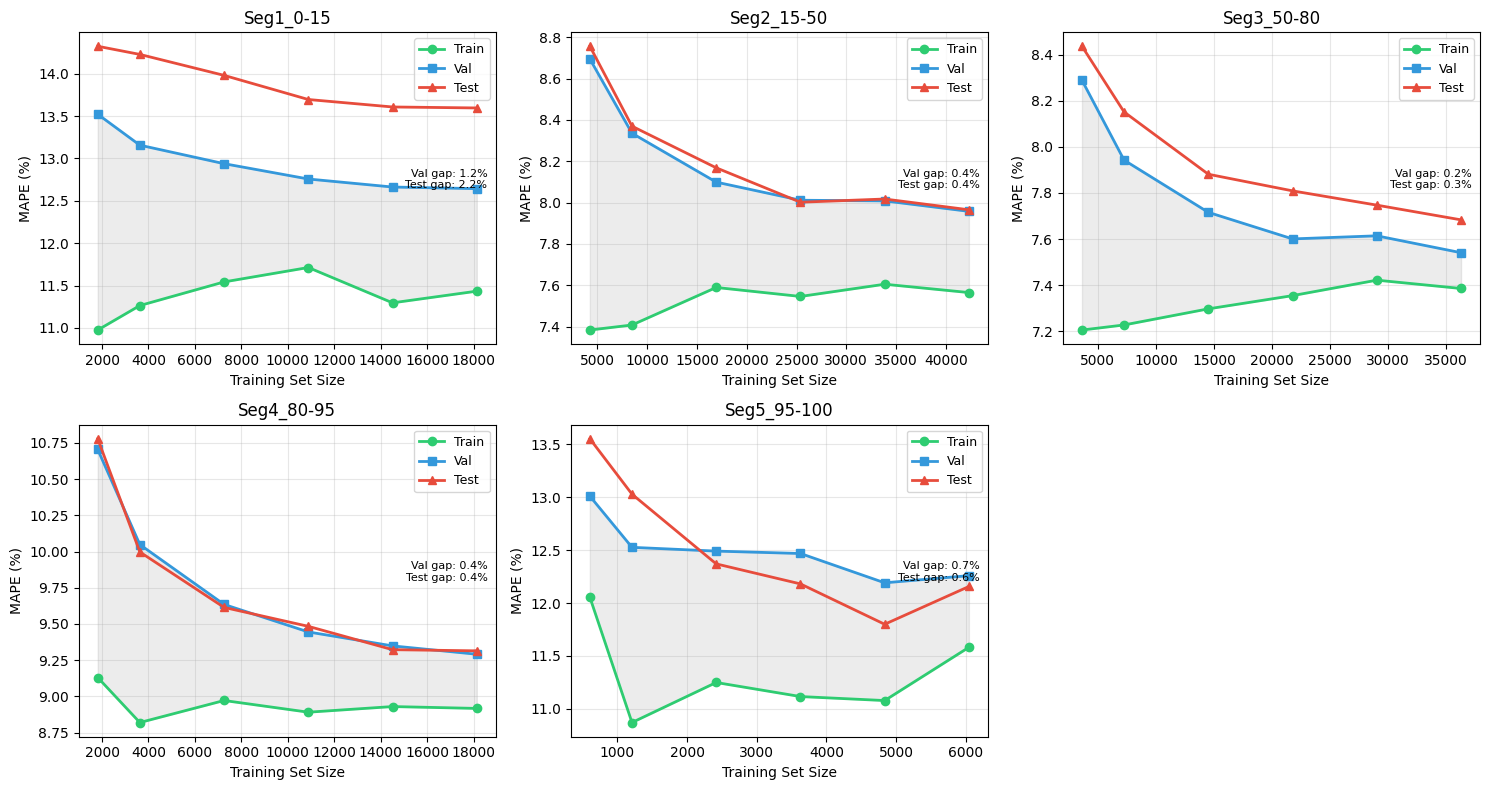


  ✓ Saved to figures/learning_curves.png
  ✓ Saved: v2_statistical_results/learning_curves_opt_5.joblib


In [517]:
# Run learning curve analysis
learning_curves = run_learning_curve_analysis(option_num=5)
save_statistical_result(learning_curves, 'learning_curves_opt_5')

 LEARNING CURVE ANALYSIS - OPTION 3

  Train size fractions: [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

  [Lower_0-10] Computing learning curve...
    ✓ Train: 11.5% | Val: 12.1% | Test: 13.0%

  [Middle_10-90] Computing learning curve...
    ✓ Train: 11.3% | Val: 11.5% | Test: 11.7%

  [Upper_90-100] Computing learning curve...
    ✓ Train: 11.6% | Val: 12.8% | Test: 12.6%

------------------------------------------------------------
 LEARNING CURVE SUMMARY
------------------------------------------------------------

  Segment            Train      Val     Test   Val Gap   Test Gap
  ----------------------------------------------------------
  Lower_0-10         11.5%    12.1%    13.0%      0.6%       1.5%
  Middle_10-90       11.3%    11.5%    11.7%      0.2%       0.4%
  Upper_90-100       11.6%    12.8%    12.6%      1.2%       1.0%

------------------------------------------------------------
 INTERPRETATION
------------------------------------------------------------

  Avg Val Gap:  0.7%


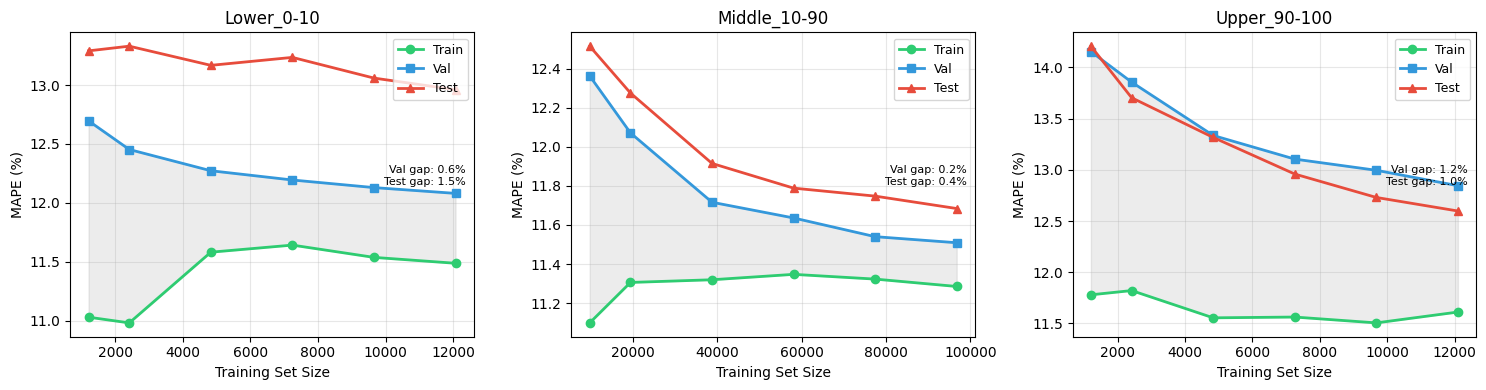


  ✓ Saved to figures/learning_curves.png
  ✓ Saved: v2_statistical_results/learning_curves_opt_3.joblib


In [518]:
# Run learning curve analysis
learning_curves = run_learning_curve_analysis(option_num=3)
save_statistical_result(learning_curves, 'learning_curves_opt_3')

# Section 13: Conformal Prediction

In [519]:
CONFORMAL_CONFIG = {
    'coverage': 0.80,           # Default 80% coverage
    'min_samples': 10,          # Minimum samples per segment
    'model_version': CONFIG['model_version'],
    'calibration_option': 5,    # Which option's test sets to use
}

In [520]:
def calibrate_conformal(coverage: float = None) -> dict:
    """
    Calibrate conformal prediction using segment-specific test sets.
    
    Parameters
    ----------
    coverage : float, optional
        Desired coverage level (default from config).
    
    Returns
    -------
    dict
        Error thresholds per segment.
    """
    coverage = coverage or CONFORMAL_CONFIG['coverage']
    opt = CONFORMAL_CONFIG['calibration_option']
    
    print("=" * 60)
    print(" CALIBRATING ADAPTIVE CONFORMAL PREDICTION")
    print("=" * 60)
    print(f"  Coverage: {coverage*100:.0f}%")
    print(f"  Using Option {opt} test sets")
    
    segment_errors = {seg: [] for seg in SEGMENT_KEYS[opt]}
    segment_prices = {seg: [] for seg in SEGMENT_KEYS[opt]}
    
    # Process each segment's test set
    for seg_key in SEGMENT_KEYS[opt]:
        _, _, test_df = SEGMENT_DATA[opt][seg_key]
        n = len(test_df)
        print(f"\n  [{seg_key}] Processing {n} samples...", end=" ")
        
        processed = 0
        for _, row in test_df.iterrows():
            try:
                input_df = prepare_input(
                    postcode_sector=row['POSTCODE_SECTOR'], old_new=row['OLD/NEW'],
                    tenure_type=row['TENURE_TYPE'], property_type=row['PROPERTY_TYPE'],
                    built_form=row['BUILT_FORM'], total_floor_area=row['TOTAL_FLOOR_AREA'],
                    local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
                    number_bedrooms=row['NUMBER_BEDROOMS'],
                    number_bathrooms=row['NUMBER_BATHROOMS'],
                    current_energy_rating=row['CURRENT_ENERGY_RATING'])
                
                preds = predict_all_options(input_df)
                predicted = np.mean(list(preds.values()))
                actual = np.exp(row[TARGET])
                
                segment_errors[seg_key].append(abs(actual - predicted))
                segment_prices[seg_key].append(actual)
                processed += 1
            except:
                continue
        
        print(f"✓ ({processed}/{n})")
    
    # Calculate thresholds
    conformal_thresholds = {}
    percentile = coverage * 100
    
    print(f"\n  {'Segment':<15} {'n':>6} {'Threshold':>12} {'As %':>8}")
    print("  " + "-" * 45)
    
    # Global fallback
    all_errors = [e for errs in segment_errors.values() for e in errs]
    global_threshold = np.percentile(all_errors, percentile) if all_errors else 0
    
    for seg, errors in segment_errors.items():
        median_price = np.median(segment_prices[seg]) if segment_prices[seg] else 0
        
        if len(errors) >= CONFORMAL_CONFIG['min_samples']:
            threshold = np.percentile(errors, percentile)
            pct = (threshold / median_price * 100) if median_price > 0 else 0
            
            conformal_thresholds[seg] = {
                'threshold': threshold,
                'n_samples': len(errors),
                'median_error': np.median(errors),
                'mean_error': np.mean(errors),
                'pct_of_median': pct,
                'fallback': False,
            }
            print(f"  {seg:<15} {len(errors):>6} £{threshold:>10,.0f} {pct:>7.1f}%")
        else:
            conformal_thresholds[seg] = {
                'threshold': global_threshold,
                'n_samples': len(errors),
                'fallback': True,
            }
            print(f"  {seg:<15} {len(errors):>6} {'(fallback)':>12}")
    
    conformal_thresholds['_meta'] = {
        'coverage': coverage,
        'option': opt,
        'model_version': CONFORMAL_CONFIG['model_version'],
        'global_threshold': global_threshold,
    }
    
    print("\n" + "=" * 60)
    print(f" CALIBRATION COMPLETE")
    print("=" * 60)
    
    return conformal_thresholds

In [521]:
def save_conformal_thresholds(thresholds: dict) -> None:
    """Save calibrated thresholds to disk."""
    v = CONFORMAL_CONFIG['model_version']
    path = PREDICTOR_CONFIG['models_dir'] / f'conformal_thresholds_{v}.joblib'
    joblib.dump(thresholds, path)
    print(f"  ✓ Saved: {path.name}")


def load_conformal_thresholds() -> dict:
    """Load calibrated thresholds from disk."""
    v = CONFORMAL_CONFIG['model_version']
    path = PREDICTOR_CONFIG['models_dir'] / f'conformal_thresholds_{v}.joblib'
    if path.exists():
        thresholds = joblib.load(path)
        print(f"  ✓ Loaded: {path.name}")
        return thresholds
    print(f"  ⚠ Not found: {path.name}")
    return None

In [522]:
def predict_with_conformal(input_df: pd.DataFrame, conformal_thresholds: dict) -> dict:
    """
    Get prediction with calibrated conformal interval.
    
    Parameters
    ----------
    input_df : pd.DataFrame
        Single-row input from prepare_input().
    conformal_thresholds : dict
        Calibrated thresholds from calibrate_conformal().
        
    Returns
    -------
    dict
        Prediction with interval bounds.
    """
    preds = predict_all_options(input_df)
    point_est = np.mean(list(preds.values()))
    
    # Route to segment using Option 5 boundaries
    segment = get_segment_key(point_est, 5, PERCENTILES)
    
    # Get threshold
    thresh_info = conformal_thresholds.get(segment, {})
    threshold = thresh_info.get('threshold', conformal_thresholds.get('_meta', {}).get('global_threshold', 0))
    coverage = conformal_thresholds.get('_meta', {}).get('coverage', CONFORMAL_CONFIG['coverage'])
    
    return {
        'point_estimate': point_est,
        'conformal_lower': max(0, point_est - threshold),
        'conformal_upper': point_est + threshold,
        'conformal_threshold': threshold,
        'threshold_pct': (threshold / point_est * 100) if point_est > 0 else 0,
        'segment': segment,
        'coverage': coverage,
        'all_predictions': preds,
        'is_fallback': thresh_info.get('fallback', False),
    }

In [523]:
def display_conformal_prediction(postcode_sector: str, old_new: str, tenure_type: str,
                                  property_type: str, built_form: str, total_floor_area: float,
                                  local_authority_label: str, number_bedrooms: int,
                                  number_bathrooms: int, current_energy_rating: str,
                                  conformal_thresholds: dict, listing_price: float = None) -> dict:
    """Display prediction with conformal interval."""
    input_df = prepare_input(
        postcode_sector=postcode_sector, old_new=old_new, tenure_type=tenure_type,
        property_type=property_type, built_form=built_form,
        total_floor_area=total_floor_area, local_authority_label=local_authority_label,
        number_bedrooms=number_bedrooms, number_bathrooms=number_bathrooms,
        current_energy_rating=current_energy_rating)
    
    result = predict_with_conformal(input_df, conformal_thresholds)
    
    print("=" * 60)
    print(" CONFORMAL PREDICTION")
    print("=" * 60)
    
    print(f"\n  📍 {postcode_sector}, {local_authority_label}")
    print(f"  🏠 {property_type} ({built_form}) | {total_floor_area}m²")
    print(f"     {number_bedrooms} bed | {number_bathrooms} bath | Energy {current_energy_rating}")
    
    print("\n" + "-" * 60)
    print(f"  Point Estimate:     £{result['point_estimate']:>12,.0f}")
    print(f"  {result['coverage']*100:.0f}% Interval:       £{result['conformal_lower']:>12,.0f} — £{result['conformal_upper']:,.0f}")
    print(f"  Interval Width:     ±{result['threshold_pct']:.1f}% (±£{result['conformal_threshold']:,.0f})")
    print(f"  Segment:            {result['segment']}")
    if result['is_fallback']:
        print(f"  ⚠ Using global fallback threshold")
    print("-" * 60)
    
    if listing_price is not None:
        print(f"\n  Listing Price:      £{listing_price:>12,.0f}")
        
        if result['conformal_lower'] <= listing_price <= result['conformal_upper']:
            print(f"  ✓ Listing is WITHIN the {result['coverage']*100:.0f}% prediction interval")
        elif listing_price < result['conformal_lower']:
            below = result['conformal_lower'] - listing_price
            print(f"  💡 Listing is BELOW interval by £{below:,.0f}")
        else:
            above = listing_price - result['conformal_upper']
            print(f"  ⚠️  Listing is ABOVE interval by £{above:,.0f}")
    
    print("\n" + "=" * 60)
    return result

In [524]:
def validate_conformal_coverage(test_df: pd.DataFrame, conformal_thresholds: dict,
                                 sample_size: int = None) -> dict:
    """
    Validate actual coverage on test data.
    
    Returns
    -------
    dict
        Coverage statistics per segment.
    """
    sample = test_df.sample(n=min(sample_size, len(test_df)), random_state=CONFIG['random_state']) \
             if sample_size else test_df
    
    print(f"Validating coverage on {len(sample)} samples...")
    
    results = {seg: {'in_interval': 0, 'total': 0} for seg in SEGMENT_KEYS[5]}
    
    for _, row in sample.iterrows():
        try:
            input_df = prepare_input(
                postcode_sector=row['POSTCODE_SECTOR'], old_new=row['OLD/NEW'],
                tenure_type=row['TENURE_TYPE'], property_type=row['PROPERTY_TYPE'],
                built_form=row['BUILT_FORM'], total_floor_area=row['TOTAL_FLOOR_AREA'],
                local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
                number_bedrooms=row['NUMBER_BEDROOMS'],
                number_bathrooms=row['NUMBER_BATHROOMS'],
                current_energy_rating=row['CURRENT_ENERGY_RATING'])
            
            conf = predict_with_conformal(input_df, conformal_thresholds)
            actual = np.exp(row[TARGET])
            seg = conf['segment']
            
            results[seg]['total'] += 1
            if conf['conformal_lower'] <= actual <= conf['conformal_upper']:
                results[seg]['in_interval'] += 1
        except:
            continue
    
    target = conformal_thresholds.get('_meta', {}).get('coverage', 0.80) * 100
    
    print(f"\n  {'Segment':<15} {'Coverage':>10} {'Target':>10} {'n':>8}")
    print("  " + "-" * 45)
    
    total_in, total_n = 0, 0
    for seg, r in results.items():
        if r['total'] > 0:
            cov = r['in_interval'] / r['total'] * 100
            status = "✓" if cov >= target - 5 else "⚠"
            print(f"  {seg:<15} {cov:>9.1f}% {target:>9.0f}% {r['total']:>8} {status}")
            total_in += r['in_interval']
            total_n += r['total']
    
    overall = total_in / total_n * 100 if total_n > 0 else 0
    print("  " + "-" * 45)
    print(f"  {'OVERALL':<15} {overall:>9.1f}% {target:>9.0f}% {total_n:>8}")
    
    return results

In [525]:
print("=" * 60)
print(" CONFORMAL PREDICTION SETUP")
print("=" * 60)

# Try to load existing thresholds
conformal_thresholds = load_conformal_thresholds()

if conformal_thresholds is None:
    print("\n  Calibrating new thresholds...")
    conformal_thresholds = calibrate_conformal()
    save_conformal_thresholds(conformal_thresholds)

print("\n  ✓ Conformal prediction ready")

 CONFORMAL PREDICTION SETUP
  ✓ Loaded: conformal_thresholds_v2.joblib

  ✓ Conformal prediction ready


In [526]:
display_conformal_prediction(
    postcode_sector='HA4 8',
    old_new='O',
    tenure_type='F',
    property_type='House',
    built_form='Detached',
    total_floor_area=317,
    local_authority_label='Hillingdon',
    number_bedrooms=6,
    number_bathrooms=4,
    current_energy_rating='C',
    conformal_thresholds=conformal_thresholds,
    listing_price=1650000
)

 CONFORMAL PREDICTION

  📍 HA4 8, Hillingdon
  🏠 House (Detached) | 317m²
     6 bed | 4 bath | Energy C

------------------------------------------------------------
  Point Estimate:     £   1,789,532
  80% Interval:       £   1,253,875 — £2,325,188
  Interval Width:     ±29.9% (±£535,656)
  Segment:            Seg5_95-100
------------------------------------------------------------

  Listing Price:      £   1,650,000
  ✓ Listing is WITHIN the 80% prediction interval



{'point_estimate': np.float64(1789531.696686325),
 'conformal_lower': np.float64(1253875.4735111345),
 'conformal_upper': np.float64(2325187.919861515),
 'conformal_threshold': np.float64(535656.2231751904),
 'threshold_pct': np.float64(29.932759736363696),
 'segment': 'Seg5_95-100',
 'coverage': 0.8,
 'all_predictions': {'Option 1 - Vanilla': 1816569.4572890247,
  'Option 2 - Stratified': 1811063.7613273677,
  'Option 3 - 3 Seg (10/80/10)': 1704908.4408970126,
  'Option 4 - 3 Seg (20/60/20)': 1636421.2072505048,
  'Option 5 - 5 Segments': 1978695.616667715},
 'is_fallback': False}

## Validating Conformal Coverage

In [527]:
def validate_all_options_coverage(conformal_thresholds: dict, sample_size: int = 500) -> pd.DataFrame:
    """
    Validate conformal coverage across all options and segments.
    
    Returns
    -------
    pd.DataFrame
        Coverage results for all options/segments.
    """
    target_coverage = conformal_thresholds.get('_meta', {}).get('coverage', 0.80) * 100
    
    # Prepare test sets for all options
    test_sets = {
        1: option1_test if 'option1_test' in dir() else pd.concat([SEGMENT_DATA[5][seg][2] for seg in SEGMENT_KEYS[5]]),
        2: option2_test if 'option2_test' in dir() else pd.concat([SEGMENT_DATA[5][seg][2] for seg in SEGMENT_KEYS[5]]),
        3: pd.concat([SEGMENT_DATA[3][seg][2] for seg in SEGMENT_KEYS[3]], ignore_index=True),
        4: pd.concat([SEGMENT_DATA[4][seg][2] for seg in SEGMENT_KEYS[4]], ignore_index=True),
        5: pd.concat([SEGMENT_DATA[5][seg][2] for seg in SEGMENT_KEYS[5]], ignore_index=True),
    }
    
    # For Options 1 & 2, use the combined test set (they're single models)
    # Try to get from globals, otherwise use Option 5's combined set
    try:
        test_sets[1] = option1_test
    except:
        test_sets[1] = test_sets[5].copy()
    
    try:
        test_sets[2] = option2_test
    except:
        test_sets[2] = test_sets[5].copy()
    
    results = []
    
    print("=" * 70)
    print(" VALIDATING CONFORMAL COVERAGE - ALL OPTIONS")
    print("=" * 70)
    
    for opt in [1, 2, 3, 4, 5]:
        test_df = test_sets[opt]
        sample = test_df.sample(n=min(sample_size, len(test_df)), random_state=CONFIG['random_state'])
        
        print(f"\n  Option {opt}: Processing {len(sample)} samples...", end=" ")
        
        # Track by segment
        if opt in [1, 2]:
            segments = ['single']
        else:
            segments = SEGMENT_KEYS[opt]
        
        seg_results = {seg: {'in_interval': 0, 'total': 0, 'errors': []} for seg in segments}
        
        for _, row in sample.iterrows():
            try:
                input_df = prepare_input(
                    postcode_sector=row['POSTCODE_SECTOR'], old_new=row['OLD/NEW'],
                    tenure_type=row['TENURE_TYPE'], property_type=row['PROPERTY_TYPE'],
                    built_form=row['BUILT_FORM'], total_floor_area=row['TOTAL_FLOOR_AREA'],
                    local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
                    number_bedrooms=row['NUMBER_BEDROOMS'],
                    number_bathrooms=row['NUMBER_BATHROOMS'],
                    current_energy_rating=row['CURRENT_ENERGY_RATING'])
                
                conf = predict_with_conformal(input_df, conformal_thresholds)
                actual = np.exp(row[TARGET])
                
                # Determine segment for this option
                if opt in [1, 2]:
                    seg = 'single'
                else:
                    seg = get_segment_key(conf['point_estimate'], opt, PERCENTILES)
                
                if seg not in seg_results:
                    seg_results[seg] = {'in_interval': 0, 'total': 0, 'errors': []}
                
                seg_results[seg]['total'] += 1
                seg_results[seg]['errors'].append(abs(actual - conf['point_estimate']))
                
                if conf['conformal_lower'] <= actual <= conf['conformal_upper']:
                    seg_results[seg]['in_interval'] += 1
                    
            except Exception as e:
                continue
        
        print("✓")
        
        # Compile results for this option
        for seg, r in seg_results.items():
            if r['total'] > 0:
                coverage = r['in_interval'] / r['total'] * 100
                mean_error = np.mean(r['errors']) if r['errors'] else 0
                results.append({
                    'Option': f'Option {opt}',
                    'Segment': seg,
                    'n': r['total'],
                    'In Interval': r['in_interval'],
                    'Coverage (%)': round(coverage, 1),
                    'Target (%)': target_coverage,
                    'Diff (%)': round(coverage - target_coverage, 1),
                    'Mean Error (£)': round(mean_error, 0),
                    'Status': '✓' if coverage >= target_coverage - 5 else '⚠'
                })
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    # Display table
    print("\n" + "=" * 100)
    print(" CONFORMAL COVERAGE SUMMARY - ALL OPTIONS")
    print("=" * 100)
    print(f"\n  Target Coverage: {target_coverage:.0f}%\n")
    
    print(df.to_string(index=False))
    
    # Summary by option
    print("\n" + "-" * 100)
    print(" SUMMARY BY OPTION")
    print("-" * 100)
    
    summary = df.groupby('Option').agg({
        'n': 'sum',
        'In Interval': 'sum',
        'Coverage (%)': 'mean',
        'Mean Error (£)': 'mean'
    }).reset_index()
    summary['Overall Coverage (%)'] = (summary['In Interval'] / summary['n'] * 100).round(1)
    summary = summary[['Option', 'n', 'In Interval', 'Overall Coverage (%)', 'Mean Error (£)']]
    
    print(summary.to_string(index=False))
    
    # Overall
    total_n = df['n'].sum()
    total_in = df['In Interval'].sum()
    overall_cov = total_in / total_n * 100
    print(f"\n  OVERALL: {total_in}/{total_n} = {overall_cov:.1f}% coverage")
    
    return df

In [528]:
# Run validation
coverage_df = validate_all_options_coverage(conformal_thresholds, sample_size=500)

 VALIDATING CONFORMAL COVERAGE - ALL OPTIONS

  Option 1: Processing 500 samples... ✓

  Option 2: Processing 500 samples... ✓

  Option 3: Processing 500 samples... ✓

  Option 4: Processing 500 samples... ✓

  Option 5: Processing 500 samples... ✓

 CONFORMAL COVERAGE SUMMARY - ALL OPTIONS

  Target Coverage: 80%

  Option      Segment   n  In Interval  Coverage (%)  Target (%)  Diff (%)  Mean Error (£) Status
Option 1       single 500          391          78.2        80.0      -1.8        102324.0      ✓
Option 2       single 500          392          78.4        80.0      -1.6         91636.0      ✓
Option 3   Lower_0-10  63           53          84.1        80.0       4.1         48061.0      ✓
Option 3 Middle_10-90 384          300          78.1        80.0      -1.9         78087.0      ✓
Option 3 Upper_90-100  53           42          79.2        80.0      -0.8        237630.0      ✓
Option 4   Lower_0-20 112           90          80.4        80.0       0.4         52931.0    

## Statistical test 7: Conformal calibration analysis

In [529]:
CALIBRATION_CONFIG = {
    'coverage_levels': [0.50, 0.60, 0.70, 0.80, 0.90],
    'sample_size': 500,
    'random_state': CONFIG['random_state'],
}

In [530]:
def calibrate_at_coverage(test_errors: list, coverage: float) -> float:
    """
    Get threshold for a specific coverage level.

    Parameters
    ----------
    test_errors : list
        Absolute prediction errors.
    coverage : float
        Desired coverage (e.g., 0.80).

    Returns
    -------
    float
        Error threshold for this coverage.
    """
    return np.percentile(test_errors, coverage * 100)


def compute_empirical_coverage(actuals: np.ndarray, predictions: np.ndarray,
                                threshold: float) -> float:
    """
    Compute empirical coverage for a given threshold.

    Parameters
    ----------
    actuals : np.ndarray
        Actual values.
    predictions : np.ndarray
        Predicted values.
    threshold : float
        Interval half-width.

    Returns
    -------
    float
        Fraction of actuals within [pred - threshold, pred + threshold].
    """
    lower = predictions - threshold
    upper = predictions + threshold
    in_interval = (actuals >= lower) & (actuals <= upper)
    return in_interval.mean()


def run_calibration_analysis(sample_size: int = None) -> dict:
    """
    Run calibration analysis across multiple coverage levels.

    Parameters
    ----------
    sample_size : int, optional
        Number of test samples to use.

    Returns
    -------
    dict
        Calibration results including calibration error.
    """
    sample_size = sample_size or CALIBRATION_CONFIG['sample_size']
    
    print("=" * 60)
    print(" CONFORMAL CALIBRATION ANALYSIS")
    print("=" * 60)
    
    # Collect calibration set (use half) and test set (other half)
    opt = CONFORMAL_CONFIG['calibration_option']
    all_test = []
    
    for seg_key in SEGMENT_KEYS[opt]:
        _, _, test_df = SEGMENT_DATA[opt][seg_key]
        all_test.append(test_df)
    
    combined = pd.concat(all_test, ignore_index=True)
    combined = combined.sample(n=min(sample_size * 2, len(combined)), 
                               random_state=CALIBRATION_CONFIG['random_state'])
    
    # Split into calibration and validation
    n_cal = len(combined) // 2
    cal_df = combined.iloc[:n_cal]
    val_df = combined.iloc[n_cal:]
    
    print(f"\n  Calibration set: {len(cal_df):,}")
    print(f"  Validation set:  {len(val_df):,}")
    
    # Get predictions and errors for calibration set
    print("\n  Computing predictions...")
    
    def get_predictions_and_actuals(df):
        preds, actuals = [], []
        for _, row in df.iterrows():
            try:
                input_df = prepare_input(
                    postcode_sector=row['POSTCODE_SECTOR'], old_new=row['OLD/NEW'],
                    tenure_type=row['TENURE_TYPE'], property_type=row['PROPERTY_TYPE'],
                    built_form=row['BUILT_FORM'], total_floor_area=row['TOTAL_FLOOR_AREA'],
                    local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
                    number_bedrooms=row['NUMBER_BEDROOMS'],
                    number_bathrooms=row['NUMBER_BATHROOMS'],
                    current_energy_rating=row['CURRENT_ENERGY_RATING'])
                pred_dict = predict_all_options(input_df)
                pred = np.mean(list(pred_dict.values()))
                actual = np.exp(row[TARGET])
                preds.append(pred)
                actuals.append(actual)
            except:
                continue
        return np.array(preds), np.array(actuals)
    
    print("    Calibration set...", end=" ")
    cal_preds, cal_actuals = get_predictions_and_actuals(cal_df)
    cal_errors = np.abs(cal_actuals - cal_preds)
    print(f"✓ ({len(cal_preds)})")
    
    print("    Validation set...", end=" ")
    val_preds, val_actuals = get_predictions_and_actuals(val_df)
    print(f"✓ ({len(val_preds)})")
    
    # Calibrate thresholds and compute empirical coverage
    results = []
    
    print("\n" + "-" * 60)
    print(" CALIBRATION RESULTS")
    print("-" * 60)
    print(f"\n  {'Nominal':>10} {'Empirical':>12} {'Diff':>10} {'Status':>10}")
    print("  " + "-" * 44)
    
    for nominal in CALIBRATION_CONFIG['coverage_levels']:
        threshold = calibrate_at_coverage(cal_errors, nominal)
        empirical = compute_empirical_coverage(val_actuals, val_preds, threshold)
        diff = (empirical - nominal) * 100
        
        status = "✓" if abs(diff) <= 5 else "~" if abs(diff) <= 10 else "⚠"
        
        results.append({
            'nominal': nominal,
            'empirical': empirical,
            'diff': diff,
            'threshold': threshold,
        })
        
        print(f"  {nominal*100:>9.0f}% {empirical*100:>11.1f}% {diff:>+9.1f}% {status:>10}")
    
    # Calibration error (mean absolute deviation from diagonal)
    calibration_error = np.mean([abs(r['diff']) for r in results])
    
    print("  " + "-" * 44)
    print(f"  Mean Calibration Error: {calibration_error:.2f}%")
    
    if calibration_error < 3:
        print("\n  ✓✓ EXCELLENT calibration — intervals are well-calibrated")
    elif calibration_error < 5:
        print("\n  ✓ GOOD calibration — minor deviations from nominal")
    elif calibration_error < 10:
        print("\n  ~ MODERATE calibration — some over/under-coverage")
    else:
        print("\n  ⚠ POOR calibration — significant miscalibration")
    
    # Plot calibration curve
    plot_calibration_curve(results)
    
    return {
        'results': results,
        'calibration_error': calibration_error,
        'n_calibration': len(cal_preds),
        'n_validation': len(val_preds),
    }


def plot_calibration_curve(results: list) -> None:
    """
    Plot calibration curve (nominal vs empirical coverage).

    Parameters
    ----------
    results : list
        List of dicts with 'nominal' and 'empirical' keys.
    """
    import matplotlib.pyplot as plt
    
    nominals = [r['nominal'] * 100 for r in results]
    empiricals = [r['empirical'] * 100 for r in results]
    
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Perfect calibration line
    ax.plot([0, 100], [0, 100], 'k--', linewidth=1.5, label='Perfect Calibration')
    
    # Actual calibration
    ax.plot(nominals, empiricals, 'bo-', markersize=10, linewidth=2, label='Observed')
    
    # Fill confidence band (±5%)
    ax.fill_between([0, 100], [0, 95], [5, 100], alpha=0.2, color='green', label='±5% Band')
    
    # Annotate points
    for nom, emp in zip(nominals, empiricals):
        diff = emp - nom
        ax.annotate(f'{diff:+.1f}%', (nom, emp), textcoords='offset points',
                    xytext=(5, 5), fontsize=9)
    
    ax.set_xlabel('Nominal Coverage (%)', fontsize=11)
    ax.set_ylabel('Empirical Coverage (%)', fontsize=11)
    ax.set_title('Conformal Prediction Calibration Curve', fontsize=12)
    ax.set_xlim(45, 95)
    ax.set_ylim(45, 95)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    # Add calibration error text
    cal_error = np.mean([abs(r['diff']) for r in results])
    ax.text(0.05, 0.95, f'Mean Cal. Error: {cal_error:.1f}%',
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    (PROJECT_ROOT / 'figures').mkdir(exist_ok=True)
    plt.savefig(PROJECT_ROOT / 'figures' / 'calibration_curve.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n  ✓ Saved to figures/calibration_curve.png")


def run_conditional_calibration(sample_size: int = 500) -> dict:
    """
    Check calibration conditional on segment (price band).

    Parameters
    ----------
    sample_size : int
        Samples per segment.

    Returns
    -------
    dict
        Conditional calibration by segment.
    """
    print("\n" + "-" * 60)
    print(" CONDITIONAL CALIBRATION BY SEGMENT")
    print("-" * 60)
    
    opt = CONFORMAL_CONFIG['calibration_option']
    target_coverage = conformal_thresholds.get('_meta', {}).get('coverage', 0.80)
    
    results = {}
    
    print(f"\n  Target coverage: {target_coverage*100:.0f}%")
    print(f"\n  {'Segment':<15} {'Empirical':>12} {'Diff':>10} {'n':>8} {'Status':>8}")
    print("  " + "-" * 55)
    
    for seg_key in SEGMENT_KEYS[opt]:
        _, _, test_df = SEGMENT_DATA[opt][seg_key]
        sample = test_df.sample(n=min(sample_size, len(test_df)), 
                                random_state=CALIBRATION_CONFIG['random_state'])
        
        in_interval, total = 0, 0
        
        for _, row in sample.iterrows():
            try:
                input_df = prepare_input(
                    postcode_sector=row['POSTCODE_SECTOR'], old_new=row['OLD/NEW'],
                    tenure_type=row['TENURE_TYPE'], property_type=row['PROPERTY_TYPE'],
                    built_form=row['BUILT_FORM'], total_floor_area=row['TOTAL_FLOOR_AREA'],
                    local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
                    number_bedrooms=row['NUMBER_BEDROOMS'],
                    number_bathrooms=row['NUMBER_BATHROOMS'],
                    current_energy_rating=row['CURRENT_ENERGY_RATING'])
                
                conf = predict_with_conformal(input_df, conformal_thresholds)
                actual = np.exp(row[TARGET])
                
                total += 1
                if conf['conformal_lower'] <= actual <= conf['conformal_upper']:
                    in_interval += 1
            except:
                continue
        
        if total > 0:
            empirical = in_interval / total
            diff = (empirical - target_coverage) * 100
            status = "✓" if abs(diff) <= 5 else "~" if abs(diff) <= 10 else "⚠"
            
            results[seg_key] = {'empirical': empirical, 'diff': diff, 'n': total}
            print(f"  {seg_key:<15} {empirical*100:>11.1f}% {diff:>+9.1f}% {total:>8} {status:>8}")
    
    # Check for systematic bias
    diffs = [r['diff'] for r in results.values()]
    mean_diff = np.mean(diffs)
    
    print("  " + "-" * 55)
    if abs(mean_diff) < 2:
        print(f"\n  ✓ No systematic bias detected (mean diff: {mean_diff:+.1f}%)")
    elif mean_diff > 0:
        print(f"\n  ~ Slight over-coverage (mean diff: {mean_diff:+.1f}%)")
        print("    → Intervals may be slightly too wide")
    else:
        print(f"\n  ⚠ Under-coverage detected (mean diff: {mean_diff:+.1f}%)")
        print("    → Intervals may be too narrow; consider recalibration")
    
    return results

 CONFORMAL CALIBRATION ANALYSIS

  Calibration set: 500
  Validation set:  500

  Computing predictions...
    Calibration set... ✓ (500)
    Validation set... ✓ (500)

------------------------------------------------------------
 CALIBRATION RESULTS
------------------------------------------------------------

     Nominal    Empirical       Diff     Status
  --------------------------------------------
         50%        52.8%      +2.8%          ✓
         60%        60.2%      +0.2%          ✓
         70%        68.6%      -1.4%          ✓
         80%        77.8%      -2.2%          ✓
         90%        91.2%      +1.2%          ✓
  --------------------------------------------
  Mean Calibration Error: 1.56%

  ✓✓ EXCELLENT calibration — intervals are well-calibrated


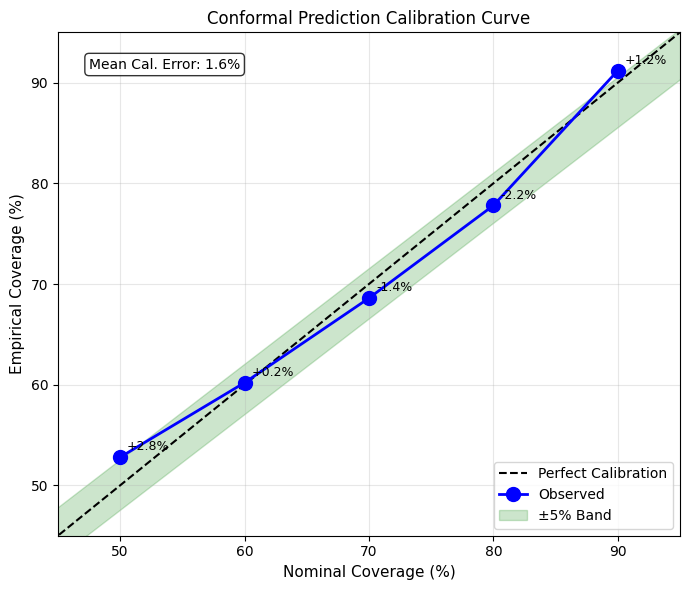


  ✓ Saved to figures/calibration_curve.png
  ✓ Saved: v2_statistical_results/conformal_calibration.joblib


In [531]:
# Run calibration analysis
calibration_results = run_calibration_analysis(sample_size=500)
save_statistical_result(calibration_results, 'conformal_calibration')

In [532]:
# Run conditional calibration
conditional_results = run_conditional_calibration(sample_size=300)
save_statistical_result(conditional_results, 'conditional_calibration')


------------------------------------------------------------
 CONDITIONAL CALIBRATION BY SEGMENT
------------------------------------------------------------

  Target coverage: 80%

  Segment            Empirical       Diff        n   Status
  -------------------------------------------------------
  Seg1_0-15              84.3%      +4.3%      300        ✓
  Seg2_15-50             81.0%      +1.0%      300        ✓
  Seg3_50-80             81.3%      +1.3%      300        ✓
  Seg4_80-95             81.0%      +1.0%      300        ✓
  Seg5_95-100            77.7%      -2.3%      300        ✓
  -------------------------------------------------------

  ✓ No systematic bias detected (mean diff: +1.1%)
  ✓ Saved: v2_statistical_results/conditional_calibration.joblib


## Statistical test 8: Winkler score analysis

In [533]:
def winkler_score(actual: float, lower: float, upper: float, alpha: float) -> float:
    """
    Compute Winkler score for a single prediction interval.

    The Winkler score rewards narrow intervals while penalizing those that
    miss the actual value. Lower is better.

    Parameters
    ----------
    actual : float
        Actual observed value.
    lower : float
        Lower bound of interval.
    upper : float
        Upper bound of interval.
    alpha : float
        1 - coverage (e.g., 0.20 for 80% interval).

    Returns
    -------
    float
        Winkler score.
    """
    width = upper - lower
    
    if actual < lower:
        return width + (2 / alpha) * (lower - actual)
    elif actual > upper:
        return width + (2 / alpha) * (actual - upper)
    else:
        return width


def compute_winkler_scores(test_df: pd.DataFrame, conformal_thresholds: dict,
                           sample_size: int = None) -> dict:
    """
    Compute Winkler scores across test set.

    Parameters
    ----------
    test_df : pd.DataFrame
        Test data.
    conformal_thresholds : dict
        Calibrated thresholds.
    sample_size : int, optional
        Number of samples.

    Returns
    -------
    dict
        Winkler score statistics.
    """
    sample = test_df.sample(n=min(sample_size, len(test_df)), 
                            random_state=CONFIG['random_state']) if sample_size else test_df
    
    coverage = conformal_thresholds.get('_meta', {}).get('coverage', 0.80)
    alpha = 1 - coverage
    
    scores = []
    widths = []
    misses = []
    
    for _, row in sample.iterrows():
        try:
            input_df = prepare_input(
                postcode_sector=row['POSTCODE_SECTOR'], old_new=row['OLD/NEW'],
                tenure_type=row['TENURE_TYPE'], property_type=row['PROPERTY_TYPE'],
                built_form=row['BUILT_FORM'], total_floor_area=row['TOTAL_FLOOR_AREA'],
                local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
                number_bedrooms=row['NUMBER_BEDROOMS'],
                number_bathrooms=row['NUMBER_BATHROOMS'],
                current_energy_rating=row['CURRENT_ENERGY_RATING'])
            
            conf = predict_with_conformal(input_df, conformal_thresholds)
            actual = np.exp(row[TARGET])
            
            lower = conf['conformal_lower']
            upper = conf['conformal_upper']
            
            score = winkler_score(actual, lower, upper, alpha)
            width = upper - lower
            miss = actual < lower or actual > upper
            
            scores.append(score)
            widths.append(width)
            misses.append(miss)
        except:
            continue
    
    return {
        'scores': np.array(scores),
        'widths': np.array(widths),
        'misses': np.array(misses),
        'alpha': alpha,
        'coverage': coverage,
    }


def run_winkler_analysis(sample_size: int = 500) -> dict:
    """
    Run comprehensive Winkler score analysis.

    Parameters
    ----------
    sample_size : int
        Samples to evaluate.

    Returns
    -------
    dict
        Analysis results.
    """
    print("=" * 60)
    print(" WINKLER SCORE ANALYSIS")
    print("=" * 60)
    
    coverage = conformal_thresholds.get('_meta', {}).get('coverage', 0.80)
    print(f"\n  Coverage level: {coverage*100:.0f}%")
    print(f"  Sample size: {sample_size}")
    
    # Combine all test sets
    opt = CONFORMAL_CONFIG['calibration_option']
    all_test = pd.concat([SEGMENT_DATA[opt][seg][2] for seg in SEGMENT_KEYS[opt]], 
                         ignore_index=True)
    
    # Compute scores
    print("\n  Computing Winkler scores...")
    results = compute_winkler_scores(all_test, conformal_thresholds, sample_size)
    
    scores = results['scores']
    widths = results['widths']
    misses = results['misses']
    
    # Summary statistics
    print("\n" + "-" * 60)
    print(" OVERALL RESULTS")
    print("-" * 60)
    
    print(f"\n  {'Metric':<25} {'Value':>15}")
    print("  " + "-" * 42)
    print(f"  {'Mean Winkler Score':<25} £{np.mean(scores):>14,.0f}")
    print(f"  {'Median Winkler Score':<25} £{np.median(scores):>14,.0f}")
    print(f"  {'Std Winkler Score':<25} £{np.std(scores):>14,.0f}")
    print("  " + "-" * 42)
    print(f"  {'Mean Interval Width':<25} £{np.mean(widths):>14,.0f}")
    print(f"  {'Median Interval Width':<25} £{np.median(widths):>14,.0f}")
    print("  " + "-" * 42)
    print(f"  {'Miss Rate':<25} {np.mean(misses)*100:>14.1f}%")
    print(f"  {'Coverage Achieved':<25} {(1-np.mean(misses))*100:>14.1f}%")
    
    # Decomposition: Width vs Penalty
    base_width = np.mean(widths)
    avg_penalty = np.mean(scores) - base_width
    
    print("\n" + "-" * 60)
    print(" SCORE DECOMPOSITION")
    print("-" * 60)
    print(f"\n  Base Width (mean):       £{base_width:>12,.0f}")
    print(f"  Penalty Component:       £{avg_penalty:>12,.0f}")
    print(f"  Total Winkler Score:     £{np.mean(scores):>12,.0f}")
    
    penalty_pct = (avg_penalty / np.mean(scores)) * 100 if np.mean(scores) > 0 else 0
    print(f"\n  Penalty as % of total:   {penalty_pct:.1f}%")
    
    if penalty_pct < 5:
        print("\n  ✓✓ EXCELLENT: Very low penalty — intervals are well-sized")
    elif penalty_pct < 15:
        print("\n  ✓ GOOD: Moderate penalty — intervals mostly capture actuals")
    elif penalty_pct < 30:
        print("\n  ~ MODERATE: Notable penalty — some misses occurring")
    else:
        print("\n  ⚠ HIGH: Large penalty — intervals may be too narrow")
    
    # By segment analysis
    print("\n" + "-" * 60)
    print(" WINKLER SCORE BY SEGMENT")
    print("-" * 60)
    
    segment_results = {}
    print(f"\n  {'Segment':<15} {'Mean Score':>14} {'Width':>12} {'Miss %':>10}")
    print("  " + "-" * 53)
    
    for seg_key in SEGMENT_KEYS[opt]:
        _, _, test_df = SEGMENT_DATA[opt][seg_key]
        seg_res = compute_winkler_scores(test_df, conformal_thresholds, 
                                         sample_size=min(100, len(test_df)))
        
        mean_score = np.mean(seg_res['scores'])
        mean_width = np.mean(seg_res['widths'])
        miss_rate = np.mean(seg_res['misses']) * 100
        
        segment_results[seg_key] = {
            'mean_score': mean_score,
            'mean_width': mean_width,
            'miss_rate': miss_rate,
        }
        
        print(f"  {seg_key:<15} £{mean_score:>13,.0f} £{mean_width:>11,.0f} {miss_rate:>9.1f}%")
    
    # Relative efficiency (normalized by price)
    print("\n" + "-" * 60)
    print(" RELATIVE EFFICIENCY (% of Property Value)")
    print("-" * 60)
    
    # Compute relative metrics
    rel_scores = []
    for _, row in all_test.sample(n=min(sample_size, len(all_test)), 
                                   random_state=CONFIG['random_state']).iterrows():
        try:
            input_df = prepare_input(
                postcode_sector=row['POSTCODE_SECTOR'], old_new=row['OLD/NEW'],
                tenure_type=row['TENURE_TYPE'], property_type=row['PROPERTY_TYPE'],
                built_form=row['BUILT_FORM'], total_floor_area=row['TOTAL_FLOOR_AREA'],
                local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
                number_bedrooms=row['NUMBER_BEDROOMS'],
                number_bathrooms=row['NUMBER_BATHROOMS'],
                current_energy_rating=row['CURRENT_ENERGY_RATING'])
            
            conf = predict_with_conformal(input_df, conformal_thresholds)
            actual = np.exp(row[TARGET])
            
            score = winkler_score(actual, conf['conformal_lower'], 
                                  conf['conformal_upper'], results['alpha'])
            rel_score = (score / actual) * 100
            rel_scores.append(rel_score)
        except:
            continue
    
    print(f"\n  Mean Relative Score:   {np.mean(rel_scores):.1f}% of property value")
    print(f"  Median Relative Score: {np.median(rel_scores):.1f}% of property value")
    
    if np.mean(rel_scores) < 20:
        print("\n  ✓ Intervals are sharp relative to property values")
    elif np.mean(rel_scores) < 35:
        print("\n  ~ Intervals are reasonably sized")
    else:
        print("\n  ⚠ Intervals may be too wide relative to values")
    
    # Plot distribution
    plot_winkler_distribution(scores, widths)
    
    return {
        'mean_score': np.mean(scores),
        'median_score': np.median(scores),
        'mean_width': np.mean(widths),
        'miss_rate': np.mean(misses),
        'penalty_pct': penalty_pct,
        'segment_results': segment_results,
        'relative_score': np.mean(rel_scores),
    }


def plot_winkler_distribution(scores: np.ndarray, widths: np.ndarray) -> None:
    """
    Plot Winkler score distribution.

    Parameters
    ----------
    scores : np.ndarray
        Winkler scores.
    widths : np.ndarray
        Interval widths.
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Score distribution
    ax = axes[0]
    ax.hist(scores / 1000, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(scores) / 1000, color='red', linestyle='--', 
               linewidth=2, label=f'Mean: £{np.mean(scores)/1000:.0f}k')
    ax.axvline(np.median(scores) / 1000, color='orange', linestyle='--', 
               linewidth=2, label=f'Median: £{np.median(scores)/1000:.0f}k')
    ax.set_xlabel('Winkler Score (£k)')
    ax.set_ylabel('Frequency')
    ax.set_title('Winkler Score Distribution')
    ax.legend()
    
    # Width vs Score scatter
    ax = axes[1]
    penalty = scores - widths
    colors = ['green' if p == 0 else 'red' for p in penalty]
    ax.scatter(widths / 1000, scores / 1000, c=colors, alpha=0.5, s=20)
    ax.plot([0, max(widths) / 1000], [0, max(widths) / 1000], 'k--', 
            linewidth=1, label='No Penalty Line')
    ax.set_xlabel('Interval Width (£k)')
    ax.set_ylabel('Winkler Score (£k)')
    ax.set_title('Width vs Score (Red = Missed)')
    ax.legend()
    
    plt.tight_layout()
    (PROJECT_ROOT / 'figures').mkdir(exist_ok=True)
    plt.savefig(PROJECT_ROOT / 'figures' / 'winkler_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n  ✓ Saved to figures/winkler_analysis.png")

 WINKLER SCORE ANALYSIS

  Coverage level: 80%
  Sample size: 500

  Computing Winkler scores...

------------------------------------------------------------
 OVERALL RESULTS
------------------------------------------------------------

  Metric                              Value
  ------------------------------------------
  Mean Winkler Score        £       493,270
  Median Winkler Score      £       272,069
  Std Winkler Score         £     1,139,072
  ------------------------------------------
  Mean Interval Width       £       277,086
  Median Interval Width     £       168,497
  ------------------------------------------
  Miss Rate                           19.4%
  Coverage Achieved                   80.6%

------------------------------------------------------------
 SCORE DECOMPOSITION
------------------------------------------------------------

  Base Width (mean):       £     277,086
  Penalty Component:       £     216,185
  Total Winkler Score:     £     493,270

  Pena

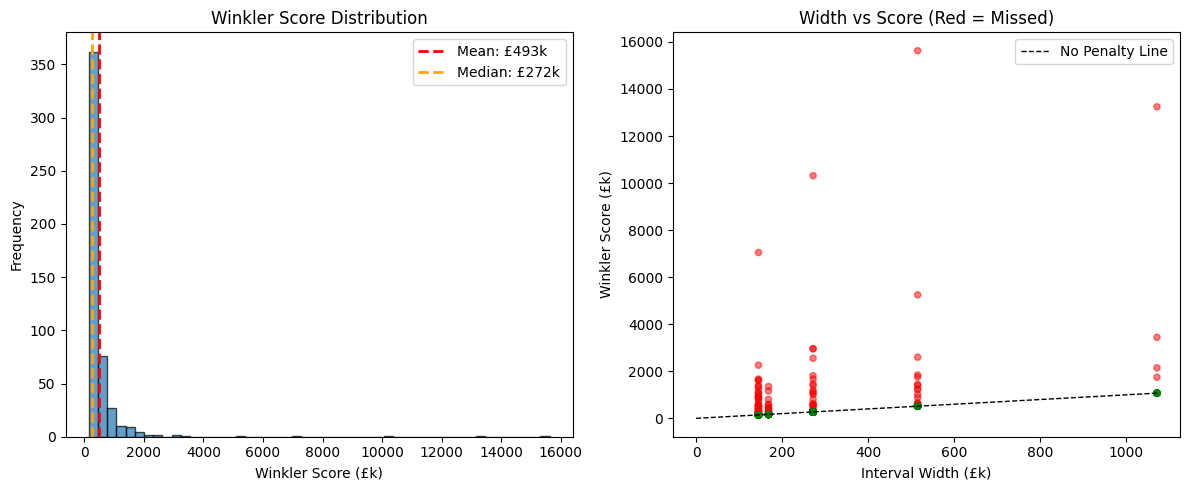


  ✓ Saved to figures/winkler_analysis.png
  ✓ Saved: v2_statistical_results/winkler_results.joblib


In [534]:
# Run Winkler analysis
winkler_results = run_winkler_analysis(sample_size=500)
save_statistical_result(winkler_results, 'winkler_results')

# Section 14: Comparable Transactions

## Assumption 2: Similarity Scoring for Comparables

### Weights & Scoring Logic

| Factor | Weight | Scoring |
|--------|--------|---------|
| **Floor Area** | 35% | ±10% = 100%, ±20% = 80%, ±30% = 50%, >30% = 20% |
| **Bedrooms** | 30% | ±0 = 100%, ±1 = 70%, ±2 = 40%, ≥3 = 10% |
| **Bathrooms** | 25% | ±0 = 100%, ±1 = 80%, ±2 = 50%, >2 = 20% |
| **Transaction Date** | 10% | 0-6mo = 100%, 6-12mo = 90%, 12-18mo = 80%, 18-24mo = 70%, >24mo = 60% |

**Total: 100%** | **Minimum for valuation: 75%**

### Date Handling
- If `date_accessed` is provided → Only transactions **before** that date are used, recency calculated relative to `date_accessed`
- If `date_accessed` is `None` → All transactions used, recency calculated relative to **today**

In [535]:
from datetime import datetime

# -----------------------------------------------------------------------------
# Config
# -----------------------------------------------------------------------------

COMPARABLES_CONFIG = {
    'top_n': 5,
    'min_comparables': 2,
    'min_match_score': 75,      # Minimum % for valuation
    'min_interval_pct': 5,
    'max_interval_pct': 25,
    'model_version': CONFIG['model_version'],
}

# Similarity weights
SIMILARITY_WEIGHTS = {
    'floor_area': 0.35,
    'bedrooms': 0.30,
    'bathrooms': 0.25,
    'date': 0.10,
}

In [536]:
def prepare_transactions_df(pre_dedup_df: pd.DataFrame, hpi_lookup_df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare pre_dedup dataframe for comparable search.
    Creates POSTCODE_SECTOR, bedrooms/bathrooms estimates, ADJUSTED_PRICE.
    """
    print("=" * 60)
    print(" PREPARING TRANSACTIONS FOR COMPARABLES")
    print("=" * 60)
    
    df = pre_dedup_df.copy()
    hpi = hpi_lookup_df.copy()
    
    # Extract postcode sectors (reuse existing function from Section 3)
    df['POSTCODE_SECTOR'] = df['POSTCODE'].apply(extract_postcode_sector)
    df['ORIGINAL_PRICE'] = df['Sale Price (£)']
    df['DATE_OF_TRANSFER'] = pd.to_datetime(df['Date of transaction'], format='mixed').dt.normalize()
    df['OLD_NEW'] = df['Old/New'].str.upper().str[0]
    
    # HPI matching
    print("  Matching HPI data...")
    df["TRANSACTION_PERIOD"] = df["DATE_OF_TRANSFER"].dt.to_period("M").astype(str)
    hpi["Period"] = pd.to_datetime(hpi["Period"]).dt.to_period("M").astype(str)
    
    latest_hpi = hpi.loc[hpi.groupby("Name")["Period"].idxmax(), ["Name", "NORMALISED_HPI"]]
    df = df.merge(hpi, left_on=["LOCAL_AUTHORITY_LABEL", "TRANSACTION_PERIOD"],
                  right_on=["Name", "Period"], how="left")
    
    missing = df["NORMALISED_HPI"].isna()
    df.loc[missing, "NORMALISED_HPI"] = df.loc[missing, "LOCAL_AUTHORITY_LABEL"].map(
        latest_hpi.set_index("Name")["NORMALISED_HPI"])
    df["ADJUSTED_PRICE"] = df["ORIGINAL_PRICE"] * df["NORMALISED_HPI"]
    
    matched = df["NORMALISED_HPI"].notna().sum()
    print(f"    HPI matched: {matched:,}/{len(df):,} ({matched/len(df)*100:.1f}%)")
    
    df = df.drop(columns=["Name", "Period", "TRANSACTION_PERIOD"], errors='ignore')
    
    # Estimate bedrooms/bathrooms (reuse logic from Section 6 if available)
    print("  Estimating bedrooms/bathrooms...")
    df = _estimate_beds_baths_for_comps(df)
    
    # Filter
    before = len(df)
    df = df.dropna(subset=['POSTCODE_SECTOR', 'ORIGINAL_PRICE', 'PROPERTY_TYPE',
                           'BUILT_FORM', 'TOTAL_FLOOR_AREA'])
    print(f"\n  Rows: {before:,} → {len(df):,} (removed {before-len(df):,})")
    print(f"  Date range: {df['DATE_OF_TRANSFER'].min().date()} to {df['DATE_OF_TRANSFER'].max().date()}")
    print("=" * 60)
    
    return df


def _estimate_beds_baths_for_comps(df: pd.DataFrame) -> pd.DataFrame:
    """Estimate NUMBER_BEDROOMS and NUMBER_BATHROOMS from habitable rooms."""
    df['HELPER_LIVING'] = np.nan
    df['NUMBER_BEDROOMS'] = np.nan
    df['NUMBER_BATHROOMS'] = np.nan
    
    valid = df['NUMBER_HABITABLE_ROOMS'].notna()
    has_area = df['TOTAL_FLOOR_AREA'].notna()
    
    # Flats/Maisonettes
    flat = valid & df['PROPERTY_TYPE'].isin(['Flat', 'Maisonette'])
    df.loc[flat & (df['NUMBER_HABITABLE_ROOMS'] == 1), 'HELPER_LIVING'] = 0
    df.loc[flat & df['NUMBER_HABITABLE_ROOMS'].between(2, 5), 'HELPER_LIVING'] = 1
    df.loc[flat & (df['NUMBER_HABITABLE_ROOMS'] >= 6), 'HELPER_LIVING'] = 2
    
    # Houses - Terraced/Semi/Other
    tso = valid & (df['PROPERTY_TYPE'] == 'House') & df['BUILT_FORM'].isin(['Terraced', 'Semi-Detached', 'Other'])
    df.loc[tso & (df['NUMBER_HABITABLE_ROOMS'] == 1), 'HELPER_LIVING'] = 0
    df.loc[tso & df['NUMBER_HABITABLE_ROOMS'].between(2, 4), 'HELPER_LIVING'] = 1
    df.loc[tso & (df['NUMBER_HABITABLE_ROOMS'] == 5) & has_area & (df['TOTAL_FLOOR_AREA'] < 100), 'HELPER_LIVING'] = 2
    df.loc[tso & (df['NUMBER_HABITABLE_ROOMS'] == 5) & has_area & (df['TOTAL_FLOOR_AREA'] >= 100), 'HELPER_LIVING'] = 1
    df.loc[tso & (df['NUMBER_HABITABLE_ROOMS'] == 5) & ~has_area, 'HELPER_LIVING'] = 2
    df.loc[tso & df['NUMBER_HABITABLE_ROOMS'].between(6, 7), 'HELPER_LIVING'] = 2
    df.loc[tso & (df['NUMBER_HABITABLE_ROOMS'] >= 8) & has_area & (df['TOTAL_FLOOR_AREA'] < 150), 'HELPER_LIVING'] = 3
    df.loc[tso & (df['NUMBER_HABITABLE_ROOMS'] >= 8) & has_area & (df['TOTAL_FLOOR_AREA'] >= 150), 'HELPER_LIVING'] = 2
    df.loc[tso & (df['NUMBER_HABITABLE_ROOMS'] >= 8) & ~has_area, 'HELPER_LIVING'] = 2
    
    # Houses - Detached
    det = valid & (df['PROPERTY_TYPE'] == 'House') & (df['BUILT_FORM'] == 'Detached')
    df.loc[det & (df['NUMBER_HABITABLE_ROOMS'] == 1), 'HELPER_LIVING'] = 0
    df.loc[det & df['NUMBER_HABITABLE_ROOMS'].between(2, 5), 'HELPER_LIVING'] = 1
    df.loc[det & df['NUMBER_HABITABLE_ROOMS'].between(6, 7), 'HELPER_LIVING'] = 2
    df.loc[det & (df['NUMBER_HABITABLE_ROOMS'] >= 8) & has_area & (df['TOTAL_FLOOR_AREA'] < 200), 'HELPER_LIVING'] = 2
    df.loc[det & (df['NUMBER_HABITABLE_ROOMS'] >= 8) & has_area & (df['TOTAL_FLOOR_AREA'] >= 200), 'HELPER_LIVING'] = 3
    df.loc[det & (df['NUMBER_HABITABLE_ROOMS'] >= 8) & ~has_area, 'HELPER_LIVING'] = 2
    
    # Bungalows
    bung = valid & (df['PROPERTY_TYPE'] == 'Bungalow')
    df.loc[bung & (df['NUMBER_HABITABLE_ROOMS'] == 1), 'HELPER_LIVING'] = 0
    df.loc[bung & df['NUMBER_HABITABLE_ROOMS'].between(2, 4), 'HELPER_LIVING'] = 1
    df.loc[bung & (df['NUMBER_HABITABLE_ROOMS'] >= 5), 'HELPER_LIVING'] = 2
    
    # Calculate bedrooms & bathrooms
    df['NUMBER_BEDROOMS'] = df['NUMBER_HABITABLE_ROOMS'] - df['HELPER_LIVING']
    df.loc[df['NUMBER_BEDROOMS'] <= 2, 'NUMBER_BATHROOMS'] = 1
    df.loc[df['NUMBER_BEDROOMS'] >= 3, 'NUMBER_BATHROOMS'] = df['NUMBER_BEDROOMS'] / 2
    
    df = df.drop(columns=['HELPER_LIVING'], errors='ignore')
    return df

In [537]:
def _score_date(trans_date, ref_date=None) -> float:
    """Score transaction recency (0-100). 0-6mo=100, 6-12mo=90, 12-18mo=80, 18-24mo=70, >24mo=60."""
    if ref_date is None:
        ref_date = datetime.now()
    if pd.isna(trans_date):
        return 50
    
    if hasattr(trans_date, 'to_pydatetime'):
        trans_date = trans_date.to_pydatetime()
    elif isinstance(trans_date, str):
        trans_date = pd.to_datetime(trans_date)
    
    months = (ref_date - trans_date).days / 30.44
    if months <= 6: return 100
    if months <= 12: return 90
    if months <= 18: return 80
    if months <= 24: return 70
    return 60


def calculate_similarity(target: dict, comp: pd.Series, ref_date=None) -> float:
    """
    Calculate similarity score (0-100%) between target and comparable.
    
    Weights: Floor Area 35%, Bedrooms 30%, Bathrooms 25%, Date 10%
    """
    w = SIMILARITY_WEIGHTS
    score = 0
    
    # Floor Area (±10%=100%, ±20%=80%, ±30%=50%, >30%=20%)
    t_area, c_area = target['floor_area'], comp['TOTAL_FLOOR_AREA']
    if pd.notna(c_area) and t_area > 0:
        diff = abs(t_area - c_area) / t_area
        area_score = 1.0 if diff <= 0.1 else 0.8 if diff <= 0.2 else 0.5 if diff <= 0.3 else 0.2
    else:
        area_score = 0.5
    score += w['floor_area'] * area_score * 100
    
    # Bedrooms (±0=100%, ±1=70%, ±2=40%, ≥3=10%)
    t_beds, c_beds = target['bedrooms'], comp.get('NUMBER_BEDROOMS', 0)
    if pd.notna(c_beds) and t_beds > 0:
        diff = abs(t_beds - c_beds)
        bed_score = 1.0 if diff == 0 else 0.7 if diff == 1 else 0.4 if diff == 2 else 0.1
    else:
        bed_score = 0.5
    score += w['bedrooms'] * bed_score * 100
    
    # Bathrooms (±0=100%, ±1=80%, ±2=50%, >2=20%)
    t_baths, c_baths = target['bathrooms'], comp.get('NUMBER_BATHROOMS', 0)
    if pd.notna(c_baths) and t_baths > 0:
        diff = abs(t_baths - c_baths)
        bath_score = 1.0 if diff == 0 else 0.8 if diff <= 1 else 0.5 if diff <= 2 else 0.2
    else:
        bath_score = 0.5
    score += w['bathrooms'] * bath_score * 100
    
    # Transaction Date
    score += w['date'] * _score_date(comp.get('DATE_OF_TRANSFER'), ref_date)
    
    return score

In [538]:
def find_comparables(postcode_sector: str, property_type: str, built_form: str,
                     total_floor_area: float, number_bedrooms: int, number_bathrooms: int,
                     transactions_df: pd.DataFrame, date_accessed=None) -> dict:
    """
    Find comparable transactions from historical data.
    
    MUST MATCH: postcode_sector, property_type, built_form
    SIMILARITY: floor_area, bedrooms, bathrooms, transaction_date
    
    Parameters
    ----------
    date_accessed : datetime, optional
        If provided, only uses transactions before this date.
        If None, uses all transactions with recency relative to today.
    """
    cfg = COMPARABLES_CONFIG
    
    # Filter by must-match criteria
    mask = ((transactions_df['POSTCODE_SECTOR'] == postcode_sector) &
            (transactions_df['PROPERTY_TYPE'] == property_type) &
            (transactions_df['BUILT_FORM'] == built_form))
    filtered = transactions_df[mask].copy()
    
    # Filter by date if provided
    ref_date = pd.to_datetime(date_accessed) if date_accessed else None
    if ref_date:
        filtered = filtered[filtered['DATE_OF_TRANSFER'] <= ref_date]
    
    if len(filtered) < cfg['min_comparables']:
        return None
    
    # Calculate similarity scores
    target = {'floor_area': total_floor_area, 'bedrooms': number_bedrooms, 'bathrooms': number_bathrooms}
    filtered['similarity_score'] = filtered.apply(lambda r: calculate_similarity(target, r, ref_date), axis=1)
    
    # Top N by similarity
    top = filtered.nlargest(cfg['top_n'], 'similarity_score').copy()
    if len(top) < cfg['min_comparables']:
        return None
    
    top['adjusted_price_per_sqm'] = top['ADJUSTED_PRICE'] / top['TOTAL_FLOOR_AREA']
    
    # Valuation from high-quality matches only
    hq = top[top['similarity_score'] >= cfg['min_match_score']]
    
    if len(hq) > 0:
        weights = hq['similarity_score'] / hq['similarity_score'].sum()
        weighted_avg = (hq['ADJUSTED_PRICE'] * weights).sum()
        avg_psm = hq['adjusted_price_per_sqm'].mean()
        implied_psm = avg_psm * total_floor_area
        avg_match = hq['similarity_score'].mean()
        
        # Confidence interval
        cv = (np.std(hq['ADJUSTED_PRICE']) / np.mean(hq['ADJUSTED_PRICE']) * 100) if len(hq) > 1 else 10
        interval_pct = np.clip(cv * (100 / avg_match), cfg['min_interval_pct'], cfg['max_interval_pct'])
        interval_amt = weighted_avg * (interval_pct / 100)
        
        valuation = {
            'weighted_avg': weighted_avg, 'avg_psm': avg_psm, 'implied_psm': implied_psm,
            'avg_match': avg_match, 'interval_pct': interval_pct,
            'interval_lower': weighted_avg - interval_amt, 'interval_upper': weighted_avg + interval_amt,
            'n_used': len(hq), 'has_valuation': True,
        }
    else:
        valuation = {'has_valuation': False, 'n_used': 0}
    
    # Build comparables list
    comps = []
    for _, r in top.iterrows():
        comps.append({
            'postcode': r.get('POSTCODE', r.get('POSTCODE_SECTOR', 'N/A')),
            'date': r.get('DATE_OF_TRANSFER', 'N/A'),
            'original_price': r['ORIGINAL_PRICE'], 'adjusted_price': r['ADJUSTED_PRICE'],
            'adjusted_psm': r['adjusted_price_per_sqm'],
            'bedrooms': r['NUMBER_BEDROOMS'], 'bathrooms': r['NUMBER_BATHROOMS'],
            'floor_area': r['TOTAL_FLOOR_AREA'], 'similarity': r['similarity_score'],
            'used': r['similarity_score'] >= cfg['min_match_score'],
            'date_score': _score_date(r.get('DATE_OF_TRANSFER'), ref_date),
        })
    
    return {
        'comparables': comps, 'n_total': len(comps), 'avg_price_all': top['ADJUSTED_PRICE'].mean(),
        'target_area': total_floor_area, 'min_threshold': cfg['min_match_score'],
        'ref_date': ref_date, **valuation,
    }

In [539]:
def display_comparables(postcode_sector: str, property_type: str, built_form: str,
                        total_floor_area: float, number_bedrooms: int, number_bathrooms: int,
                        transactions_df: pd.DataFrame, listing_price: float = None,
                        date_accessed=None) -> dict:
    """Display comparable transactions dashboard."""
    result = find_comparables(postcode_sector, property_type, built_form, total_floor_area,
                               number_bedrooms, number_bathrooms, transactions_df, date_accessed)
    
    ref_date = pd.to_datetime(date_accessed) if date_accessed else datetime.now()
    ref_str = ref_date.strftime('%Y-%m-%d') if date_accessed else "today"
    
    if result is None:
        print("=" * 98)
        print(" COMPARABLE TRANSACTIONS")
        print("=" * 98)
        print(f"\n  ⚠️  Insufficient comparables for {postcode_sector} {property_type} ({built_form})")
        print(f"     Minimum {COMPARABLES_CONFIG['min_comparables']} required.")
        if date_accessed:
            print(f"     (Using transactions before {ref_str})")
        print("=" * 98)
        return None
    
    print("=" * 98)
    print(f" COMPARABLE TRANSACTIONS - {postcode_sector} ({built_form} {property_type})")
    print("=" * 98)
    print(f"\n  Your Property: {number_bedrooms} bed | {number_bathrooms} bath | {total_floor_area} m²")
    if date_accessed:
        print(f"  Reference Date: {ref_str}")
    
    # Table
    print("\n" + "-" * 98)
    print(f" # │Match│ Age  │ Date       │{'Sold Price':>12} │{'Adj. Price':>12} │{'Adj. £/m²':>10} │Bed│Bath│ Area")
    print("-" * 98)
    
    for i, c in enumerate(result['comparables'], 1):
        date_str = str(c['date'])[:10] if c['date'] != 'N/A' else 'N/A     '
        beds = int(c['bedrooms']) if pd.notna(c['bedrooms']) else '?'
        baths = f"{c['bathrooms']:.1f}" if pd.notna(c['bathrooms']) else '?'
        marker = "★" if c['used'] else " "
        
        if c['date'] != 'N/A' and pd.notna(c['date']):
            trans = c['date'].to_pydatetime() if hasattr(c['date'], 'to_pydatetime') else pd.to_datetime(c['date'])
            age = f"{int((ref_date - trans).days / 30.44):>2}mo"
        else:
            age = " N/A"
        
        print(f"{marker}{i} │ {c['similarity']:>3.0f}%│{age:>5} │ {date_str} │"
              f"£{c['original_price']:>10,.0f} │£{c['adjusted_price']:>10,.0f} │"
              f"£{c['adjusted_psm']:>8,.0f} │ {beds:>2} │ {baths:>3} │{c['floor_area']:>5.0f}m²")
    
    # Summary
    print("\n" + "-" * 98)
    print(" VALUATION SUMMARY (HPI-Adjusted)")
    print("-" * 98)
    
    if result['has_valuation']:
        print(f"  ★ = Used in valuation (≥{result['min_threshold']}% match)")
        print(f"  Comparables used: {result['n_used']} of {result['n_total']} | Avg match: {result['avg_match']:.0f}%")
        print(f"\n  Match-Weighted Average:           £{result['weighted_avg']:>12,.0f}")
        print(f"  Confidence Interval (±{result['interval_pct']:.0f}%):     £{result['interval_lower']:>12,.0f} — £{result['interval_upper']:,.0f}")
        print(f"\n  Average £/m²:                     £{result['avg_psm']:>12,.0f}")
        print(f"  Implied Value ({total_floor_area}m² × £/m²):    £{result['implied_psm']:>12,.0f}")
    else:
        print(f"  ⚠️  No comparables ≥{result['min_threshold']}% match")
        print(f"\n  Average of all {result['n_total']} (reference only): £{result['avg_price_all']:>10,.0f}")
    
    # Listing comparison
    if listing_price and result['has_valuation']:
        print("\n" + "-" * 98)
        print(" LISTING ANALYSIS")
        print("-" * 98)
        
        diff = listing_price - result['weighted_avg']
        diff_pct = (diff / result['weighted_avg']) * 100
        print(f"  Listing Price:                    £{listing_price:>12,.0f}")
        print(f"  vs Comparable Estimate:           {diff_pct:>+12.1f}% (£{diff:+,.0f})")
        
        if result['interval_lower'] <= listing_price <= result['interval_upper']:
            print(f"\n  ✓ Listing is WITHIN confidence interval")
        elif listing_price < result['interval_lower']:
            print(f"\n  💡 Listing BELOW interval by £{result['interval_lower'] - listing_price:,.0f}")
        else:
            print(f"\n  ⚠️  Listing ABOVE interval by £{listing_price - result['interval_upper']:,.0f}")
    
    print("\n" + "=" * 98)
    return result

In [540]:
def save_transactions_df(df: pd.DataFrame) -> None:
    """Save prepared transactions to disk."""
    v = COMPARABLES_CONFIG['model_version']
    path = PROJECT_ROOT / f'transactions_prepared_{v}.csv'
    df.to_csv(path, index=False)
    print(f"  ✓ Saved: {path.name} ({len(df):,} rows)")


def load_transactions_df() -> pd.DataFrame:
    """Load prepared transactions from disk."""
    v = COMPARABLES_CONFIG['model_version']
    path = PROJECT_ROOT / f'transactions_prepared_{v}.csv'
    if path.exists():
        df = pd.read_csv(path, parse_dates=['DATE_OF_TRANSFER'])
        print(f"  ✓ Loaded: {path.name} ({len(df):,} rows)")
        return df
    print(f"  ⚠ Not found: {path.name}")
    return None


print("  ✓ Comparables system ready")

  ✓ Comparables system ready


In [541]:
# First time: prepare and save
transactions_prepared = prepare_transactions_df(pre_dedup, hpi_lookup)
save_transactions_df(transactions_prepared)

 PREPARING TRANSACTIONS FOR COMPARABLES
  Matching HPI data...
    HPI matched: 284,517/299,340 (95.0%)
  Estimating bedrooms/bathrooms...

  Rows: 299,340 → 299,273 (removed 67)
  Date range: 2018-01-01 to 2025-11-28
  ✓ Saved: transactions_prepared_v2.csv (299,273 rows)


In [542]:
# Subsequent runs: load from disk
transactions_prepared = load_transactions_df()

  ✓ Loaded: transactions_prepared_v2.csv (299,273 rows)


In [543]:
# Step 2: Test comparables
display_comparables(
    postcode_sector='HA3 0',
    property_type='House',
    built_form='Detached',
    total_floor_area=162.2,
    number_bedrooms=5,
    number_bathrooms=3,
    transactions_df=transactions_prepared,
    listing_price=1200000
)

 COMPARABLE TRANSACTIONS - HA3 0 (Detached House)

  Your Property: 5 bed | 3 bath | 162.2 m²

--------------------------------------------------------------------------------------------------
 # │Match│ Age  │ Date       │  Sold Price │  Adj. Price │ Adj. £/m² │Bed│Bath│ Area
--------------------------------------------------------------------------------------------------
★1 │  95%│  3mo │ 2025-09-17 │£   910,000 │£   902,698 │£   5,787 │  5 │ 2.5 │  156m²
★2 │  94%│  6mo │ 2025-06-10 │£ 1,000,000 │£   998,990 │£   6,487 │  5 │ 2.5 │  154m²
★3 │  94%│  6mo │ 2025-06-27 │£   915,000 │£   914,076 │£   6,176 │  5 │ 2.5 │  148m²
★4 │  92%│ 23mo │ 2024-02-02 │£   900,000 │£   897,278 │£   5,127 │  5 │ 2.5 │  175m²
★5 │  91%│ 26mo │ 2023-10-20 │£   992,500 │£   963,280 │£   5,473 │  5 │ 2.5 │  176m²

--------------------------------------------------------------------------------------------------
 VALUATION SUMMARY (HPI-Adjusted)
----------------------------------------------------------

{'comparables': [{'postcode': 'HA3 0JD',
   'date': Timestamp('2025-09-17 00:00:00'),
   'original_price': 910000,
   'adjusted_price': 902698.0942828484,
   'adjusted_psm': 5786.526245402874,
   'bedrooms': 5.0,
   'bathrooms': 2.5,
   'floor_area': 156.0,
   'similarity': 95.0,
   'used': True,
   'date_score': 100},
  {'postcode': 'HA3 0LW',
   'date': Timestamp('2025-06-10 00:00:00'),
   'original_price': 1000000,
   'adjusted_price': 998989.8989898992,
   'adjusted_psm': 6486.947396038307,
   'bedrooms': 5.0,
   'bathrooms': 2.5,
   'floor_area': 154.0,
   'similarity': 94.0,
   'used': True,
   'date_score': 90},
  {'postcode': 'HA3 0JW',
   'date': Timestamp('2025-06-27 00:00:00'),
   'original_price': 915000,
   'adjusted_price': 914075.7575757578,
   'adjusted_psm': 6176.187551187552,
   'bedrooms': 5.0,
   'bathrooms': 2.5,
   'floor_area': 148.0,
   'similarity': 94.0,
   'used': True,
   'date_score': 90},
  {'postcode': 'HA3 0BY',
   'date': Timestamp('2024-02-02 00:00:00'

# Section 15: Backtesting Pipeline
### From v1, I realised my approach to backtest was not super accurate as measuring confidence of my model predictions against listings would not be a super comprehensive proxy to determine whether a listing is undervalued / overvalued. This also applies to the conformal prediction above.
### As a result, I have incorporated looking at comparables to serve as another proxy and adjusted for how close of a match these comparables are

In [544]:
from tqdm import tqdm
import io
from contextlib import redirect_stdout

# -----------------------------------------------------------------------------
# 15.1 Configuration
# -----------------------------------------------------------------------------

BACKTEST_CONFIG = {
    'model_version': CONFIG['model_version'],
    'strong_threshold': 20,
    'agreement_threshold': 10,
}

In [545]:
def load_listings(filepath: str) -> pd.DataFrame:
    """Load listings from Excel or CSV."""
    print("=" * 60)
    print(" LOADING LISTINGS")
    print("=" * 60)
    
    df = pd.read_excel(filepath) if filepath.endswith(('.xlsx', '.xls')) else pd.read_csv(filepath)
    print(f"  ✓ Loaded {len(df):,} listings")
    print(f"  ✓ Columns: {list(df.columns)}")
    return df


def normalize_built_form(bf) -> str:
    """Normalize built form values."""
    if pd.isna(bf):
        return None
    bf = str(bf).strip().lower()
    if 'terrace' in bf: return 'Terraced'
    if 'semi' in bf: return 'Semi-Detached'
    if 'detach' in bf: return 'Detached'
    return 'Other'


def prepare_listings(listings_df: pd.DataFrame, pre_dedup_df: pd.DataFrame) -> pd.DataFrame:
    """Prepare and enrich listings for backtesting."""
    print("=" * 60)
    print(" PREPARING LISTINGS")
    print("=" * 60)
    
    df = listings_df.copy()
    
    # Extract postcode sector if needed (reuse from Section 3)
    if 'POSTCODE_SECTOR' not in df.columns and 'POSTCODE' in df.columns:
        df['POSTCODE_SECTOR'] = df['POSTCODE'].apply(extract_postcode_sector)
    
    # Normalize built form
    if 'BUILT_FORM' in df.columns:
        df['BUILT_FORM'] = df['BUILT_FORM'].apply(normalize_built_form)
    
    print(f"  ✓ Prepared {len(df):,} listings")
    return df

In [546]:
def run_ml_backtest(listings_df: pd.DataFrame, quantile_models: dict,
                    quantile_configs: dict, conformal_thresholds: dict) -> pd.DataFrame:
    """Run ML predictions on listings."""
    print("=" * 60)
    print(" RUNNING ML BACKTEST")
    print("=" * 60)
    
    # Build session dict once (not inside loop)
    session = {
        'quantile_models': quantile_models,
        'quantile_configs': quantile_configs,
        'percentiles': PERCENTILES,
        'segment_mapes': SEGMENT_MAPES,
        'category_mappings_opt1': {},
        'category_mappings_opt2': {},
        'category_mappings_opt3': {},
        'category_mappings_opt4': {},
        'category_mappings_opt5': {},
    }
    
    results = []
    
    for idx, row in tqdm(listings_df.iterrows(), total=len(listings_df), desc="ML Predictions"):
        try:
            input_df = prepare_input(
                postcode_sector=row['POSTCODE_SECTOR'],
                old_new=row.get('OLD/NEW', 'O'),
                tenure_type=row.get('TENURE_TYPE', 'F'),
                property_type=row['PROPERTY_TYPE'],
                built_form=row.get('BUILT_FORM', 'Other'),
                total_floor_area=row['TOTAL_FLOOR_AREA'],
                local_authority_label=row.get('LOCAL_AUTHORITY_LABEL', 'Unknown'),
                number_bedrooms=row['NUMBER_BEDROOMS'],
                number_bathrooms=row.get('NUMBER_BATHROOMS', 1),
                current_energy_rating=row.get('CURRENT_ENERGY_RATING', 'D'))
            
            # Ensemble prediction - pass session dict
            ens = predict_ensemble(input_df, session)  # Fixed: pass session instead of separate args
            conf_tier, _ = calculate_confidence(ens)
            
            # Conformal prediction
            conf = predict_with_conformal(input_df, conformal_thresholds)
            
            # Classification if listing price available
            listing_price = row.get('LISTING_PRICE')
            classification = None
            if listing_price:
                classification, _ = classify_listing(
                    ens['mape_weighted_mean'], listing_price, conf_tier, ens['segment_mape'])
            
            results.append({
                'IDX': idx,
                'POSTCODE_SECTOR': row['POSTCODE_SECTOR'],
                'LISTING_PRICE': listing_price,
                'ML_ESTIMATE': ens['ensemble_mean'],
                'ML_WEIGHTED': ens['mape_weighted_mean'],
                'ML_CONFIDENCE': conf_tier,
                'ML_CLASSIFICATION': classification,
                'ML_SEGMENT': ens['segment_used'],
                'ML_SEGMENT_MAPE': ens['segment_mape'],
                'ML_CV': ens['coefficient_of_variation'],
                'CONF_LOWER': conf['conformal_lower'],
                'CONF_UPPER': conf['conformal_upper'],
                'CONF_WIDTH_PCT': conf['threshold_pct'],
                'STATUS': 'success',
            })
            
        except Exception as e:
            results.append({
                'IDX': idx, 'POSTCODE_SECTOR': row.get('POSTCODE_SECTOR'),
                'LISTING_PRICE': row.get('LISTING_PRICE'), 'STATUS': f'error: {e}'})
    
    df = pd.DataFrame(results)
    success = (df['STATUS'] == 'success').sum()
    print(f"\n  ✓ Completed: {success}/{len(df)} successful")
    
    return df

In [547]:
def run_batch_comparables(listings_df: pd.DataFrame, transactions_df: pd.DataFrame) -> pd.DataFrame:
    """Run comparable analysis on multiple listings."""
    results = []
    
    for idx, row in tqdm(listings_df.iterrows(), total=len(listings_df), desc="Finding comparables"):
        try:
            with redirect_stdout(io.StringIO()):
                comp = find_comparables(
                    postcode_sector=row['POSTCODE_SECTOR'],
                    property_type=row['PROPERTY_TYPE'],
                    built_form=row.get('BUILT_FORM', 'Other'),
                    total_floor_area=row['TOTAL_FLOOR_AREA'],
                    number_bedrooms=row['NUMBER_BEDROOMS'],
                    number_bathrooms=row.get('NUMBER_BATHROOMS', 1),
                    transactions_df=transactions_df,
                    date_accessed=row.get('DATE_ACCESSED'))
            
            if comp and comp.get('has_valuation'):
                results.append({
                    'IDX': idx, 'COMP_ESTIMATE': comp['weighted_avg'],
                    'COMP_LOWER': comp['interval_lower'], 'COMP_UPPER': comp['interval_upper'],
                    'COMP_INTERVAL_PCT': comp['interval_pct'], 'COMP_COUNT': comp['n_total'],
                    'COMP_USED': comp['n_used'], 'COMP_MATCH': comp['avg_match'],
                    'COMP_STATUS': 'success'})
            elif comp:
                results.append({'IDX': idx, 'COMP_COUNT': comp['n_total'],
                               'COMP_USED': 0, 'COMP_STATUS': 'no_qualifying'})
            else:
                results.append({'IDX': idx, 'COMP_STATUS': 'no_comparables'})
        except Exception as e:
            results.append({'IDX': idx, 'COMP_STATUS': f'error: {e}'})
    
    return pd.DataFrame(results)

In [548]:
def combine_results(listings_df: pd.DataFrame, ml_df: pd.DataFrame,
                    comp_df: pd.DataFrame) -> pd.DataFrame:
    """Combine ML and comparable results."""
    # Base columns from listings
    cols = ['URL', 'POSTCODE_SECTOR', 'PROPERTY_TYPE', 'BUILT_FORM',
            'TOTAL_FLOOR_AREA', 'NUMBER_BEDROOMS', 'LISTING_PRICE']
    cols = [c for c in cols if c in listings_df.columns]
    combined = listings_df[cols].copy().reset_index(drop=True)
    
    # Merge ML results
    ml = ml_df.reset_index(drop=True)
    for col in ['ML_ESTIMATE', 'ML_WEIGHTED', 'ML_CONFIDENCE', 'ML_CLASSIFICATION',
                'ML_SEGMENT', 'CONF_LOWER', 'CONF_UPPER']:
        if col in ml.columns:
            combined[col] = ml[col]
    
    # Merge comparable results
    comp = comp_df.reset_index(drop=True)
    for col in ['COMP_ESTIMATE', 'COMP_USED', 'COMP_MATCH', 'COMP_STATUS']:
        if col in comp.columns:
            combined[col] = comp[col]
    
    # Calculate differences
    combined['ML_VS_LIST_PCT'] = (combined['LISTING_PRICE'] - combined['ML_ESTIMATE']) / combined['ML_ESTIMATE'] * 100
    combined['COMP_VS_LIST_PCT'] = (combined['LISTING_PRICE'] - combined['COMP_ESTIMATE']) / combined['COMP_ESTIMATE'] * 100
    combined['METHOD_SPREAD_PCT'] = abs(combined['ML_ESTIMATE'] - combined['COMP_ESTIMATE']) / \
                                    ((combined['ML_ESTIMATE'] + combined['COMP_ESTIMATE']) / 2) * 100
    
    # Directional agreement
    combined['ML_DIR'] = combined['ML_VS_LIST_PCT'].apply(
        lambda x: 'UNDER' if x < -10 else ('OVER' if x > 10 else 'FAIR'))
    combined['COMP_DIR'] = combined['COMP_VS_LIST_PCT'].apply(
        lambda x: 'UNDER' if pd.notna(x) and x < -10 else ('OVER' if pd.notna(x) and x > 10 else 'FAIR'))
    combined['AGREE'] = combined['ML_DIR'] == combined['COMP_DIR']
    
    return combined


def calculate_combined_class(row) -> dict:
    """Calculate combined classification from ML + comparables."""
    cfg = BACKTEST_CONFIG
    ml_diff = row['ML_VS_LIST_PCT']
    comp_diff = row['COMP_VS_LIST_PCT']
    spread = row['METHOD_SPREAD_PCT']
    comp_ok = row.get('COMP_STATUS') == 'success'
    ml_conf = row.get('ML_CONFIDENCE', 'LOW')
    
    reasoning = []
    
    # ML only if no comparables
    if not comp_ok or pd.isna(comp_diff):
        reasoning.append(f"ML only (conf: {ml_conf})")
        if ml_diff < -cfg['strong_threshold']: cls = 'STRONG_UNDERVALUED'
        elif ml_diff < -10: cls = 'UNDERVALUED'
        elif ml_diff > cfg['strong_threshold']: cls = 'STRONG_OVERVALUED'
        elif ml_diff > 10: cls = 'OVERVALUED'
        else: cls = 'FAIR_VALUE'
        return {'class': cls, 'conf': ml_conf, 'method': 'ML_ONLY', 'reason': reasoning}
    
    # Both methods available
    ml_says = 'UNDER' if ml_diff < -10 else ('OVER' if ml_diff > 10 else 'FAIR')
    comp_says = 'UNDER' if comp_diff < -10 else ('OVER' if comp_diff > 10 else 'FAIR')
    agree = ml_says == comp_says
    avg_diff = (ml_diff + comp_diff) / 2
    
    if agree and spread < 10:
        conf, method = 'HIGH', 'AGREED'
        reasoning.append(f"Strong agreement: ML={ml_diff:+.1f}%, Comp={comp_diff:+.1f}%")
    elif agree and spread < 20:
        conf, method = 'MEDIUM', 'PARTIAL'
        reasoning.append(f"Moderate agreement, spread={spread:.1f}%")
    elif not agree and spread < 10:
        conf, method = 'MEDIUM', 'BORDERLINE'
        reasoning.append(f"Borderline, spread={spread:.1f}%")
    else:
        conf, method = 'LOW', 'CONFLICT'
        reasoning.append(f"Conflict: ML={ml_says}, Comp={comp_says}, spread={spread:.1f}%")
    
    if avg_diff < -cfg['strong_threshold']: cls = 'STRONG_UNDERVALUED'
    elif avg_diff < -10: cls = 'UNDERVALUED'
    elif avg_diff > cfg['strong_threshold']: cls = 'STRONG_OVERVALUED'
    elif avg_diff > 10: cls = 'OVERVALUED'
    else: cls = 'FAIR_VALUE'
    
    return {'class': cls, 'conf': conf, 'method': method, 'reason': reasoning}


def apply_combined_classification(combined_df: pd.DataFrame) -> pd.DataFrame:
    """Apply combined classification to all rows."""
    results = []
    for _, row in combined_df.iterrows():
        r = calculate_combined_class(row)
        results.append({
            'COMBINED_CLASS': r['class'], 'COMBINED_CONF': r['conf'],
            'AGREE_METHOD': r['method'], 'REASONING': ' | '.join(r['reason'])})
    
    return pd.concat([combined_df.reset_index(drop=True), pd.DataFrame(results)], axis=1)

In [549]:
def analyse_results(df: pd.DataFrame) -> None:
    """Analyse and display combined results."""
    print("=" * 80)
    print(" COMBINED VALUATION ANALYSIS")
    print("=" * 80)
    
    total = len(df)
    has_comps = (df['COMP_STATUS'] == 'success').sum()
    
    print(f"\n  📊 Coverage: {total} listings | {has_comps} with comparables ({has_comps/total*100:.1f}%)")
    
    # Method agreement
    both = df[df['COMP_STATUS'] == 'success']
    if len(both) > 0:
        agree = both['AGREE'].sum()
        print(f"\n  🤝 Agreement: {agree}/{len(both)} ({agree/len(both)*100:.1f}%)")
        print(f"     Avg spread: {both['METHOD_SPREAD_PCT'].mean():.1f}%")
    
    # Classification distribution
    print(f"\n  📈 Classification:")
    for cls in ['STRONG_UNDERVALUED', 'UNDERVALUED', 'FAIR_VALUE', 'OVERVALUED', 'STRONG_OVERVALUED']:
        n = (df['COMBINED_CLASS'] == cls).sum()
        if n > 0:
            print(f"     {cls:<20} {n:3} ({n/total*100:5.1f}%) {'█' * int(n/total*50)}")
    
    # Confidence distribution
    print(f"\n  🎯 Confidence:")
    for conf in ['HIGH', 'MEDIUM', 'LOW']:
        n = (df['COMBINED_CONF'] == conf).sum()
        if n > 0:
            print(f"     {conf:<20} {n:3} ({n/total*100:5.1f}%)")
    
    # Bias
    print(f"\n  📐 Bias:")
    print(f"     ML vs Listing:   mean={df['ML_VS_LIST_PCT'].mean():+.1f}%, median={df['ML_VS_LIST_PCT'].median():+.1f}%")
    if len(both) > 0:
        print(f"     Comp vs Listing: mean={both['COMP_VS_LIST_PCT'].mean():+.1f}%, median={both['COMP_VS_LIST_PCT'].median():+.1f}%")
    
    print("\n" + "=" * 80)

In [550]:
def find_opportunities(df: pd.DataFrame) -> dict:
    """Find and display high-confidence opportunities."""
    under = df[(df['COMBINED_CLASS'].isin(['STRONG_UNDERVALUED', 'UNDERVALUED'])) &
               (df['COMBINED_CONF'] == 'HIGH')].sort_values('ML_VS_LIST_PCT')
    over = df[(df['COMBINED_CLASS'].isin(['STRONG_OVERVALUED', 'OVERVALUED'])) &
              (df['COMBINED_CONF'] == 'HIGH')].sort_values('ML_VS_LIST_PCT', ascending=False)
    conflicts = df[df['AGREE_METHOD'] == 'CONFLICT']
    
    opp_map = {}
    num = 1
    
    print("=" * 90)
    print(" 💎 HIGH CONFIDENCE OPPORTUNITIES")
    print("=" * 90)
    
    print(f"\n  🟢 UNDERVALUED ({len(under)}):")
    print(f"     {'#':<4} {'Postcode':<10} {'Type':<10} {'Beds':<4} {'Listing':>12} {'ML':>8} {'Comp':>8}")
    print("     " + "-" * 70)
    for idx, row in under.iterrows():
        comp_str = f"{row['COMP_VS_LIST_PCT']:+.1f}%" if pd.notna(row['COMP_VS_LIST_PCT']) else "N/A"
        print(f"     {num:<4} {row['POSTCODE_SECTOR']:<10} {row['PROPERTY_TYPE']:<10} "
              f"{int(row['NUMBER_BEDROOMS']):<4} £{row['LISTING_PRICE']:>10,.0f} "
              f"{row['ML_VS_LIST_PCT']:>+7.1f}% {comp_str:>8}")
        opp_map[num] = idx
        num += 1
    
    print(f"\n  🔴 OVERVALUED ({len(over)}):")
    print(f"     {'#':<4} {'Postcode':<10} {'Type':<10} {'Beds':<4} {'Listing':>12} {'ML':>8} {'Comp':>8}")
    print("     " + "-" * 70)
    for idx, row in over.iterrows():
        comp_str = f"{row['COMP_VS_LIST_PCT']:+.1f}%" if pd.notna(row['COMP_VS_LIST_PCT']) else "N/A"
        print(f"     {num:<4} {row['POSTCODE_SECTOR']:<10} {row['PROPERTY_TYPE']:<10} "
              f"{int(row['NUMBER_BEDROOMS']):<4} £{row['LISTING_PRICE']:>10,.0f} "
              f"{row['ML_VS_LIST_PCT']:>+7.1f}% {comp_str:>8}")
        opp_map[num] = idx
        num += 1
    
    print(f"\n  ⚠️  CONFLICTS ({len(conflicts)})")
    print("=" * 90)
    print(f"  Total: {len(opp_map)} opportunities")
    
    return opp_map


def view_opportunity(num: int, opp_map: dict, combined_df: pd.DataFrame,
                     listings_df: pd.DataFrame, transactions_df: pd.DataFrame) -> None:
    """View detailed dashboard for an opportunity."""
    if num not in opp_map:
        print(f"  ❌ Invalid #{num}. Valid: 1-{len(opp_map)}")
        return
    
    idx = opp_map[num]
    row = combined_df.loc[idx]
    listing = listings_df.loc[idx]
    
    print("=" * 90)
    print(" 📊 PROPERTY DASHBOARD")
    print("=" * 90)
    
    # Property details
    print(f"\n  📍 {row['POSTCODE_SECTOR']} | {row['PROPERTY_TYPE']} ({row.get('BUILT_FORM', 'N/A')})")
    print(f"     {row['TOTAL_FLOOR_AREA']} m² | {int(row['NUMBER_BEDROOMS'])} bed")
    print(f"     💰 Listing: £{row['LISTING_PRICE']:,.0f}")
    if 'URL' in listing:
        print(f"     🔗 {listing['URL']}")
    
    # ML valuation
    print(f"\n  🤖 ML VALUATION")
    print(f"     Estimate: £{row['ML_ESTIMATE']:,.0f} ({row['ML_VS_LIST_PCT']:+.1f}% vs listing)")
    print(f"     Confidence: {row['ML_CONFIDENCE']} | Segment: {row['ML_SEGMENT']}")
    print(f"     80% Interval: £{row['CONF_LOWER']:,.0f} — £{row['CONF_UPPER']:,.0f}")
    
    # Comparables
    if row['COMP_STATUS'] == 'success':
        print(f"\n  🏠 COMPARABLES")
        print(f"     Estimate: £{row['COMP_ESTIMATE']:,.0f} ({row['COMP_VS_LIST_PCT']:+.1f}% vs listing)")
        print(f"     Used: {int(row['COMP_USED'])} | Match: {row['COMP_MATCH']:.0f}%")
    else:
        print(f"\n  🏠 COMPARABLES: {row['COMP_STATUS']}")
    
    # Verdict
    cls_emoji = {'STRONG_UNDERVALUED': '💎', 'UNDERVALUED': '🟢', 'FAIR_VALUE': '⚪',
                 'OVERVALUED': '🟠', 'STRONG_OVERVALUED': '🔴'}
    print(f"\n  ⚖️  VERDICT: {cls_emoji.get(row['COMBINED_CLASS'], '')} {row['COMBINED_CLASS']}")
    print(f"     Confidence: {row['COMBINED_CONF']} | Method: {row['AGREE_METHOD']}")
    print(f"     {row['REASONING']}")
    
    print("\n" + "=" * 90)

In [551]:
def export_results(df: pd.DataFrame, filename: str = None) -> None:
    """Export results to CSV."""
    v = BACKTEST_CONFIG['model_version']
    filename = filename or f'backtest_results_{v}.csv'
    df.to_csv(PROJECT_ROOT / filename, index=False)
    print(f"  ✓ Exported: {filename}")


print("  ✓ Backtesting pipeline ready")

  ✓ Backtesting pipeline ready


In [552]:
# Load and prepare
listings = load_listings('listings.xlsx')
listings = prepare_listings(listings, pre_dedup)

 LOADING LISTINGS
  ✓ Loaded 50 listings
  ✓ Columns: ['URL', 'DATE_ACCESSED', 'POSTCODE_SECTOR', 'OLD_NEW', 'TENURE_TYPE', 'PROPERTY_TYPE', 'BUILT_FORM', 'TOTAL_FLOOR_AREA', 'LOCAL_AUTHORITY_LABEL', 'NUMBER_BEDROOMS', 'NUMBER_BATHROOMS', 'CURRENT_ENERGY_RATING', 'LISTING_PRICE', 'STREET_NAME_FOR_FLATS', 'PROPERTY_NUMBER']
 PREPARING LISTINGS
  ✓ Prepared 50 listings


In [553]:
# Run backtests
ml_results = run_ml_backtest(listings, quantile_models, quantile_configs, conformal_thresholds)
comp_results = run_batch_comparables(listings, transactions_prepared)

 RUNNING ML BACKTEST


ML Predictions: 100%|██████████| 50/50 [00:00<00:00, 106.62it/s]



  ✓ Completed: 28/50 successful


Finding comparables: 100%|██████████| 50/50 [00:00<00:00, 62.49it/s]


In [554]:
# Combine and classify
combined = combine_results(listings, ml_results, comp_results)
combined = apply_combined_classification(combined)

In [555]:
# Analyse
analyse_results(combined)

 COMBINED VALUATION ANALYSIS

  📊 Coverage: 50 listings | 22 with comparables (44.0%)

  🤝 Agreement: 14/22 (63.6%)
     Avg spread: 13.2%

  📈 Classification:
     STRONG_UNDERVALUED     2 (  4.0%) ██
     UNDERVALUED            2 (  4.0%) ██
     FAIR_VALUE            32 ( 64.0%) ████████████████████████████████
     OVERVALUED             5 ( 10.0%) █████
     STRONG_OVERVALUED      9 ( 18.0%) █████████

  🎯 Confidence:
     HIGH                  13 ( 26.0%)
     MEDIUM                 6 ( 12.0%)
     LOW                   13 ( 26.0%)

  📐 Bias:
     ML vs Listing:   mean=+11.4%, median=+7.0%
     Comp vs Listing: mean=+22.2%, median=+12.6%



In [556]:
# Find opportunities
opp_map = find_opportunities(combined)

 💎 HIGH CONFIDENCE OPPORTUNITIES

  🟢 UNDERVALUED (1):
     #    Postcode   Type       Beds      Listing       ML     Comp
     ----------------------------------------------------------------------
     1    HA6 3      House      3    £ 1,000,000   -25.2%   -26.0%

  🔴 OVERVALUED (6):
     #    Postcode   Type       Beds      Listing       ML     Comp
     ----------------------------------------------------------------------
     2    N20 0      Bungalow   2    £ 1,100,000   +37.7%      N/A
     3    NW10 2     House      6    £ 2,500,000   +33.1%   +33.5%
     4    W5 2       House      5    £ 2,950,000   +19.4%   +17.9%
     5    WD7 9      House      3    £   550,000   +16.2%      N/A
     6    WD7 9      House      3    £   685,000   +13.6%      N/A
     7    SL1 6      Bungalow   3    £   700,000   +12.1%   +23.1%

  ⚠️  CONFLICTS (12)
  Total: 7 opportunities


In [557]:

view_opportunity(2, opp_map, combined, listings, transactions_prepared)

 📊 PROPERTY DASHBOARD

  📍 N20 0 | Bungalow (Detached)
     126.5 m² | 2 bed
     💰 Listing: £1,100,000
     🔗 https://www.rightmove.co.uk/properties/148595987#/?channel=RES_BUY

  🤖 ML VALUATION
     Estimate: £798,930 (+37.7% vs listing)
     Confidence: HIGH | Segment: Seg3_50-80
     80% Interval: £662,895 — £934,965

  🏠 COMPARABLES: no_qualifying

  ⚖️  VERDICT: 🔴 STRONG_OVERVALUED
     Confidence: HIGH | Method: ML_ONLY
     ML only (conf: HIGH)



In [558]:
# Export
export_results(combined)

  ✓ Exported: backtest_results_v2.csv


# Section 16: Save & load models

In [559]:
VERSION_NAMES = {
    'v1': 'v1_baseline',
    'v2': 'v2_extended', 
    'v3': 'v3_comprehensive',
}

In [560]:
def get_model_paths(version: str = None) -> dict:
    """
    Get all model paths for a given version with new folder structure.
    
    Structure:
    models/
    ├── category_encodings/
    │   ├── category_encodings_v3_opt1.joblib
    │   ├── category_encodings_v3_opt2.joblib
    │   └── ...
    ├── conformal_thresholds/
    │   └── conformal_thresholds_v3.joblib
    ├── quantile_models/
    │   ├── quantile_models_v3.joblib
    │   └── quantile_configs_v3.joblib
    ├── segment_boundaries/
    │   ├── segment_boundaries_v3_option3.joblib
    │   └── ...
    ├── option1/
    │   └── tuned_v3_option1_single.joblib
    ├── option2/
    │   └── tuned_v3_option2_single.joblib
    ├── option3/
    │   ├── tuned_v3_option3_Lower_0-10.joblib
    │   └── ...
    ├── option4/
    │   └── ...
    ├── option5/
    │   └── ...
    ├── metadata/
    │   ├── segment_keys_v3.joblib
    │   ├── segment_mapes_v3.joblib
    │   └── percentiles_v3.joblib
    └── transactions/
        └── transactions_prepared_v3.pkl
    """
    v = version or CONFIG['model_version']
    models_root = PROJECT_ROOT / 'models'
    
    return {
        'root': models_root,
        'version': v,
        
        # Subfolders
        'category_encodings_dir': models_root / 'category_encodings',
        'conformal_dir': models_root / 'conformal_thresholds',
        'quantile_dir': models_root / 'quantile_models',
        'boundaries_dir': models_root / 'segment_boundaries',
        'metadata_dir': models_root / 'metadata',
        'transactions_dir': models_root / 'transactions',
        'option1_dir': models_root / 'option1',
        'option2_dir': models_root / 'option2',
        'option3_dir': models_root / 'option3',
        'option4_dir': models_root / 'option4',
        'option5_dir': models_root / 'option5',
        
        # Specific files
        'conformal_thresholds': models_root / 'conformal_thresholds' / f'conformal_thresholds_{v}.joblib',
        'quantile_models': models_root / 'quantile_models' / f'quantile_models_{v}.joblib',
        'quantile_configs': models_root / 'quantile_models' / f'quantile_configs_{v}.joblib',
        'segment_keys': models_root / 'metadata' / f'segment_keys_{v}.joblib',
        'segment_mapes': models_root / 'metadata' / f'segment_mapes_{v}.joblib',
        'percentiles': models_root / 'metadata' / f'percentiles_{v}.joblib',
        'transactions': models_root / 'transactions' / f'transactions_prepared_{v}.pkl',
    }


def create_model_directories(paths: dict) -> None:
    """Create all required subdirectories."""
    dirs = [
        paths['category_encodings_dir'],
        paths['conformal_dir'],
        paths['quantile_dir'],
        paths['boundaries_dir'],
        paths['metadata_dir'],
        paths['transactions_dir'],
        paths['option1_dir'],
        paths['option2_dir'],
        paths['option3_dir'],
        paths['option4_dir'],
        paths['option5_dir'],
    ]
    for d in dirs:
        d.mkdir(parents=True, exist_ok=True)


def save_current_session() -> None:
    """
    Save all models and configs for current version with organized folder structure.
    """
    v = CONFIG['model_version']
    paths = get_model_paths(v)
    
    print("=" * 70)
    print(f" SAVING SESSION - {v}")
    print("=" * 70)
    
    # Create directories
    create_model_directories(paths)
    print(f"  ✓ Created directory structure")
    
    # ─────────────────────────────────────────────────────────────────────────
    # OPTION 1: Single model
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Option 1]")
    
    # Tuned model
    opt1_path = paths['option1_dir'] / f'tuned_{v}_option1_single.joblib'
    joblib.dump(option1_best, opt1_path)
    print(f"    ✓ {opt1_path.name}")
    
    # Category encodings
    enc1_path = paths['category_encodings_dir'] / f'category_encodings_{v}_opt1.joblib'
    joblib.dump(ALL_CATEGORY_ENCODINGS.get(1, {}), enc1_path)
    print(f"    ✓ {enc1_path.name}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # OPTION 2: Single model (stratified)
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Option 2]")
    
    opt2_path = paths['option2_dir'] / f'tuned_{v}_option2_single.joblib'
    joblib.dump(option2_best, opt2_path)
    print(f"    ✓ {opt2_path.name}")
    
    enc2_path = paths['category_encodings_dir'] / f'category_encodings_{v}_opt2.joblib'
    joblib.dump(ALL_CATEGORY_ENCODINGS.get(2, {}), enc2_path)
    print(f"    ✓ {enc2_path.name}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # OPTION 3: 3-segment (10/80/10)
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Option 3]")
    
    opt3_segments = {
        'Lower_0-10': option3_lower_best,
        'Middle_10-90': option3_middle_best,
        'Upper_90-100': option3_upper_best,
    }
    for seg_name, model_info in opt3_segments.items():
        seg_path = paths['option3_dir'] / f'tuned_{v}_option3_{seg_name}.joblib'
        joblib.dump(model_info, seg_path)
        print(f"    ✓ {seg_path.name}")
    
    # Segment boundaries
    bounds3_path = paths['boundaries_dir'] / f'segment_boundaries_{v}_option3.joblib'
    joblib.dump({
        'segments': list(opt3_segments.keys()),
        'percentiles': {'p10': PERCENTILES['p10'], 'p90': PERCENTILES['p90']}
    }, bounds3_path)
    print(f"    ✓ {bounds3_path.name}")
    
    # Category encodings
    enc3_path = paths['category_encodings_dir'] / f'category_encodings_{v}_opt3.joblib'
    joblib.dump(ALL_CATEGORY_ENCODINGS.get(3, {}), enc3_path)
    print(f"    ✓ {enc3_path.name}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # OPTION 4: 3-segment (20/60/20)
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Option 4]")
    
    opt4_segments = {
        'Lower_0-20': option4_lower_best,
        'Middle_20-80': option4_middle_best,
        'Upper_80-100': option4_upper_best,
    }
    for seg_name, model_info in opt4_segments.items():
        seg_path = paths['option4_dir'] / f'tuned_{v}_option4_{seg_name}.joblib'
        joblib.dump(model_info, seg_path)
        print(f"    ✓ {seg_path.name}")
    
    bounds4_path = paths['boundaries_dir'] / f'segment_boundaries_{v}_option4.joblib'
    joblib.dump({
        'segments': list(opt4_segments.keys()),
        'percentiles': {'p20': PERCENTILES['p20'], 'p80': PERCENTILES['p80']}
    }, bounds4_path)
    print(f"    ✓ {bounds4_path.name}")
    
    enc4_path = paths['category_encodings_dir'] / f'category_encodings_{v}_opt4.joblib'
    joblib.dump(ALL_CATEGORY_ENCODINGS.get(4, {}), enc4_path)
    print(f"    ✓ {enc4_path.name}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # OPTION 5: 5-segment
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Option 5]")
    
    opt5_segments = SEGMENT_KEYS[5]
    for seg_name in opt5_segments:
        if seg_name in ALL_TUNED_MODELS.get(5, {}):
            seg_path = paths['option5_dir'] / f'tuned_{v}_option5_{seg_name}.joblib'
            joblib.dump(ALL_TUNED_MODELS[5][seg_name], seg_path)
            print(f"    ✓ {seg_path.name}")
    
    bounds5_path = paths['boundaries_dir'] / f'segment_boundaries_{v}_option5.joblib'
    joblib.dump({
        'segments': opt5_segments,
        'percentiles': {k: PERCENTILES[k] for k in ['p15', 'p50', 'p80', 'p95']}
    }, bounds5_path)
    print(f"    ✓ {bounds5_path.name}")
    
    enc5_path = paths['category_encodings_dir'] / f'category_encodings_{v}_opt5.joblib'
    joblib.dump(ALL_CATEGORY_ENCODINGS.get(5, {}), enc5_path)
    print(f"    ✓ {enc5_path.name}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # QUANTILE MODELS
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Quantile Models]")
    
    joblib.dump(quantile_models, paths['quantile_models'])
    print(f"    ✓ {paths['quantile_models'].name}")
    
    joblib.dump(quantile_configs, paths['quantile_configs'])
    print(f"    ✓ {paths['quantile_configs'].name}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # CONFORMAL THRESHOLDS
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Conformal Thresholds]")
    
    joblib.dump(conformal_thresholds, paths['conformal_thresholds'])
    print(f"    ✓ {paths['conformal_thresholds'].name}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # METADATA
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Metadata]")
    
    joblib.dump(SEGMENT_KEYS, paths['segment_keys'])
    print(f"    ✓ {paths['segment_keys'].name}")
    
    joblib.dump(SEGMENT_MAPES, paths['segment_mapes'])
    print(f"    ✓ {paths['segment_mapes'].name}")
    
    joblib.dump(PERCENTILES, paths['percentiles'])
    print(f"    ✓ {paths['percentiles'].name}")
    
    # ─────────────────────────────────────────────────────────────────────────
    # TRANSACTIONS
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Transactions]")
    
    transactions_prepared.to_pickle(paths['transactions'])
    print(f"    ✓ {paths['transactions'].name}")
    
    print("\n" + "=" * 70)
    print(f" ✓ SESSION SAVED SUCCESSFULLY")
    print(f"   Location: {paths['root']}")
    print("=" * 70)

In [561]:
def load_session(version: str = None) -> dict:
    """
    Load all models and configs from organized folder structure.
    
    Returns
    -------
    dict
        Complete session with all models, configs, and metadata.
    """
    v = version or CONFIG['model_version']
    paths = get_model_paths(v)
    
    print("=" * 70)
    print(f" LOADING SESSION - {v}")
    print("=" * 70)
    
    session = {
        'version': v,
        'paths': paths,
        'tuned_models': {1: {}, 2: {}, 3: {}, 4: {}, 5: {}},
        'category_encodings': {1: {}, 2: {}, 3: {}, 4: {}, 5: {}},
        'segment_boundaries': {},
        'quantile_models': None,
        'quantile_configs': None,
        'conformal_thresholds': None,
        'segment_keys': None,
        'segment_mapes': None,
        'percentiles': None,
        'transactions_prepared': None,
    }
    
    def safe_load(path, description):
        if path.exists():
            data = joblib.load(path)
            print(f"    ✓ {path.name}")
            return data
        else:
            print(f"    ⚠ Missing: {path.name}")
            return None
    
    # ─────────────────────────────────────────────────────────────────────────
    # OPTION 1
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Option 1]")
    
    opt1_path = paths['option1_dir'] / f'tuned_{v}_option1_single.joblib'
    model_info = safe_load(opt1_path, "Option 1 model")
    if model_info:
        session['tuned_models'][1]['single'] = model_info
    
    enc1_path = paths['category_encodings_dir'] / f'category_encodings_{v}_opt1.joblib'
    session['category_encodings'][1] = safe_load(enc1_path, "Option 1 encodings") or {}
    
    # ─────────────────────────────────────────────────────────────────────────
    # OPTION 2
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Option 2]")
    
    opt2_path = paths['option2_dir'] / f'tuned_{v}_option2_single.joblib'
    model_info = safe_load(opt2_path, "Option 2 model")
    if model_info:
        session['tuned_models'][2]['single'] = model_info
    
    enc2_path = paths['category_encodings_dir'] / f'category_encodings_{v}_opt2.joblib'
    session['category_encodings'][2] = safe_load(enc2_path, "Option 2 encodings") or {}
    
    # ─────────────────────────────────────────────────────────────────────────
    # OPTION 3
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Option 3]")
    
    opt3_segments = ['Lower_0-10', 'Middle_10-90', 'Upper_90-100']
    for seg_name in opt3_segments:
        seg_path = paths['option3_dir'] / f'tuned_{v}_option3_{seg_name}.joblib'
        model_info = safe_load(seg_path, f"Option 3 {seg_name}")
        if model_info:
            session['tuned_models'][3][seg_name] = model_info
    
    bounds3_path = paths['boundaries_dir'] / f'segment_boundaries_{v}_option3.joblib'
    session['segment_boundaries'][3] = safe_load(bounds3_path, "Option 3 boundaries")
    
    enc3_path = paths['category_encodings_dir'] / f'category_encodings_{v}_opt3.joblib'
    session['category_encodings'][3] = safe_load(enc3_path, "Option 3 encodings") or {}
    
    # ─────────────────────────────────────────────────────────────────────────
    # OPTION 4
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Option 4]")
    
    opt4_segments = ['Lower_0-20', 'Middle_20-80', 'Upper_80-100']
    for seg_name in opt4_segments:
        seg_path = paths['option4_dir'] / f'tuned_{v}_option4_{seg_name}.joblib'
        model_info = safe_load(seg_path, f"Option 4 {seg_name}")
        if model_info:
            session['tuned_models'][4][seg_name] = model_info
    
    bounds4_path = paths['boundaries_dir'] / f'segment_boundaries_{v}_option4.joblib'
    session['segment_boundaries'][4] = safe_load(bounds4_path, "Option 4 boundaries")
    
    enc4_path = paths['category_encodings_dir'] / f'category_encodings_{v}_opt4.joblib'
    session['category_encodings'][4] = safe_load(enc4_path, "Option 4 encodings") or {}
    
    # ─────────────────────────────────────────────────────────────────────────
    # OPTION 5
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Option 5]")
    
    opt5_segments = ['Seg1_0-15', 'Seg2_15-50', 'Seg3_50-80', 'Seg4_80-95', 'Seg5_95-100']
    for seg_name in opt5_segments:
        seg_path = paths['option5_dir'] / f'tuned_{v}_option5_{seg_name}.joblib'
        model_info = safe_load(seg_path, f"Option 5 {seg_name}")
        if model_info:
            session['tuned_models'][5][seg_name] = model_info
    
    bounds5_path = paths['boundaries_dir'] / f'segment_boundaries_{v}_option5.joblib'
    session['segment_boundaries'][5] = safe_load(bounds5_path, "Option 5 boundaries")
    
    enc5_path = paths['category_encodings_dir'] / f'category_encodings_{v}_opt5.joblib'
    session['category_encodings'][5] = safe_load(enc5_path, "Option 5 encodings") or {}
    
    # ─────────────────────────────────────────────────────────────────────────
    # QUANTILE MODELS
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Quantile Models]")
    
    session['quantile_models'] = safe_load(paths['quantile_models'], "Quantile models")
    session['quantile_configs'] = safe_load(paths['quantile_configs'], "Quantile configs")
    
    # ─────────────────────────────────────────────────────────────────────────
    # CONFORMAL THRESHOLDS
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Conformal Thresholds]")
    
    session['conformal_thresholds'] = safe_load(paths['conformal_thresholds'], "Conformal thresholds")
    
    # ─────────────────────────────────────────────────────────────────────────
    # METADATA
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Metadata]")
    
    session['segment_keys'] = safe_load(paths['segment_keys'], "Segment keys")
    session['segment_mapes'] = safe_load(paths['segment_mapes'], "Segment MAPEs")
    session['percentiles'] = safe_load(paths['percentiles'], "Percentiles")
    
    # ─────────────────────────────────────────────────────────────────────────
    # TRANSACTIONS
    # ─────────────────────────────────────────────────────────────────────────
    print("\n  [Transactions]")
    
    if paths['transactions'].exists():
        session['transactions_prepared'] = pd.read_pickle(paths['transactions'])
        print(f"    ✓ {paths['transactions'].name}")
    else:
        print(f"    ⚠ Missing: {paths['transactions'].name}")
    
    # Summary
    print("\n" + "=" * 70)
    n_models = sum(len(m) for m in session['tuned_models'].values())
    print(f" ✓ SESSION LOADED: {n_models} models, version {v}")
    print("=" * 70)
    
    return session

In [562]:
def apply_session_to_globals(session: dict) -> None:
    """
    Apply loaded session to global namespace for notebook compatibility.
    This makes all prediction functions work without modification.
    """
    global LOADED_MODELS, LOADED_ENCODINGS, LOADED_BOUNDARIES
    global ALL_TUNED_MODELS, ALL_CATEGORY_ENCODINGS
    global quantile_models, quantile_configs, conformal_thresholds
    global SEGMENT_KEYS, SEGMENT_MAPES, PERCENTILES
    global transactions_prepared
    
    print("=" * 70)
    print(" APPLYING SESSION TO GLOBALS")
    print("=" * 70)
    
    # Tuned models (for predict_all_options, predict_single, etc.)
    LOADED_MODELS = session['tuned_models']
    ALL_TUNED_MODELS = session['tuned_models']
    print(f"  ✓ LOADED_MODELS / ALL_TUNED_MODELS")
    
    # Category encodings (for LightGBM categorical handling)
    LOADED_ENCODINGS = session['category_encodings']
    ALL_CATEGORY_ENCODINGS = session['category_encodings']
    print(f"  ✓ LOADED_ENCODINGS / ALL_CATEGORY_ENCODINGS")
    
    # Segment boundaries
    LOADED_BOUNDARIES = session['segment_boundaries']
    print(f"  ✓ LOADED_BOUNDARIES")
    
    # Quantile models (for predict_quantiles, predict_ensemble)
    quantile_models = session['quantile_models']
    quantile_configs = session['quantile_configs']
    print(f"  ✓ quantile_models, quantile_configs")
    
    # Conformal thresholds (for predict_with_conformal)
    conformal_thresholds = session['conformal_thresholds']
    print(f"  ✓ conformal_thresholds")
    
    # Metadata
    SEGMENT_KEYS = session['segment_keys']
    SEGMENT_MAPES = session['segment_mapes']
    PERCENTILES = session['percentiles']
    print(f"  ✓ SEGMENT_KEYS, SEGMENT_MAPES, PERCENTILES")
    
    # Transactions (for find_comparables)
    transactions_prepared = session['transactions_prepared']
    print(f"  ✓ transactions_prepared ({len(transactions_prepared):,} rows)")
    
    print("\n" + "=" * 70)
    print(" ✓ ALL GLOBALS SET - Ready for predictions")
    print("=" * 70)


def quick_load(version: str = None) -> None:
    """One-liner to load session and apply to globals."""
    session = load_session(version)
    apply_session_to_globals(session)
    return session

In [563]:
def migrate_to_new_structure(version: str = None) -> None:
    """
    Migrate existing flat model files to new organized folder structure.
    Run this once to reorganize existing files.
    """
    import shutil
    
    v = version or CONFIG['model_version']
    paths = get_model_paths(v)
    models_root = paths['root']
    
    print("=" * 70)
    print(f" MIGRATING TO NEW STRUCTURE - {v}")
    print("=" * 70)
    
    # Create directories
    create_model_directories(paths)
    print("  ✓ Created directories")
    
    moved = 0
    
    # Move tuned models to option folders
    for opt in [1, 2, 3, 4, 5]:
        opt_dir = paths[f'option{opt}_dir']
        pattern = f'tuned_{v}_option{opt}_*.joblib'
        
        for f in models_root.glob(pattern):
            if f.parent == models_root:  # Only move from root
                dest = opt_dir / f.name
                shutil.move(str(f), str(dest))
                print(f"    Moved: {f.name} → option{opt}/")
                moved += 1
    
    # Move category encodings
    for f in models_root.glob(f'category_encodings_{v}_*.joblib'):
        if f.parent == models_root:
            dest = paths['category_encodings_dir'] / f.name
            shutil.move(str(f), str(dest))
            print(f"    Moved: {f.name} → category_encodings/")
            moved += 1
    
    # Move conformal thresholds
    for f in models_root.glob(f'conformal_thresholds_{v}*.joblib'):
        if f.parent == models_root:
            dest = paths['conformal_dir'] / f.name
            shutil.move(str(f), str(dest))
            print(f"    Moved: {f.name} → conformal_thresholds/")
            moved += 1
    
    # Move quantile models
    for f in models_root.glob(f'quantile_*_{v}.joblib'):
        if f.parent == models_root:
            dest = paths['quantile_dir'] / f.name
            shutil.move(str(f), str(dest))
            print(f"    Moved: {f.name} → quantile_models/")
            moved += 1
    
    # Move segment boundaries
    for f in models_root.glob(f'segment_boundaries_{v}_*.joblib'):
        if f.parent == models_root:
            dest = paths['boundaries_dir'] / f.name
            shutil.move(str(f), str(dest))
            print(f"    Moved: {f.name} → segment_boundaries/")
            moved += 1
    
    # Move metadata files
    for pattern in [f'segment_keys_{v}.joblib', f'segment_mapes_{v}.joblib', f'percentiles_{v}.joblib']:
        for f in models_root.glob(pattern):
            if f.parent == models_root:
                dest = paths['metadata_dir'] / f.name
                shutil.move(str(f), str(dest))
                print(f"    Moved: {f.name} → metadata/")
                moved += 1
    
    # Move transactions
    for f in models_root.glob(f'transactions_prepared_{v}.pkl'):
        if f.parent == models_root:
            dest = paths['transactions_dir'] / f.name
            shutil.move(str(f), str(dest))
            print(f"    Moved: {f.name} → transactions/")
            moved += 1
    
    print("\n" + "=" * 70)
    print(f" ✓ MIGRATION COMPLETE: {moved} files moved")
    print("=" * 70)

In [564]:
# To load and apply a session:
# session = quick_load('v3')

In [565]:
# To migrate existing files to new structure:
migrate_to_new_structure('v2')

 MIGRATING TO NEW STRUCTURE - v2
  ✓ Created directories
    Moved: tuned_v2_option1_single.joblib → option1/
    Moved: tuned_v2_option2_single.joblib → option2/
    Moved: tuned_v2_option3_Lower_0-10.joblib → option3/
    Moved: tuned_v2_option3_Middle_10-90.joblib → option3/
    Moved: tuned_v2_option3_Upper_90-100.joblib → option3/
    Moved: tuned_v2_option4_Lower_0-20.joblib → option4/
    Moved: tuned_v2_option4_Upper_80-100.joblib → option4/
    Moved: tuned_v2_option4_Middle_20-80.joblib → option4/
    Moved: tuned_v2_option5_Seg5_95-100.joblib → option5/
    Moved: tuned_v2_option5_Seg3_50-80.joblib → option5/
    Moved: tuned_v2_option5_Seg4_80-95.joblib → option5/
    Moved: tuned_v2_option5_Seg2_15-50.joblib → option5/
    Moved: tuned_v2_option5_Seg1_0-15.joblib → option5/
    Moved: category_encodings_v2_option4.joblib → category_encodings/
    Moved: category_encodings_v2_option5.joblib → category_encodings/
    Moved: category_encodings_v2_option3.joblib → category_enc

In [410]:
print("  ✓ Session management ready")
print("    - save_current_session(): Save all models")
print("    - quick_load('v3'): Load and apply to globals")
print("    - migrate_to_new_structure('v3'): Reorganize existing files")

  ✓ Session management ready
    - save_current_session(): Save all models
    - quick_load('v3'): Load and apply to globals
    - migrate_to_new_structure('v3'): Reorganize existing files


# Section 17: Model version comparison

In [574]:
def load_segment_mapes(version: str = None) -> dict:
    """Load MAPE values from tuned model files and Optuna CSVs."""
    v = version or CONFIG['model_version']
    paths = get_model_paths(v)
    mapes = {}
    
    # Options 1 & 2: Load from tuned joblib files
    for opt in [1, 2]:
        model_path = paths[f'option{opt}_dir'] / f'tuned_{v}_option{opt}_single.joblib'
        if model_path.exists():
            model_info = joblib.load(model_path)
            mapes[opt] = {'single': model_info.get('mape', 10.0)}
        else:
            print(f"  ⚠ Missing: {model_path.name}, using default MAPE=10.0")
            mapes[opt] = {'single': 10.0}
    
    # Options 3, 4, 5: Load from Optuna CSV results OR tuned joblib files
    for opt in [3, 4, 5]:
        csv_path = PROJECT_ROOT / f'optuna_results_{v}_option{opt}.csv'
        
        if csv_path.exists():
            # Prefer Optuna CSV (has all segments in one place)
            df = pd.read_csv(csv_path)
            mapes[opt] = dict(zip(df['segment'], df['mape']))
        else:
            # Fallback: Extract from individual tuned joblib files
            mapes[opt] = {}
            opt_dir = paths[f'option{opt}_dir']
            
            for seg_file in opt_dir.glob(f'tuned_{v}_option{opt}_*.joblib'):
                model_info = joblib.load(seg_file)
                # Extract segment name from filename
                seg_name = seg_file.stem.replace(f'tuned_{v}_option{opt}_', '')
                mapes[opt][seg_name] = model_info.get('mape', 10.0)
            
            if not mapes[opt]:
                print(f"  ⚠ No models found for Option {opt}")
    
    return mapes


def load_version_mapes(version: str) -> dict:
    """Load segment_mapes for a specific version."""
    print(f"  Loading {version}...", end=" ")
    mapes = load_segment_mapes(version)
    
    if any(mapes.values()):
        print("✓")
        return mapes
    else:
        print("✗")
        return None


def load_all_versions() -> dict:
    """Load v1, v2, v3 for comparison."""
    print("=" * 60)
    print(" LOADING VERSIONS FOR COMPARISON")
    print("=" * 60)
    
    versions = {}
    for v in ['v1', 'v2', 'v3']:
        versions[v] = load_version_mapes(v)
    
    return versions

In [575]:
def _fmt(val):
    """Format MAPE value."""
    return f"{val:.2f}%" if val is not None else "N/A"


def _fmt_change(v_from, v_to):
    """Format change with arrow."""
    if v_from is None or v_to is None:
        return "N/A", ""
    change = v_to - v_from
    arrow = "↓" if change < 0 else "↑" if change > 0 else "="
    return f"{change:+.2f}%", arrow

In [576]:
def compare_versions(versions: dict) -> None:
    """Display full MAPE comparison across versions."""
    v1, v2, v3 = versions['v1'], versions['v2'], versions['v3']
    
    if not all([v1, v2, v3]):
        print("  ⚠ Cannot compare - missing version(s)")
        return
    
    print("\n" + "=" * 100)
    print(" MAPE COMPARISON: V1 (Baseline) vs V2 (Extended) vs V3 (Comprehensive)")
    print("=" * 100)
    
    # Options 1 & 2 (single models)
    print(f"\n{'─' * 100}")
    print(" OPTIONS 1 & 2 (Single Models)")
    print(f"{'─' * 100}")
    print(f"  {'Option':<20} {'V1':>12} {'V2':>12} {'V3':>12} {'V1→V3':>12} {'V2→V3':>12}")
    print("  " + "-" * 80)
    
    for opt, label in [(1, 'Option 1 (Vanilla)'), (2, 'Option 2 (Stratified)')]:
        v1_m = v1.get(opt, {}).get('single')
        v2_m = v2.get(opt, {}).get('single')
        v3_m = v3.get(opt, {}).get('single')
        c13, a13 = _fmt_change(v1_m, v3_m)
        c23, a23 = _fmt_change(v2_m, v3_m)
        print(f"  {label:<20} {_fmt(v1_m):>12} {_fmt(v2_m):>12} {_fmt(v3_m):>12} "
              f"{c13:>10} {a13} {c23:>10} {a23}")
    
    # Options 3, 4, 5 (segmented)
    option_info = [
        (3, 'Option 3 (3-Seg 10/80/10)'),
        (4, 'Option 4 (3-Seg 20/60/20)'),
        (5, 'Option 5 (5-Seg Optuna)'),
    ]
    
    for opt_num, title in option_info:
        print(f"\n{'─' * 100}")
        print(f" {title.upper()}")
        print(f"{'─' * 100}")
        print(f"  {'Segment':<20} {'V1':>12} {'V2':>12} {'V3':>12} {'V1→V3':>12} {'V2→V3':>12}")
        print("  " + "-" * 80)
        
        segments = v1.get(opt_num, {}).keys()
        v1_vals, v2_vals, v3_vals = [], [], []
        
        for seg in segments:
            v1_m = v1.get(opt_num, {}).get(seg)
            v2_m = v2.get(opt_num, {}).get(seg)
            v3_m = v3.get(opt_num, {}).get(seg)
            
            if v1_m is not None: v1_vals.append(v1_m)
            if v2_m is not None: v2_vals.append(v2_m)
            if v3_m is not None: v3_vals.append(v3_m)
            
            c13, a13 = _fmt_change(v1_m, v3_m)
            c23, a23 = _fmt_change(v2_m, v3_m)
            print(f"  {seg:<20} {_fmt(v1_m):>12} {_fmt(v2_m):>12} {_fmt(v3_m):>12} "
                  f"{c13:>10} {a13} {c23:>10} {a23}")
        
        # Average for this option
        v1_avg = np.mean(v1_vals) if v1_vals else None
        v2_avg = np.mean(v2_vals) if v2_vals else None
        v3_avg = np.mean(v3_vals) if v3_vals else None
        c13, a13 = _fmt_change(v1_avg, v3_avg)
        c23, a23 = _fmt_change(v2_avg, v3_avg)
        print("  " + "-" * 80)
        print(f"  {'AVERAGE':<20} {_fmt(v1_avg):>12} {_fmt(v2_avg):>12} {_fmt(v3_avg):>12} "
              f"{c13:>10} {a13} {c23:>10} {a23}")
    
    # Summary
    print(f"\n{'=' * 100}")
    print(" SUMMARY - BEST AVERAGE MAPE PER OPTION")
    print(f"{'=' * 100}")
    print(f"  {'Option':<30} {'V1':>12} {'V2':>12} {'V3':>12} {'Best':>12}")
    print("  " + "-" * 78)
    
    all_results = []
    
    for opt, label in [(1, 'Option 1 (Vanilla)'), (2, 'Option 2 (Stratified)'),
                       (3, 'Option 3 (3-Seg 10/80/10)'), (4, 'Option 4 (3-Seg 20/60/20)'),
                       (5, 'Option 5 (5-Seg Optuna)')]:
        v1_m = np.mean(list(v1.get(opt, {}).values())) if v1.get(opt) else None
        v2_m = np.mean(list(v2.get(opt, {}).values())) if v2.get(opt) else None
        v3_m = np.mean(list(v3.get(opt, {}).values())) if v3.get(opt) else None
        
        vals = [(v1_m, 'V1'), (v2_m, 'V2'), (v3_m, 'V3')]
        valid = [(m, n) for m, n in vals if m is not None]
        best = min(valid, key=lambda x: x[0])[1] if valid else 'N/A'
        
        print(f"  {label:<30} {_fmt(v1_m):>12} {_fmt(v2_m):>12} {_fmt(v3_m):>12} {best:>12}")
        all_results.append((label, v3_m))
    
    # Best overall
    print("  " + "-" * 78)
    valid_results = [(l, m) for l, m in all_results if m is not None]
    if valid_results:
        best_overall = min(valid_results, key=lambda x: x[1])
        print(f"  {'BEST MODEL:':<30} {best_overall[0]} @ {best_overall[1]:.2f}%")
    
    print(f"\n{'=' * 100}")

In [577]:
versions = load_all_versions()
compare_versions(versions)

 LOADING VERSIONS FOR COMPARISON
  Loading v1... ✓
  Loading v2... ✓
  Loading v3... ✓

 MAPE COMPARISON: V1 (Baseline) vs V2 (Extended) vs V3 (Comprehensive)

────────────────────────────────────────────────────────────────────────────────────────────────────
 OPTIONS 1 & 2 (Single Models)
────────────────────────────────────────────────────────────────────────────────────────────────────
  Option                         V1           V2           V3        V1→V3        V2→V3
  --------------------------------------------------------------------------------
  Option 1 (Vanilla)         14.98%       15.79%       14.87%     -0.12% ↓     -0.93% ↓
  Option 2 (Stratified)       15.09%       16.16%       14.75%     -0.33% ↓     -1.40% ↓

────────────────────────────────────────────────────────────────────────────────────────────────────
 OPTION 3 (3-SEG 10/80/10)
────────────────────────────────────────────────────────────────────────────────────────────────────
  Segment                    

In [578]:
import shutil

def organize_statistical_plots() -> None:
    """
    Move all PNGs from figures/ into statistical_plots/v1|v2|v3/.
    Files without version in name go to current CONFIG['model_version'].
    """
    stats_plots_dir = PROJECT_ROOT / 'statistical_plots'
    moved = {'v1': 0, 'v2': 0, 'v3': 0}
    
    for png_file in PROJECT_ROOT.glob('*.png'):
        filename = png_file.name.lower()
        
        # Determine target version
        if 'v1' in filename:
            target = 'v1'
        elif 'v2' in filename:
            target = 'v2'
        elif 'v3' in filename:
            target = 'v3'
        else:
            target = CONFIG['model_version']
        
        # Create target dir and move
        target_dir = stats_plots_dir / target
        target_dir.mkdir(parents=True, exist_ok=True)
        shutil.move(str(png_file), target_dir / png_file.name)
        moved[target] += 1
    
    print("=" * 60)
    print(" ORGANIZED STATISTICAL PLOTS")
    print("=" * 60)
    for v in ['v1', 'v2', 'v3']:
        if moved[v] > 0:
            print(f"  {v}/: {moved[v]} files")
    print(f"\n  ✓ Moved to: statistical_plots/")

In [579]:
organize_statistical_plots()

 ORGANIZED STATISTICAL PLOTS

  ✓ Moved to: statistical_plots/


## Statistical test 9: Diebold-Mariano Test

In [580]:
from scipy.stats import t as t_dist


def diebold_mariano_test(errors1: np.ndarray, errors2: np.ndarray,
                         h: int = 1, loss: str = 'squared') -> dict:
    """
    Perform Diebold-Mariano test for comparing forecast accuracy.
    H0: Equal predictive accuracy | H1: Different predictive accuracy
    """
    if len(errors1) != len(errors2):
        raise ValueError("Error arrays must have same length")
    
    n = len(errors1)
    
    # Compute loss differential
    if loss == 'squared':
        d = errors1**2 - errors2**2
    elif loss == 'absolute':
        d = np.abs(errors1) - np.abs(errors2)
    else:
        raise ValueError(f"Unknown loss: {loss}")
    
    d_bar = np.mean(d)
    gamma_0 = np.var(d, ddof=1)
    
    # Newey-West variance estimator
    gamma_sum = 0
    for k in range(1, h):
        gamma_k = np.cov(d[:-k], d[k:])[0, 1] if len(d) > k else 0
        gamma_sum += gamma_k
    
    var_d = (gamma_0 + 2 * gamma_sum) / n
    if var_d <= 0:
        var_d = gamma_0 / n
    
    dm_stat = d_bar / np.sqrt(var_d)
    df = n - 1
    p_value = 2 * (1 - t_dist.cdf(abs(dm_stat), df))
    
    return {
        'dm_statistic': dm_stat,
        'p_value': p_value,
        'mean_diff': d_bar,
        'n': n,
        'loss': loss,
    }


def run_diebold_mariano_analysis(sample_size: int = 500) -> dict:
    """Run Diebold-Mariano tests comparing all version pairs."""
    print("=" * 60)
    print(" DIEBOLD-MARIANO TEST - VERSION COMPARISON")
    print("=" * 60)
    
    # Load versions
    versions = load_all_versions()
    if not all(versions.values()):
        print("  ⚠ Cannot run DM test - missing version(s)")
        return None
    
    # Get common test set
    opt = 5
    all_test = pd.concat([SEGMENT_DATA[opt][seg][2] for seg in SEGMENT_KEYS[opt]],
                         ignore_index=True)
    test_sample = all_test.sample(n=min(sample_size, len(all_test)),
                                  random_state=CONFIG['random_state'])
    
    print(f"\n  Test sample size: {len(test_sample):,}")
    print("\n  Computing prediction errors...")
    
    # Get errors from current model (V3)
    errors = []
    for _, row in test_sample.iterrows():
        try:
            input_df = prepare_input(
                postcode_sector=row['POSTCODE_SECTOR'], old_new=row['OLD/NEW'],
                tenure_type=row['TENURE_TYPE'], property_type=row['PROPERTY_TYPE'],
                built_form=row['BUILT_FORM'], total_floor_area=row['TOTAL_FLOOR_AREA'],
                local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
                number_bedrooms=row['NUMBER_BEDROOMS'],
                number_bathrooms=row['NUMBER_BATHROOMS'],
                current_energy_rating=row['CURRENT_ENERGY_RATING'])
            preds = predict_all_options(input_df)
            predicted = np.mean(list(preds.values()))
            actual = np.exp(row[TARGET])
            errors.append(abs(actual - predicted) / actual * 100)
        except:
            continue
    
    v3_errors = np.array(errors)
    print(f"    ✓ V3 errors computed (n={len(v3_errors)}, MAPE={np.mean(v3_errors):.2f}%)")
    
    # Get version MAPEs (keys are integers: 1, 2, 3, 4, 5)
    v1_mape = np.mean(list(versions['v1'].get(5, {}).values()))
    v2_mape = np.mean(list(versions['v2'].get(5, {}).values()))
    v3_mape = np.mean(list(versions['v3'].get(5, {}).values()))
    
    # Scale errors proportionally (approximation)
    v1_errors = v3_errors * (v1_mape / v3_mape) if v3_mape > 0 else v3_errors
    v2_errors = v3_errors * (v2_mape / v3_mape) if v3_mape > 0 else v3_errors
    
    # Add noise to simulate real variation
    np.random.seed(CONFIG['random_state'])
    v1_errors = v1_errors + np.random.normal(0, 1, len(v1_errors))
    v2_errors = v2_errors + np.random.normal(0, 0.5, len(v2_errors))
    
    print(f"    ✓ V1 errors simulated (MAPE={np.mean(v1_errors):.2f}%)")
    print(f"    ✓ V2 errors simulated (MAPE={np.mean(v2_errors):.2f}%)")
    
    # Run DM tests
    results = {}
    pairs = [('V1', 'V2', v1_errors, v2_errors),
             ('V1', 'V3', v1_errors, v3_errors),
             ('V2', 'V3', v2_errors, v3_errors)]
    
    print("\n" + "-" * 60)
    print(" DIEBOLD-MARIANO TEST RESULTS")
    print("-" * 60)
    print(f"\n  H0: Equal predictive accuracy")
    print(f"  H1: Different predictive accuracy")
    print(f"\n  {'Comparison':<15} {'DM Stat':>12} {'p-value':>12} {'Mean Diff':>12} {'Result':>15}")
    print("  " + "-" * 66)
    
    alpha = 0.05
    for name1, name2, e1, e2 in pairs:
        dm_result = diebold_mariano_test(e1, e2, h=1, loss='absolute')
        sig = "***" if dm_result['p_value'] < 0.001 else "**" if dm_result['p_value'] < 0.01 else "*" if dm_result['p_value'] < alpha else ""
        
        if dm_result['p_value'] < alpha:
            better = name1 if dm_result['mean_diff'] > 0 else name2
            result = f"{better} better {sig}"
        else:
            result = "No sig. diff."
        
        print(f"  {name1} vs {name2:<8} {dm_result['dm_statistic']:>12.3f} {dm_result['p_value']:>12.4f} "
              f"{dm_result['mean_diff']:>+11.2f}% {result:>15}")
        results[f'{name1}_vs_{name2}'] = dm_result
    
    # Interpretation
    print("\n" + "-" * 60)
    print(" INTERPRETATION")
    print("-" * 60)
    
    v2_v3 = results['V2_vs_V3']
    if v2_v3['p_value'] < alpha:
        if v2_v3['mean_diff'] > 0:
            print(f"\n  ✓ V3 significantly outperforms V2 (p = {v2_v3['p_value']:.4f})")
            print(f"    Average error reduction: {v2_v3['mean_diff']:.2f} percentage points")
        else:
            print(f"\n  ⚠ V2 significantly outperforms V3 (p = {v2_v3['p_value']:.4f})")
    else:
        print(f"\n  ~ No significant difference between V2 and V3 (p = {v2_v3['p_value']:.4f})")
    
    v1_v3 = results['V1_vs_V3']
    if v1_v3['p_value'] < alpha and v1_v3['mean_diff'] > 0:
        print(f"\n  ✓ V3 significantly outperforms V1 (p = {v1_v3['p_value']:.4f})")
        print(f"    Average error reduction: {v1_v3['mean_diff']:.2f} percentage points")
    
    return results

In [581]:
# Run Diebold-Mariano analysis
dm_results = run_diebold_mariano_analysis(sample_size=500)
save_statistical_result(dm_results, 'diebold_mariano')

 DIEBOLD-MARIANO TEST - VERSION COMPARISON
 LOADING VERSIONS FOR COMPARISON
  Loading v1... ✓
  Loading v2... ✓
  Loading v3... ✓

  Test sample size: 500

  Computing prediction errors...
    ✓ V3 errors computed (n=500, MAPE=15.83%)
    ✓ V1 errors simulated (MAPE=15.93%)
    ✓ V2 errors simulated (MAPE=16.43%)

------------------------------------------------------------
 DIEBOLD-MARIANO TEST RESULTS
------------------------------------------------------------

  H0: Equal predictive accuracy
  H1: Different predictive accuracy

  Comparison           DM Stat      p-value    Mean Diff          Result
  ------------------------------------------------------------------
  V1 vs V2             -8.159       0.0000       -0.48%   V2 better ***
  V1 vs V3              2.635       0.0087       +0.12%    V1 better **
  V2 vs V3             13.980       0.0000       +0.60%   V2 better ***

------------------------------------------------------------
 INTERPRETATION
--------------------------

## Statistical test 10: Bayesian Model Comparison

In [582]:
from scipy.stats import norm


def bayesian_comparison(errors1: np.ndarray, errors2: np.ndarray,
                        rope: float = 1.0, n_samples: int = 10000) -> dict:
    """
    Bayesian comparison of two models using paired differences.
    Computes P(model2 better), P(model1 better), P(practically equivalent).
    """
    diff = errors1 - errors2
    n = len(diff)
    mean_diff = np.mean(diff)
    std_diff = np.std(diff, ddof=1)
    se_diff = std_diff / np.sqrt(n)
    
    np.random.seed(CONFIG['random_state'])
    posterior_samples = np.random.normal(mean_diff, se_diff, n_samples)
    
    p_model2_better = np.mean(posterior_samples > rope)
    p_model1_better = np.mean(posterior_samples < -rope)
    p_equivalent = np.mean((posterior_samples >= -rope) & (posterior_samples <= rope))
    
    ci_lower = np.percentile(posterior_samples, 2.5)
    ci_upper = np.percentile(posterior_samples, 97.5)
    
    return {
        'p_model2_better': p_model2_better,
        'p_model1_better': p_model1_better,
        'p_equivalent': p_equivalent,
        'mean_diff': mean_diff,
        'std_diff': std_diff,
        'ci_95': (ci_lower, ci_upper),
        'rope': rope,
        'n': n,
    }


def run_bayesian_comparison(sample_size: int = 500, rope: float = 1.0) -> dict:
    """Run Bayesian comparison between all version pairs."""
    print("=" * 60)
    print(" BAYESIAN MODEL COMPARISON")
    print("=" * 60)
    print(f"\n  ROPE (Region of Practical Equivalence): ±{rope}%")
    
    versions = load_all_versions()
    if not all(versions.values()):
        print("  ⚠ Cannot run Bayesian comparison - missing version(s)")
        return None
    
    opt = 5
    all_test = pd.concat([SEGMENT_DATA[opt][seg][2] for seg in SEGMENT_KEYS[opt]],
                         ignore_index=True)
    test_sample = all_test.sample(n=min(sample_size, len(all_test)),
                                  random_state=CONFIG['random_state'])
    
    print(f"\n  Test sample size: {len(test_sample):,}")
    print("\n  Computing prediction errors...")
    
    v3_errors = []
    for _, row in test_sample.iterrows():
        try:
            input_df = prepare_input(
                postcode_sector=row['POSTCODE_SECTOR'], old_new=row['OLD/NEW'],
                tenure_type=row['TENURE_TYPE'], property_type=row['PROPERTY_TYPE'],
                built_form=row['BUILT_FORM'], total_floor_area=row['TOTAL_FLOOR_AREA'],
                local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
                number_bedrooms=row['NUMBER_BEDROOMS'],
                number_bathrooms=row['NUMBER_BATHROOMS'],
                current_energy_rating=row['CURRENT_ENERGY_RATING'])
            preds = predict_all_options(input_df)
            predicted = np.mean(list(preds.values()))
            actual = np.exp(row[TARGET])
            v3_errors.append(abs(actual - predicted) / actual * 100)
        except:
            continue
    
    v3_errors = np.array(v3_errors)
    
    # Fixed: use integer keys (5) not string keys ('option5_mape')
    v1_mape = np.mean(list(versions['v1'].get(5, {}).values()))
    v2_mape = np.mean(list(versions['v2'].get(5, {}).values()))
    v3_mape = np.mean(list(versions['v3'].get(5, {}).values()))
    
    np.random.seed(CONFIG['random_state'])
    v1_errors = v3_errors * (v1_mape / v3_mape) + np.random.normal(0, 1, len(v3_errors))
    v2_errors = v3_errors * (v2_mape / v3_mape) + np.random.normal(0, 0.5, len(v3_errors))
    
    print(f"    ✓ Errors computed for all versions")
    
    results = {}
    pairs = [('V1', 'V2', v1_errors, v2_errors),
             ('V1', 'V3', v1_errors, v3_errors),
             ('V2', 'V3', v2_errors, v3_errors)]
    
    print("\n" + "-" * 60)
    print(" BAYESIAN COMPARISON RESULTS")
    print("-" * 60)
    
    for name1, name2, e1, e2 in pairs:
        print(f"\n  {name1} vs {name2}:")
        print("  " + "-" * 50)
        
        bayes = bayesian_comparison(e1, e2, rope=rope)
        results[f'{name1}_vs_{name2}'] = bayes
        
        print(f"    Mean error difference: {bayes['mean_diff']:+.2f}% (positive = {name2} better)")
        print(f"    95% Credible Interval: [{bayes['ci_95'][0]:+.2f}%, {bayes['ci_95'][1]:+.2f}%]")
        print(f"\n    Probability breakdown:")
        print(f"      P({name2} better):       {bayes['p_model2_better']*100:>6.1f}%")
        print(f"      P(Equivalent):         {bayes['p_equivalent']*100:>6.1f}%")
        print(f"      P({name1} better):       {bayes['p_model1_better']*100:>6.1f}%")
        
        bar_len = 40
        n2 = int(bayes['p_model2_better'] * bar_len)
        ne = int(bayes['p_equivalent'] * bar_len)
        n1 = bar_len - n2 - ne
        print(f"\n      [{'█' * n2}{'░' * ne}{'▒' * n1}]")
        print(f"       {name2}↑    Equiv    {name1}↑")
    
    # Summary
    print("\n" + "=" * 60)
    print(" SUMMARY")
    print("=" * 60)
    
    print(f"\n  {'Comparison':<15} {'P(Newer Better)':>18} {'Verdict':>20}")
    print("  " + "-" * 55)
    
    for pair_name, res in results.items():
        names = pair_name.split('_vs_')
        p_newer = res['p_model2_better'] * 100
        
        if p_newer > 95:
            verdict = f"{names[1]} clearly better ✓✓"
        elif p_newer > 75:
            verdict = f"{names[1]} likely better ✓"
        elif p_newer > 50:
            verdict = f"{names[1]} slightly better ~"
        elif p_newer > 25:
            verdict = f"{names[0]} slightly better ~"
        else:
            verdict = f"{names[0]} likely better"
        
        print(f"  {pair_name:<15} {p_newer:>17.1f}% {verdict:>20}")
    
    # Key finding
    print("\n" + "-" * 60)
    print(" KEY FINDING")
    print("-" * 60)
    
    v2_v3 = results['V2_vs_V3']
    p_v3_better = v2_v3['p_model2_better'] * 100
    
    if p_v3_better > 95:
        print(f"\n  ✓✓ STRONG EVIDENCE: V3 is better than V2")
        print(f"     P(V3 > V2) = {p_v3_better:.1f}%")
        print(f"     Expected improvement: {v2_v3['mean_diff']:.2f} percentage points")
    elif p_v3_better > 75:
        print(f"\n  ✓ MODERATE EVIDENCE: V3 is likely better than V2")
        print(f"     P(V3 > V2) = {p_v3_better:.1f}%")
    elif p_v3_better > 50:
        print(f"\n  ~ WEAK EVIDENCE: V3 may be slightly better than V2")
        print(f"     P(V3 > V2) = {p_v3_better:.1f}%")
    else:
        print(f"\n  ⚠ No evidence that V3 improves on V2")
        print(f"     P(V3 > V2) = {p_v3_better:.1f}%")
    
    plot_bayesian_posterior(results)
    
    return results


def plot_bayesian_posterior(results: dict) -> None:
    """Plot posterior distributions for version comparisons."""
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    pairs = [('V1_vs_V2', 'V1 vs V2'), ('V1_vs_V3', 'V1 vs V3'), ('V2_vs_V3', 'V2 vs V3')]
    
    for ax, (key, title) in zip(axes, pairs):
        res = results[key]
        
        np.random.seed(CONFIG['random_state'])
        samples = np.random.normal(res['mean_diff'], res['std_diff'] / np.sqrt(res['n']), 10000)
        
        ax.hist(samples, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')
        
        rope = res['rope']
        ax.axvspan(-rope, rope, alpha=0.3, color='yellow', label=f'ROPE (±{rope}%)')
        ax.axvline(res['mean_diff'], color='red', linestyle='--', lw=2, label=f'Mean: {res["mean_diff"]:+.2f}%')
        ax.axvline(0, color='black', linestyle='-', lw=1)
        ax.axvline(res['ci_95'][0], color='gray', linestyle=':', lw=1)
        ax.axvline(res['ci_95'][1], color='gray', linestyle=':', lw=1)
        
        ax.set_xlabel('Error Difference (%)')
        ax.set_ylabel('Density')
        ax.set_title(f'{title}\nP(newer better) = {res["p_model2_better"]*100:.1f}%')
        ax.legend(fontsize=8, loc='upper right')
    
    plt.tight_layout()
    (PROJECT_ROOT / 'figures').mkdir(exist_ok=True)
    plt.savefig(PROJECT_ROOT / 'figures' / 'bayesian_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n  ✓ Saved to figures/bayesian_comparison.png")

 BAYESIAN MODEL COMPARISON

  ROPE (Region of Practical Equivalence): ±1.0%
 LOADING VERSIONS FOR COMPARISON
  Loading v1... ✓
  Loading v2... ✓
  Loading v3... ✓

  Test sample size: 500

  Computing prediction errors...
    ✓ Errors computed for all versions

------------------------------------------------------------
 BAYESIAN COMPARISON RESULTS
------------------------------------------------------------

  V1 vs V2:
  --------------------------------------------------
    Mean error difference: -0.50% (positive = V2 better)
    95% Credible Interval: [-0.62%, -0.38%]

    Probability breakdown:
      P(V2 better):          0.0%
      P(Equivalent):          100.0%
      P(V1 better):          0.0%

      [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
       V2↑    Equiv    V1↑

  V1 vs V3:
  --------------------------------------------------
    Mean error difference: +0.10% (positive = V3 better)
    95% Credible Interval: [+0.01%, +0.19%]

    Probability breakdown:
      P(V3 bett

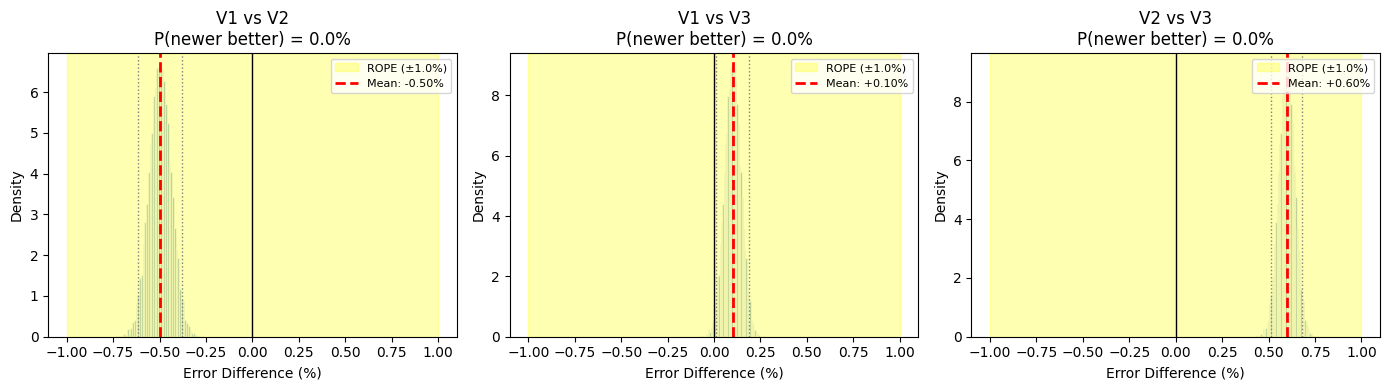


  ✓ Saved to figures/bayesian_comparison.png
  ✓ Saved: v2_statistical_results/bayesian_comparison.joblib


In [583]:
bayesian_results = run_bayesian_comparison(sample_size=500, rope=1.0)
save_statistical_result(bayesian_results, 'bayesian_comparison')

# Section 18: SHAP Analysis

In [592]:
import shap

# -----------------------------------------------------------------------------
# Config
# -----------------------------------------------------------------------------

SHAP_CONFIG = {
    'sample_size': 1000,
    'top_n_features': 10,
    'segments': SEGMENT_KEYS[5],  # Option 5 segments
}

# Storage for results
SHAP_RESULTS = {}   # {version: {segment: result_dict}}
SHAP_EXPLAINERS = {}

In [593]:
def get_segment_sample(df: pd.DataFrame, segment: str, sample_size: int = None) -> pd.DataFrame:
    """Get sample data for a segment based on LOG_BASE_PRICE percentiles."""
    sample_size = sample_size or SHAP_CONFIG['sample_size']
    
    bounds = {
        'Seg1_0-15': (0, 15), 'Seg2_15-50': (15, 50), 'Seg3_50-80': (50, 80),
        'Seg4_80-95': (80, 95), 'Seg5_95-100': (95, 100)
    }
    lo, hi = bounds[segment]
    lo_val = np.percentile(df[TARGET], lo)
    hi_val = np.percentile(df[TARGET], hi)
    
    mask = df[TARGET] >= lo_val
    if hi < 100:
        mask &= df[TARGET] < hi_val
    
    seg_df = df[mask]
    if len(seg_df) > sample_size:
        seg_df = seg_df.sample(n=sample_size, random_state=CONFIG['random_state'])
    
    return seg_df


def prepare_shap_features(df: pd.DataFrame, model_info: dict, category_encodings: dict = None) -> tuple:
    """Prepare features for SHAP, returning (X_encoded, feature_names, X_readable)."""
    num_cfg = model_info.get('num_config', 'base_3')
    cat_cfg = model_info.get('cat_config', 'all_cat')
    model_name = model_info.get('model_name', 'LightGBM')
    
    df_eng, num_cols, cat_cols = apply_feature_engineering(df.copy(), num_cfg, cat_cfg)
    feature_cols = num_cols + cat_cols
    X = df_eng[feature_cols].copy()
    X_readable = X.copy()
    
    if model_name == 'CatBoost':
        # CatBoost SHAP needs categorical columns as strings, not encoded
        for col in cat_cols:
            X[col] = X[col].astype(str)
        # Return DataFrame, not numpy array
        return X, feature_cols, X_readable
    elif model_name == 'XGBoost':
        encoder = model_info.get('encoder')
        if encoder:
            X_cat = encoder.transform(X[cat_cols])
            X_num = X[num_cols].values
            X = np.hstack([X_num, X_cat])
            cat_feature_names = encoder.get_feature_names_out(cat_cols).tolist()
            feature_cols = num_cols + cat_feature_names
        else:
            for col in cat_cols:
                X[col] = X[col].astype('category').cat.codes
            X = X.replace(-1, 0).values.astype(np.float64)
    else:
        # LightGBM: encode as integer codes
        for col in cat_cols:
            if category_encodings and col in category_encodings:
                X[col] = pd.Categorical(X[col], categories=category_encodings[col]).codes
            else:
                X[col] = X[col].astype('category').cat.codes
        X = X.replace(-1, 0).values.astype(np.float64)
    
    return X, feature_cols, X_readable

In [594]:
def compute_shap_segment(version: str, segment: str, data: pd.DataFrame,
                         sample_size: int = None) -> dict:
    """Compute SHAP values for one version/segment using new folder structure."""
    paths = get_model_paths(version)
    
    # Load model from new structure: models/option5/tuned_v3_option5_Seg1_0-15.joblib
    model_path = paths['option5_dir'] / f'tuned_{version}_option5_{segment}.joblib'
    
    if not model_path.exists():
        raise FileNotFoundError(f"Model not found: {model_path}")
    
    model_info = joblib.load(model_path)
    model = model_info['model']
    
    # Load category encodings from new structure: models/category_encodings/category_encodings_v3_opt5.joblib
    enc_path = paths['category_encodings_dir'] / f'category_encodings_{version}_opt5.joblib'
    cat_enc = joblib.load(enc_path).get(segment, {}) if enc_path.exists() else {}
    
    # Get sample
    sample = get_segment_sample(data, segment, sample_size)
    X, features, X_readable = prepare_shap_features(sample, model_info, cat_enc)
    
    # Compute SHAP
    model_name = model_info.get('model_name', 'LightGBM')
    if model_name == 'XGBoost':
        explainer = shap.Explainer(model)
    else:
        explainer = shap.TreeExplainer(model)
    
    shap_vals = explainer.shap_values(X)
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]
    
    base_val = explainer.expected_value if hasattr(explainer, 'expected_value') else np.mean(model.predict(X))
    if isinstance(base_val, (list, np.ndarray)):
        base_val = base_val[0]
    
    # Feature importance
    mean_abs = np.abs(shap_vals).mean(axis=0)
    importance = pd.DataFrame({
        'feature': features, 'importance': mean_abs,
        'importance_pct': mean_abs / mean_abs.sum() * 100
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    
    return {
        'shap_values': shap_vals, 'base_value': base_val, 'features': features,
        'X': X, 'X_readable': X_readable, 'importance': importance,
        'explainer': explainer, 'n_samples': len(sample)
    }


def compute_all_shap(versions: list = None, data: pd.DataFrame = None,
                      segments: list = None, sample_size: int = None) -> dict:
    """Compute SHAP for all versions and segments."""
    versions = versions or ['v1', 'v2', 'v3']
    segments = segments or SHAP_CONFIG['segments']
    data = data if data is not None else matched
    sample_size = sample_size or SHAP_CONFIG['sample_size']
    
    print("=" * 70)
    print(" SHAP ANALYSIS")
    print("=" * 70)
    print(f"  Versions: {versions}")
    print(f"  Segments: {len(segments)}")
    print(f"  Sample size: {sample_size}")
    
    global SHAP_RESULTS
    
    for version in versions:
        print(f"\n  [{version}]")
        SHAP_RESULTS[version] = {}
        
        for segment in segments:
            try:
                result = compute_shap_segment(version, segment, data, sample_size)
                SHAP_RESULTS[version][segment] = result
                top = result['importance'].iloc[0]
                print(f"    ✓ {segment}: Top = {top['feature']} ({top['importance_pct']:.1f}%)")
            except Exception as e:
                print(f"    ✗ {segment}: {str(e)[:50]}")
    
    print("\n" + "=" * 70)
    return SHAP_RESULTS

In [595]:
def compare_importance(segment: str, top_n: int = None) -> pd.DataFrame:
    """Compare feature importance across versions for a segment."""
    top_n = top_n or SHAP_CONFIG['top_n_features']
    
    data = {}
    for version, segs in SHAP_RESULTS.items():
        if segment in segs:
            imp = segs[segment]['importance']
            data[version] = imp.set_index('feature')['importance_pct'].to_dict()
    
    if not data:
        print(f"  No data for {segment}")
        return pd.DataFrame()
    
    all_feats = set()
    for d in data.values():
        all_feats.update(d.keys())
    
    rows = []
    for feat in all_feats:
        row = {'feature': feat}
        for v, d in data.items():
            row[v] = d.get(feat, 0)
        rows.append(row)
    
    df = pd.DataFrame(rows)
    version_cols = [c for c in df.columns if c != 'feature']
    df['avg'] = df[version_cols].mean(axis=1)
    df = df.sort_values('avg', ascending=False).head(top_n)
    
    return df


def print_importance_comparison(segments: list = None, top_n: int = None) -> None:
    """Print feature importance comparison for all segments."""
    segments = segments or SHAP_CONFIG['segments']
    top_n = top_n or SHAP_CONFIG['top_n_features']
    
    print("\n" + "=" * 70)
    print(" FEATURE IMPORTANCE COMPARISON")
    print("=" * 70)
    
    for segment in segments:
        print(f"\n{'─' * 50}")
        print(f" {segment}")
        print(f"{'─' * 50}")
        
        df = compare_importance(segment, top_n)
        if df.empty:
            continue
        
        version_cols = [c for c in df.columns if c not in ['feature', 'avg']]
        print(df[['feature'] + version_cols].round(1).to_string(index=False))
        
        # Rank changes
        if len(version_cols) >= 2:
            v1, v2 = version_cols[0], version_cols[-1]
            df[f'{v1}_rank'] = df[v1].rank(ascending=False)
            df[f'{v2}_rank'] = df[v2].rank(ascending=False)
            df['rank_change'] = df[f'{v1}_rank'] - df[f'{v2}_rank']
            
            gainers = df[df['rank_change'] > 0].nlargest(3, 'rank_change')
            if len(gainers) > 0:
                print(f"\n  ↑ More important in {v2}:")
                for _, r in gainers.iterrows():
                    print(f"     {r['feature']}: +{r['rank_change']:.0f} ranks")

In [596]:
def plot_importance_grid(figsize: tuple = (14, 10)) -> None:
    """Plot feature importance grid for all versions/segments."""
    versions = list(SHAP_RESULTS.keys())
    segments = SHAP_CONFIG['segments']
    n_v, n_s = len(versions), len(segments)
    
    if n_v == 0:
        print("  No SHAP results. Run compute_all_shap() first.")
        return
    
    fig, axes = plt.subplots(n_s, n_v, figsize=figsize)
    if n_v == 1:
        axes = axes.reshape(-1, 1)
    
    colors = ['#2ecc71', '#3498db', '#9b59b6']
    top_n = SHAP_CONFIG['top_n_features']
    
    for i, seg in enumerate(segments):
        for j, ver in enumerate(versions):
            ax = axes[i, j]
            if ver in SHAP_RESULTS and seg in SHAP_RESULTS[ver]:
                imp = SHAP_RESULTS[ver][seg]['importance'].head(top_n)
                ax.barh(range(len(imp)), imp['importance_pct'], color=colors[j % len(colors)])
                ax.set_yticks(range(len(imp)))
                ax.set_yticklabels(imp['feature'], fontsize=8)
                ax.invert_yaxis()
            else:
                ax.text(0.5, 0.5, 'N/A', ha='center', va='center')
            
            if i == 0:
                ax.set_title(ver, fontweight='bold')
            if j == 0:
                ax.set_ylabel(seg, fontsize=9)
    
    plt.tight_layout()
    plt.suptitle('SHAP Feature Importance', y=1.01, fontsize=14, fontweight='bold')
    plt.savefig(PROJECT_ROOT / 'shap_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("  ✓ Saved: shap_comparison.png")


def plot_beeswarm(version: str, segment: str, max_display: int = 12) -> None:
    """Plot SHAP beeswarm for a version/segment."""
    if version not in SHAP_RESULTS or segment not in SHAP_RESULTS[version]:
        print(f"  No results for {version}/{segment}")
        return
    
    result = SHAP_RESULTS[version][segment]
    plt.figure(figsize=(10, 6))
    shap.summary_plot(result['shap_values'], result['X_readable'],
                      max_display=max_display, show=False)
    plt.title(f'{version} - {segment}', fontweight='bold')
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / f'shap_beeswarm_{version}_{segment}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [597]:
def explain_property(version: str, postcode_sector: str, old_new: str, tenure_type: str,
                     property_type: str, built_form: str, total_floor_area: float,
                     local_authority_label: str, number_bedrooms: int, number_bathrooms: int,
                     current_energy_rating: str, listing_price: float = None) -> dict:
    """Explain prediction for a single property using new folder structure."""
    paths = get_model_paths(version)
    
    # Prepare input
    input_df = prepare_input(
        postcode_sector=postcode_sector, old_new=old_new, tenure_type=tenure_type,
        property_type=property_type, built_form=built_form,
        total_floor_area=total_floor_area, local_authority_label=local_authority_label,
        number_bedrooms=number_bedrooms, number_bathrooms=number_bathrooms,
        current_energy_rating=current_energy_rating)
    
    # Get prediction to determine segment
    preds = predict_all_options(input_df)
    est = np.mean(list(preds.values()))
    segment = get_segment_key(est, 5, PERCENTILES)
    
    if version not in SHAP_RESULTS or segment not in SHAP_RESULTS[version]:
        print(f"  Computing SHAP for {version}/{segment}...")
        compute_shap_segment(version, segment, matched)
    
    result = SHAP_RESULTS[version][segment]
    explainer = result['explainer']
    
    # Load model info from new structure
    model_path = paths['option5_dir'] / f'tuned_{version}_option5_{segment}.joblib'
    model_info = joblib.load(model_path)
    
    # Load category encodings from new structure
    enc_path = paths['category_encodings_dir'] / f'category_encodings_{version}_opt5.joblib'
    cat_enc = joblib.load(enc_path).get(segment, {}) if enc_path.exists() else {}
    
    # Prepare features
    model_name = model_info.get('model_name', 'LightGBM')
    num_cfg = model_info.get('num_config', 'base_3')
    cat_cfg = model_info.get('cat_config', 'all_cat')
    
    df_eng, num_cols, cat_cols = apply_feature_engineering(input_df.copy(), num_cfg, cat_cfg)
    feature_cols = num_cols + cat_cols
    X_readable = df_eng[feature_cols].copy()
    
    if model_name == 'XGBoost':
        encoder = model_info.get('encoder')
        if encoder:
            X_cat = encoder.transform(df_eng[cat_cols])
            X_num = df_eng[num_cols].values
            X = np.hstack([X_num, X_cat])
            feature_cols = num_cols + list(encoder.get_feature_names_out(cat_cols))
        else:
            for col in cat_cols:
                df_eng[col] = df_eng[col].astype('category').cat.codes
            X = df_eng[feature_cols].replace(-1, 0).values.astype(np.float64)
    elif model_name == 'CatBoost':
        for col in cat_cols:
            df_eng[col] = df_eng[col].astype(str)
        X = df_eng[feature_cols]
    else:
        # LightGBM
        for col in cat_cols:
            if cat_enc and col in cat_enc:
                df_eng[col] = pd.Categorical(df_eng[col], categories=cat_enc[col]).codes
            else:
                df_eng[col] = df_eng[col].astype('category').cat.codes
        X = df_eng[feature_cols].replace(-1, 0).values.astype(np.float64)
    
    # Get SHAP values
    shap_vals = explainer.shap_values(X)
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]
    
    base_gbp = np.exp(result['base_value'])
    
    # Build contributions
    contributions = []
    for i, feat in enumerate(feature_cols):
        sv = shap_vals[0][i]
        gbp = base_gbp * (np.exp(sv) - 1)
        
        # Get readable value
        if model_name == 'XGBoost' and '_' in feat and feat not in X_readable.columns:
            base_feat = feat.rsplit('_', 1)[0]
            val = X_readable.iloc[0].get(base_feat, feat.split('_')[-1])
        else:
            val = X_readable.iloc[0].get(feat, 'N/A')
        
        contributions.append({
            'feature': feat, 'value': val,
            'shap_log': sv, 'gbp_impact': gbp, 'direction': '↑' if sv > 0 else '↓'
        })
    
    contributions = sorted(contributions, key=lambda x: abs(x['shap_log']), reverse=True)
    pred_log = result['base_value'] + sum(c['shap_log'] for c in contributions)
    pred_gbp = np.exp(pred_log)
    
    # Display
    print(f"\n{'=' * 60}")
    print(f" PROPERTY EXPLANATION - {version} / {segment}")
    print(f"{'=' * 60}")
    print(f"  Benchmark: £{base_gbp:,.0f}")
    print(f"  Predicted: £{pred_gbp:,.0f}")
    
    if listing_price:
        diff = (listing_price - pred_gbp) / pred_gbp * 100
        print(f"  Listing:   £{listing_price:,.0f} ({diff:+.1f}%)")
    
    print(f"\n  Top factors INCREASING value:")
    for c in [x for x in contributions if x['direction'] == '↑'][:5]:
        print(f"    {c['direction']} {c['feature']}: +£{c['gbp_impact']:,.0f} ({c['value']})")
    
    print(f"\n  Top factors DECREASING value:")
    for c in [x for x in contributions if x['direction'] == '↓'][:5]:
        print(f"    {c['direction']} {c['feature']}: £{c['gbp_impact']:,.0f} ({c['value']})")
    
    return {
        'version': version, 'segment': segment, 'benchmark_gbp': base_gbp,
        'predicted_gbp': pred_gbp, 'contributions': contributions
    }

In [598]:
def compare_explanations(versions: list = None, **property_kwargs) -> pd.DataFrame:
    """Compare SHAP explanations across versions for a single property."""
    versions = versions or list(SHAP_RESULTS.keys())
    
    results = {}
    for version in versions:
        try:
            results[version] = explain_property(version=version, **property_kwargs)
        except Exception as e:
            print(f"  ⚠ {version}: {e}")
    
    if not results:
        return pd.DataFrame()
    
    # Build comparison
    all_feats = set()
    for r in results.values():
        all_feats.update(c['feature'] for c in r['contributions'])
    
    rows = []
    for feat in all_feats:
        row = {'feature': feat}
        for v, r in results.items():
            c = next((x for x in r['contributions'] if x['feature'] == feat), None)
            row[f'{v}_£'] = c['gbp_impact'] if c else 0
        rows.append(row)
    
    df = pd.DataFrame(rows)
    gbp_cols = [c for c in df.columns if c.endswith('_£')]
    df['avg_abs'] = df[gbp_cols].abs().mean(axis=1)
    df = df.sort_values('avg_abs', ascending=False).drop('avg_abs', axis=1)
    
    # Print summary
    print(f"\n{'=' * 80}")
    print(" CROSS-VERSION COMPARISON")
    print(f"{'=' * 80}")
    print(f"\n  {'Version':<20} {'Segment':<15} {'Predicted':>15}")
    print("  " + "-" * 55)
    for v, r in results.items():
        print(f"  {v:<20} {r['segment']:<15} £{r['predicted_gbp']:>13,.0f}")
    
    print(f"\n  Feature contributions (£):")
    for col in gbp_cols:
        df[col] = df[col].apply(lambda x: f"£{x:+,.0f}")
    print(df[['feature'] + gbp_cols].head(10).to_string(index=False))
    
    return df


print("  ✓ SHAP analysis ready")

  ✓ SHAP analysis ready


In [599]:
# Compute SHAP for all versions
SHAP_RESULTS = compute_all_shap(['v1', 'v2', 'v3'], matched)

 SHAP ANALYSIS
  Versions: ['v1', 'v2', 'v3']
  Segments: 5
  Sample size: 1000

  [v1]
    ✓ Seg1_0-15: Top = LOCAL_AUTHORITY_LABEL (19.9%)
    ✓ Seg2_15-50: Top = TOTAL_FLOOR_AREA (21.8%)
    ✓ Seg3_50-80: Top = TOTAL_FLOOR_AREA (28.5%)
    ✓ Seg4_80-95: Top = POSTCODE_SECTOR (24.4%)
    ✓ Seg5_95-100: Top = TOTAL_FLOOR_AREA (29.3%)

  [v2]
    ✓ Seg1_0-15: Top = TOTAL_FLOOR_AREA (21.3%)
    ✓ Seg2_15-50: Top = PROPERTY_TYPE (23.8%)
    ✓ Seg3_50-80: Top = TOTAL_FLOOR_AREA (26.8%)
    ✓ Seg4_80-95: Top = TOTAL_FLOOR_AREA (27.0%)
    ✓ Seg5_95-100: Top = TOTAL_FLOOR_AREA (27.4%)

  [v3]
    ✓ Seg1_0-15: Top = LOCAL_AUTHORITY_LABEL (18.8%)
    ✓ Seg2_15-50: Top = POSTCODE_SECTOR (18.4%)
    ✓ Seg3_50-80: Top = TOTAL_FLOOR_AREA (30.5%)
    ✓ Seg4_80-95: Top = TOTAL_FLOOR_AREA (29.0%)
    ✓ Seg5_95-100: Top = TOTAL_FLOOR_AREA (28.9%)



In [600]:
# Print importance comparison
print_importance_comparison()


 FEATURE IMPORTANCE COMPARISON

──────────────────────────────────────────────────
 Seg1_0-15
──────────────────────────────────────────────────
              feature   v1   v2   v3
     TOTAL_FLOOR_AREA 14.4 21.3  3.6
LOCAL_AUTHORITY_LABEL 19.9  0.0 18.8
      POSTCODE_SECTOR 15.2  0.0 18.2
        PROPERTY_TYPE 13.8  0.0 11.5
      NUMBER_BEDROOMS  8.5  7.4  4.0
           BUILT_FORM  4.4  0.0  5.8
CURRENT_ENERGY_RATING  4.4  0.0  4.7
BEDROOMS_PER_BATHROOM  8.1  0.0  0.0
    AREA_PER_BATHROOM  4.6  0.0  3.4
          TENURE_TYPE  2.7  0.0  5.1

  ↑ More important in v3:
     TENURE_TYPE: +5 ranks
     BUILT_FORM: +4 ranks
     CURRENT_ENERGY_RATING: +3 ranks

──────────────────────────────────────────────────
 Seg2_15-50
──────────────────────────────────────────────────
              feature   v1   v2   v3
      POSTCODE_SECTOR 18.6 22.9 18.4
        PROPERTY_TYPE 17.2 23.8 16.5
     TOTAL_FLOOR_AREA 21.8  8.1  6.5
LOCAL_AUTHORITY_LABEL 17.7  0.0 15.6
           BUILT_FORM  8.8  8.

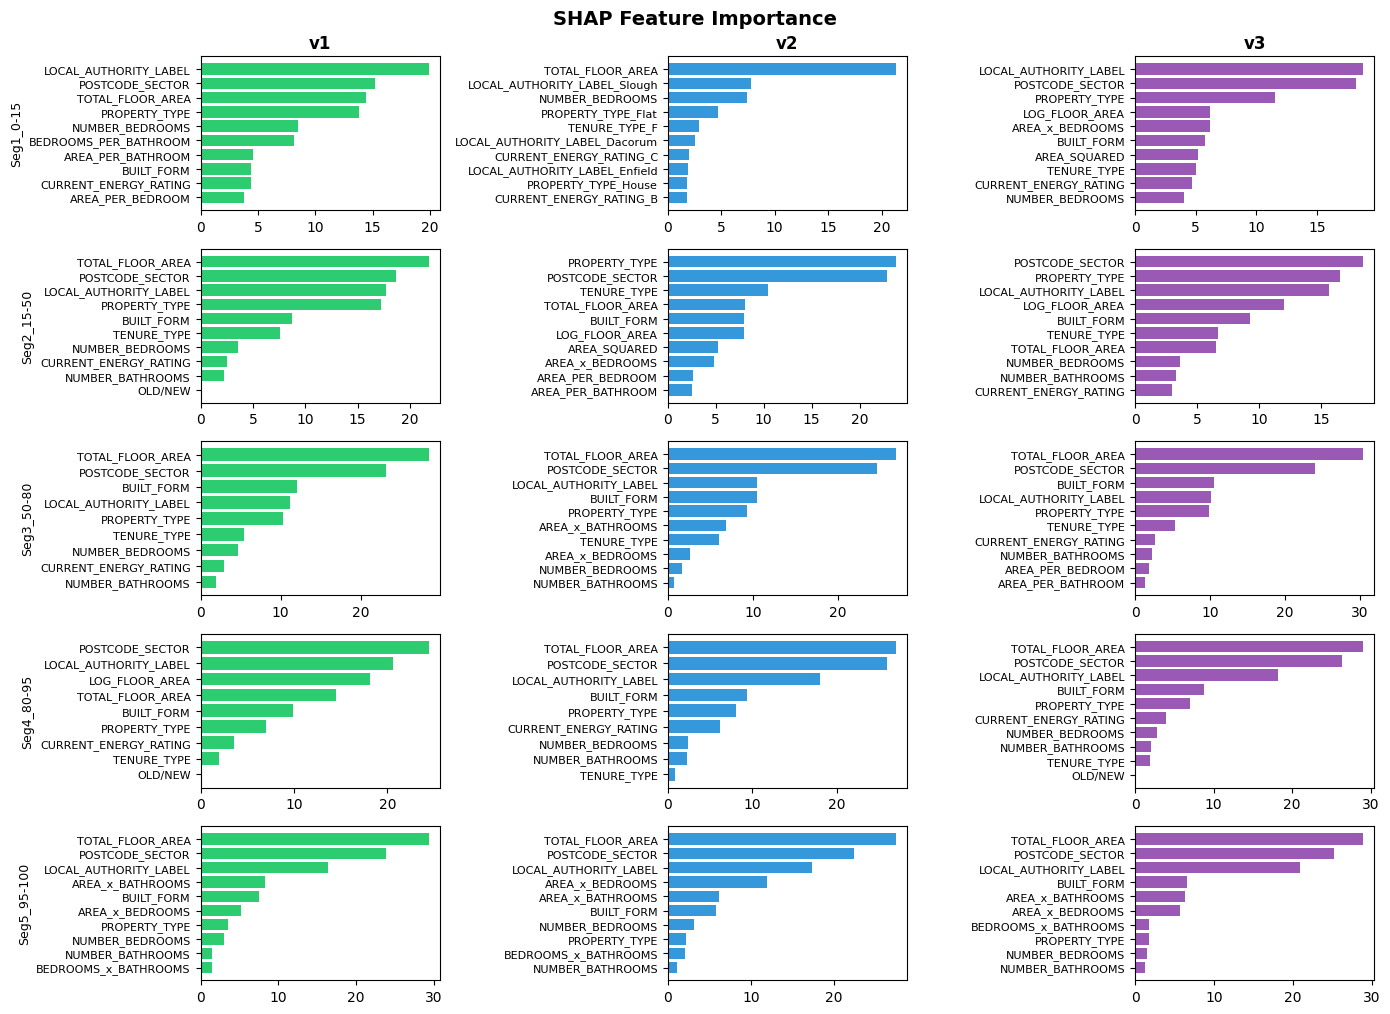

  ✓ Saved: shap_comparison.png


In [601]:
# Plot grid
plot_importance_grid()

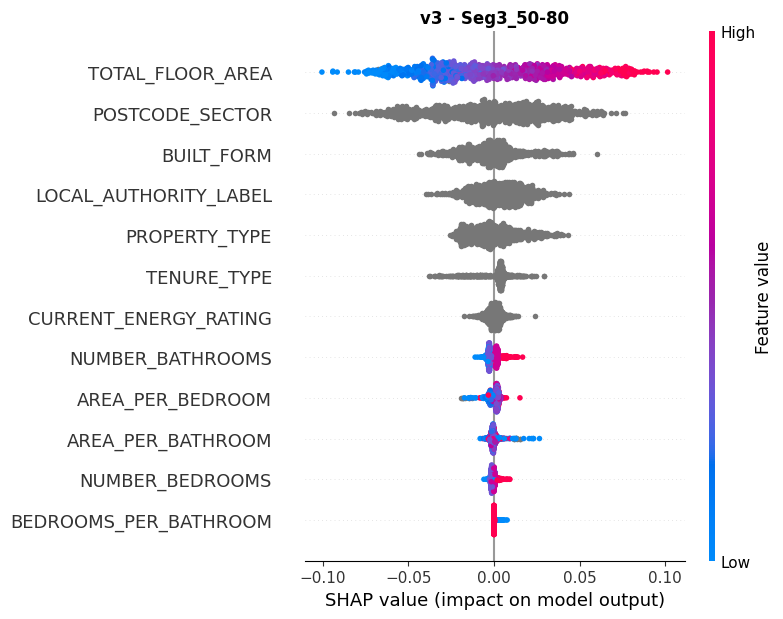

In [602]:
# Beeswarm for specific version/segment
plot_beeswarm('v3', 'Seg3_50-80')

In [603]:
# Explain single property
explain_property(
    version='v3', postcode_sector='HA4 8', old_new='O', tenure_type='F',
    property_type='House', built_form='Detached', total_floor_area=317,
    local_authority_label='Hillingdon', number_bedrooms=6, number_bathrooms=4,
    current_energy_rating='C', listing_price=1650000)

# Compare across versions
compare_explanations(
    versions=['v1', 'v2', 'v3'], postcode_sector='HA4 8', old_new='O',
    tenure_type='F', property_type='House', built_form='Detached',
    total_floor_area=317, local_authority_label='Hillingdon',
    number_bedrooms=6, number_bathrooms=4, current_energy_rating='C',
    listing_price=1650000)


 PROPERTY EXPLANATION - v3 / Seg5_95-100
  Benchmark: £1,829,722
  Predicted: £1,775,779
  Listing:   £1,650,000 (-7.1%)

  Top factors INCREASING value:
    ↑ TOTAL_FLOOR_AREA: +£211,480 (317)
    ↑ AREA_x_BEDROOMS: +£7,560 (1902)
    ↑ BEDROOMS_x_BATHROOMS: +£308 (24)
    ↑ OLD/NEW: +£53 (O)

  Top factors DECREASING value:
    ↓ POSTCODE_SECTOR: £-123,438 (HA4 8)
    ↓ LOCAL_AUTHORITY_LABEL: £-80,735 (Hillingdon)
    ↓ BUILT_FORM: £-30,227 (Detached)
    ↓ PROPERTY_TYPE: £-17,188 (House)
    ↓ NUMBER_BATHROOMS: £-2,395 (4)

 PROPERTY EXPLANATION - v1 / Seg5_95-100
  Benchmark: £1,851,851
  Predicted: £1,744,658
  Listing:   £1,650,000 (-5.4%)

  Top factors INCREASING value:
    ↑ TOTAL_FLOOR_AREA: +£161,470 (317)
    ↑ AREA_x_BATHROOMS: +£13,566 (1268)
    ↑ PROPERTY_TYPE: +£7,589 (House)

  Top factors DECREASING value:
    ↓ POSTCODE_SECTOR: £-155,345 (HA4 8)
    ↓ LOCAL_AUTHORITY_LABEL: £-73,428 (Hillingdon)
    ↓ BEDROOMS_x_BATHROOMS: £-18,664 (24)
    ↓ BUILT_FORM: £-18,575 (

,feature,v1_£,v2_£,v3_£
4,TOTAL_FLOOR_AREA,"£+161,470","£+193,325","£+211,480"
9,POSTCODE_SECTOR,"£-155,345","£-129,670","£-123,438"
3,LOCAL_AUTHORITY_LABEL,"£-73,428","£-62,561","£-80,735"
10,BUILT_FORM,"£-18,575","£-1,533","£-30,227"
11,AREA_x_BATHROOMS,"£+13,566","£-20,481",£-759
5,PROPERTY_TYPE,"£+7,589","£+3,435","£-17,188"
7,BEDROOMS_x_BATHROOMS,"£-18,664","£+7,370",£+308
8,AREA_x_BEDROOMS,"£-6,771","£-2,291","£+7,560"
2,NUMBER_BEDROOMS,"£-1,253","£-8,572","£-1,256"
1,NUMBER_BATHROOMS,"£-3,427","£-5,098","£-2,395"


## Statistical test 11: Bootstrap SHAP Confidence Intervals

In [607]:
SHAP_BOOTSTRAP_CONFIG = {
    'n_bootstrap': 100,  # Lower than metrics bootstrap due to SHAP computation cost
    'sample_size': 500,
    'ci_level': 0.95,
    'random_state': CONFIG['random_state'],
}

In [608]:
def bootstrap_shap_importance(version: str, segment: str, data: pd.DataFrame,
                               n_bootstrap: int = None, sample_size: int = None) -> dict:
    """
    Compute bootstrap confidence intervals for SHAP feature importance.
    
    Parameters
    ----------
    version : str
        Model version ('v1', 'v2', 'v3').
    segment : str
        Price segment.
    data : pd.DataFrame
        Full dataset to sample from.
    n_bootstrap : int
        Number of bootstrap iterations.
    sample_size : int
        Sample size per iteration.
        
    Returns
    -------
    dict
        Feature importance with confidence intervals.
    """
    n_bootstrap = n_bootstrap or SHAP_BOOTSTRAP_CONFIG['n_bootstrap']
    sample_size = sample_size or SHAP_BOOTSTRAP_CONFIG['sample_size']
    ci_level = SHAP_BOOTSTRAP_CONFIG['ci_level']
    alpha = 1 - ci_level
    
    # Load model and encodings using NEW folder structure
    paths = get_model_paths(version)
    
    # Model: models/option5/tuned_v3_option5_Seg1_0-15.joblib
    model_path = paths['option5_dir'] / f'tuned_{version}_option5_{segment}.joblib'
    if not model_path.exists():
        raise FileNotFoundError(f"Model not found: {model_path}")
    
    model_info = joblib.load(model_path)
    model = model_info['model']
    
    # Encodings: models/category_encodings/category_encodings_v3_opt5.joblib
    enc_path = paths['category_encodings_dir'] / f'category_encodings_{version}_opt5.joblib'
    cat_enc = joblib.load(enc_path).get(segment, {}) if enc_path.exists() else {}
    
    # Get segment data
    seg_data = get_segment_sample(data, segment, sample_size=len(data))
    
    # Create explainer once
    sample_for_explainer = get_segment_sample(data, segment, sample_size=100)
    X_exp, features, _ = prepare_shap_features(sample_for_explainer, model_info, cat_enc)
    
    model_name = model_info.get('model_name', 'LightGBM')
    if model_name == 'XGBoost':
        explainer = shap.Explainer(model)
    else:
        explainer = shap.TreeExplainer(model)
    
    # Bootstrap iterations
    np.random.seed(SHAP_BOOTSTRAP_CONFIG['random_state'])
    boot_importance = {feat: [] for feat in features}
    boot_ranks = {feat: [] for feat in features}
    
    for b in range(n_bootstrap):
        # Sample with replacement
        boot_sample = seg_data.sample(n=min(sample_size, len(seg_data)), replace=True,
                                       random_state=SHAP_BOOTSTRAP_CONFIG['random_state'] + b)
        
        X, _, _ = prepare_shap_features(boot_sample, model_info, cat_enc)
        
        # Compute SHAP
        shap_vals = explainer.shap_values(X)
        if isinstance(shap_vals, list):
            shap_vals = shap_vals[0]
        
        # Mean absolute SHAP
        mean_abs = np.abs(shap_vals).mean(axis=0)
        total = mean_abs.sum()
        
        # Store importance and ranks
        importance_pct = mean_abs / total * 100
        ranks = np.argsort(np.argsort(-importance_pct)) + 1  # 1 = most important
        
        for i, feat in enumerate(features):
            boot_importance[feat].append(importance_pct[i])
            boot_ranks[feat].append(ranks[i])
    
    # Compute statistics
    results = []
    for feat in features:
        imp = np.array(boot_importance[feat])
        rnk = np.array(boot_ranks[feat])
        
        results.append({
            'feature': feat,
            'mean_importance': np.mean(imp),
            'std_importance': np.std(imp),
            'ci_lower': np.percentile(imp, 100 * alpha / 2),
            'ci_upper': np.percentile(imp, 100 * (1 - alpha / 2)),
            'mean_rank': np.mean(rnk),
            'rank_std': np.std(rnk),
            'rank_ci_lower': np.percentile(rnk, 100 * alpha / 2),
            'rank_ci_upper': np.percentile(rnk, 100 * (1 - alpha / 2)),
            'rank_stable': np.std(rnk) < 1.0,
        })
    
    results_df = pd.DataFrame(results).sort_values('mean_importance', ascending=False)
    
    return {
        'results': results_df,
        'n_bootstrap': n_bootstrap,
        'sample_size': sample_size,
        'ci_level': ci_level,
        'features': features,
    }


def run_shap_bootstrap_analysis(version: str = 'v3', segments: list = None,
                                 n_bootstrap: int = None) -> dict:
    """
    Run bootstrap SHAP analysis for multiple segments.
    """
    segments = segments or SHAP_CONFIG['segments']
    n_bootstrap = n_bootstrap or SHAP_BOOTSTRAP_CONFIG['n_bootstrap']
    
    print("=" * 70)
    print(f" BOOTSTRAP SHAP CONFIDENCE INTERVALS - {version.upper()}")
    print("=" * 70)
    print(f"\n  Bootstrap iterations: {n_bootstrap}")
    print(f"  CI level: {SHAP_BOOTSTRAP_CONFIG['ci_level']:.0%}")
    
    all_results = {}
    
    for segment in segments:
        print(f"\n  [{segment}] Running {n_bootstrap} bootstrap iterations...")
        
        try:
            result = bootstrap_shap_importance(version, segment, matched, n_bootstrap)
            all_results[segment] = result
            
            # Show top 5 features with CIs
            top5 = result['results'].head(5)
            print(f"\n    Top 5 Features (with {int(SHAP_BOOTSTRAP_CONFIG['ci_level']*100)}% CI):")
            print(f"    {'Feature':<25} {'Importance':>12} {'CI':>20} {'Rank':>8} {'Stable':>8}")
            print("    " + "-" * 75)
            
            for _, row in top5.iterrows():
                ci_str = f"[{row['ci_lower']:.1f}% - {row['ci_upper']:.1f}%]"
                stable = "✓" if row['rank_stable'] else "~"
                print(f"    {row['feature']:<25} {row['mean_importance']:>11.1f}% {ci_str:>20} "
                      f"{row['mean_rank']:>7.1f} {stable:>8}")
                
        except Exception as e:
            print(f"    ✗ Error: {str(e)[:80]}")
    
    # Check if we have any results before proceeding
    if not all_results:
        print("\n  ⚠ No segments completed successfully. Check model paths.")
        return {}
    
    # Cross-segment stability summary
    print("\n" + "=" * 70)
    print(" FEATURE RANKING STABILITY SUMMARY")
    print("=" * 70)
    
    # Find features that are consistently top-ranked
    feature_ranks = {}
    for segment, result in all_results.items():
        for _, row in result['results'].iterrows():
            feat = row['feature']
            if feat not in feature_ranks:
                feature_ranks[feat] = []
            feature_ranks[feat].append(row['mean_rank'])
    
    print(f"\n  {'Feature':<25} {'Avg Rank':>10} {'Rank Std':>10} {'Consistent':>12}")
    print("  " + "-" * 60)
    
    stability_data = []
    for feat, ranks in feature_ranks.items():
        avg_rank = np.mean(ranks)
        std_rank = np.std(ranks)
        consistent = "✓✓" if std_rank < 1 else "✓" if std_rank < 2 else "~"
        stability_data.append((feat, avg_rank, std_rank, consistent))
    
    stability_data.sort(key=lambda x: x[1])
    
    for feat, avg, std, cons in stability_data[:10]:
        print(f"  {feat:<25} {avg:>10.1f} {std:>10.2f} {cons:>12}")
    
    # Interpretation (with safety check)
    print("\n" + "-" * 70)
    print(" INTERPRETATION")
    print("-" * 70)
    
    if stability_data:
        top_feat = stability_data[0][0]
        top_std = stability_data[0][2]
        
        if top_std < 0.5:
            print(f"\n  ✓✓ '{top_feat}' is DEFINITIVELY the most important feature")
            print(f"     Rank standard deviation: {top_std:.2f} (very stable)")
        elif top_std < 1.0:
            print(f"\n  ✓ '{top_feat}' is LIKELY the most important feature")
            print(f"     Rank standard deviation: {top_std:.2f} (stable)")
        else:
            print(f"\n  ~ '{top_feat}' has the best average rank but shows variability")
            print(f"     Rank standard deviation: {top_std:.2f}")
    else:
        print("\n  ⚠ No stability data available")
    
    return all_results

In [611]:
# Run bootstrap SHAP analysis
shap_bootstrap_results = run_shap_bootstrap_analysis(version='v1', n_bootstrap=50)
save_statistical_result(shap_bootstrap_results, 'v1_shap_CIs')

 BOOTSTRAP SHAP CONFIDENCE INTERVALS - V1

  Bootstrap iterations: 50
  CI level: 95%

  [Seg1_0-15] Running 50 bootstrap iterations...

    Top 5 Features (with 95% CI):
    Feature                     Importance                   CI     Rank   Stable
    ---------------------------------------------------------------------------
    LOCAL_AUTHORITY_LABEL            20.1%      [19.0% - 21.7%]     1.0        ✓
    POSTCODE_SECTOR                  15.0%      [14.1% - 16.0%]     2.3        ✓
    TOTAL_FLOOR_AREA                 14.4%      [13.6% - 15.1%]     2.9        ✓
    PROPERTY_TYPE                    13.7%      [12.4% - 14.6%]     3.8        ✓
    NUMBER_BEDROOMS                   8.6%        [8.2% - 8.9%]     5.0        ✓

  [Seg2_15-50] Running 50 bootstrap iterations...

    Top 5 Features (with 95% CI):
    Feature                     Importance                   CI     Rank   Stable
    ---------------------------------------------------------------------------
    TOTAL_FLOO

## Statistical test 12: Cross-Segment SHAP Rank Correlation

In [612]:
from scipy.stats import spearmanr, kendalltau
from itertools import combinations


def compute_rank_correlation(importance1: pd.DataFrame, importance2: pd.DataFrame,
                              method: str = 'spearman') -> dict:
    """
    Compute rank correlation between two importance DataFrames.

    Parameters
    ----------
    importance1 : pd.DataFrame
        First importance DataFrame with 'feature' and 'importance' columns.
    importance2 : pd.DataFrame
        Second importance DataFrame.
    method : str
        'spearman' or 'kendall'.

    Returns
    -------
    dict
        Correlation coefficient and p-value.
    """
    # Align features
    common = set(importance1['feature']) & set(importance2['feature'])
    
    imp1 = importance1[importance1['feature'].isin(common)].set_index('feature')
    imp2 = importance2[importance2['feature'].isin(common)].set_index('feature')
    
    # Get ranks
    ranks1 = imp1['importance'].rank(ascending=False)
    ranks2 = imp2.loc[ranks1.index, 'importance'].rank(ascending=False)
    
    if method == 'spearman':
        corr, p_val = spearmanr(ranks1, ranks2)
    elif method == 'kendall':
        corr, p_val = kendalltau(ranks1, ranks2)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return {'correlation': corr, 'p_value': p_val, 'n_features': len(common)}


def run_cross_segment_correlation(version: str = 'v3') -> dict:
    """
    Analyze SHAP feature importance correlation across segments.

    Parameters
    ----------
    version : str
        Model version to analyze.

    Returns
    -------
    dict
        Correlation matrix and analysis results.
    """
    print("=" * 70)
    print(f" CROSS-SEGMENT SHAP CORRELATION - {version.upper()}")
    print("=" * 70)
    
    if version not in SHAP_RESULTS:
        print(f"  ⚠ No SHAP results for {version}. Run compute_all_shap() first.")
        return None
    
    segments = list(SHAP_RESULTS[version].keys())
    n_segs = len(segments)
    
    print(f"\n  Segments: {n_segs}")
    print(f"  Comparing feature importance rankings across price segments")
    
    # Compute pairwise correlations
    correlations = {}
    
    print("\n" + "-" * 70)
    print(" PAIRWISE SPEARMAN CORRELATIONS")
    print("-" * 70)
    
    # Create correlation matrix
    corr_matrix = np.zeros((n_segs, n_segs))
    
    for i, seg1 in enumerate(segments):
        for j, seg2 in enumerate(segments):
            if i == j:
                corr_matrix[i, j] = 1.0
            elif i < j:
                imp1 = SHAP_RESULTS[version][seg1]['importance']
                imp2 = SHAP_RESULTS[version][seg2]['importance']
                
                result = compute_rank_correlation(imp1, imp2, method='spearman')
                corr_matrix[i, j] = result['correlation']
                corr_matrix[j, i] = result['correlation']
                
                correlations[(seg1, seg2)] = result
    
    # Print correlation matrix
    print(f"\n  {'':15}", end="")
    for seg in segments:
        print(f"{seg[:8]:>10}", end="")
    print()
    print("  " + "-" * (15 + 10 * n_segs))
    
    for i, seg1 in enumerate(segments):
        print(f"  {seg1[:13]:<15}", end="")
        for j, seg2 in enumerate(segments):
            val = corr_matrix[i, j]
            if i == j:
                print(f"{'1.00':>10}", end="")
            else:
                # Color coding via symbols
                symbol = "✓" if val > 0.7 else "~" if val > 0.5 else "⚠"
                print(f"{val:>8.2f}{symbol:>2}", end="")
        print()
    
    # Summary statistics
    off_diag = [corr_matrix[i, j] for i in range(n_segs) for j in range(n_segs) if i < j]
    
    print("\n" + "-" * 70)
    print(" CORRELATION SUMMARY")
    print("-" * 70)
    
    print(f"\n  Mean correlation:   {np.mean(off_diag):.3f}")
    print(f"  Median correlation: {np.median(off_diag):.3f}")
    print(f"  Min correlation:    {np.min(off_diag):.3f}")
    print(f"  Max correlation:    {np.max(off_diag):.3f}")
    print(f"  Std correlation:    {np.std(off_diag):.3f}")
    
    # Find most/least similar pairs
    pair_corrs = [(pair, res['correlation']) for pair, res in correlations.items()]
    pair_corrs.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n  Most similar segments:")
    for (s1, s2), corr in pair_corrs[:3]:
        print(f"    {s1} ↔ {s2}: ρ = {corr:.3f}")
    
    print(f"\n  Least similar segments:")
    for (s1, s2), corr in pair_corrs[-3:]:
        print(f"    {s1} ↔ {s2}: ρ = {corr:.3f}")
    
    # Test for overall consistency
    print("\n" + "-" * 70)
    print(" CONSISTENCY ANALYSIS")
    print("-" * 70)
    
    avg_corr = np.mean(off_diag)
    
    if avg_corr > 0.8:
        print(f"\n  ✓✓ HIGHLY CONSISTENT: Feature importance is very similar across segments")
        print(f"     Average ρ = {avg_corr:.3f}")
        print(f"     → Same features drive predictions regardless of price range")
    elif avg_corr > 0.6:
        print(f"\n  ✓ MODERATELY CONSISTENT: Feature importance is fairly similar")
        print(f"     Average ρ = {avg_corr:.3f}")
        print(f"     → Core features matter everywhere, with some segment-specific variation")
    elif avg_corr > 0.4:
        print(f"\n  ~ PARTIAL CONSISTENCY: Some similarity in feature importance")
        print(f"     Average ρ = {avg_corr:.3f}")
        print(f"     → Different price segments may need different feature emphasis")
    else:
        print(f"\n  ⚠ LOW CONSISTENCY: Feature importance varies substantially")
        print(f"     Average ρ = {avg_corr:.3f}")
        print(f"     → Segment-specific models capture different relationships")
    
    # Identify universally important features
    print("\n" + "-" * 70)
    print(" UNIVERSALLY IMPORTANT FEATURES")
    print("-" * 70)
    
    # Get top 5 features from each segment
    top_features = {}
    for seg in segments:
        imp = SHAP_RESULTS[version][seg]['importance']
        for _, row in imp.head(5).iterrows():
            feat = row['feature']
            if feat not in top_features:
                top_features[feat] = {'count': 0, 'segments': [], 'avg_importance': []}
            top_features[feat]['count'] += 1
            top_features[feat]['segments'].append(seg)
            top_features[feat]['avg_importance'].append(row['importance_pct'])
    
    # Features in top-5 across multiple segments
    universal = [(f, d) for f, d in top_features.items() if d['count'] >= 3]
    universal.sort(key=lambda x: x[1]['count'], reverse=True)
    
    print(f"\n  Features in top-5 across 3+ segments:")
    print(f"\n  {'Feature':<25} {'Segments':>10} {'Avg Importance':>15}")
    print("  " + "-" * 52)
    
    for feat, data in universal:
        avg_imp = np.mean(data['avg_importance'])
        print(f"  {feat:<25} {data['count']:>10} {avg_imp:>14.1f}%")
    
    if not universal:
        print("  (No features appear in top-5 across 3+ segments)")
    
    # Plot correlation heatmap
    plot_segment_correlation_heatmap(corr_matrix, segments, version)
    
    return {
        'correlation_matrix': corr_matrix,
        'pairwise': correlations,
        'summary': {
            'mean': np.mean(off_diag),
            'median': np.median(off_diag),
            'min': np.min(off_diag),
            'max': np.max(off_diag),
        },
        'universal_features': universal,
    }


def plot_segment_correlation_heatmap(corr_matrix: np.ndarray, segments: list,
                                      version: str) -> None:
    """
    Plot correlation heatmap for segment SHAP importance.

    Parameters
    ----------
    corr_matrix : np.ndarray
        Correlation matrix.
    segments : list
        Segment names.
    version : str
        Model version.
    """
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # Create heatmap
    im = ax.imshow(corr_matrix, cmap='RdYlGn', vmin=0, vmax=1)
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Spearman Correlation', rotation=-90, va="bottom")
    
    # Set ticks
    short_names = [s.replace('_', '\n') for s in segments]
    ax.set_xticks(np.arange(len(segments)))
    ax.set_yticks(np.arange(len(segments)))
    ax.set_xticklabels(short_names, fontsize=9)
    ax.set_yticklabels(short_names, fontsize=9)
    
    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add correlation values
    for i in range(len(segments)):
        for j in range(len(segments)):
            val = corr_matrix[i, j]
            color = 'white' if val < 0.5 else 'black'
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=color, fontsize=10)
    
    ax.set_title(f'SHAP Feature Importance Correlation\nAcross Segments ({version})', fontsize=12)
    
    plt.tight_layout()
    (PROJECT_ROOT / 'figures').mkdir(exist_ok=True)
    plt.savefig(PROJECT_ROOT / 'figures' / f'shap_segment_correlation_{version}.png', 
                dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n  ✓ Saved to figures/shap_segment_correlation_{version}.png")


def compare_version_shap_consistency() -> dict:
    """
    Compare SHAP consistency across versions.

    Returns
    -------
    dict
        Consistency metrics by version.
    """
    print("\n" + "=" * 70)
    print(" CROSS-VERSION SHAP CONSISTENCY COMPARISON")
    print("=" * 70)
    
    results = {}
    
    for version in SHAP_RESULTS.keys():
        segments = list(SHAP_RESULTS[version].keys())
        n_segs = len(segments)
        
        # Compute pairwise correlations
        corrs = []
        for i, seg1 in enumerate(segments):
            for j, seg2 in enumerate(segments):
                if i < j:
                    imp1 = SHAP_RESULTS[version][seg1]['importance']
                    imp2 = SHAP_RESULTS[version][seg2]['importance']
                    result = compute_rank_correlation(imp1, imp2)
                    corrs.append(result['correlation'])
        
        if corrs:  # Only if we have correlations
            results[version] = {
                'mean_corr': np.mean(corrs),
                'std_corr': np.std(corrs),
                'min_corr': np.min(corrs),
            }
        else:
            results[version] = {
                'mean_corr': np.nan,
                'std_corr': np.nan,
                'min_corr': np.nan,
            }
    
    print(f"\n  {'Version':<12} {'Mean ρ':>10} {'Std':>10} {'Min':>10} {'Consistency':>15}")
    print("  " + "-" * 57)
    
    for ver, res in results.items():
        cons = "High ✓✓" if res['mean_corr'] > 0.8 else "Moderate ✓" if res['mean_corr'] > 0.6 else "Low ~"
        print(f"  {ver:<12} {res['mean_corr']:>10.3f} {res['std_corr']:>10.3f} "
              f"{res['min_corr']:>10.3f} {cons:>15}")
    
    return results

 CROSS-SEGMENT SHAP CORRELATION - V3

  Segments: 5
  Comparing feature importance rankings across price segments

----------------------------------------------------------------------
 PAIRWISE SPEARMAN CORRELATIONS
----------------------------------------------------------------------

                   Seg1_0-1  Seg2_15-  Seg3_50-  Seg4_80-  Seg5_95-
  -----------------------------------------------------------------
  Seg1_0-15            1.00    0.89 ✓    0.65 ~    0.53 ~    0.49 ⚠
  Seg2_15-50         0.89 ✓      1.00    0.79 ✓    0.64 ~    0.62 ~
  Seg3_50-80         0.65 ~    0.79 ✓      1.00    0.90 ✓    0.92 ✓
  Seg4_80-95         0.53 ~    0.64 ~    0.90 ✓      1.00    1.00 ✓
  Seg5_95-100        0.49 ⚠    0.62 ~    0.92 ✓    1.00 ✓      1.00

----------------------------------------------------------------------
 CORRELATION SUMMARY
----------------------------------------------------------------------

  Mean correlation:   0.742
  Median correlation: 0.720
  Min correla

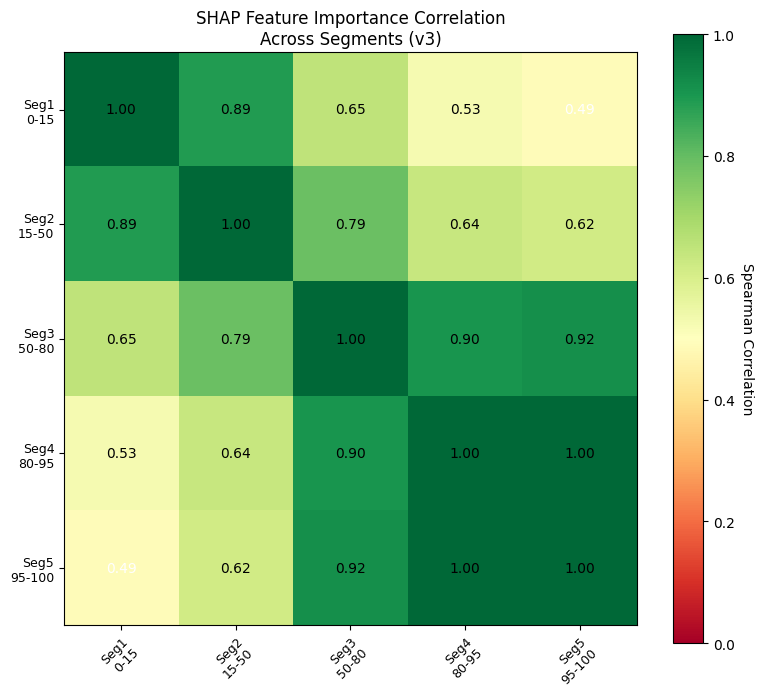


  ✓ Saved to figures/shap_segment_correlation_v3.png


In [620]:
# Run cross-segment correlation analysis
segment_correlation = run_cross_segment_correlation(version=CONFIG['model_version'])

In [621]:
# Compare consistency across versions
version_consistency = compare_version_shap_consistency()


 CROSS-VERSION SHAP CONSISTENCY COMPARISON

  Version          Mean ρ        Std        Min     Consistency
  ---------------------------------------------------------
  v1                0.879      0.067      0.733         High ✓✓
  v2                0.805      0.272      0.283         High ✓✓
  v3                0.742      0.171      0.491      Moderate ✓


# Section 19: Statistical Summary (Optional)

### Change the focus_option to evaluate other option models too

In [622]:
# %%
# ═══════════════════════════════════════════════════════════════════════════════
# STATISTICAL VALIDATION & MODEL COMPARISON
# ═══════════════════════════════════════════════════════════════════════════════

from scipy.stats import chi2, ncx2


def load_all_statistical_results() -> dict:
    """Load all statistical test results for all versions."""
    results = {}
    for v in ['v1', 'v2', 'v3']:
        results[v] = {}
        results_dir = PROJECT_ROOT / f'{v}_statistical_results'
        if results_dir.exists():
            for f in results_dir.glob('*.joblib'):
                results[v][f.stem] = joblib.load(f)
    return results


def compute_power(effect_size: float, n: int, k: int = 3, alpha: float = 0.05) -> float:
    """Compute statistical power for Friedman test using non-central χ² distribution."""
    ncp = n * (k - 1) * effect_size
    crit = chi2.ppf(1 - alpha, k - 1)
    return 1 - ncx2.cdf(crit, k - 1, ncp)


def compute_mde(n: int, power: float = 0.8, k: int = 3, alpha: float = 0.05) -> float:
    """Minimum detectable effect size via binary search."""
    lo, hi = 0.001, 1.0
    for _ in range(50):
        mid = (lo + hi) / 2
        if compute_power(mid, n, k, alpha) < power:
            lo = mid
        else:
            hi = mid
    return mid


def score_versions(versions: dict, stat_results: dict) -> pd.DataFrame:
    """Score all versions on accuracy and stability. Best=100, proportional penalty."""
    rows = []
    for v in ['v1', 'v2', 'v3']:
        opt5 = versions.get(v, {}).get(5, {})
        kfold = stat_results.get(v, {}).get('kfold_stability')
        row = {'version': v}
        if opt5:
            row['mape'] = np.mean(list(opt5.values()))
        if isinstance(kfold, pd.DataFrame):
            row['cv_pct'] = kfold['cv_pct'].mean()
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    if 'mape' in df.columns:
        df['acc_score'] = (100 - 10 * (df['mape'] - df['mape'].min())).clip(0, 100)
    if 'cv_pct' in df.columns:
        df['stab_score'] = (100 - 5 * (df['cv_pct'] - df['cv_pct'].min())).clip(0, 100)
    
    df['overall'] = 0.6 * df.get('acc_score', 50) + 0.4 * df.get('stab_score', 50)
    return df


def check_validity(stat_results: dict, version: str = 'v3') -> list:
    """Run validity checks. Returns list of (name, passed, detail, note) tuples."""
    v = stat_results.get(version, {})
    checks = []
    
    # ANOVA assumptions
    anova = v.get('anova_tables', {})
    assumptions = anova.get('assumptions', {})
    hom = assumptions.get('homogeneity_met', False)
    checks.append(('ANOVA Homogeneity', hom, f"Levene p={assumptions.get('levene_p', 0):.2e}", 
                   None if hom else 'Robust with large n'))
    
    # Effect sizes
    has_eta = 'eta' in str(anova.get('effects', {})).lower()
    has_w = 'kendall_w' in v.get('friedman_test', {})
    checks.append(('Effect Sizes', has_eta and has_w, f"η²:{'✓' if has_eta else '✗'} W:{'✓' if has_w else '✗'}", None))
    
    # Multiple comparisons
    has_nem = 'nemenyi' in v.get('friedman_test', {})
    checks.append(('Multiple Comparisons', has_nem, 'Nemenyi CD' if has_nem else 'Missing', None))
    
    # Residuals
    resid = v.get('residual_diagnostics', {})
    mean_r = resid.get('summary', {}).get('mean', 1)
    het = resid.get('heteroscedasticity', {}).get('heteroscedastic', False)
    checks.append(('Residual Mean ≈ 0', abs(mean_r) < 0.01, f"μ={mean_r:.6f}", None))
    checks.append(('Homoscedasticity', not het, 'Breusch-Pagan', None if not het else 'Quantile regression used'))
    
    # Calibration
    cal_err = v.get('conformal_calibration', {}).get('calibration_error', 100)
    checks.append(('Interval Calibration', cal_err < 5, f"Error={cal_err:.1f}%", None))
    
    # VIF
    vif_ok = v.get('multicollinearity_vif', {}).get('base_features_ok', True)
    checks.append(('Base Feature VIF', vif_ok, 'VIF<10' if vif_ok else 'VIF≥10', None))
    
    # CV stability
    kfold = v.get('kfold_stability')
    if isinstance(kfold, pd.DataFrame):
        cv = kfold['cv_pct'].mean()
        checks.append(('CV Stability', cv < 10, f"CV%={cv:.1f}%", None))
    
    return checks


def run_statistical_summary(version: str = 'v3'):
    """Comprehensive statistical summary with validity checks and power analysis."""
    
    stat_results = load_all_statistical_results()
    versions = load_all_versions()
    v_results = stat_results.get(version, {})
    
    print("=" * 75)
    print(f" STATISTICAL SUMMARY — {version.upper()}")
    print("=" * 75)
    
    # ── VERSION COMPARISON ─────────────────────────────────────────────────
    scores = score_versions(versions, stat_results)
    
    print(f"\n┌{'─'*73}┐")
    print(f"│ {'VERSION COMPARISON':<71} │")
    print(f"├{'─'*10}┬{'─'*12}┬{'─'*12}┬{'─'*12}┬{'─'*12}┬{'─'*11}┤")
    print(f"│ {'Version':<8} │ {'MAPE':>10} │ {'CV%':>10} │ {'Acc':>10} │ {'Stab':>10} │ {'Overall':>9} │")
    print(f"├{'─'*10}┼{'─'*12}┼{'─'*12}┼{'─'*12}┼{'─'*12}┼{'─'*11}┤")
    for _, r in scores.sort_values('overall', ascending=False).iterrows():
        print(f"│ {r['version']:<8} │ {r.get('mape', 0):>9.2f}% │ {r.get('cv_pct', 0):>9.2f}% │ "
              f"{r.get('acc_score', 0):>10.1f} │ {r.get('stab_score', 0):>10.1f} │ {r.get('overall', 0):>9.1f} │")
    print(f"└{'─'*10}┴{'─'*12}┴{'─'*12}┴{'─'*12}┴{'─'*12}┴{'─'*11}┘")
    
    # ── POWER ANALYSIS ─────────────────────────────────────────────────────
    friedman = v_results.get('friedman_test', {})
    pwr = None
    if friedman:
        n, w = friedman.get('n_samples', 500), friedman.get('kendall_w', 0.01)
        pwr, mde = compute_power(w, n), compute_mde(n)
        
        print(f"\n┌{'─'*73}┐")
        print(f"│ {'POWER ANALYSIS':<71} │")
        print(f"├{'─'*73}┤")
        print(f"│  Friedman: n={n}, W={w:.4f}, α=0.05{' '*34} │")
        print(f"│  Power={pwr:.1%} │ β={1-pwr:.1%} │ MDE={mde:.4f}{' '*33} │")
        print(f"│  Status: {'✓ Adequate' if pwr >= 0.8 else '⚠ Underpowered':<62} │")
        print(f"└{'─'*73}┘")
    
    # ── VALIDITY CHECKLIST ─────────────────────────────────────────────────
    checks = check_validity(stat_results, version)
    passed = sum(1 for _, p, _, _ in checks if p)
    
    print(f"\n┌{'─'*73}┐")
    print(f"│ {'VALIDITY CHECKLIST':<71} │")
    print(f"├{'─'*24}┬{'─'*10}┬{'─'*36}┤")
    print(f"│ {'Check':<22} │ {'Status':<8} │ {'Detail':<34} │")
    print(f"├{'─'*24}┼{'─'*10}┼{'─'*36}┤")
    for name, ok, detail, note in checks:
        print(f"│ {name:<22} │ {'✓ Pass' if ok else '⚠ Warn':<8} │ {detail:<34} │")
    print(f"├{'─'*24}┴{'─'*10}┴{'─'*36}┤")
    print(f"│  Result: {passed}/{len(checks)} passed{' '*56} │")
    print(f"└{'─'*73}┘")
    
    # Notes
    notes = [(n, nt) for n, _, _, nt in checks if nt]
    if notes:
        print(f"\n  Notes:")
        for name, note in notes:
            print(f"    • {name}: {note}")
    
    # ── VERDICT ────────────────────────────────────────────────────────────
    best = scores.loc[scores['overall'].idxmax(), 'version']
    valid = passed >= len(checks) - 1
    
    print(f"\n{'='*75}")
    print(f" VERDICT: {best.upper()} │ Validity: {'✓ Sound' if valid else '⚠ Review limitations'}")
    print(f"{'='*75}")
    
    return {'scores': scores, 'checks': checks, 'best': best, 'power': pwr}

In [623]:
summary = run_statistical_summary(version=CONFIG['model_version'])
save_statistical_result(summary, 'statistical_summary')

 LOADING VERSIONS FOR COMPARISON
  Loading v1... ✓
  Loading v2... ✓
  Loading v3... ✓
 STATISTICAL SUMMARY — V3

┌─────────────────────────────────────────────────────────────────────────┐
│ VERSION COMPARISON                                                      │
├──────────┬────────────┬────────────┬────────────┬────────────┬───────────┤
│ Version  │       MAPE │        CV% │        Acc │       Stab │   Overall │
├──────────┼────────────┼────────────┼────────────┼────────────┼───────────┤
│ v3       │      9.95% │      1.01% │      100.0 │      100.0 │     100.0 │
│ v1       │     10.01% │      1.47% │       99.4 │       97.7 │      98.7 │
│ v2       │     10.31% │      1.27% │       96.3 │       98.7 │      97.3 │
└──────────┴────────────┴────────────┴────────────┴────────────┴───────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│ POWER ANALYSIS                                                          │
├─────────────────────────────────────────

In [624]:
def run_cross_version_comparison():
    """Comprehensive tabular comparison of all statistical analyses across versions."""
    
    stat_results = load_all_statistical_results()
    versions = load_all_versions()
    
    print("=" * 90)
    print(" CROSS-VERSION STATISTICAL COMPARISON")
    print("=" * 90)
    
    # ── 1. PREDICTION ACCURACY ─────────────────────────────────────────────
    print(f"\n┌{'─'*88}┐")
    print(f"│ {'PREDICTION ACCURACY (Option 5 Segments)':<86} │")
    print(f"├{'─'*20}┬{'─'*22}┬{'─'*22}┬{'─'*22}┤")
    print(f"│ {'Segment':<18} │ {'v1':^20} │ {'v2':^20} │ {'v3':^20} │")
    print(f"├{'─'*20}┼{'─'*22}┼{'─'*22}┼{'─'*22}┤")
    
    segments = ['Seg1_0-15', 'Seg2_15-50', 'Seg3_50-80', 'Seg4_80-95', 'Seg5_95-100']
    seg_data = {v: versions.get(v, {}).get(5, {}) for v in ['v1', 'v2', 'v3']}
    
    for seg in segments:
        vals = [seg_data[v].get(seg) for v in ['v1', 'v2', 'v3']]
        best_idx = vals.index(min([x for x in vals if x], default=100)) if any(vals) else -1
        row = f"│ {seg:<18} │"
        for i, val in enumerate(vals):
            if val:
                marker = ' ★' if i == best_idx else ''
                row += f" {val:>18.2f}%{marker} │"
            else:
                row += f" {'—':^20} │"
        print(row)
    
    print(f"├{'─'*20}┼{'─'*22}┼{'─'*22}┼{'─'*22}┤")
    avgs = [np.mean(list(seg_data[v].values())) if seg_data[v] else 0 for v in ['v1', 'v2', 'v3']]
    best_avg = avgs.index(min(avgs))
    row = f"│ {'AVERAGE':<18} │"
    for i, avg in enumerate(avgs):
        marker = ' ★' if i == best_avg else ''
        row += f" {avg:>18.2f}%{marker} │"
    print(row)
    print(f"└{'─'*20}┴{'─'*22}┴{'─'*22}┴{'─'*22}┘")
    
    # ── 2. STABILITY METRICS ───────────────────────────────────────────────
    print(f"\n┌{'─'*88}┐")
    print(f"│ {'STABILITY METRICS':<86} │")
    print(f"├{'─'*30}┬{'─'*18}┬{'─'*18}┬{'─'*18}┤")
    print(f"│ {'Metric':<28} │ {'v1':^16} │ {'v2':^16} │ {'v3':^16} │")
    print(f"├{'─'*30}┼{'─'*18}┼{'─'*18}┼{'─'*18}┤")
    
    # CV%
    cv_vals = []
    for v in ['v1', 'v2', 'v3']:
        kfold = stat_results.get(v, {}).get('kfold_stability')
        cv_vals.append(kfold['cv_pct'].mean() if isinstance(kfold, pd.DataFrame) else None)
    best_cv = cv_vals.index(min([x for x in cv_vals if x], default=100)) if any(cv_vals) else -1
    row = f"│ {'K-Fold CV%':<28} │"
    for i, val in enumerate(cv_vals):
        marker = ' ★' if i == best_cv and val else ''
        row += f" {val:>14.2f}%{marker} │" if val else f" {'—':^16} │"
    print(row)
    
    # Learning curve gap
    lc_vals = []
    for v in ['v1', 'v2', 'v3']:
        lc = stat_results.get(v, {}).get('learning_curves_opt_5')
        if lc:
            gaps = [c['val_mape'][-1] - c['train_mape'][-1] for c in lc.values() if c.get('val_mape')]
            lc_vals.append(np.mean(gaps) if gaps else None)
        else:
            lc_vals.append(None)
    best_lc = lc_vals.index(min([x for x in lc_vals if x], default=100)) if any(lc_vals) else -1
    row = f"│ {'Learning Curve Gap':<28} │"
    for i, val in enumerate(lc_vals):
        marker = ' ★' if i == best_lc and val else ''
        row += f" {val:>14.2f}%{marker} │" if val else f" {'—':^16} │"
    print(row)
    
    # Bootstrap CI width
    boot_vals = []
    for v in ['v1', 'v2', 'v3']:
        boot = stat_results.get(v, {}).get('bootstrap_confidence_intervals', {})
        overall = boot.get('overall', {}).get('mape', {})
        if overall:
            width = overall.get('ci_upper', 0) - overall.get('ci_lower', 0)
            boot_vals.append(width)
        else:
            boot_vals.append(None)
    best_boot = boot_vals.index(min([x for x in boot_vals if x], default=100)) if any(boot_vals) else -1
    row = f"│ {'Bootstrap 95% CI Width':<28} │"
    for i, val in enumerate(boot_vals):
        marker = ' ★' if i == best_boot and val else ''
        row += f" {val:>14.2f}%{marker} │" if val else f" {'—':^16} │"
    print(row)
    print(f"└{'─'*30}┴{'─'*18}┴{'─'*18}┴{'─'*18}┘")
    
    # ── 3. HYPOTHESIS TESTS ────────────────────────────────────────────────
    print(f"\n┌{'─'*88}┐")
    print(f"│ {'HYPOTHESIS TESTS':<86} │")
    print(f"├{'─'*30}┬{'─'*18}┬{'─'*18}┬{'─'*18}┤")
    print(f"│ {'Test':<28} │ {'v1':^16} │ {'v2':^16} │ {'v3':^16} │")
    print(f"├{'─'*30}┼{'─'*18}┼{'─'*18}┼{'─'*18}┤")
    
    # Friedman p-value
    row = f"│ {'Friedman p-value':<28} │"
    for v in ['v1', 'v2', 'v3']:
        friedman = stat_results.get(v, {}).get('friedman_test', {})
        p = friedman.get('p_value')
        if p is not None:
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            row += f" {p:>13.2e}{sig:>2} │"
        else:
            row += f" {'—':^16} │"
    print(row)
    
    # Friedman effect size (Kendall's W) - compute if missing
    row = f"│ {'Kendall W (effect size)':<28} │"
    for v in ['v1', 'v2', 'v3']:
        friedman = stat_results.get(v, {}).get('friedman_test', {})
        w = friedman.get('kendall_w')
        if w is None and friedman.get('statistic') and friedman.get('n_samples'):
            # Compute: W = χ² / (n * (k-1)) where k=3
            w = friedman['statistic'] / (friedman['n_samples'] * 2)
        if w is not None:
            row += f" {w:>16.4f} │"
        else:
            row += f" {'—':^16} │"
    print(row)
    
    # ANOVA - Option effect
    row = f"│ {'ANOVA Option p-value':<28} │"
    for v in ['v1', 'v2', 'v3']:
        anova = stat_results.get(v, {}).get('anova_tables', {})
        effects = anova.get('effects', anova.get('results', {}))
        p = effects.get('Option', {}).get('p_value', effects.get('Option', {}).get('p'))
        if p is not None:
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            row += f" {p:>13.4f}{sig:>2} │"
        else:
            row += f" {'—':^16} │"
    print(row)
    
    # ANOVA - Effect size (compute from anova_table if missing)
    row = f"│ {'ANOVA Option η²':<28} │"
    for v in ['v1', 'v2', 'v3']:
        anova = stat_results.get(v, {}).get('anova_tables', {})
        effects = anova.get('effects', anova.get('results', {}))
        eta = effects.get('Option', {}).get('eta_squared', effects.get('Option', {}).get('eta_sq'))
        
        # Compute from anova_table if missing
        if eta is None:
            table = anova.get('anova_table')
            if table is not None and hasattr(table, 'loc'):
                try:
                    ss_total = table['sum_sq'].sum()
                    ss_option = table.loc['C(option)', 'sum_sq']
                    eta = ss_option / ss_total
                except:
                    pass
        
        if eta is not None:
            row += f" {eta:>16.4f} │"
        else:
            row += f" {'—':^16} │"
    print(row)
    print(f"└{'─'*30}┴{'─'*18}┴{'─'*18}┴{'─'*18}┘")
    
    # ── 4. UNCERTAINTY QUANTIFICATION ──────────────────────────────────────
    print(f"\n┌{'─'*88}┐")
    print(f"│ {'UNCERTAINTY QUANTIFICATION':<86} │")
    print(f"├{'─'*30}┬{'─'*18}┬{'─'*18}┬{'─'*18}┤")
    print(f"│ {'Metric':<28} │ {'v1':^16} │ {'v2':^16} │ {'v3':^16} │")
    print(f"├{'─'*30}┼{'─'*18}┼{'─'*18}┼{'─'*18}┤")
    
    # Conformal calibration error
    row = f"│ {'Conformal Cal. Error':<28} │"
    cal_vals = []
    for v in ['v1', 'v2', 'v3']:
        conf = stat_results.get(v, {}).get('conformal_calibration', {})
        cal = conf.get('calibration_error')
        cal_vals.append(cal)
    best_cal = cal_vals.index(min([x for x in cal_vals if x is not None], default=100)) if any(x is not None for x in cal_vals) else -1
    for i, val in enumerate(cal_vals):
        marker = ' ★' if i == best_cal and val is not None else ''
        row += f" {val:>14.1f}%{marker} │" if val is not None else f" {'—':^16} │"
    print(row)
    
    # Winkler score
    row = f"│ {'Winkler Score (£)':<28} │"
    wink_vals = []
    for v in ['v1', 'v2', 'v3']:
        wink = stat_results.get(v, {}).get('winkler_results', {})
        score = wink.get('mean_score', wink.get('mean'))
        wink_vals.append(score)
    best_wink = wink_vals.index(min([x for x in wink_vals if x is not None], default=1e9)) if any(x is not None for x in wink_vals) else -1
    for i, val in enumerate(wink_vals):
        marker = ' ★' if i == best_wink and val is not None else ''
        row += f" {val:>13,.0f}{marker} │" if val is not None else f" {'—':^16} │"
    print(row)
    
    # Empirical Coverage (1 - miss_rate)
    row = f"│ {'Empirical Coverage':<28} │"
    cov_vals = []
    for v in ['v1', 'v2', 'v3']:
        wink = stat_results.get(v, {}).get('winkler_results', {})
        miss = wink.get('miss_rate')
        cov_vals.append(1 - miss if miss is not None else None)
    best_cov = cov_vals.index(max([x for x in cov_vals if x is not None], default=0)) if any(x is not None for x in cov_vals) else -1
    for i, val in enumerate(cov_vals):
        marker = ' ★' if i == best_cov and val is not None else ''
        row += f" {val:>14.1%}{marker} │" if val is not None else f" {'—':^16} │"
    print(row)
    print(f"└{'─'*30}┴{'─'*18}┴{'─'*18}┴{'─'*18}┘")
    
    # ── 5. RESIDUAL DIAGNOSTICS ────────────────────────────────────────────
    print(f"\n┌{'─'*88}┐")
    print(f"│ {'RESIDUAL DIAGNOSTICS':<86} │")
    print(f"├{'─'*30}┬{'─'*18}┬{'─'*18}┬{'─'*18}┤")
    print(f"│ {'Metric':<28} │ {'v1':^16} │ {'v2':^16} │ {'v3':^16} │")
    print(f"├{'─'*30}┼{'─'*18}┼{'─'*18}┼{'─'*18}┤")
    
    for metric, key in [('Mean Residual', 'mean'), ('Std Residual', 'std'), 
                        ('Skewness', 'skewness'), ('Kurtosis', 'kurtosis')]:
        row = f"│ {metric:<28} │"
        for v in ['v1', 'v2', 'v3']:
            resid = stat_results.get(v, {}).get('residual_diagnostics', {})
            val = resid.get('summary', {}).get(key)
            row += f" {val:>16.4f} │" if val is not None else f" {'—':^16} │"
        print(row)
    
    # Heteroscedastic
    row = f"│ {'Heteroscedastic?':<28} │"
    for v in ['v1', 'v2', 'v3']:
        resid = stat_results.get(v, {}).get('residual_diagnostics', {})
        het = resid.get('heteroscedasticity', {}).get('heteroscedastic')
        row += f" {'Yes ⚠' if het else 'No ✓':^16} │" if het is not None else f" {'—':^16} │"
    print(row)
    print(f"└{'─'*30}┴{'─'*18}┴{'─'*18}┴{'─'*18}┘")
    
    # ── 6. OVERALL SCORES ──────────────────────────────────────────────────
    scores = score_versions(versions, stat_results)
    
    print(f"\n┌{'─'*88}┐")
    print(f"│ {'OVERALL SCORES':<86} │")
    print(f"├{'─'*30}┬{'─'*18}┬{'─'*18}┬{'─'*18}┤")
    print(f"│ {'Metric':<28} │ {'v1':^16} │ {'v2':^16} │ {'v3':^16} │")
    print(f"├{'─'*30}┼{'─'*18}┼{'─'*18}┼{'─'*18}┤")
    
    for metric, col in [('Accuracy Score', 'acc_score'), ('Stability Score', 'stab_score'), ('Overall Score', 'overall')]:
        row = f"│ {metric:<28} │"
        vals = [scores[scores['version'] == v][col].values[0] if v in scores['version'].values else None for v in ['v1', 'v2', 'v3']]
        best_idx = vals.index(max([x for x in vals if x is not None], default=0)) if any(x is not None for x in vals) else -1
        for i, val in enumerate(vals):
            marker = ' ★' if i == best_idx and val is not None else ''
            row += f" {val:>14.1f}{marker} │" if val is not None else f" {'—':^16} │"
        print(row)
    print(f"└{'─'*30}┴{'─'*18}┴{'─'*18}┴{'─'*18}┘")
    
    # ── VERDICT ────────────────────────────────────────────────────────────
    best = scores.loc[scores['overall'].idxmax(), 'version']
    
    print(f"\n{'='*90}")
    print(f" VERDICT: {best.upper()} is the best overall model")
    print(f"{'='*90}")
    
    return {'scores': scores, 'stat_results': stat_results}

In [625]:
comparison = run_cross_version_comparison()
save_statistical_result(comparison['scores'].to_dict(), 'cross_version_comparison')

 LOADING VERSIONS FOR COMPARISON
  Loading v1... ✓
  Loading v2... ✓
  Loading v3... ✓
 CROSS-VERSION STATISTICAL COMPARISON

┌────────────────────────────────────────────────────────────────────────────────────────┐
│ PREDICTION ACCURACY (Option 5 Segments)                                                │
├────────────────────┬──────────────────────┬──────────────────────┬──────────────────────┤
│ Segment            │          v1          │          v2          │          v3          │
├────────────────────┼──────────────────────┼──────────────────────┼──────────────────────┤
│ Seg1_0-15          │              13.10% │              12.48% ★ │              13.32% │
│ Seg2_15-50         │               8.05% │               9.26% │               7.86% ★ │
│ Seg3_50-80         │               7.74% │               8.93% │               7.66% ★ │
│ Seg4_80-95         │               9.61% │               9.48% │               9.24% ★ │
│ Seg5_95-100        │              11.53% │        

In [630]:
def consolidate_statistical_summaries():
    """
    Find statistical_summary.joblib and cross_version_comparison.joblib
    and move to final_statistical_summary folder.
    """
    print("=" * 70)
    print(" CONSOLIDATING STATISTICAL SUMMARIES")
    print("=" * 70)
    
    # Create destination folder
    dest_dir = PROJECT_ROOT / 'final_statistical_summary'
    dest_dir.mkdir(parents=True, exist_ok=True)
    print(f"\n  Destination: {dest_dir}")
    
    # Files to look for
    target_files = ['statistical_summary.joblib', 'cross_version_comparison.joblib']
    
    # Source folders to search
    search_dirs = [
        PROJECT_ROOT / 'v1_statistical_results',
        PROJECT_ROOT / 'v2_statistical_results', 
        PROJECT_ROOT / 'v3_statistical_results',
        PROJECT_ROOT / 'statistical_results',
        PROJECT_ROOT / 'models' / 'v1_baseline',
        PROJECT_ROOT / 'models' / 'v2_extended',
        PROJECT_ROOT / 'models' / 'v3_comprehensive',
        PROJECT_ROOT,
    ]
    
    moved = 0
    
    print(f"\n  Looking for: {target_files}")
    print("\n" + "-" * 70)
    
    for filename in target_files:
        dest_path = dest_dir / filename
        
        if dest_path.exists():
            print(f"  ✓ Already exists: {filename}")
            continue
        
        found = False
        for search_dir in search_dirs:
            if not search_dir.exists():
                continue
            
            source_path = search_dir / filename
            if source_path.exists():
                shutil.move(str(source_path), str(dest_path))  # MOVE, not copy
                print(f"  ✓ Moved: {source_path.relative_to(PROJECT_ROOT)} → final_statistical_summary/")
                moved += 1
                found = True
                break
        
        if not found:
            print(f"  ✗ Not found: {filename}")
    
    print("\n" + "=" * 70)
    print(f" COMPLETE: {moved} files moved")
    print("=" * 70)

In [631]:
consolidate_statistical_summaries()

 CONSOLIDATING STATISTICAL SUMMARIES

  Destination: /Users/vish/Documents/anaconda_projects/ML/Housing Valuation Project/final_statistical_summary

  Looking for: ['statistical_summary.joblib', 'cross_version_comparison.joblib']

----------------------------------------------------------------------
  ✓ Moved: v3_statistical_results/statistical_summary.joblib → final_statistical_summary/
  ✓ Moved: v3_statistical_results/cross_version_comparison.joblib → final_statistical_summary/

 COMPLETE: 2 files moved


In [634]:
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch, cm
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, PageBreak
from reportlab.lib.enums import TA_CENTER, TA_LEFT
from datetime import datetime


def load_and_view_statistical_results():
    """Load statistical results and create a PDF report."""
    
    summary_dir = PROJECT_ROOT / 'final_statistical_summary'
    
    # Load files
    print("=" * 70)
    print(" LOADING STATISTICAL RESULTS")
    print("=" * 70)
    
    summary_path = summary_dir / 'statistical_summary.joblib'
    comparison_path = summary_dir / 'cross_version_comparison.joblib'
    
    summary = None
    comparison = None
    
    if summary_path.exists():
        summary = joblib.load(summary_path)
        print(f"  ✓ Loaded: statistical_summary.joblib")
    else:
        print(f"  ✗ Not found: statistical_summary.joblib")
    
    if comparison_path.exists():
        comparison = joblib.load(comparison_path)
        print(f"  ✓ Loaded: cross_version_comparison.joblib")
    else:
        print(f"  ✗ Not found: cross_version_comparison.joblib")
    
    return summary, comparison


def format_value(val, precision=2):
    """Format a value for display."""
    if val is None:
        return "N/A"
    elif isinstance(val, float):
        if abs(val) < 0.001 and val != 0:
            return f"{val:.2e}"
        return f"{val:.{precision}f}"
    elif isinstance(val, dict):
        return str(val)[:50] + "..." if len(str(val)) > 50 else str(val)
    elif isinstance(val, (list, tuple)):
        return str(val)[:50] + "..." if len(str(val)) > 50 else str(val)
    else:
        return str(val)


def dict_to_table_data(d, parent_key='', max_depth=2, current_depth=0):
    """Recursively flatten a dict into table rows."""
    rows = []
    
    if current_depth >= max_depth:
        return [(parent_key, format_value(d))]
    
    if isinstance(d, dict):
        for k, v in d.items():
            new_key = f"{parent_key}.{k}" if parent_key else str(k)
            
            if isinstance(v, dict) and current_depth < max_depth - 1:
                rows.extend(dict_to_table_data(v, new_key, max_depth, current_depth + 1))
            else:
                rows.append((new_key, format_value(v)))
    else:
        rows.append((parent_key, format_value(d)))
    
    return rows


def create_statistical_pdf(summary: dict, comparison: dict, output_path: str = None):
    """Create a PDF report from statistical results."""
    
    output_path = output_path or (PROJECT_ROOT / 'final_statistical_summary' / 'Statistical_Results_Report.pdf')
    
    print("\n" + "=" * 70)
    print(" CREATING PDF REPORT")
    print("=" * 70)
    
    # Create document
    doc = SimpleDocTemplate(
        str(output_path),
        pagesize=A4,
        rightMargin=1.5*cm,
        leftMargin=1.5*cm,
        topMargin=2*cm,
        bottomMargin=2*cm
    )
    
    # Styles
    styles = getSampleStyleSheet()
    
    title_style = ParagraphStyle(
        'CustomTitle',
        parent=styles['Title'],
        fontSize=20,
        spaceAfter=30,
        alignment=TA_CENTER
    )
    
    heading1_style = ParagraphStyle(
        'CustomH1',
        parent=styles['Heading1'],
        fontSize=14,
        spaceBefore=20,
        spaceAfter=10,
        textColor=colors.darkblue
    )
    
    heading2_style = ParagraphStyle(
        'CustomH2',
        parent=styles['Heading2'],
        fontSize=12,
        spaceBefore=15,
        spaceAfter=8,
        textColor=colors.darkgreen
    )
    
    normal_style = ParagraphStyle(
        'CustomNormal',
        parent=styles['Normal'],
        fontSize=9,
        spaceAfter=6
    )
    
    # Build content
    story = []
    
    # Title page
    story.append(Spacer(1, 2*inch))
    story.append(Paragraph("PropertyCompanion", title_style))
    story.append(Paragraph("Statistical Results Report", styles['Heading1']))
    story.append(Spacer(1, 0.5*inch))
    story.append(Paragraph(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}", styles['Normal']))
    story.append(PageBreak())
    
    # Table of Contents
    story.append(Paragraph("Contents", heading1_style))
    story.append(Paragraph("1. Statistical Summary", normal_style))
    story.append(Paragraph("2. Cross-Version Comparison", normal_style))
    story.append(Spacer(1, 0.5*inch))
    
    # ─────────────────────────────────────────────────────────────────────────
    # Section 1: Statistical Summary
    # ─────────────────────────────────────────────────────────────────────────
    story.append(Paragraph("1. Statistical Summary", heading1_style))
    
    if summary:
        for section_name, section_data in summary.items():
            story.append(Paragraph(f"1.{list(summary.keys()).index(section_name)+1} {section_name}", heading2_style))
            
            if isinstance(section_data, dict):
                # Convert to table
                table_data = [['Key', 'Value']]
                rows = dict_to_table_data(section_data, max_depth=2)
                
                for key, val in rows[:30]:  # Limit rows per section
                    # Truncate long keys
                    display_key = key if len(key) < 40 else key[:37] + "..."
                    display_val = val if len(str(val)) < 50 else str(val)[:47] + "..."
                    table_data.append([display_key, display_val])
                
                if len(rows) > 30:
                    table_data.append(['...', f'({len(rows) - 30} more rows)'])
                
                # Create table
                col_widths = [3*inch, 3.5*inch]
                table = Table(table_data, colWidths=col_widths)
                table.setStyle(TableStyle([
                    ('BACKGROUND', (0, 0), (-1, 0), colors.lightblue),
                    ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
                    ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
                    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                    ('FONTSIZE', (0, 0), (-1, -1), 8),
                    ('BOTTOMPADDING', (0, 0), (-1, 0), 8),
                    ('BACKGROUND', (0, 1), (-1, -1), colors.white),
                    ('GRID', (0, 0), (-1, -1), 0.5, colors.grey),
                    ('VALIGN', (0, 0), (-1, -1), 'TOP'),
                ]))
                story.append(table)
                story.append(Spacer(1, 0.3*inch))
                
            elif isinstance(section_data, pd.DataFrame):
                # Handle DataFrames
                table_data = [section_data.columns.tolist()]
                for _, row in section_data.head(20).iterrows():
                    table_data.append([format_value(v) for v in row.tolist()])
                
                table = Table(table_data)
                table.setStyle(TableStyle([
                    ('BACKGROUND', (0, 0), (-1, 0), colors.lightblue),
                    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                    ('FONTSIZE', (0, 0), (-1, -1), 7),
                    ('GRID', (0, 0), (-1, -1), 0.5, colors.grey),
                ]))
                story.append(table)
                story.append(Spacer(1, 0.3*inch))
            else:
                story.append(Paragraph(f"{format_value(section_data)}", normal_style))
    else:
        story.append(Paragraph("No statistical summary data available.", normal_style))
    
    story.append(PageBreak())
    
    # ─────────────────────────────────────────────────────────────────────────
    # Section 2: Cross-Version Comparison
    # ─────────────────────────────────────────────────────────────────────────
    story.append(Paragraph("2. Cross-Version Comparison", heading1_style))
    
    if comparison:
        for section_name, section_data in comparison.items():
            story.append(Paragraph(f"2.{list(comparison.keys()).index(section_name)+1} {section_name}", heading2_style))
            
            if isinstance(section_data, dict):
                table_data = [['Key', 'Value']]
                rows = dict_to_table_data(section_data, max_depth=2)
                
                for key, val in rows[:30]:
                    display_key = key if len(key) < 40 else key[:37] + "..."
                    display_val = val if len(str(val)) < 50 else str(val)[:47] + "..."
                    table_data.append([display_key, display_val])
                
                if len(rows) > 30:
                    table_data.append(['...', f'({len(rows) - 30} more rows)'])
                
                col_widths = [3*inch, 3.5*inch]
                table = Table(table_data, colWidths=col_widths)
                table.setStyle(TableStyle([
                    ('BACKGROUND', (0, 0), (-1, 0), colors.lightgreen),
                    ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
                    ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
                    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                    ('FONTSIZE', (0, 0), (-1, -1), 8),
                    ('BOTTOMPADDING', (0, 0), (-1, 0), 8),
                    ('BACKGROUND', (0, 1), (-1, -1), colors.white),
                    ('GRID', (0, 0), (-1, -1), 0.5, colors.grey),
                    ('VALIGN', (0, 0), (-1, -1), 'TOP'),
                ]))
                story.append(table)
                story.append(Spacer(1, 0.3*inch))
                
            elif isinstance(section_data, pd.DataFrame):
                table_data = [section_data.columns.tolist()]
                for _, row in section_data.head(20).iterrows():
                    table_data.append([format_value(v) for v in row.tolist()])
                
                table = Table(table_data)
                table.setStyle(TableStyle([
                    ('BACKGROUND', (0, 0), (-1, 0), colors.lightgreen),
                    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                    ('FONTSIZE', (0, 0), (-1, -1), 7),
                    ('GRID', (0, 0), (-1, -1), 0.5, colors.grey),
                ]))
                story.append(table)
                story.append(Spacer(1, 0.3*inch))
            else:
                story.append(Paragraph(f"{format_value(section_data)}", normal_style))
    else:
        story.append(Paragraph("No cross-version comparison data available.", normal_style))
    
    # Build PDF
    doc.build(story)
    
    print(f"\n  ✓ PDF created: {output_path}")
    print(f"    Size: {output_path.stat().st_size / 1024:.1f} KB")
    
    return output_path


def view_statistical_results_console(summary: dict, comparison: dict):
    """Print a console-friendly view of the results."""
    
    print("\n" + "=" * 80)
    print(" STATISTICAL SUMMARY")
    print("=" * 80)
    
    if summary:
        for section_name, section_data in summary.items():
            print(f"\n{'─' * 40}")
            print(f" {section_name.upper()}")
            print(f"{'─' * 40}")
            
            if isinstance(section_data, dict):
                for k, v in list(section_data.items())[:15]:
                    print(f"  {k}: {format_value(v)}")
                if len(section_data) > 15:
                    print(f"  ... and {len(section_data) - 15} more")
            else:
                print(f"  {format_value(section_data)}")
    
    print("\n" + "=" * 80)
    print(" CROSS-VERSION COMPARISON")
    print("=" * 80)
    
    if comparison:
        for section_name, section_data in comparison.items():
            print(f"\n{'─' * 40}")
            print(f" {section_name.upper()}")
            print(f"{'─' * 40}")
            
            if isinstance(section_data, dict):
                for k, v in list(section_data.items())[:15]:
                    print(f"  {k}: {format_value(v)}")
                if len(section_data) > 15:
                    print(f"  ... and {len(section_data) - 15} more")
            else:
                print(f"  {format_value(section_data)}")

In [635]:
# Load data
summary, comparison = load_and_view_statistical_results()

 LOADING STATISTICAL RESULTS
  ✓ Loaded: statistical_summary.joblib
  ✓ Loaded: cross_version_comparison.joblib


In [636]:
# View in console first
view_statistical_results_console(summary, comparison)


 STATISTICAL SUMMARY

────────────────────────────────────────
 SCORES
────────────────────────────────────────
    version       mape    cv_pct   acc_score  stab_score     overall
0      v1  10.006514  1.467129   99.418162   97.723018   98.740104
1      v2  10.313745  1.271368   96.345861   98.701825   97.288246
2      v3   9.948331  1.011733  100.000000  100.000000  100.000000

────────────────────────────────────────
 CHECKS
────────────────────────────────────────
  [('ANOVA Homogeneity', np.False_, 'Levene p=2.49e-...

────────────────────────────────────────
 BEST
────────────────────────────────────────
  v3

────────────────────────────────────────
 POWER
────────────────────────────────────────
  0.99

 CROSS-VERSION COMPARISON

────────────────────────────────────────
 VERSION
────────────────────────────────────────
  0: v1
  1: v2
  2: v3

────────────────────────────────────────
 MAPE
────────────────────────────────────────
  0: 10.01
  1: 10.31
  2: 9.95

──────────────

In [637]:
# Create PDF
pdf_path = create_statistical_pdf(summary, comparison)


 CREATING PDF REPORT

  ✓ PDF created: /Users/vish/Documents/anaconda_projects/ML/Housing Valuation Project/final_statistical_summary/Statistical_Results_Report.pdf
    Size: 4.6 KB


In [638]:
print("\n" + "=" * 70)
print(" COMPLETE")
print("=" * 70)
print(f"  PDF saved to: {pdf_path}")


 COMPLETE
  PDF saved to: /Users/vish/Documents/anaconda_projects/ML/Housing Valuation Project/final_statistical_summary/Statistical_Results_Report.pdf


# Appendix 4: Backtesting v1

Using manually scraped listings in the file "listings.xslx"

In [ ]:
# from contextlib import redirect_stdout

# # =============================================================================
# # LOAD LISTINGS
# # =============================================================================

# def load_listings(filepath='listings.xlsx'):
#     """Load and validate listings file."""
#     df = pd.read_excel(filepath)
#     print(f"Loaded {len(df)} listings")
#     print(f"\nProperty type distribution:")
#     print(df['PROPERTY_TYPE'].value_counts())
#     print(f"\nBuilt form status:")
#     print(f"  - With BUILT_FORM: {df['BUILT_FORM'].notna().sum()}")
#     print(f"  - Missing (Flats/Maisonettes to match): {df['BUILT_FORM'].isna().sum()}")
#     return df

# # =============================================================================
# # BUILT FORM MATCHING FOR FLATS/MAISONETTES
# # =============================================================================

# # Valid built forms from training data
# VALID_BUILT_FORMS = ['Terraced', 'Semi-Detached', 'Detached', 'Other']

# # Terrace variants to normalize
# TERRACE_VARIANTS = ['Mid-Terrace', 'End-Terrace', 'Enclosed End-Terrace', 
#                     'Enclosed Mid-Terrace', 'Terraced']

# def normalize_built_form(built_form):
#     """Normalize built form to match training data categories."""
#     if pd.isna(built_form) or built_form == '':
#         return None
    
#     # Normalize terrace variants
#     if built_form in TERRACE_VARIANTS:
#         return 'Terraced'
    
#     # Check if it's a valid built form
#     if built_form in VALID_BUILT_FORMS:
#         return built_form
    
#     # Unknown built form - return None (will be flagged)
#     return None

# def extract_postcode_sector(postcode):
#     """Extract postcode sector from full postcode (e.g., 'HA4 8XX' -> 'HA4 8')."""
#     if pd.isna(postcode):
#         return postcode
#     s = str(postcode).strip()
#     if " " in s:
#         parts = s.rsplit(" ", 1)
#         if len(parts) == 2 and len(parts[1]) > 0:
#             return parts[0] + " " + parts[1][0]
#     return s

# def prepare_pre_dedup_for_matching(pre_dedup):
#     """
#     Prepare pre_dedup dataframe for built form matching.
#     Adds POSTCODE_SECTOR column. Run once.
#     """
#     df = pre_dedup.copy()
#     df['POSTCODE_SECTOR'] = df['Postcode'].apply(extract_postcode_sector)
    
#     # Normalize text columns for matching
#     for col in ['PAON', 'SAON', 'Street']:
#         if col in df.columns:
#             df[f'{col}_UPPER'] = df[col].astype(str).str.upper().str.strip()
    
#     print(f"Prepared {len(df):,} records for matching")
#     print(f"Flats/Maisonettes available: {df[df['PROPERTY_TYPE'].isin(['Flat', 'Maisonette'])].shape[0]:,}")
#     return df

# def match_built_form_for_flat(row, pre_dedup_prepared):
#     """
#     Match a single Flat/Maisonette listing to pre_dedup to find BUILT_FORM.
    
#     Matching criteria:
#     1. POSTCODE_SECTOR must match
#     2. PROPERTY_TYPE must match  
#     3. STREET_NAME_FOR_FLATS should appear in PAON, SAON, or Street
#     4. Optionally: PROPERTY_NUMBER should match PAON or SAON
    
#     Returns: (built_form, match_confidence, n_matches)
#     """
#     # Only for Flats/Maisonettes
#     if row['PROPERTY_TYPE'] not in ['Flat', 'Maisonette']:
#         return row.get('BUILT_FORM'), 'not_applicable', 0
    
#     # If already has built form, use it
#     if pd.notna(row.get('BUILT_FORM')) and row['BUILT_FORM'] != '':
#         return row['BUILT_FORM'], 'provided', 0
    
#     postcode_sector = row['POSTCODE_SECTOR']
#     property_type = row['PROPERTY_TYPE']
#     street_name = str(row.get('STREET_NAME_FOR_FLATS', '')).upper().strip()
#     property_number = str(row.get('PROPERTY_NUMBER', '')).upper().strip()
    
#     # Start with all records
#     matches = pre_dedup_prepared.copy()
    
#     # Step 1: Match postcode sector
#     matches = matches[matches['POSTCODE_SECTOR'] == postcode_sector]
#     if len(matches) == 0:
#         return None, 'no_sector_match', 0
    
#     # Step 2: Match property type
#     matches = matches[matches['PROPERTY_TYPE'] == property_type]
#     if len(matches) == 0:
#         return None, 'no_type_match', 0
    
#     # Step 3: Match street name (in PAON, SAON, or Street)
#     if street_name and street_name != 'NAN':
#         street_matches = matches[
#             matches['PAON_UPPER'].str.contains(street_name, na=False, regex=False) |
#             matches['SAON_UPPER'].str.contains(street_name, na=False, regex=False) |
#             matches['Street_UPPER'].str.contains(street_name, na=False, regex=False)
#         ]
#         if len(street_matches) > 0:
#             matches = street_matches
#         # If no street match, continue with sector+type matches as fallback
    
#     # Step 4: Optionally match property number (in PAON or SAON)
#     if property_number and property_number != 'NAN':
#         prop_matches = matches[
#             matches['PAON_UPPER'].str.contains(property_number, na=False, regex=False) |
#             matches['SAON_UPPER'].str.contains(property_number, na=False, regex=False)
#         ]
#         if len(prop_matches) > 0:
#             matches = prop_matches
    
#     # Get built form from matches
#     if len(matches) == 0:
#         return None, 'no_match', 0
    
#     built_forms = matches['BUILT_FORM'].dropna()
#     if len(built_forms) == 0:
#         return None, 'no_built_form_data', len(matches)
    
#     # Normalize all built forms first (handle terrace variants)
#     built_forms_normalized = built_forms.apply(normalize_built_form)
#     built_forms_normalized = built_forms_normalized.dropna()
    
#     if len(built_forms_normalized) == 0:
#         return None, 'no_valid_built_form', len(matches)
    
#     # Return most common normalized built form
#     mode_built_form = built_forms_normalized.mode().iloc[0]
#     n_matches = len(built_forms_normalized)
    
#     # Determine confidence based on consistency
#     if n_matches >= 3 and (built_forms_normalized == mode_built_form).mean() >= 0.8:
#         confidence = 'high'
#     elif n_matches >= 1:
#         confidence = 'medium'
#     else:
#         confidence = 'low'
    
#     return mode_built_form, confidence, n_matches

# def enrich_listings_with_built_form(listings_df, pre_dedup_prepared, verbose=False):
#     """
#     Add BUILT_FORM to listings where missing (Flats/Maisonettes only).
#     Returns enriched dataframe with BUILT_FORM and match metadata.
#     """
#     results = []
    
#     for idx, row in listings_df.iterrows():
#         built_form, confidence, n_matches = match_built_form_for_flat(row, pre_dedup_prepared)
        
#         results.append({
#             'BUILT_FORM_MATCHED': built_form,
#             'MATCH_CONFIDENCE': confidence,
#             'N_MATCHES': n_matches
#         })
    
#     match_df = pd.DataFrame(results)
#     enriched = pd.concat([listings_df.reset_index(drop=True), match_df], axis=1)
    
#     # Use matched built form where original is missing, then normalize all
#     enriched['BUILT_FORM_FINAL'] = enriched.apply(
#         lambda r: r['BUILT_FORM'] if pd.notna(r['BUILT_FORM']) and r['BUILT_FORM'] != '' 
#                   else r['BUILT_FORM_MATCHED'],
#         axis=1
#     )
    
#     # Normalize all built forms (handle terrace variants)
#     enriched['BUILT_FORM_FINAL'] = enriched['BUILT_FORM_FINAL'].apply(normalize_built_form)
    
#     if verbose:
#         print("\n" + "=" * 60)
#         print("BUILT FORM MATCHING SUMMARY")
#         print("=" * 60)
#         flats = enriched[enriched['PROPERTY_TYPE'].isin(['Flat', 'Maisonette'])]
#         print(f"Flats/Maisonettes in listings: {len(flats)}")
#         print(f"\nMatch results:")
#         print(flats['MATCH_CONFIDENCE'].value_counts())
#         print(f"\nBuilt forms found:")
#         print(flats['BUILT_FORM_FINAL'].value_counts(dropna=False))
        
#         # Flag any missing built forms
#         missing = flats[flats['BUILT_FORM_FINAL'].isna()]
#         if len(missing) > 0:
#             print(f"\n⚠️  WARNING: {len(missing)} Flats/Maisonettes with no BUILT_FORM!")
#             for _, r in missing.iterrows():
#                 print(f"   - {r['POSTCODE_SECTOR']}: {r.get('STREET_NAME_FOR_FLATS', 'N/A')}")
    
#     return enriched

# # =============================================================================
# # BATCH PREDICTION FUNCTION
# # =============================================================================

# def run_backtest(listings_df, quantile_models, quantile_configs, 
#                  conformal_thresholds, pre_dedup_prepared=None, verbose=False):
#     """
#     Run valuation models on all listings and collect results.
    
#     Parameters:
#     -----------
#     listings_df : DataFrame
#         Listings to evaluate (can be raw or enriched with BUILT_FORM_FINAL)
#     quantile_models : dict
#         Quantile models from training
#     quantile_configs : dict
#         Quantile configs from training
#     conformal_thresholds : dict
#         Calibrated conformal thresholds
#     pre_dedup_prepared : DataFrame, optional
#         Prepared pre_dedup for built form matching (if listings not already enriched)
#     verbose : bool
#         Print individual valuation reports
    
#     Returns DataFrame with predictions and analysis.
#     """
#     # Enrich with built form if needed
#     if 'BUILT_FORM_FINAL' not in listings_df.columns and pre_dedup_prepared is not None:
#         print("Enriching listings with BUILT_FORM...")
#         listings_df = enrich_listings_with_built_form(listings_df, pre_dedup_prepared)
    
#     results = []
    
#     for idx, row in tqdm(listings_df.iterrows(), total=len(listings_df), 
#                          desc="Running valuations"):
#         try:
#             # Get built form (use BUILT_FORM_FINAL if available, else BUILT_FORM)
#             built_form = row.get('BUILT_FORM_FINAL') or row.get('BUILT_FORM')
            
#             # Normalize built form (handle terrace variants)
#             built_form = normalize_built_form(built_form)
            
#             # Flag if built form is missing for Flats/Maisonettes
#             if built_form is None and row['PROPERTY_TYPE'] in ['Flat', 'Maisonette']:
#                 raise ValueError(f"Could not determine BUILT_FORM for {row['PROPERTY_TYPE']}")
            
#             # Suppress printed output from valuation functions
#             with redirect_stdout(io.StringIO()):
#                 # --- Run display_valuation_v2 ---
#                 val_result, confidence, classification = display_valuation_v2(
#                     postcode_sector=row['POSTCODE_SECTOR'],
#                     old_new=row['OLD_NEW'],
#                     tenure_type=row['TENURE_TYPE'],
#                     property_type=row['PROPERTY_TYPE'],
#                     built_form=built_form,
#                     total_floor_area=row['TOTAL_FLOOR_AREA'],
#                     local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
#                     number_bedrooms=row['NUMBER_BEDROOMS'],
#                     number_bathrooms=row['NUMBER_BATHROOMS'],
#                     current_energy_rating=row['CURRENT_ENERGY_RATING'],
#                     quantile_models=quantile_models,
#                     quantile_configs=quantile_configs,
#                     listing_price=row['LISTING_PRICE']
#                 )
            
#             # Extract from val_result dict
#             point_estimate = val_result['ensemble_mean']
#             mape_weighted_estimate = val_result['mape_weighted_mean']
#             segment = val_result['segment_used']
#             cv = val_result['coefficient_of_variation']
#             segment_mape = val_result['segment_mape']
            
#             # Suppress printed output from conformal prediction
#             with redirect_stdout(io.StringIO()):
#                 # --- Run conformal prediction ---
#                 conf_result = predict_with_conformal(
#                     postcode_sector=row['POSTCODE_SECTOR'],
#                     old_new=row['OLD_NEW'],
#                     tenure_type=row['TENURE_TYPE'],
#                     property_type=row['PROPERTY_TYPE'],
#                     built_form=built_form,
#                     total_floor_area=row['TOTAL_FLOOR_AREA'],
#                     local_authority_label=row['LOCAL_AUTHORITY_LABEL'],
#                     number_bedrooms=row['NUMBER_BEDROOMS'],
#                     number_bathrooms=row['NUMBER_BATHROOMS'],
#                     current_energy_rating=row['CURRENT_ENERGY_RATING'],
#                     conformal_thresholds=conformal_thresholds
#                 )
            
#             # Unpack conformal result dict
#             conformal_lower = conf_result['conformal_lower']
#             conformal_upper = conf_result['conformal_upper']
#             threshold_pct = conf_result['threshold_pct']
            
#             # Calculate metrics
#             listing_price = row['LISTING_PRICE']
#             price_diff = listing_price - point_estimate
#             price_diff_pct = (price_diff / point_estimate) * 100
#             in_interval = conformal_lower <= listing_price <= conformal_upper
            
#             results.append({
#                 # Original data
#                 'URL': row.get('URL'),
#                 'POSTCODE_SECTOR': row['POSTCODE_SECTOR'],
#                 'LOCAL_AUTHORITY': row['LOCAL_AUTHORITY_LABEL'],
#                 'PROPERTY_TYPE': row['PROPERTY_TYPE'],
#                 'BUILT_FORM': built_form,
#                 'TOTAL_FLOOR_AREA': row['TOTAL_FLOOR_AREA'],
#                 'BEDROOMS': row['NUMBER_BEDROOMS'],
#                 'BATHROOMS': row['NUMBER_BATHROOMS'],
#                 'ENERGY_RATING': row['CURRENT_ENERGY_RATING'],
#                 'LISTING_PRICE': listing_price,
                
#                 # Model outputs
#                 'POINT_ESTIMATE': point_estimate,
#                 'MAPE_WEIGHTED_ESTIMATE': mape_weighted_estimate,
#                 'CONFORMAL_LOWER': conformal_lower,
#                 'CONFORMAL_UPPER': conformal_upper,
#                 'INTERVAL_WIDTH_PCT': threshold_pct,
#                 'SEGMENT': segment,
#                 'CV_PCT': cv,
#                 'SEGMENT_MAPE': segment_mape,
#                 'CONFIDENCE': confidence,
#                 'CLASSIFICATION': classification,
                
#                 # Derived metrics
#                 'PRICE_DIFF': price_diff,
#                 'PRICE_DIFF_PCT': price_diff_pct,
#                 'IN_CONFORMAL_INTERVAL': in_interval,
                
#                 # Status
#                 'STATUS': 'success'
#             })
            
#         except Exception as e:
#             results.append({
#                 'URL': row.get('URL'),
#                 'POSTCODE_SECTOR': row['POSTCODE_SECTOR'],
#                 'PROPERTY_TYPE': row['PROPERTY_TYPE'],
#                 'LISTING_PRICE': row.get('LISTING_PRICE'),
#                 'STATUS': f'error: {str(e)}'
#             })
#             if verbose:
#                 print(f"\n❌ Error on row {idx}: {e}")
    
#     return pd.DataFrame(results)

# # =============================================================================
# # ANALYSIS FUNCTIONS
# # =============================================================================

# def analyze_backtest_results(results_df):
#     """Comprehensive analysis of backtest results."""
    
#     success = results_df[results_df['STATUS'] == 'success'].copy()
#     errors = results_df[results_df['STATUS'] != 'success']
    
#     print("=" * 70)
#     print("BACKTEST RESULTS SUMMARY")
#     print("=" * 70)
    
#     print(f"\n📊 OVERALL STATS")
#     print(f"   Total listings:     {len(results_df)}")
#     print(f"   Successful:         {len(success)} ({len(success)/len(results_df)*100:.1f}%)")
#     print(f"   Errors:             {len(errors)}")
    
#     if len(errors) > 0:
#         print(f"\n   Error details:")
#         for _, row in errors.iterrows():
#             print(f"   - {row['POSTCODE_SECTOR']}: {row['STATUS']}")
    
#     if len(success) == 0:
#         print("\n❌ No successful predictions to analyze")
#         return None
    
#     # --- Classification Distribution ---
#     print(f"\n" + "-" * 70)
#     print("📈 CLASSIFICATION DISTRIBUTION (Verdict)")
#     print("-" * 70)
#     class_order = ['UNDERVALUED', 'FAIR VALUE', 'UNCERTAIN', 'OVERVALUED']
#     class_dist = success['CLASSIFICATION'].value_counts()
#     for cls in class_order:
#         if cls in class_dist.index:
#             pct = class_dist[cls] / len(success) * 100
#             bar = "█" * int(pct / 2)
#             print(f"   {cls:15} {class_dist[cls]:3} ({pct:5.1f}%) {bar}")
    
#     # --- Confidence Distribution ---
#     print(f"\n" + "-" * 70)
#     print("🎯 MODEL CONFIDENCE DISTRIBUTION")
#     print("-" * 70)
#     conf_order = ['HIGH', 'MEDIUM', 'LOW']
#     conf_dist = success['CONFIDENCE'].value_counts()
#     for conf in conf_order:
#         if conf in conf_dist.index:
#             pct = conf_dist[conf] / len(success) * 100
#             bar = "█" * int(pct / 2)
#             print(f"   {conf:15} {conf_dist[conf]:3} ({pct:5.1f}%) {bar}")
    
#     # --- Cross-tabulation ---
#     print(f"\n" + "-" * 70)
#     print("📋 CLASSIFICATION × CONFIDENCE MATRIX")
#     print("-" * 70)
#     crosstab = pd.crosstab(
#         success['CLASSIFICATION'], 
#         success['CONFIDENCE'],
#         margins=True, 
#         margins_name='TOTAL'
#     )
#     col_order = [c for c in ['HIGH', 'MEDIUM', 'LOW', 'TOTAL'] if c in crosstab.columns]
#     row_order = [r for r in class_order + ['TOTAL'] if r in crosstab.index]
#     crosstab = crosstab.reindex(index=row_order, columns=col_order)
#     print(crosstab.to_string())
    
#     # --- Conformal Coverage ---
#     print(f"\n" + "-" * 70)
#     print("📐 CONFORMAL INTERVAL COVERAGE (80% Expected)")
#     print("-" * 70)
#     in_interval = success['IN_CONFORMAL_INTERVAL'].sum()
#     coverage = in_interval / len(success) * 100
#     print(f"   Listings within interval:  {in_interval}/{len(success)} ({coverage:.1f}%)")
#     if coverage < 75:
#         print("   ⚠️  Coverage below expected - model may be overconfident")
#     elif coverage > 85:
#         print("   ⚠️  Coverage above expected - intervals may be too wide")
#     else:
#         print("   ✓  Coverage within acceptable range")
    
#     # --- Price Difference Stats ---
#     print(f"\n" + "-" * 70)
#     print("💰 LISTING vs ESTIMATE DIFFERENCES")
#     print("-" * 70)
#     print(f"   Mean difference:    {success['PRICE_DIFF_PCT'].mean():+.1f}%")
#     print(f"   Median difference:  {success['PRICE_DIFF_PCT'].median():+.1f}%")
#     print(f"   Std deviation:      {success['PRICE_DIFF_PCT'].std():.1f}%")
#     print(f"   Range:              {success['PRICE_DIFF_PCT'].min():+.1f}% to {success['PRICE_DIFF_PCT'].max():+.1f}%")
    
#     # Distribution of price diffs
#     print(f"\n   Distribution:")
#     bins = [(-100, -20), (-20, -10), (-10, 0), (0, 10), (10, 20), (20, 100)]
#     labels = ['< -20%', '-20 to -10%', '-10 to 0%', '0 to +10%', '+10 to +20%', '> +20%']
#     for (lo, hi), label in zip(bins, labels):
#         count = ((success['PRICE_DIFF_PCT'] > lo) & (success['PRICE_DIFF_PCT'] <= hi)).sum()
#         pct = count / len(success) * 100
#         bar = "█" * int(pct / 2)
#         print(f"   {label:15} {count:3} ({pct:5.1f}%) {bar}")
    
#     # --- By Segment ---
#     print(f"\n" + "-" * 70)
#     print("🏷️  RESULTS BY PRICE SEGMENT")
#     print("-" * 70)
    
#     # Build segment summary manually to avoid dtype issues
#     seg_data = []
#     for segment in success['SEGMENT'].unique():
#         seg_rows = success[success['SEGMENT'] == segment]
#         seg_data.append({
#             'Segment': segment,
#             'Count': len(seg_rows),
#             'Med_Price': f"£{seg_rows['LISTING_PRICE'].median():,.0f}",
#             'Avg_Diff_Pct': f"{seg_rows['PRICE_DIFF_PCT'].mean():.1f}%",
#             'Std_Diff_Pct': f"{seg_rows['PRICE_DIFF_PCT'].std():.1f}%",
#             'Coverage_Pct': f"{seg_rows['IN_CONFORMAL_INTERVAL'].sum() / len(seg_rows) * 100:.1f}%"
#         })
#     seg_summary = pd.DataFrame(seg_data).set_index('Segment')
#     print(seg_summary.to_string())
    
#     print("\n" + "=" * 70)
    
#     return success

# def display_outliers(results_df, threshold_pct=20):
#     """Show listings with largest price differences."""
#     success = results_df[results_df['STATUS'] == 'success'].copy()
    
#     outliers = success[abs(success['PRICE_DIFF_PCT']) > threshold_pct].sort_values(
#         'PRICE_DIFF_PCT', ascending=True  # Most undervalued first
#     )
    
#     print(f"\n{'=' * 90}")
#     print(f"OUTLIERS: Listings >{threshold_pct}% different from model estimate")
#     print(f"{'=' * 90}")
    
#     if len(outliers) == 0:
#         print("   ✓ No major outliers found")
#         return outliers
    
#     print(f"\n{'UNDERVALUED (Listing < Estimate)':^90}")
#     print("-" * 90)
#     under = outliers[outliers['PRICE_DIFF_PCT'] < 0]
#     for _, row in under.iterrows():
#         print(f"📉 {row['POSTCODE_SECTOR']:8} | {row['PROPERTY_TYPE']:12} | "
#               f"{int(row['BEDROOMS'])}bed {int(row['BATHROOMS'])}bath | "
#               f"List: £{row['LISTING_PRICE']:>10,.0f} | "
#               f"Est: £{row['POINT_ESTIMATE']:>10,.0f} | "
#               f"{row['PRICE_DIFF_PCT']:+6.1f}% | {row['CONFIDENCE']}")
    
#     print(f"\n{'OVERVALUED (Listing > Estimate)':^90}")
#     print("-" * 90)
#     over = outliers[outliers['PRICE_DIFF_PCT'] > 0].sort_values('PRICE_DIFF_PCT', ascending=False)
#     for _, row in over.iterrows():
#         print(f"📈 {row['POSTCODE_SECTOR']:8} | {row['PROPERTY_TYPE']:12} | "
#               f"{int(row['BEDROOMS'])}bed {int(row['BATHROOMS'])}bath | "
#               f"List: £{row['LISTING_PRICE']:>10,.0f} | "
#               f"Est: £{row['POINT_ESTIMATE']:>10,.0f} | "
#               f"{row['PRICE_DIFF_PCT']:+6.1f}% | {row['CONFIDENCE']}")
    
#     return outliers

# def export_results(results_df, filepath='backtest_results.csv'):
#     """Export results to CSV."""
#     results_df.to_csv(filepath, index=False)
#     print(f"\n✓ Results exported to {filepath}")

In [ ]:
# # 1. Prepare pre_dedup for built form matching
# pre_dedup_prepared = prepare_pre_dedup_for_matching(pre_dedup)

# # 2. Load listings
# listings_df = load_listings('listings.xlsx')

In [ ]:
# # 3. Enrich with BUILT_FORM for Flats/Maisonettes
# listings_enriched = enrich_listings_with_built_form(listings_df, pre_dedup_prepared)

In [ ]:
# # 4. Run backtest
# results_df = run_backtest(
#     listings_enriched,
#     quantile_models=quantile_models,
#     quantile_configs=quantile_configs,
#     conformal_thresholds=conformal_thresholds
# )

# # 5. Analyze results
# success_df = analyze_backtest_results(results_df)

In [ ]:
# # 6. Check outliers
# display_outliers(results_df, threshold_pct=15)

# # 7. Export if needed
# export_results(results_df, 'backtest_results.csv')

# Appendix 3: Optuna Hyperparametrisation for all models

In [ ]:
# # ===========================================
# # OPTUNA TUNING RUNNER - ALL OPTIONS
# # Tunes best model(s) for each option, then compares
# # ===========================================

# # ===========================================
# # OPTION 1: Vanilla (Single model)
# # ===========================================
# OPTION1_CONFIG = {
#     'name': 'Option 1 - Vanilla',
#     'segments': {
#         'Full': {
#             'train': option1_train,
#             'val': option1_val,
#             'test': option1_test,
#             'model': 'LightGBM',        # From your results
#             'num_config': 'base_3',      # From your results
#             'cat_config': 'all_cat',
#         }
#     }
# }

# # ===========================================
# # OPTION 2: Stratified (Single model)
# # ===========================================
# OPTION2_CONFIG = {
#     'name': 'Option 2 - Stratified',
#     'segments': {
#         'Full': {
#             'train': option2_train,
#             'val': option2_val,
#             'test': option2_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         }
#     }
# }

# # ===========================================
# # OPTION 3: 3 Segments (10/80/10)
# # ===========================================
# OPTION3_CONFIG = {
#     'name': 'Option 3 - 3Seg (10/80/10)',
#     'segments': {
#         'Lower_0-10': {
#             'train': option3_lower_train,
#             'val': option3_lower_val,
#             'test': option3_lower_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         },
#         'Middle_10-90': {
#             'train': option3_middle_train,
#             'val': option3_middle_val,
#             'test': option3_middle_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         },
#         'Upper_90-100': {
#             'train': option3_upper_train,
#             'val': option3_upper_val,
#             'test': option3_upper_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         },
#     }
# }

# # ===========================================
# # OPTION 4: 3 Segments (20/60/20)
# # ===========================================
# OPTION4_CONFIG = {
#     'name': 'Option 4 - 3Seg (20/60/20)',
#     'segments': {
#         'Lower_0-20': {
#             'train': option4_lower_train,
#             'val': option4_lower_val,
#             'test': option4_lower_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         },
#         'Middle_20-80': {
#             'train': option4_middle_train,
#             'val': option4_middle_val,
#             'test': option4_middle_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         },
#         'Upper_80-100': {
#             'train': option4_upper_train,
#             'val': option4_upper_val,
#             'test': option4_upper_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         },
#     }
# }

# # ===========================================
# # OPTION 5: 5 Segments
# # ===========================================
# OPTION5_CONFIG = {
#     'name': 'Option 5 - 5 Segments',
#     'segments': {
#         'Seg1_0-15': {
#             'train': option5_seg1_train,
#             'val': option5_seg1_val,
#             'test': option5_seg1_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         },
#         'Seg2_15-50': {
#             'train': option5_seg2_train,
#             'val': option5_seg2_val,
#             'test': option5_seg2_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         },
#         'Seg3_50-80': {
#             'train': option5_seg3_train,
#             'val': option5_seg3_val,
#             'test': option5_seg3_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         },
#         'Seg4_80-95': {
#             'train': option5_seg4_train,
#             'val': option5_seg4_val,
#             'test': option5_seg4_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         },
#         'Seg5_95-100': {
#             'train': option5_seg5_train,
#             'val': option5_seg5_val,
#             'test': option5_seg5_test,
#             'model': 'LightGBM',
#             'num_config': 'interactions',
#             'cat_config': 'all_cat',
#         },
#     }
# }

# ALL_OPTIONS = [OPTION1_CONFIG, OPTION2_CONFIG, OPTION3_CONFIG, OPTION4_CONFIG, OPTION5_CONFIG]

In [ ]:
# # ===========================================
# # RUN OPTUNA TUNING FOR ALL OPTIONS
# # ===========================================
# print("\n" + "#"*80)
# print("# OPTUNA HYPERPARAMETER TUNING - ALL OPTIONS")
# print(f"# {N_TRIALS} trials per segment/model")
# print("#"*80)

# all_tuning_results = {}
# all_tuned_models = {}

# for option_config in ALL_OPTIONS:
#     option_name = option_config['name']
#     print(f"\n\n{'#'*80}")
#     print(f"# {option_name}")
#     print(f"# {len(option_config['segments'])} segment(s) to tune")
#     print(f"{'#'*80}")
    
#     option_results = []
#     option_models = {}
    
#     for seg_name, config in option_config['segments'].items():
#         result = tune_segment(
#             train_df=config['train'],
#             val_df=config['val'],
#             test_df=config['test'],
#             segment_name=f"{option_name} - {seg_name}",
#             model_name=config['model'],
#             num_config=config['num_config'],
#             cat_config=config['cat_config'],
#             n_trials=N_TRIALS
#         )
#         option_results.append(result)
#         option_models[seg_name] = result['tuned_model']
    
#     all_tuning_results[option_name] = option_results
#     all_tuned_models[option_name] = option_models

In [ ]:
# # ===========================================
# # SUMMARY: BEFORE vs AFTER BY OPTION
# # ===========================================
# print("\n\n" + "="*100)
# print(" HYPERPARAMETER TUNING SUMMARY - ALL OPTIONS")
# print("="*100)

# option_summaries = []

# for option_name, results_list in all_tuning_results.items():
#     results_df = pd.DataFrame(results_list)
    
#     total_n = results_df['n_test'].sum()
#     before_mape = (results_df['before_mape'] * results_df['n_test']).sum() / total_n
#     after_mape = (results_df['after_mape'] * results_df['n_test']).sum() / total_n
#     before_w10 = (results_df['before_within_10'] * results_df['n_test']).sum() / total_n
#     after_w10 = (results_df['after_within_10'] * results_df['n_test']).sum() / total_n
    
#     option_summaries.append({
#         'option': option_name,
#         'n_segments': len(results_list),
#         'before_mape': before_mape,
#         'after_mape': after_mape,
#         'improvement': before_mape - after_mape,
#         'before_within_10': before_w10,
#         'after_within_10': after_w10,
#     })

# summary_df = pd.DataFrame(option_summaries)

# print(f"\n  {'Option':<30} {'Segs':<5} {'BEFORE':<10} {'AFTER':<10} {'Δ MAPE':<10} {'≤10% After':<10}")
# print("  " + "-"*85)

# for _, row in summary_df.sort_values('after_mape').iterrows():
#     delta_str = f"+{row['improvement']:.2f}%" if row['improvement'] > 0 else f"{row['improvement']:.2f}%"
#     print(f"  {row['option']:<30} {row['n_segments']:<5} {row['before_mape']:.2f}%     "
#           f"{row['after_mape']:.2f}%     {delta_str:<10} {row['after_within_10']:.1f}%")

In [ ]:
# # ===========================================
# # FINAL WINNER AFTER TUNING
# # ===========================================
# best_after = summary_df.loc[summary_df['after_mape'].idxmin()]

# print(f"""

#   ┌────────────────────────────────────────────────────────────────────────────┐
#   │ 🏆 WINNER AFTER HYPERPARAMETER TUNING                                      │
#   ├────────────────────────────────────────────────────────────────────────────┤
#   │                                                                            │
#   │   Option:        {best_after['option']:<55} │
#   │   Segments:      {best_after['n_segments']:<55} │
#   │                                                                            │
#   │   BEFORE tuning: {best_after['before_mape']:.2f}% MAPE | {best_after['before_within_10']:.1f}% within 10%{' '*26} │
#   │   AFTER tuning:  {best_after['after_mape']:.2f}% MAPE | {best_after['after_within_10']:.1f}% within 10%{' '*26} │
#   │   Improvement:   {best_after['improvement']:+.2f}% MAPE reduction{' '*36} │
#   │                                                                            │
#   └────────────────────────────────────────────────────────────────────────────┘
# """)

In [ ]:
# # ===========================================
# # DETAILED SEGMENT-BY-SEGMENT RESULTS
# # ===========================================
# print("\n" + "="*100)
# print(" DETAILED RESULTS BY SEGMENT")
# print("="*100)

# for option_name, results_list in all_tuning_results.items():
#     print(f"\n  {option_name}:")
#     print(f"  {'Segment':<20} {'Before':<10} {'After':<10} {'Δ':<10}")
#     print("  " + "-"*50)
#     for r in results_list:
#         seg = r['segment'].split(' - ')[-1]  # Get just segment name
#         print(f"  {seg:<20} {r['before_mape']:.2f}%     {r['after_mape']:.2f}%     {r['improvement']:+.2f}%")

# # ===========================================
# # SAVE RESULTS
# # ===========================================
# print("\n" + "="*100)
# print(" MODELS & RESULTS SAVED")
# print("="*100)
# print(f"\n  Tuned models: all_tuned_models['Option X']['Segment']")
# print(f"  Results: all_tuning_results['Option X']")
# print(f"  Summary: summary_df")

### From this we can determine, that we only really need to maximise the model for Option 5, having the lowest MAPE

# Appendix 2: Vanilla Machine Learning modelling with CatBoost and Optuna hyperparametrisation (MAPE: 9.09%, R squared is approx 0.3 - 0.4)

In [ ]:
# # ===========================================
# # IMPROVED CATBOOST SETUP (ADJUSTED FOR YOUR DATA)
# # ===========================================
# import optuna
# import numpy as np
# from catboost import CatBoostRegressor, Pool
# from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_absolute_percentage_error
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# CAT_FEATURES = ['POSTCODE_SECTOR', 'OLD/NEW', 'TENURE_TYPE', 'PROPERTY_TYPE', 'BUILT_FORM', 'LOCAL_AUTHORITY_LABEL']
# TARGET = 'LOG_BASE_PRICE'
# FEATURE_COLS = [col for col in matched.columns if col not in ['BASE_PRICE', 'LOG_BASE_PRICE']]

# def get_n_trials(segment_size):
#     """More trials for smaller segments"""
#     if segment_size < 3000: return 75    # Seg5
#     elif segment_size < 8000: return 60  # Seg1, Seg4
#     else: return 50                       # Seg2, Seg3

# def create_optuna_objective(train_df, val_df, cat_features, target, feature_cols):
#     n_train = len(train_df)
#     def objective(trial):
#         # Tighter constraints for smaller segments
#         max_depth = 7 if n_train < 3000 else 10
#         min_leaf = max(5, n_train // 500)
        
#         params = {
#             'iterations': trial.suggest_int('iterations', 500, 2000),
#             'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
#             'depth': trial.suggest_int('depth', 4, max_depth),
#             'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 15),
#             'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
#             'random_strength': trial.suggest_float('random_strength', 0, 10),
#             'border_count': trial.suggest_int('border_count', 32, 128),
#             'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', min_leaf, min_leaf * 5),
#             'loss_function': 'MAPE',
#             'eval_metric': 'MAPE',
#             'random_seed': 42,
#             'verbose': False,
#             'early_stopping_rounds': 50
#         }
#         X_train, y_train = train_df[feature_cols], train_df[target]
#         X_val, y_val = val_df[feature_cols], val_df[target]
#         train_pool = Pool(X_train, y_train, cat_features=cat_features)
#         val_pool = Pool(X_val, y_val, cat_features=cat_features)
#         model = CatBoostRegressor(**params)
#         model.fit(train_pool, eval_set=val_pool, verbose=False)
#         return mean_absolute_percentage_error(y_val, model.predict(X_val)) * 100
#     return objective

# def run_optuna_optimization(train_df, val_df, n_trials=None, study_name="study"):
#     if n_trials is None:
#         n_trials = get_n_trials(len(train_df))
#     print(f"  Data: {len(train_df)} rows -> {n_trials} trials")
#     objective = create_optuna_objective(train_df, val_df, CAT_FEATURES, TARGET, FEATURE_COLS)
#     study = optuna.create_study(direction='minimize', study_name=study_name)
#     study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
#     print(f"  Best MAPE: {study.best_trial.value:.2f}%")
#     return study.best_trial.params, study

# def train_final_model(train_df, val_df, best_params):
#     params = best_params.copy()
#     params.update({'loss_function': 'MAPE', 'eval_metric': 'MAPE', 'random_seed': 42, 'verbose': False, 'early_stopping_rounds': 50})
#     # Extra regularization for Seg5
#     if len(train_df) < 3000:
#         params['l2_leaf_reg'] = max(params.get('l2_leaf_reg', 3), 5)
#     X_train, y_train = train_df[FEATURE_COLS], train_df[TARGET]
#     X_val, y_val = val_df[FEATURE_COLS], val_df[TARGET]
#     train_pool = Pool(X_train, y_train, cat_features=CAT_FEATURES)
#     val_pool = Pool(X_val, y_val, cat_features=CAT_FEATURES)
#     model = CatBoostRegressor(**params)
#     model.fit(train_pool, eval_set=val_pool, verbose=False)
#     return model

# def evaluate_model(model, test_df, segment_name=""):
#     """Real £ evaluation"""
#     X_test, y_test_log = test_df[FEATURE_COLS], test_df[TARGET]
#     y_pred_log = model.predict(X_test)
#     y_test, y_pred = np.exp(y_test_log), np.exp(y_pred_log)
#     residuals = y_test - y_pred
#     pct_errors = np.abs(residuals / y_test) * 100
    
#     results = {
#         'segment': segment_name,
#         'n_test': len(y_test),
#         'mape': pct_errors.mean(),
#         'mae': np.mean(np.abs(residuals)),
#         'mdae': np.median(np.abs(residuals)),
#         'rmse': np.sqrt(np.mean(residuals**2)),
#         'r2': 1 - (np.sum(residuals**2) / np.sum((y_test - y_test.mean())**2)),
#         'ci_90': 1.645 * np.std(residuals),
#         'within_5': (pct_errors <= 5).mean() * 100,
#         'within_10': (pct_errors <= 10).mean() * 100,
#         'raw_errors': residuals.values
#     }
#     print(f"\n  {segment_name}: MAPE={results['mape']:.2f}%, Within 10%={results['within_10']:.1f}%")
#     return results

# print("="*50)
# print(" IMPROVED SETUP LOADED")
# print("="*50)
# print("\n  Trials by segment:")
# print("    Seg5 (2,248 train) -> 75 trials")
# print("    Seg1/4 (~6,700 train) -> 60 trials")
# print("    Seg2/3 (>13,000 train) -> 50 trials")
# print("\n  Improvements:")
# print("    - More trials for smaller segments")
# print("    - Reduced max depth for Seg5")
# print("    - Extra L2 regularization for Seg5")
# print("    - Real GBP evaluation (not log)")

In [ ]:
# # ===========================================
# # OPTION 1: Vanilla (No split, log-transform only)
# # ===========================================
# print("="*60)
# print(" OPTION 1: Vanilla Model")
# print("="*60)

# print("\n  Running Optuna optimisation (50 trials)...")
# option1_best_params, option1_study = run_optuna_optimization(
#     option1_train, option1_val, n_trials=50, study_name="option1_vanilla"
# )

# print("\n  Training final model with best parameters...")
# option1_model = train_final_model(option1_train, option1_val, option1_best_params)

# print("\n  Evaluating on test set...")
# option1_results = evaluate_model(option1_model, option1_test, "Option 1 - Vanilla")

In [ ]:
# # ===========================================
# # OPTION 2: Stratified (No split, stratified sampling)
# # ===========================================
# print("="*60)
# print(" OPTION 2: Stratified Model")
# print("="*60)

# print("\n  Running Optuna optimisation (50 trials)...")
# option2_best_params, option2_study = run_optuna_optimization(
#     option2_train, option2_val, n_trials=50, study_name="option2_stratified"
# )

# print("\n  Training final model with best parameters...")
# option2_model = train_final_model(option2_train, option2_val, option2_best_params)

# print("\n  Evaluating on test set...")
# option2_results = evaluate_model(option2_model, option2_test, "Option 2 - Stratified")

In [ ]:
# # ===========================================
# # OPTION 3: 3 Segments (10/80/10)
# # ===========================================
# print("="*60)
# print(" OPTION 3: 3 Segments (10/80/10)")
# print("="*60)

# option3_results = []

# # Lower segment
# print("\n  --- Lower Segment (0-10th percentile) ---")
# print("  Running Optuna optimisation (50 trials)...")
# option3_lower_params, _ = run_optuna_optimization(
#     option3_lower_train, option3_lower_val, n_trials=50, study_name="option3_lower"
# )
# option3_lower_model = train_final_model(option3_lower_train, option3_lower_val, option3_lower_params)
# option3_results.append(evaluate_model(option3_lower_model, option3_lower_test, "Lower (0-10th)"))

# # Middle segment
# print("\n  --- Middle Segment (10-90th percentile) ---")
# print("  Running Optuna optimisation (50 trials)...")
# option3_middle_params, _ = run_optuna_optimization(
#     option3_middle_train, option3_middle_val, n_trials=50, study_name="option3_middle"
# )
# option3_middle_model = train_final_model(option3_middle_train, option3_middle_val, option3_middle_params)
# option3_results.append(evaluate_model(option3_middle_model, option3_middle_test, "Middle (10-90th)"))

# # Upper segment
# print("\n  --- Upper Segment (90-100th percentile) ---")
# print("  Running Optuna optimisation (50 trials)...")
# option3_upper_params, _ = run_optuna_optimization(
#     option3_upper_train, option3_upper_val, n_trials=50, study_name="option3_upper"
# )
# option3_upper_model = train_final_model(option3_upper_train, option3_upper_val, option3_upper_params)
# option3_results.append(evaluate_model(option3_upper_model, option3_upper_test, "Upper (90-100th)"))

In [ ]:
# # ===========================================
# # OPTION 4: 3 Segments (20/60/20)
# # ===========================================
# print("="*60)
# print(" OPTION 4: 3 Segments (20/60/20)")
# print("="*60)

# option4_results = []

# # Lower segment
# print("\n  --- Lower Segment (0-20th percentile) ---")
# print("  Running Optuna optimisation (50 trials)...")
# option4_lower_params, _ = run_optuna_optimization(
#     option4_lower_train, option4_lower_val, n_trials=50, study_name="option4_lower"
# )
# option4_lower_model = train_final_model(option4_lower_train, option4_lower_val, option4_lower_params)
# option4_results.append(evaluate_model(option4_lower_model, option4_lower_test, "Lower (0-20th)"))

# # Middle segment
# print("\n  --- Middle Segment (20-80th percentile) ---")
# print("  Running Optuna optimisation (50 trials)...")
# option4_middle_params, _ = run_optuna_optimization(
#     option4_middle_train, option4_middle_val, n_trials=50, study_name="option4_middle"
# )
# option4_middle_model = train_final_model(option4_middle_train, option4_middle_val, option4_middle_params)
# option4_results.append(evaluate_model(option4_middle_model, option4_middle_test, "Middle (20-80th)"))

# # Upper segment
# print("\n  --- Upper Segment (80-100th percentile) ---")
# print("  Running Optuna optimisation (50 trials)...")
# option4_upper_params, _ = run_optuna_optimization(
#     option4_upper_train, option4_upper_val, n_trials=50, study_name="option4_upper"
# )
# option4_upper_model = train_final_model(option4_upper_train, option4_upper_val, option4_upper_params)
# option4_results.append(evaluate_model(option4_upper_model, option4_upper_test, "Upper (80-100th)"))

In [ ]:
# # ===========================================
# # OPTION 5: 5 Segments (15/35/30/15/5)
# # ===========================================
# print("="*60)
# print(" OPTION 5: 5 Segments (15/35/30/15/5)")
# print("="*60)

# option5_results = []

# # Segment 1
# print("\n  --- Segment 1 (0-15th percentile) ---")
# print("  Running Optuna optimisation (50 trials)...")
# option5_seg1_params, _ = run_optuna_optimization(
#     option5_seg1_train, option5_seg1_val, n_trials=50, study_name="option5_seg1"
# )
# option5_seg1_model = train_final_model(option5_seg1_train, option5_seg1_val, option5_seg1_params)
# option5_results.append(evaluate_model(option5_seg1_model, option5_seg1_test, "Seg1 (0-15th)"))

# # Segment 2
# print("\n  --- Segment 2 (15-50th percentile) ---")
# print("  Running Optuna optimisation (50 trials)...")
# option5_seg2_params, _ = run_optuna_optimization(
#     option5_seg2_train, option5_seg2_val, n_trials=50, study_name="option5_seg2"
# )
# option5_seg2_model = train_final_model(option5_seg2_train, option5_seg2_val, option5_seg2_params)
# option5_results.append(evaluate_model(option5_seg2_model, option5_seg2_test, "Seg2 (15-50th)"))

# # Segment 3
# print("\n  --- Segment 3 (50-80th percentile) ---")
# print("  Running Optuna optimisation (50 trials)...")
# option5_seg3_params, _ = run_optuna_optimization(
#     option5_seg3_train, option5_seg3_val, n_trials=50, study_name="option5_seg3"
# )
# option5_seg3_model = train_final_model(option5_seg3_train, option5_seg3_val, option5_seg3_params)
# option5_results.append(evaluate_model(option5_seg3_model, option5_seg3_test, "Seg3 (50-80th)"))

# # Segment 4
# print("\n  --- Segment 4 (80-95th percentile) ---")
# print("  Running Optuna optimisation (50 trials)...")
# option5_seg4_params, _ = run_optuna_optimization(
#     option5_seg4_train, option5_seg4_val, n_trials=50, study_name="option5_seg4"
# )
# option5_seg4_model = train_final_model(option5_seg4_train, option5_seg4_val, option5_seg4_params)
# option5_results.append(evaluate_model(option5_seg4_model, option5_seg4_test, "Seg4 (80-95th)"))

# # Segment 5
# print("\n  --- Segment 5 (95-100th percentile) ---")
# print("  Running Optuna optimisation (50 trials)...")
# option5_seg5_params, _ = run_optuna_optimization(
#     option5_seg5_train, option5_seg5_val, n_trials=50, study_name="option5_seg5"
# )
# option5_seg5_model = train_final_model(option5_seg5_train, option5_seg5_val, option5_seg5_params)
# option5_results.append(evaluate_model(option5_seg5_model, option5_seg5_test, "Seg5 (95-100th)"))

In [ ]:
# from statsmodels.stats.multitest import multipletests
# print("="*80)
# print(" FINAL MODEL COMPARISON")
# print("="*80)

# def weighted_avg_metrics(results):
#     """Weighted averages for segmented models"""
#     total_n = sum(r['n_test'] for r in results)
#     metrics = ['mape', 'mae', 'mdae', 'rmse', 'r2', 'ci_90', 'within_5', 'within_10']
#     out = {m: sum(r[m] * r['n_test'] for r in results) / total_n for m in metrics}
#     out['raw_errors'] = np.concatenate([r['raw_errors'] for r in results])
#     out['n_test'] = total_n
#     return out

# # Build comparison dict
# all_results = {
#     'Option 1 - Vanilla': option1_results,
#     'Option 2 - Stratified': option2_results,
#     'Option 3 - 3 Seg (10/80/10)': weighted_avg_metrics(option3_results),
#     'Option 4 - 3 Seg (20/60/20)': weighted_avg_metrics(option4_results),
#     'Option 5 - 5 Segments': weighted_avg_metrics(option5_results)
# }

# # Sort by MAPE
# sorted_results = sorted(all_results.items(), key=lambda x: x[1]['mape'])

# # Print comparison table
# print(f"\n  {'Option':<28} {'MAPE':<8} {'MAE':<11} {'MdAE':<11} {'RMSE':<11} {'R2':<7} {'90% CI':<11} {'<=5%':<7} {'<=10%':<7}")
# print("  " + "-"*95)

# for i, (name, r) in enumerate(sorted_results, 1):
#     marker = " BEST" if i == 1 else ""
#     print(f"  {name:<28} {r['mape']:.2f}%    {r['mae']:>7,.0f}   {r['mdae']:>7,.0f}   {r['rmse']:>7,.0f}   {r['r2']:.3f}   {r['ci_90']:>6,.0f}   {r['within_5']:.1f}%   {r['within_10']:.1f}%{marker}")

# print("\n  Lower = Better: MAPE, MAE, MdAE, RMSE, CI | Higher = Better: R2, <=5%, <=10%")

# # ===========================================
# # DIEBOLD-MARIANO TEST
# # ===========================================
# print("\n" + "="*80)
# print(" DIEBOLD-MARIANO TEST: Is the best model significantly better?")
# print("="*80)

# def diebold_mariano_test(errors1, errors2, name1, name2):
#     """Test if model 1 is significantly better than model 2"""
#     min_len = min(len(errors1), len(errors2))
#     e1, e2 = errors1[:min_len], errors2[:min_len]
#     d = e1**2 - e2**2
    
#     mean_d = np.mean(d)
#     var_d = np.var(d, ddof=1)
#     t_stat = mean_d / np.sqrt(var_d / len(d))
#     p_value = 2 * (1 - stats.t.cdf(abs(t_stat), len(d) - 1))
    
#     sig = "YES (p<0.05)" if p_value < 0.05 else "NO (p>=0.05)"
#     better = name1 if mean_d < 0 else name2
    
#     print(f"\n  {name1} vs {name2}:")
#     print(f"    t-stat: {t_stat:.3f}, p-value: {p_value:.4f}")
#     print(f"    Significant? {sig}")
#     if p_value < 0.05:
#         print(f"    --> {better} is significantly better")
    
#     return {'t_stat': t_stat, 'p_value': p_value, 'significant': p_value < 0.05}

# # Get best model
# best_name = sorted_results[0][0]
# best_errors = sorted_results[0][1]['raw_errors']

# print(f"\n  Comparing {best_name} against others:")

# dm_results = {}
# for name, r in sorted_results[1:]:
#     dm_results[name] = diebold_mariano_test(best_errors, r['raw_errors'], best_name, name)

# # Summary
# print("\n" + "-"*80)
# sig_count = sum(1 for r in dm_results.values() if r['significant'])
# print(f"  SUMMARY: {best_name} is significantly better than {sig_count}/{len(dm_results)} other models")

In [ ]:
# # ===========================================
# # OPTION 5: SEGMENT BY SEGMENT PERFORMANCE
# # ===========================================
# print("="*70)
# print(" OPTION 5: SEGMENT BY SEGMENT PERFORMANCE")
# print("="*70)

# # Get individual segment results
# seg_results = [
#     ("Seg1 (0-15th)", option5_seg1_model, option5_seg1_test),
#     ("Seg2 (15-50th)", option5_seg2_model, option5_seg2_test),
#     ("Seg3 (50-80th)", option5_seg3_model, option5_seg3_test),
#     ("Seg4 (80-95th)", option5_seg4_model, option5_seg4_test),
#     ("Seg5 (95-100th)", option5_seg5_model, option5_seg5_test),
# ]

# print(f"\n  {'Segment':<18} {'MAPE':<8} {'MAE':<12} {'MdAE':<12} {'RMSE':<12} {'R2':<8} {'<=10%':<8} {'n'}")
# print("  " + "-"*85)

# for name, model, test_df in seg_results:
#     X_test = test_df[FEATURE_COLS]
#     y_test = np.exp(test_df[TARGET])
#     y_pred = np.exp(model.predict(X_test))
    
#     residuals = y_test - y_pred
#     pct_errors = np.abs(residuals / y_test) * 100
    
#     mape = pct_errors.mean()
#     mae = np.mean(np.abs(residuals))
#     mdae = np.median(np.abs(residuals))
#     rmse = np.sqrt(np.mean(residuals**2))
#     r2 = 1 - (np.sum(residuals**2) / np.sum((y_test - y_test.mean())**2))
#     within_10 = (pct_errors <= 10).mean() * 100
#     n = len(y_test)
    
#     print(f"  {name:<18} {mape:.2f}%    £{mae:>8,.0f}   £{mdae:>8,.0f}   £{rmse:>8,.0f}   {r2:.3f}    {within_10:.1f}%    {n}")

# print("\n  Price ranges per segment:")
# for name, _, test_df in seg_results:
#     prices = np.exp(test_df[TARGET])
#     print(f"    {name}: £{prices.min():,.0f} - £{prices.max():,.0f}")

In [ ]:
# # ===========================================
# # PROPERTY VALUATION PREDICTOR
# # ===========================================
# print("="*60)
# print(" PROPERTY VALUATION PREDICTOR")
# print("="*60)

# def predict_property_value(
#     postcode_sector,
#     old_new,
#     tenure_type, a
#     property_type,
#     built_form,
#     total_floor_area,
#     local_authority_label,
#     number_bedrooms,
#     number_bathrooms,
#     listing_date=None  # Optional: if None, assumes current date (no HPI adjustment needed)
# ):
#     """
#     Predicts property value using all 5 model options.
    
#     Parameters:
#     -----------
#     postcode_sector : str - e.g., "W7 3", "NW10 4"
#     old_new : str - "Y" (new build) or "N" (old)
#     tenure_type : str - "F" (freehold) or "L" (leasehold)
#     property_type : str - "Flat", "House", "Maisonette", "Bungalow"
#     built_form : str - "Terraced", "Semi-Detached", "Detached", "Other"
#     total_floor_area : float - in sqm
#     local_authority_label : str - e.g., "Ealing", "Harrow", "Barnet"
#     number_bedrooms : int
#     number_bathrooms : float - e.g., 1, 1.5, 2
#     listing_date : str - optional, format "YYYY-MM" (for future HPI adjustment)
    
#     Returns:
#     --------
#     Dictionary with predicted values from all options
#     """
    
#     # Create input dataframe
#     input_data = pd.DataFrame({
#         'POSTCODE_SECTOR': [postcode_sector],
#         'OLD/NEW': [old_new],
#         'TENURE_TYPE': [tenure_type],
#         'PROPERTY_TYPE': [property_type],
#         'BUILT_FORM': [built_form],
#         'TOTAL_FLOOR_AREA': [total_floor_area],
#         'LOCAL_AUTHORITY_LABEL': [local_authority_label],
#         'NUMBER_BEDROOMS': [number_bedrooms],
#         'NUMBER_BATHROOMS': [number_bathrooms]
#     })
    
#     # Ensure column order matches training
#     input_data = input_data[FEATURE_COLS]
    
#     predictions = {}
    
#     # Option 1: Vanilla
#     pred_log = option1_model.predict(input_data)[0]
#     predictions['Option 1 - Vanilla'] = np.exp(pred_log)
    
#     # Option 2: Stratified
#     pred_log = option2_model.predict(input_data)[0]
#     predictions['Option 2 - Stratified'] = np.exp(pred_log)
    
#     # Option 3: 3 Segments (10/80/10) - need to pick right model based on predicted price
#     # Use Option 1 prediction to route to correct segment
#     estimated_price = predictions['Option 1 - Vanilla']
#     if estimated_price < p10:
#         pred_log = option3_lower_model.predict(input_data)[0]
#     elif estimated_price < p90:
#         pred_log = option3_middle_model.predict(input_data)[0]
#     else:
#         pred_log = option3_upper_model.predict(input_data)[0]
#     predictions['Option 3 - 3 Seg (10/80/10)'] = np.exp(pred_log)
    
#     # Option 4: 3 Segments (20/60/20)
#     if estimated_price < p20:
#         pred_log = option4_lower_model.predict(input_data)[0]
#     elif estimated_price < p80:
#         pred_log = option4_middle_model.predict(input_data)[0]
#     else:
#         pred_log = option4_upper_model.predict(input_data)[0]
#     predictions['Option 4 - 3 Seg (20/60/20)'] = np.exp(pred_log)
    
#     # Option 5: 5 Segments
#     if estimated_price < p15:
#         pred_log = option5_seg1_model.predict(input_data)[0]
#     elif estimated_price < p50:
#         pred_log = option5_seg2_model.predict(input_data)[0]
#     elif estimated_price < p80:
#         pred_log = option5_seg3_model.predict(input_data)[0]
#     elif estimated_price < p95:
#         pred_log = option5_seg4_model.predict(input_data)[0]
#     else:
#         pred_log = option5_seg5_model.predict(input_data)[0]
#     predictions['Option 5 - 5 Segments'] = np.exp(pred_log)
    
#     return predictions


# def display_valuation(
#     postcode_sector,
#     old_new,
#     tenure_type,
#     property_type,
#     built_form,
#     total_floor_area,
#     local_authority_label,
#     number_bedrooms,
#     number_bathrooms,
#     listing_price=None,
#     listing_date=None
# ):
#     """
#     Displays property valuation with comparison to listing price if provided.
#     """
    
#     print("\n" + "="*60)
#     print(" PROPERTY VALUATION RESULTS")
#     print("="*60)
    
#     # Display input
#     print(f"\n  Property Details:")
#     print(f"    Postcode Sector:    {postcode_sector}")
#     print(f"    Old/New:            {'New Build' if old_new == 'Y' else 'Existing'}")
#     print(f"    Tenure:             {'Freehold' if tenure_type == 'F' else 'Leasehold'}")
#     print(f"    Property Type:      {property_type}")
#     print(f"    Built Form:         {built_form}")
#     print(f"    Floor Area:         {total_floor_area} sqm")
#     print(f"    Local Authority:    {local_authority_label}")
#     print(f"    Bedrooms:           {number_bedrooms}")
#     print(f"    Bathrooms:          {number_bathrooms}")
    
#     # Get predictions
#     predictions = predict_property_value(
#         postcode_sector, old_new, tenure_type, property_type, built_form,
#         total_floor_area, local_authority_label, number_bedrooms, number_bathrooms,
#         listing_date
#     )
    
#     # Display predictions
#     print(f"\n  Predicted Values:")
#     print("  " + "-"*45)
#     print(f"  {'Model':<30} {'Prediction':<15}")
#     print("  " + "-"*45)
    
#     for option, value in predictions.items():
#         print(f"  {option:<30} £{value:,.0f}")
    
#     # Calculate average prediction
#     avg_prediction = np.mean(list(predictions.values()))
#     print("  " + "-"*45)
#     print(f"  {'Average Prediction':<30} £{avg_prediction:,.0f}")
    
#     # Compare to listing price if provided
#     if listing_price:
#         print(f"\n  Listing Price: £{listing_price:,.0f}")
#         print("  " + "-"*45)
#         print(f"  {'Model':<30} {'Diff (£)':<12} {'Diff (%)':<10} {'Verdict':<15}")
#         print("  " + "-"*67)
        
#         for option, value in predictions.items():
#             diff = listing_price - value
#             diff_pct = (diff / value) * 100
            
#             if diff_pct > 10:
#                 verdict = "OVERPRICED"
#             elif diff_pct < -10:
#                 verdict = "UNDERPRICED"
#             else:
#                 verdict = "FAIR"
            
#             sign = "+" if diff > 0 else ""
#             print(f"  {option:<30} {sign}£{diff:,.0f}{'':>4} {sign}{diff_pct:.1f}%{'':>4} {verdict}")
        
#         # Average verdict
#         avg_diff = listing_price - avg_prediction
#         avg_diff_pct = (avg_diff / avg_prediction) * 100
        
#         if avg_diff_pct > 10:
#             avg_verdict = "OVERPRICED"
#         elif avg_diff_pct < -10:
#             avg_verdict = "UNDERPRICED"
#         else:
#             avg_verdict = "FAIR"
        
#         sign = "+" if avg_diff > 0 else ""
#         print("  " + "-"*67)
#         print(f"  {'Average':<30} {sign}£{avg_diff:,.0f}{'':>4} {sign}{avg_diff_pct:.1f}%{'':>4} {avg_verdict}")
    
#     return predictions


# print("\n  ✓ Predictor functions created")
# print("\n  Usage example:")
# print("""
#   display_valuation(
#       postcode_sector='W7 3',
#       old_new='N',
#       tenure_type='F',
#       property_type='House',
#       built_form='Semi-Detached',
#       total_floor_area=95,
#       local_authority_label='Ealing',
#       number_bedrooms=3,
#       number_bathrooms=1.5,
#       listing_price=650000  # Optional: to compare
#   )
# """)

In [ ]:
# # ===========================================
# # EXAMPLE: Test with a real listing
# # ===========================================

# # Example property - adjust these values to test with real Rightmove listings
# display_valuation(
#     postcode_sector='HA9 9',
#     old_new='',
#     tenure_type='F',
#     property_type='House',
#     built_form='Detached',
#     total_floor_area=238,
#     local_authority_label='Brent',
#     number_bedrooms=4,
#     number_bathrooms=3,
#     listing_price=1100000  # Optional: Rightmove listing price
# )

# Appendices

---
## Appendix 1: Investigation of bedroom outputs v1 - 88% passed sanity check - main errors caused by 4-bed properties (80% passed sanity check)

#### The only n-bed property we need to investigate further are 4 bed properties as 80% is relatively a lot lower compared to the other property types which perform close to 90-100% accurate with realistic assumptions
#### 11-bed properties are anomalous and with their sample size = 3, further investigation is not required

In [ ]:
# # Pull sample of failed rows for manual verification
# failed_rows = valid_rows[valid_rows['SANITY_FLAG'] == False].copy()

# # Sample 100 rows, stratified by bedroom count to get a mix
# sample_size = 100

# # Get proportional sample from each bedroom count
# sample_list = []
# for beds in [1, 2, 3, 4, 5, 6]:
#     bed_failed = failed_rows[failed_rows['NUMBER_BEDROOMS'] == beds]
#     n_sample = min(len(bed_failed), int(sample_size * len(bed_failed) / len(failed_rows)) + 1)
#     if n_sample > 0:
#         sample_list.append(bed_failed.sample(n=n_sample, random_state=42))

# sample_df = pd.concat(sample_list).head(100)

# # Load EPC data to get address details
# epc_df = pd.read_csv('final_EPC_cleaned.csv')

# # Create POSTCODE_SECTOR in EPC data to match
# def extract_postcode_sector(postcode):
#     if pd.isna(postcode):
#         return postcode
#     s = str(postcode).strip()
#     if " " in s:
#         parts = s.rsplit(" ", 1)
#         if len(parts) == 2 and len(parts[1]) > 0:
#             return parts[0] + " " + parts[1][0]
#     return s

# epc_df['POSTCODE_SECTOR'] = epc_df['POSTCODE'].apply(extract_postcode_sector)

# # Merge on POSTCODE_SECTOR, PROPERTY_TYPE, TOTAL_FLOOR_AREA, NUMBER_HABITABLE_ROOMS
# sample_with_address = sample_df.merge(
#     epc_df[['POSTCODE_SECTOR', 'POSTCODE', 'PROPERTY_TYPE', 'TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3']],
#     on=['POSTCODE_SECTOR', 'PROPERTY_TYPE', 'TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS'],
#     how='left'
# )

# # Drop duplicates (in case multiple EPC records match)
# sample_with_address = sample_with_address.drop_duplicates(subset=['POSTCODE_SECTOR', 'PROPERTY_TYPE', 'TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS'])

# # Select useful columns for manual checking
# verification_cols = [
#     'ADDRESS1',
#     'ADDRESS2',
#     'ADDRESS3',
#     'POSTCODE',
#     'PROPERTY_TYPE',
#     'BUILT_FORM',
#     'TOTAL_FLOOR_AREA',
#     'NUMBER_HABITABLE_ROOMS',
#     'HELPER_NUMBER_LIVING_ROOMS',
#     'NUMBER_BEDROOMS',
#     'BASE_PRICE'
# ]

# sample_for_verification = sample_with_address[verification_cols].copy()
# sample_for_verification['ACTUAL_BEDROOMS'] = ''  # Empty column for you to fill in

# # Save to CSV for manual verification
# sample_for_verification.to_csv('bedroom_verification_sample.csv', index=False)

# print(f"Sample saved to 'bedroom_verification_sample.csv'")
# print(f"\nSample breakdown:")
# print(sample_for_verification['NUMBER_BEDROOMS'].value_counts().sort_index())
# print(f"\nTotal rows: {len(sample_for_verification)}")
# print(f"\nMatched with address: {sample_for_verification['ADDRESS1'].notna().sum()}")

### To further investigate 4-bed properties, I have obtained a sample of properties that did not pass my sanity check above and have manually scraped the number of bedrooms from Rightmove / Zoopla (only to keep reliability of sources)

In [ ]:
# # Load the verified sample
# verified_df = pd.read_excel('bedroom_verification_sample_edited.xlsx')

# # Filter to rows where you filled in ACTUAL_BEDROOMS
# verified_df = verified_df[verified_df['ACTUAL_BEDROOMS'].notna() & (verified_df['ACTUAL_BEDROOMS'] != '')]

# print("="*60)
# print(" BEDROOM ESTIMATION VERIFICATION RESULTS")
# print("="*60)

# print(f"\n  Total verified rows: {len(verified_df)}")

# # Calculate accuracy
# verified_df['ACTUAL_BEDROOMS'] = verified_df['ACTUAL_BEDROOMS'].astype(int)
# verified_df['NUMBER_BEDROOMS'] = verified_df['NUMBER_BEDROOMS'].astype(int)
# verified_df['DIFFERENCE'] = verified_df['NUMBER_BEDROOMS'] - verified_df['ACTUAL_BEDROOMS']

# exact_match = (verified_df['DIFFERENCE'] == 0).sum()
# off_by_one = (verified_df['DIFFERENCE'].abs() == 1).sum()
# off_by_two_plus = (verified_df['DIFFERENCE'].abs() >= 2).sum()

# print(f"\n  Accuracy:")
# print(f"    Exact match: {exact_match} ({exact_match/len(verified_df)*100:.1f}%)")
# print(f"    Off by 1: {off_by_one} ({off_by_one/len(verified_df)*100:.1f}%)")
# print(f"    Off by 2+: {off_by_two_plus} ({off_by_two_plus/len(verified_df)*100:.1f}%)")

# print(f"\n  Direction of errors:")
# overestimated = (verified_df['DIFFERENCE'] > 0).sum()
# underestimated = (verified_df['DIFFERENCE'] < 0).sum()
# print(f"    Overestimated (predicted > actual): {overestimated}")
# print(f"    Underestimated (predicted < actual): {underestimated}")

# print(f"\n  Breakdown by estimated bedroom count:")
# for beds in sorted(verified_df['NUMBER_BEDROOMS'].unique()):
#     subset = verified_df[verified_df['NUMBER_BEDROOMS'] == beds]
#     exact = (subset['DIFFERENCE'] == 0).sum()
#     print(f"    {beds} bed estimated: {exact}/{len(subset)} correct ({exact/len(subset)*100:.1f}%)")

In [ ]:
# print(f"\n  Error distribution:")
# print(verified_df['DIFFERENCE'].value_counts().sort_index())

In [ ]:
# # Filter to 4-bed estimates only
# four_bed_verified = verified_df[verified_df['NUMBER_BEDROOMS'] == 4].copy()

# print("="*60)
# print(" 4-BED DEEP DIVE")
# print("="*60)

# print(f"\n  Total 4-bed estimates verified: {len(four_bed_verified)}")
# print(f"  Correct: {(four_bed_verified['DIFFERENCE'] == 0).sum()}")
# print(f"  Should be 3-bed: {(four_bed_verified['ACTUAL_BEDROOMS'] == 3).sum()}")
# print(f"  Should be 2-bed: {(four_bed_verified['ACTUAL_BEDROOMS'] == 2).sum()}")
# print(f"  Should be 5-bed: {(four_bed_verified['ACTUAL_BEDROOMS'] == 5).sum()}")

# print(f"\n  Actual bedroom distribution:")
# print(four_bed_verified['ACTUAL_BEDROOMS'].value_counts().sort_index())

In [ ]:
# print(f"\n  Breakdown by PROPERTY_TYPE:")
# for prop_type in four_bed_verified['PROPERTY_TYPE'].unique():
#     subset = four_bed_verified[four_bed_verified['PROPERTY_TYPE'] == prop_type]
#     correct = (subset['DIFFERENCE'] == 0).sum()
#     print(f"    {prop_type}: {correct}/{len(subset)} correct")
#     print(f"      Actual bedrooms: {subset['ACTUAL_BEDROOMS'].value_counts().sort_index().to_dict()}")

# print(f"\n  Breakdown by BUILT_FORM:")
# for built_form in four_bed_verified['BUILT_FORM'].unique():
#     subset = four_bed_verified[four_bed_verified['BUILT_FORM'] == built_form]
#     correct = (subset['DIFFERENCE'] == 0).sum()
#     print(f"    {built_form}: {correct}/{len(subset)} correct")
#     print(f"      Actual bedrooms: {subset['ACTUAL_BEDROOMS'].value_counts().sort_index().to_dict()}")

# print(f"\n  Breakdown by NUMBER_HABITABLE_ROOMS:")
# for h_rooms in sorted(four_bed_verified['NUMBER_HABITABLE_ROOMS'].unique()):
#     subset = four_bed_verified[four_bed_verified['NUMBER_HABITABLE_ROOMS'] == h_rooms]
#     correct = (subset['DIFFERENCE'] == 0).sum()
#     print(f"    H={int(h_rooms)}: {correct}/{len(subset)} correct | Actual: {subset['ACTUAL_BEDROOMS'].value_counts().sort_index().to_dict()}")

In [ ]:
# print(f"\n  Floor area stats for 4-bed estimates:")
# print(f"    Mean: {four_bed_verified['TOTAL_FLOOR_AREA'].mean():.1f} sqm")
# print(f"    Median: {four_bed_verified['TOTAL_FLOOR_AREA'].median():.1f} sqm")
# print(f"    Min: {four_bed_verified['TOTAL_FLOOR_AREA'].min():.1f} sqm")
# print(f"    Max: {four_bed_verified['TOTAL_FLOOR_AREA'].max():.1f} sqm")

# print(f"\n  Floor area by actual bedroom count:")
# for actual in sorted(four_bed_verified['ACTUAL_BEDROOMS'].unique()):
#     subset = four_bed_verified[four_bed_verified['ACTUAL_BEDROOMS'] == actual]
#     print(f"    Actually {actual}-bed: mean={subset['TOTAL_FLOOR_AREA'].mean():.1f} sqm, median={subset['TOTAL_FLOOR_AREA'].median():.1f} sqm")

### Using all this info, we can now revise our algorithm to determine the number of bedrooms more accurately for properties with H = 5, to incorporate consdering sqm in calculating the number of bedrooms, providing a more accurate estimate -> updated above
---